In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<h2>Environment Setup & Configuration</h2>

In [2]:
!pip install quantlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 49.8 MB/s eta 0:00:00:00:0100:01


In [3]:
# Environment Setup & Configuration
# =================================================

# Install required packages (run in Kaggle cell)
# Note: QuantLib installation fixed and alternative approaches provided
!pip install yfinance pandas-datareader cvxpy deap pymoo plotly scikit-learn --quiet

# Try to install QuantLib (may fail in some environments)
try:
    !pip install QuantLib --quiet
    QUANTLIB_AVAILABLE = True
except:
    print("QuantLib installation failed - using alternative implementations")
    QUANTLIB_AVAILABLE = False

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Financial libraries
import yfinance as yf
import pandas_datareader as pdr
from datetime import datetime, timedelta

# QuantLib import with fallback
try:
    import QuantLib as ql
    QUANTLIB_AVAILABLE = True
    print("QuantLib imported successfully")
except ImportError:
    print("QuantLib not available - using alternative implementations")
    QUANTLIB_AVAILABLE = False

# Optimization libraries
from scipy.optimize import minimize, differential_evolution
from scipy.stats import norm
import cvxpy as cp
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import LedoitWolf

# Metaheuristic libraries
from deap import base, creator, tools, algorithms
import random

# Multi-objective optimization
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize as pymoo_minimize

# System libraries
import os
import sys
from typing import Dict, List, Tuple, Optional
import json
import pickle

# Configuration Parameters
CONFIG = {
    'RANDOM_SEED': 42,
    'START_DATE': '2018-01-01',
    'END_DATE': '2024-01-01',
    'REBALANCE_FREQ': 'M',  # Monthly rebalancing
    'LOOKBACK_DAYS': 252,   # 1 year lookback
    'RISK_FREE_RATE': 0.02, # 2% annual risk-free rate
    'TRANSACTION_COST': 0.001, # 0.1% transaction cost
    'MAX_POSITION_SIZE': 0.15, # 15% max allocation per asset
    'MIN_POSITION_SIZE': 0.01, # 1% min allocation per asset
    'N_ASSETS': 20,         # Number of assets in portfolio
    'POPULATION_SIZE': 100,  # For metaheuristics
    'N_GENERATIONS': 200,   # For genetic algorithms
    'N_PARTICLES': 50,      # For PSO
    'MAX_ITERATIONS': 1000, # Maximum iterations
    'TOLERANCE': 1e-6,      # Convergence tolerance
}

# Set random seeds for reproducibility
np.random.seed(CONFIG['RANDOM_SEED'])
random.seed(CONFIG['RANDOM_SEED'])

# GPU Configuration (if available)
try:
    import cupy as cp
    GPU_AVAILABLE = True
    print("GPU (CuPy) is available")
except ImportError:
    GPU_AVAILABLE = False
    print("GPU not available, using CPU")

# Plotting configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Display configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)

# Alternative QuantLib functions (if QuantLib is not available)
class QuantLibAlternatives:
    """Alternative implementations for QuantLib functions"""
    
    @staticmethod
    def black_scholes_price(S, K, T, r, sigma, option_type='call'):
        """Black-Scholes option pricing"""
        d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)
        
        if option_type == 'call':
            price = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
        else:  # put
            price = K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)
        
        return price
    
    @staticmethod
    def black_scholes_delta(S, K, T, r, sigma, option_type='call'):
        """Black-Scholes delta"""
        d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
        
        if option_type == 'call':
            delta = norm.cdf(d1)
        else:  # put
            delta = norm.cdf(d1) - 1
        
        return delta
    
    @staticmethod
    def black_scholes_gamma(S, K, T, r, sigma):
        """Black-Scholes gamma"""
        d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
        gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
        return gamma
    
    @staticmethod
    def black_scholes_vega(S, K, T, r, sigma):
        """Black-Scholes vega"""
        d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
        vega = S * norm.pdf(d1) * np.sqrt(T)
        return vega
    
    @staticmethod
    def black_scholes_theta(S, K, T, r, sigma, option_type='call'):
        """Black-Scholes theta"""
        d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)
        
        if option_type == 'call':
            theta = (-S*norm.pdf(d1)*sigma/(2*np.sqrt(T)) 
                    - r*K*np.exp(-r*T)*norm.cdf(d2))
        else:  # put
            theta = (-S*norm.pdf(d1)*sigma/(2*np.sqrt(T)) 
                    + r*K*np.exp(-r*T)*norm.cdf(-d2))
        
        return theta / 365  # Convert to daily theta
    
    @staticmethod
    def implied_volatility(market_price, S, K, T, r, option_type='call', 
                          max_iterations=100, precision=1e-6):
        """Calculate implied volatility using Newton-Raphson method"""
        sigma = 0.2  # Initial guess
        
        for i in range(max_iterations):
            price = QuantLibAlternatives.black_scholes_price(S, K, T, r, sigma, option_type)
            vega = QuantLibAlternatives.black_scholes_vega(S, K, T, r, sigma)
            
            diff = price - market_price
            
            if abs(diff) < precision:
                return sigma
            
            if vega == 0:
                break
                
            sigma = sigma - diff / vega
            
            if sigma <= 0:
                sigma = 0.01
        
        return sigma

# Initialize alternative implementations
if not QUANTLIB_AVAILABLE:
    ql_alt = QuantLibAlternatives()
    print("Alternative QuantLib implementations initialized")

# Test data connection
def test_data_connection():
    """Test if we can fetch financial data"""
    try:
        # Test with a simple ticker
        test_ticker = yf.Ticker("AAPL")
        test_data = test_ticker.history(period="5d")
        if not test_data.empty:
            print("✓ Data connection successful")
            return True
        else:
            print("✗ Data connection failed - empty dataset")
            return False
    except Exception as e:
        print(f"✗ Data connection failed: {e}")
        return False

# Run tests
print("\n" + "="*50)
print("ENVIRONMENT SETUP SUMMARY")
print("="*50)
print(f"✓ NumPy: {np.__version__}")
print(f"✓ Pandas: {pd.__version__}")
print(f"✓ Matplotlib: {plt.matplotlib.__version__}")
print(f"✓ Seaborn: {sns.__version__}")
print(f"✓ SciPy optimization: Available")
print(f"✓ CVXPY: Available")
print(f"✓ DEAP: Available")
print(f"✓ PyMoo: Available")
print(f"✓ Scikit-learn: Available")
print(f"{'✓' if QUANTLIB_AVAILABLE else '✗'} QuantLib: {'Available' if QUANTLIB_AVAILABLE else 'Using alternatives'}")
print(f"{'✓' if GPU_AVAILABLE else '✗'} GPU: {'Available' if GPU_AVAILABLE else 'Using CPU'}")

# Test data connection
data_connection_ok = test_data_connection()

print(f"\n🎯 Environment Status: {'READY' if data_connection_ok else 'PARTIAL - Data issues'}")
print(f"📊 Configuration: {json.dumps(CONFIG, indent=2)}")

if not QUANTLIB_AVAILABLE:
    print("\n⚠️  NOTE: QuantLib not available. Using alternative implementations for:")
    print("   - Black-Scholes pricing and Greeks")
    print("   - Implied volatility calculations")
    print("   - Basic derivatives pricing")
    print("   This should not affect most portfolio optimization tasks.")

print("\n🚀 Ready for portfolio optimization!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 59.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 4.2 MB/s eta 0:00:00
QuantLib imported successfully
GPU (CuPy) is available

ENVIRONMENT SETUP SUMMARY
✓ NumPy: 1.26.4
✓ Pandas: 2.2.3
✓ Matplotlib: 3.7.2
✓ Seaborn: 0.12.2
✓ SciPy optimization: Available
✓ CVXPY: Available
✓ DEAP: Available
✓ PyMoo: Available
✓ Scikit-learn: Available
✓ QuantLib: Available
✓ GPU: Available
✓ Data connection successful

🎯 Environment Status: READY
📊 Configuration: {
  "RANDOM_SEED": 42,
  "START_DATE": "2018-01-01",
  "END_DATE": "2024-01-01",
  "REBALANCE_FREQ": "M",
  "LOOKBACK_DAYS": 252,
  "RISK_FREE_RATE": 0.02,
  "TRANSACTION_COST"

<h2>Data Collection & Market Data</h2>

In [4]:
# Data Collection & Market Data (FIXED)
# =====================================

class DataCollector:
    """Collects and manages financial market data"""
    
    def __init__(self, config):
        self.config = config
        self.data = {}
        
    def get_sp500_symbols(self, n_assets=None):
        """Get top S&P 500 symbols by market cap"""
        # Top 30 liquid S&P 500 stocks for demonstration
        symbols = [
            'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'BRK-B',
            'UNH', 'JNJ', 'V', 'XOM', 'JPM', 'WMT', 'PG', 'MA', 'CVX', 'HD',
            'LLY', 'ABBV', 'BAC', 'AVGO', 'KO', 'PFE', 'COST', 'PEP', 'TMO',
            'ADBE', 'WFC', 'MRK'
        ]
        
        if n_assets:
            return symbols[:n_assets]
        return symbols
    
    def fetch_stock_data(self, symbols, start_date, end_date):
        """Fetch stock price data using yfinance"""
        print(f"Fetching data for {len(symbols)} stocks from {start_date} to {end_date}")
        
        try:
            # Download data
            data = yf.download(symbols, start=start_date, end=end_date, 
                             progress=False, group_by='ticker')
            
            if data.empty:
                print("No data returned from yfinance")
                return None
            
            # Handle different data structures based on number of symbols
            if len(symbols) == 1:
                # Single symbol case
                if 'Adj Close' in data.columns:
                    prices = data[['Adj Close']].copy()
                    prices.columns = symbols
                else:
                    prices = data[['Close']].copy()
                    prices.columns = symbols
            else:
                # Multiple symbols case
                try:
                    # Try to get Adj Close from multi-level columns
                    if isinstance(data.columns, pd.MultiIndex):
                        # Check if 'Adj Close' level exists
                        if 'Adj Close' in data.columns.get_level_values(1):
                            prices = data.xs('Adj Close', axis=1, level=1)
                        elif 'Close' in data.columns.get_level_values(1):
                            prices = data.xs('Close', axis=1, level=1)
                        else:
                            print("Could not find price data in expected format")
                            return None
                    else:
                        # Single level columns - assume it's already price data
                        prices = data.copy()
                        
                except Exception as e:
                    print(f"Error processing multi-symbol data: {e}")
                    # Fallback: try to extract data symbol by symbol
                    return self.fetch_stock_data_individually(symbols, start_date, end_date)
            
            # Clean the data
            prices = prices.dropna(how='all')  # Remove rows where all values are NaN
            
            # Remove stocks with too much missing data (>50% missing)
            missing_pct = prices.isnull().sum() / len(prices)
            good_stocks = missing_pct[missing_pct < 0.5].index
            prices = prices[good_stocks]
            
            # Forward fill missing values
            prices = prices.fillna(method='ffill').fillna(method='bfill')
            
            print(f"Successfully fetched data: {prices.shape}")
            print(f"Stocks included: {list(prices.columns)}")
            return prices
            
        except Exception as e:
            print(f"Error fetching stock data: {e}")
            # Try individual fetching as fallback
            return self.fetch_stock_data_individually(symbols, start_date, end_date)
    
    def fetch_stock_data_individually(self, symbols, start_date, end_date):
        """Fetch stock data one symbol at a time (fallback method)"""
        print("Trying individual stock fetching...")
        
        all_prices = {}
        successful_symbols = []
        
        for symbol in symbols:
            try:
                # Fetch individual stock
                data = yf.download(symbol, start=start_date, end=end_date, 
                                 progress=False)
                
                if not data.empty:
                    # Get adjusted close or close price
                    if 'Adj Close' in data.columns:
                        price = data['Adj Close']
                    else:
                        price = data['Close']
                    
                    all_prices[symbol] = price
                    successful_symbols.append(symbol)
                    
            except Exception as e:
                print(f"Failed to fetch {symbol}: {e}")
                continue
        
        if successful_symbols:
            prices_df = pd.DataFrame(all_prices)
            prices_df = prices_df.dropna(how='all')
            
            # Remove stocks with too much missing data
            missing_pct = prices_df.isnull().sum() / len(prices_df)
            good_stocks = missing_pct[missing_pct < 0.5].index
            prices_df = prices_df[good_stocks]
            
            # Forward fill missing values
            prices_df = prices_df.fillna(method='ffill').fillna(method='bfill')
            
            print(f"Individual fetching successful: {prices_df.shape}")
            return prices_df
        else:
            print("All individual fetching failed")
            return None
    
    def fetch_market_indices(self, start_date, end_date):
        """Fetch market benchmark indices"""
        indices = {
            'SP500': '^GSPC',
            'NASDAQ': '^IXIC',
            'VIX': '^VIX',
            'DJI': '^DJI'
        }
        
        index_data = {}
        for name, symbol in indices.items():
            try:
                data = yf.download(symbol, start=start_date, end=end_date, 
                                 progress=False)
                
                if not data.empty:
                    if 'Adj Close' in data.columns:
                        price_series = data['Adj Close']
                    else:
                        price_series = data['Close']
                    
                    # Ensure we have a proper Series with datetime index
                    if isinstance(price_series, pd.Series):
                        index_data[name] = price_series
                        print(f"Fetched {name} data: {len(price_series)} records")
                    else:
                        print(f"Unexpected data format for {name}")
                else:
                    print(f"No data returned for {name}")
                    
            except Exception as e:
                print(f"Error fetching {name}: {e}")
        
        if index_data:
            # Create DataFrame with proper alignment
            try:
                df = pd.DataFrame(index_data)
                return df
            except ValueError as e:
                print(f"Error creating DataFrame from index data: {e}")
                # Try to align all series to common index
                if len(index_data) > 0:
                    # Get the union of all indices
                    all_indices = []
                    for series in index_data.values():
                        if isinstance(series, pd.Series):
                            all_indices.append(series.index)
                    
                    if all_indices:
                        common_index = all_indices[0]
                        for idx in all_indices[1:]:
                            common_index = common_index.union(idx)
                        
                        # Reindex all series to common index
                        aligned_data = {}
                        for name, series in index_data.items():
                            aligned_data[name] = series.reindex(common_index)
                        
                        return pd.DataFrame(aligned_data)
                
                return pd.DataFrame()
        else:
            return pd.DataFrame()
    
    def fetch_risk_free_rate(self, start_date, end_date):
        """Fetch risk-free rate (10-year Treasury)"""
        try:
            # Using FRED data for 10-year Treasury rate
            treasury = yf.download('^TNX', start=start_date, end=end_date, 
                                 progress=False)
            
            if not treasury.empty:
                if 'Adj Close' in treasury.columns:
                    rf_rate = treasury['Adj Close'] / 100  # Convert percentage to decimal
                else:
                    rf_rate = treasury['Close'] / 100
                
                # Ensure we have a proper Series
                if isinstance(rf_rate, pd.Series):
                    print(f"Fetched risk-free rate data: {len(rf_rate)} records")
                    return rf_rate
                else:
                    print("Risk-free rate data not in expected format")
            else:
                print("No risk-free rate data returned")
                
        except Exception as e:
            print(f"Error fetching risk-free rate: {e}")
            
        # Return constant risk-free rate if fetch fails
        print("Using constant risk-free rate")
        # Create date range that matches the stock data
        try:
            # Try to get the date range from stock prices if available
            if hasattr(self, 'data') and 'prices' in self.data and self.data['prices'] is not None:
                dates = self.data['prices'].index
            else:
                dates = pd.date_range(start=start_date, end=end_date, freq='D')
            
            return pd.Series(self.config['RISK_FREE_RATE'], index=dates, name='risk_free_rate')
        except Exception as e:
            print(f"Error creating constant risk-free rate: {e}")
            # Final fallback
            simple_dates = pd.date_range(start=start_date, end=end_date, freq='D')
            return pd.Series(self.config['RISK_FREE_RATE'], index=simple_dates, name='risk_free_rate')
    
    def fetch_sector_data(self, symbols):
        """Fetch sector information for stocks"""
        sector_data = {}
        print("Fetching sector information...")
        
        for symbol in symbols:
            try:
                ticker = yf.Ticker(symbol)
                info = ticker.info
                sector_data[symbol] = {
                    'sector': info.get('sector', 'Unknown'),
                    'industry': info.get('industry', 'Unknown'),
                    'marketCap': info.get('marketCap', 0),
                    'beta': info.get('beta', 1.0)
                }
                print(f"✓ {symbol}: {sector_data[symbol]['sector']}")
            except Exception as e:
                print(f"✗ Error fetching info for {symbol}: {e}")
                sector_data[symbol] = {
                    'sector': 'Unknown',
                    'industry': 'Unknown',
                    'marketCap': 0,
                    'beta': 1.0
                }
        
        return pd.DataFrame(sector_data).T
    
    def collect_all_data(self):
        """Collect all required data"""
        print("Starting data collection...")
        
        # Get stock symbols
        symbols = self.get_sp500_symbols(self.config['N_ASSETS'])
        
        # Fetch stock prices
        self.data['prices'] = self.fetch_stock_data(
            symbols, self.config['START_DATE'], self.config['END_DATE']
        )
        
        # Only proceed with other data if we have stock prices
        if self.data['prices'] is not None:
            # Update symbols list to only include successful stocks
            successful_symbols = list(self.data['prices'].columns)
            
            # Fetch market indices
            self.data['indices'] = self.fetch_market_indices(
                self.config['START_DATE'], self.config['END_DATE']
            )
            
            # Fetch risk-free rate
            self.data['risk_free_rate'] = self.fetch_risk_free_rate(
                self.config['START_DATE'], self.config['END_DATE']
            )
            
            # Fetch sector data for successful symbols only
            self.data['sector_info'] = self.fetch_sector_data(successful_symbols)
            
            # Data quality checks
            self.check_data_quality()
        else:
            print("❌ Failed to fetch stock price data. Cannot proceed with other data.")
        
        return self.data
    
    def check_data_quality(self):
        """Perform data quality checks"""
        print("\nData Quality Report:")
        print("=" * 50)
        
        if 'prices' in self.data and self.data['prices'] is not None:
            prices = self.data['prices']
            print(f"Stock Prices:")
            print(f"  Shape: {prices.shape}")
            print(f"  Date range: {prices.index.min()} to {prices.index.max()}")
            print(f"  Missing values: {prices.isnull().sum().sum()}")
            print(f"  Stocks with complete data: {(prices.isnull().sum() == 0).sum()}")
            
            # Show sample of data
            print(f"\nSample data (first 5 rows, first 5 columns):")
            print(prices.iloc[:5, :5])
            
        if 'indices' in self.data and self.data['indices'] is not None and not self.data['indices'].empty:
            indices = self.data['indices']
            print(f"\nMarket Indices:")
            print(f"  Shape: {indices.shape}")
            print(f"  Available indices: {list(indices.columns)}")
            print(f"  Date range: {indices.index.min()} to {indices.index.max()}")
            
        if 'sector_info' in self.data and self.data['sector_info'] is not None:
            sectors = self.data['sector_info']
            print(f"\nSector Information:")
            print(f"  Unique sectors: {sectors['sector'].nunique()}")
            print(f"  Sector distribution:")
            for sector, count in sectors['sector'].value_counts().items():
                print(f"    {sector}: {count}")

# Initialize data collector and fetch data
print("🔄 Initializing data collection...")
data_collector = DataCollector(CONFIG)
market_data = data_collector.collect_all_data()

# Store data for later use
if market_data['prices'] is not None:
    stock_prices = market_data['prices']
    market_indices = market_data['indices']
    risk_free_rate = market_data['risk_free_rate']
    sector_info = market_data['sector_info']
    
    print("\n✅ Data collection completed successfully!")
    print(f"📊 Stock symbols: {list(stock_prices.columns)}")
    print(f"📈 Data shape: {stock_prices.shape}")
    print(f"📅 Date range: {stock_prices.index.min()} to {stock_prices.index.max()}")
else:
    print("\n❌ Data collection failed!")
    print("Please check your internet connection and try again.")

🔄 Initializing data collection...
Starting data collection...
Fetching data for 20 stocks from 2018-01-01 to 2024-01-01
Successfully fetched data: (1509, 20)
Stocks included: ['TSLA', 'UNH', 'LLY', 'XOM', 'MA', 'HD', 'PG', 'ABBV', 'CVX', 'V', 'WMT', 'GOOGL', 'JPM', 'AMZN', 'AAPL', 'BRK-B', 'JNJ', 'MSFT', 'META', 'NVDA']
Unexpected data format for SP500
Unexpected data format for NASDAQ
Unexpected data format for VIX
Unexpected data format for DJI
Risk-free rate data not in expected format
Using constant risk-free rate
Fetching sector information...
✓ TSLA: Consumer Cyclical
✓ UNH: Healthcare
✓ LLY: Healthcare
✓ XOM: Energy
✓ MA: Financial Services
✓ HD: Consumer Cyclical
✓ PG: Consumer Defensive
✓ ABBV: Healthcare
✓ CVX: Energy
✓ V: Financial Services
✓ WMT: Consumer Defensive
✓ GOOGL: Communication Services
✓ JPM: Financial Services
✓ AMZN: Consumer Cyclical
✓ AAPL: Technology
✓ BRK-B: Financial Services
✓ JNJ: Healthcare
✓ MSFT: Technology
✓ META: Communication Services
✓ NVDA: Techn

<h3>Diagnostic Data</h3>

In [6]:
# Data Diagnostic for Cell 3 Preparation
# =========================================

print("📊 DATASET DIAGNOSTIC REPORT")
print("=" * 60)

# 1. Stock Prices Analysis
print("\n1. STOCK PRICES ANALYSIS:")
print("-" * 30)
print(f"Shape: {stock_prices.shape}")
print(f"Columns: {list(stock_prices.columns)}")
print(f"Date range: {stock_prices.index.min()} to {stock_prices.index.max()}")
print(f"Total trading days: {len(stock_prices)}")

# Check for missing values
missing_data = stock_prices.isnull().sum()
print(f"\nMissing values per stock:")
for stock, missing in missing_data.items():
    if missing > 0:
        print(f"  {stock}: {missing} ({missing/len(stock_prices)*100:.1f}%)")

# Data completeness
complete_data_pct = (stock_prices.dropna().shape[0] / stock_prices.shape[0]) * 100
print(f"\nComplete data availability: {complete_data_pct:.1f}%")

# Price range analysis
print(f"\nPrice ranges:")
print(f"  Min prices: {stock_prices.min().min():.2f}")
print(f"  Max prices: {stock_prices.max().max():.2f}")
print(f"  Average price: {stock_prices.mean().mean():.2f}")

# 2. Market Indices Analysis
print("\n2. MARKET INDICES ANALYSIS:")
print("-" * 30)
if not market_indices.empty:
    print(f"Shape: {market_indices.shape}")
    print(f"Available indices: {list(market_indices.columns)}")
    print(f"Date range: {market_indices.index.min()} to {market_indices.index.max()}")
    print(f"Missing values: {market_indices.isnull().sum().sum()}")
else:
    print("⚠️  No market indices data available")

# 3. Risk-free Rate Analysis
print("\n3. RISK-FREE RATE ANALYSIS:")
print("-" * 30)
if risk_free_rate is not None:
    print(f"Shape: {risk_free_rate.shape}")
    print(f"Date range: {risk_free_rate.index.min()} to {risk_free_rate.index.max()}")
    print(f"Average rate: {risk_free_rate.mean():.4f} ({risk_free_rate.mean()*100:.2f}%)")
    print(f"Rate range: {risk_free_rate.min():.4f} to {risk_free_rate.max():.4f}")
    print(f"Missing values: {risk_free_rate.isnull().sum()}")
else:
    print("⚠️  No risk-free rate data available")

# 4. Sector Information Analysis
print("\n4. SECTOR INFORMATION ANALYSIS:")
print("-" * 30)
if sector_info is not None and not sector_info.empty:
    print(f"Shape: {sector_info.shape}")
    print(f"Unique sectors: {sector_info['sector'].nunique()}")
    print(f"Sector distribution:")
    sector_counts = sector_info['sector'].value_counts()
    for sector, count in sector_counts.items():
        print(f"  {sector}: {count} stocks")
    
    # Beta analysis
    valid_betas = sector_info['beta'].dropna()
    if len(valid_betas) > 0:
        print(f"\nBeta statistics:")
        print(f"  Average beta: {valid_betas.mean():.2f}")
        print(f"  Beta range: {valid_betas.min():.2f} to {valid_betas.max():.2f}")
        print(f"  High beta stocks (>1.5): {(valid_betas > 1.5).sum()}")
        print(f"  Low beta stocks (<0.5): {(valid_betas < 0.5).sum()}")
else:
    print("⚠️  No sector information available")

# 5. Data Alignment Check
print("\n5. DATA ALIGNMENT CHECK:")
print("-" * 30)
stock_dates = set(stock_prices.index)

if not market_indices.empty:
    index_dates = set(market_indices.index)
    common_dates_indices = stock_dates.intersection(index_dates)
    print(f"Stock-Index common dates: {len(common_dates_indices)}/{len(stock_dates)}")

if risk_free_rate is not None:
    rf_dates = set(risk_free_rate.index)
    common_dates_rf = stock_dates.intersection(rf_dates)
    print(f"Stock-RiskFree common dates: {len(common_dates_rf)}/{len(stock_dates)}")

# 6. Data Quality Issues
print("\n6. DATA QUALITY ISSUES:")
print("-" * 30)
issues = []

# Check for zero or negative prices
zero_prices = (stock_prices <= 0).any()
if zero_prices.any():
    issues.append("Zero/negative prices detected")
    print("⚠️  Zero/negative prices found in:", zero_prices[zero_prices].index.tolist())

# Check for extreme price changes (>50% daily)
daily_returns = stock_prices.pct_change()
extreme_changes = (daily_returns.abs() > 0.5).any()
if extreme_changes.any():
    issues.append("Extreme price changes detected")
    print("⚠️  Extreme price changes found in:", extreme_changes[extreme_changes].index.tolist())

# Check for constant prices (no variation)
price_std = stock_prices.std()
constant_prices = (price_std == 0)
if constant_prices.any():
    issues.append("Constant prices detected")
    print("⚠️  Constant prices found in:", constant_prices[constant_prices].index.tolist())

if not issues:
    print("✅ No major data quality issues detected")

# 7. Missing Data Requirements
print("\n7. MISSING DATA FOR PORTFOLIO OPTIMIZATION:")
print("-" * 30)
missing_data_types = [
    "Volume data (for liquidity constraints)",
    "Options data (for derivatives strategies)",
    "Fundamental data (P/E, dividend yield, earnings)",
    "Economic indicators (inflation, GDP, employment)",
    "News sentiment data",
    "Analyst recommendations",
    "Earnings announcements calendar"
]

print("Optional data that could enhance optimization:")
for i, data_type in enumerate(missing_data_types, 1):
    print(f"  {i}. {data_type}")

# 8. Recommendations for Cell 3
print("\n8. RECOMMENDATIONS FOR CELL 3:")
print("-" * 30)
print("Based on the data analysis, Cell 3 should include:")
print("  ✓ Simple and log returns calculation")
print("  ✓ Rolling volatility (30, 60, 252 days)")
print("  ✓ Correlation matrix computation")
print("  ✓ Technical indicators (SMA, EMA, RSI)")
print("  ✓ Risk metrics (beta, VaR estimation)")
print("  ✓ Data normalization and scaling")
print("  ✓ Outlier detection and handling")
print("  ✓ Feature engineering for metaheuristics")

print("\n" + "=" * 60)
print("🎯 READY FOR CELL 3 IMPLEMENTATION")
print("=" * 60)

📊 DATASET DIAGNOSTIC REPORT

1. STOCK PRICES ANALYSIS:
------------------------------
Shape: (1509, 20)
Columns: ['TSLA', 'UNH', 'LLY', 'XOM', 'MA', 'HD', 'PG', 'ABBV', 'CVX', 'V', 'WMT', 'GOOGL', 'JPM', 'AMZN', 'AAPL', 'BRK-B', 'JNJ', 'MSFT', 'META', 'NVDA']
Date range: 2018-01-02 00:00:00 to 2023-12-29 00:00:00
Total trading days: 1509

Missing values per stock:

Complete data availability: 100.0%

Price ranges:
  Min prices: 3.15
  Max prices: 611.67
  Average price: 155.93

2. MARKET INDICES ANALYSIS:
------------------------------
⚠️  No market indices data available

3. RISK-FREE RATE ANALYSIS:
------------------------------
Shape: (1509,)
Date range: 2018-01-02 00:00:00 to 2023-12-29 00:00:00
Average rate: 0.0200 (2.00%)
Rate range: 0.0200 to 0.0200
Missing values: 0

4. SECTOR INFORMATION ANALYSIS:
------------------------------
Shape: (20, 4)
Unique sectors: 7
Sector distribution:
  Healthcare: 4 stocks
  Financial Services: 4 stocks
  Consumer Cyclical: 3 stocks
  Technology:

<h3>Explore Data</h3>

In [5]:
# Cell 3.1: Data Explorer Module
# ===========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class FinancialDataExplorer:
    """
    Comprehensive financial data exploration and analysis module
    """
    
    def __init__(self, market_data):
        self.data = market_data
        self.prices = market_data.get('prices')
        self.indices = market_data.get('indices')
        self.risk_free_rate = market_data.get('risk_free_rate')
        self.sector_info = market_data.get('sector_info')
        
        # Calculate returns if prices are available
        if self.prices is not None:
            self.returns = self.prices.pct_change().dropna()
            self.log_returns = np.log(self.prices / self.prices.shift(1)).dropna()
    
    def basic_data_overview(self):
        """Get basic overview of all available data"""
        print("🔍 FINANCIAL DATA OVERVIEW")
        print("=" * 60)
        
        # Stock Prices Overview
        if self.prices is not None:
            print(f"\n📊 STOCK PRICES DATA:")
            print(f"   Shape: {self.prices.shape}")
            print(f"   Columns: {list(self.prices.columns)}")
            print(f"   Date Range: {self.prices.index.min().strftime('%Y-%m-%d')} to {self.prices.index.max().strftime('%Y-%m-%d')}")
            print(f"   Total Trading Days: {len(self.prices)}")
            print(f"   Missing Values: {self.prices.isnull().sum().sum()}")
            
            # Price statistics
            print(f"\n   Price Statistics:")
            print(f"   Min Price: ${self.prices.min().min():.2f}")
            print(f"   Max Price: ${self.prices.max().max():.2f}")
            print(f"   Mean Price: ${self.prices.mean().mean():.2f}")
            
        # Market Indices Overview
        if self.indices is not None and not self.indices.empty:
            print(f"\n📈 MARKET INDICES DATA:")
            print(f"   Shape: {self.indices.shape}")
            print(f"   Available Indices: {list(self.indices.columns)}")
            print(f"   Date Range: {self.indices.index.min().strftime('%Y-%m-%d')} to {self.indices.index.max().strftime('%Y-%m-%d')}")
            
        # Risk-Free Rate Overview
        if self.risk_free_rate is not None:
            print(f"\n📊 RISK-FREE RATE DATA:")
            print(f"   Type: {type(self.risk_free_rate)}")
            print(f"   Length: {len(self.risk_free_rate)}")
            if hasattr(self.risk_free_rate, 'mean'):
                print(f"   Average Rate: {self.risk_free_rate.mean():.4f} ({self.risk_free_rate.mean()*100:.2f}%)")
            
        # Sector Information Overview
        if self.sector_info is not None:
            print(f"\n🏢 SECTOR INFORMATION:")
            print(f"   Shape: {self.sector_info.shape}")
            print(f"   Columns: {list(self.sector_info.columns)}")
            if 'sector' in self.sector_info.columns:
                print(f"   Unique Sectors: {self.sector_info['sector'].nunique()}")
    
    def detailed_stock_analysis(self):
        """Detailed analysis of stock price data"""
        if self.prices is None:
            print("❌ No stock price data available")
            return
        
        print("\n📊 DETAILED STOCK ANALYSIS")
        print("=" * 60)
        
        # Basic statistics
        print("\n📈 PRICE STATISTICS:")
        stats = self.prices.describe()
        print(stats)
        
        # Returns analysis
        print("\n📊 RETURNS ANALYSIS:")
        returns_stats = self.returns.describe()
        print(returns_stats)
        
        # Volatility analysis
        print("\n📊 VOLATILITY ANALYSIS:")
        volatility = self.returns.std() * np.sqrt(252)  # Annualized volatility
        volatility_df = pd.DataFrame({
            'Stock': volatility.index,
            'Annualized_Volatility': volatility.values,
            'Volatility_Percent': volatility.values * 100
        }).sort_values('Annualized_Volatility', ascending=False)
        
        print("Top 10 Most Volatile Stocks:")
        print(volatility_df.head(10))
        
        print("\nTop 10 Least Volatile Stocks:")
        print(volatility_df.tail(10))
        
        # Performance metrics
        print("\n📊 PERFORMANCE METRICS:")
        total_returns = (self.prices.iloc[-1] / self.prices.iloc[0] - 1) * 100
        performance_df = pd.DataFrame({
            'Stock': total_returns.index,
            'Total_Return_Percent': total_returns.values
        }).sort_values('Total_Return_Percent', ascending=False)
        
        print("Top 10 Best Performing Stocks:")
        print(performance_df.head(10))
        
        print("\nTop 10 Worst Performing Stocks:")
        print(performance_df.tail(10))
        
        # Missing data analysis
        print("\n📊 DATA QUALITY ANALYSIS:")
        missing_data = self.prices.isnull().sum()
        if missing_data.sum() > 0:
            print("Stocks with missing data:")
            print(missing_data[missing_data > 0])
        else:
            print("✅ No missing data found")
        
        # Trading frequency analysis
        print("\n📊 TRADING FREQUENCY ANALYSIS:")
        zero_volume_days = (self.prices == 0).sum()
        if zero_volume_days.sum() > 0:
            print("Stocks with zero-price days (potential data issues):")
            print(zero_volume_days[zero_volume_days > 0])
        
        return {
            'price_stats': stats,
            'returns_stats': returns_stats,
            'volatility': volatility_df,
            'performance': performance_df,
            'missing_data': missing_data
        }
    
    def sector_analysis(self):
        """Analyze sector distribution and performance"""
        if self.sector_info is None:
            print("❌ No sector information available")
            return
        
        print("\n🏢 SECTOR ANALYSIS")
        print("=" * 60)
        
        # Sector distribution
        print("\n📊 SECTOR DISTRIBUTION:")
        sector_counts = self.sector_info['sector'].value_counts()
        print(sector_counts)
        
        # Sector performance analysis
        if self.prices is not None and 'sector' in self.sector_info.columns:
            print("\n📈 SECTOR PERFORMANCE:")
            
            # Calculate sector returns
            sector_returns = {}
            for sector in self.sector_info['sector'].unique():
                sector_stocks = self.sector_info[self.sector_info['sector'] == sector].index
                sector_stocks_in_prices = [s for s in sector_stocks if s in self.prices.columns]
                
                if sector_stocks_in_prices:
                    sector_price_data = self.prices[sector_stocks_in_prices]
                    sector_avg_return = ((sector_price_data.iloc[-1] / sector_price_data.iloc[0] - 1) * 100).mean()
                    sector_volatility = (sector_price_data.pct_change().std() * np.sqrt(252)).mean()
                    
                    sector_returns[sector] = {
                        'avg_return': sector_avg_return,
                        'avg_volatility': sector_volatility,
                        'num_stocks': len(sector_stocks_in_prices),
                        'stocks': sector_stocks_in_prices
                    }
            
            sector_performance = pd.DataFrame(sector_returns).T
            if not sector_performance.empty:
                sector_performance = sector_performance.sort_values('avg_return', ascending=False)
                print(sector_performance)
        
        # Market cap analysis by sector
        if 'marketCap' in self.sector_info.columns:
            print("\n💰 MARKET CAP ANALYSIS BY SECTOR:")
            sector_market_cap = self.sector_info.groupby('sector')['marketCap'].agg(['sum', 'mean', 'count'])
            sector_market_cap = sector_market_cap.sort_values('sum', ascending=False)
            print(sector_market_cap)
        
        # Beta analysis by sector
        if 'beta' in self.sector_info.columns:
            print("\n📊 BETA ANALYSIS BY SECTOR:")
            sector_beta = self.sector_info.groupby('sector')['beta'].agg(['mean', 'std', 'count'])
            sector_beta = sector_beta.sort_values('mean', ascending=False)
            print(sector_beta)
        
        return {
            'sector_counts': sector_counts,
            'sector_performance': sector_performance if 'sector_performance' in locals() else None,
            'sector_market_cap': sector_market_cap if 'sector_market_cap' in locals() else None,
            'sector_beta': sector_beta if 'sector_beta' in locals() else None
        }
    
    def correlation_analysis(self):
        """Analyze correlations between stocks and with market indices"""
        if self.prices is None:
            print("❌ No price data available for correlation analysis")
            return
        
        print("\n🔗 CORRELATION ANALYSIS")
        print("=" * 60)
        
        # Stock-to-stock correlations
        print("\n📊 STOCK CORRELATION MATRIX:")
        stock_corr = self.returns.corr()
        
        # Summary statistics of correlations
        print(f"Average correlation: {stock_corr.mean().mean():.4f}")
        print(f"Max correlation: {stock_corr.max().max():.4f}")
        print(f"Min correlation: {stock_corr.min().min():.4f}")
        
        # Find highest and lowest correlations
        upper_triangle = stock_corr.where(np.triu(np.ones(stock_corr.shape), k=1).astype(bool))
        
        # Highest correlations
        high_corr_pairs = []
        for i in range(len(upper_triangle.columns)):
            for j in range(i+1, len(upper_triangle.columns)):
                value = upper_triangle.iloc[i, j]
                if not np.isnan(value):
                    high_corr_pairs.append((upper_triangle.columns[i], upper_triangle.columns[j], value))
        
        high_corr_pairs.sort(key=lambda x: x[2], reverse=True)
        
        print("\nTop 10 Highest Correlations:")
        for stock1, stock2, corr in high_corr_pairs[:10]:
            print(f"  {stock1} - {stock2}: {corr:.4f}")
        
        print("\nTop 10 Lowest Correlations:")
        for stock1, stock2, corr in high_corr_pairs[-10:]:
            print(f"  {stock1} - {stock2}: {corr:.4f}")
        
        # Correlation with market indices
        if self.indices is not None and not self.indices.empty:
            print("\n📈 CORRELATION WITH MARKET INDICES:")
            
            # Align dates for proper correlation calculation
            common_dates = self.returns.index.intersection(self.indices.index)
            
            if len(common_dates) > 0:
                aligned_returns = self.returns.loc[common_dates]
                aligned_indices = self.indices.loc[common_dates]
                
                # Calculate index returns
                index_returns = aligned_indices.pct_change().dropna()
                
                # Align again after pct_change
                final_common_dates = aligned_returns.index.intersection(index_returns.index)
                
                if len(final_common_dates) > 0:
                    final_stock_returns = aligned_returns.loc[final_common_dates]
                    final_index_returns = index_returns.loc[final_common_dates]
                    
                    # Calculate correlations
                    index_correlations = {}
                    for index_name in final_index_returns.columns:
                        index_correlations[index_name] = final_stock_returns.corrwith(final_index_returns[index_name])
                    
                    index_corr_df = pd.DataFrame(index_correlations)
                    print(index_corr_df.describe())
                    
                    # Show top correlations with each index
                    for index_name in index_corr_df.columns:
                        print(f"\nTop 5 stocks correlated with {index_name}:")
                        top_corr = index_corr_df[index_name].sort_values(ascending=False).head(5)
                        print(top_corr)
        
        return {
            'stock_correlations': stock_corr,
            'high_corr_pairs': high_corr_pairs[:20],
            'low_corr_pairs': high_corr_pairs[-20:],
            'index_correlations': index_corr_df if 'index_corr_df' in locals() else None
        }
    
    def risk_analysis(self):
        """Comprehensive risk analysis"""
        if self.prices is None:
            print("❌ No price data available for risk analysis")
            return
        
        print("\n⚠️  RISK ANALYSIS")
        print("=" * 60)
        
        # Volatility metrics
        print("\n📊 VOLATILITY METRICS:")
        daily_vol = self.returns.std()
        annual_vol = daily_vol * np.sqrt(252)
        
        vol_stats = pd.DataFrame({
            'Daily_Volatility': daily_vol,
            'Annual_Volatility': annual_vol,
            'Annual_Volatility_Percent': annual_vol * 100
        }).sort_values('Annual_Volatility', ascending=False)
        
        print("Volatility Statistics:")
        print(vol_stats.describe())
        
        # Value at Risk (VaR) analysis
        print("\n📊 VALUE AT RISK (VaR) ANALYSIS:")
        var_95 = self.returns.quantile(0.05)
        var_99 = self.returns.quantile(0.01)
        
        var_df = pd.DataFrame({
            'VaR_95%': var_95,
            'VaR_99%': var_99,
            'VaR_95%_Percent': var_95 * 100,
            'VaR_99%_Percent': var_99 * 100
        }).sort_values('VaR_95%')
        
        print("Value at Risk (negative values indicate potential losses):")
        print(var_df.head(10))
        
        # Maximum Drawdown
        print("\n📊 MAXIMUM DRAWDOWN ANALYSIS:")
        drawdowns = {}
        for stock in self.prices.columns:
            prices = self.prices[stock]
            peak = prices.expanding().max()
            drawdown = (prices - peak) / peak
            max_drawdown = drawdown.min()
            drawdowns[stock] = max_drawdown
        
        drawdown_df = pd.DataFrame(list(drawdowns.items()), 
                                 columns=['Stock', 'Max_Drawdown'])
        drawdown_df['Max_Drawdown_Percent'] = drawdown_df['Max_Drawdown'] * 100
        drawdown_df = drawdown_df.sort_values('Max_Drawdown')
        
        print("Top 10 Stocks by Maximum Drawdown:")
        print(drawdown_df.head(10))
        
        # Sharpe Ratio calculation
        if self.risk_free_rate is not None:
            print("\n📊 SHARPE RATIO ANALYSIS:")
            
            # Calculate average risk-free rate
            avg_rf_rate = self.risk_free_rate.mean() if hasattr(self.risk_free_rate, 'mean') else self.risk_free_rate
            
            # Calculate Sharpe ratios
            mean_returns = self.returns.mean() * 252  # Annualized
            excess_returns = mean_returns - avg_rf_rate
            sharpe_ratios = excess_returns / annual_vol
            
            sharpe_df = pd.DataFrame({
                'Stock': sharpe_ratios.index,
                'Sharpe_Ratio': sharpe_ratios.values
            }).sort_values('Sharpe_Ratio', ascending=False)
            
            print("Top 10 Stocks by Sharpe Ratio:")
            print(sharpe_df.head(10))
            
            print("\nWorst 10 Stocks by Sharpe Ratio:")
            print(sharpe_df.tail(10))
        
        return {
            'volatility_stats': vol_stats,
            'var_analysis': var_df,
            'drawdown_analysis': drawdown_df,
            'sharpe_ratios': sharpe_df if 'sharpe_df' in locals() else None
        }
    
    def time_series_analysis(self):
        """Analyze time series properties of the data"""
        if self.prices is None:
            print("❌ No price data available for time series analysis")
            return
        
        print("\n⏰ TIME SERIES ANALYSIS")
        print("=" * 60)
        
        # Basic time series info
        print("\n📊 TIME SERIES PROPERTIES:")
        print(f"Start Date: {self.prices.index.min()}")
        print(f"End Date: {self.prices.index.max()}")
        print(f"Total Days: {len(self.prices)}")
        print(f"Trading Days per Year: ~{len(self.prices) / ((self.prices.index.max() - self.prices.index.min()).days / 365.25):.0f}")
        
        # Monthly/Yearly analysis
        print("\n📅 PERIODIC ANALYSIS:")
        monthly_returns = self.returns.resample('M').sum()
        yearly_returns = self.returns.resample('Y').sum()
        
        print(f"Monthly Returns Shape: {monthly_returns.shape}")
        print(f"Yearly Returns Shape: {yearly_returns.shape}")
        
        # Seasonality analysis
        print("\n🌟 SEASONALITY ANALYSIS:")
        self.returns['Month'] = self.returns.index.month
        self.returns['Year'] = self.returns.index.year
        self.returns['DayOfWeek'] = self.returns.index.dayofweek
        
        # Monthly seasonality
        monthly_avg = self.returns.groupby('Month').mean().mean(axis=1)
        print("Average Monthly Returns:")
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        for i, month in enumerate(month_names):
            print(f"  {month}: {monthly_avg[i+1]:.4f}")
        
        # Day of week effect
        dow_avg = self.returns.groupby('DayOfWeek').mean().mean(axis=1)
        print("\nAverage Daily Returns by Day of Week:")
        dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        for i, day in enumerate(dow_names):
            if i in dow_avg.index:
                print(f"  {day}: {dow_avg[i]:.4f}")
        
        # Clean up temporary columns
        self.returns.drop(['Month', 'Year', 'DayOfWeek'], axis=1, inplace=True)
        
        return {
            'monthly_returns': monthly_returns,
            'yearly_returns': yearly_returns,
            'monthly_seasonality': monthly_avg,
            'dow_effect': dow_avg
        }
    
    def generate_comprehensive_report(self):
        """Generate a comprehensive data exploration report"""
        print("\n🔍 COMPREHENSIVE FINANCIAL DATA EXPLORATION REPORT")
        print("=" * 80)
        
        # Run all analyses
        basic_info = self.basic_data_overview()
        stock_analysis = self.detailed_stock_analysis()
        sector_analysis = self.sector_analysis()
        correlation_analysis = self.correlation_analysis()
        risk_analysis = self.risk_analysis()
        time_series_analysis = self.time_series_analysis()
        
        # Create summary dictionary
        report = {
            'basic_info': basic_info,
            'stock_analysis': stock_analysis,
            'sector_analysis': sector_analysis,
            'correlation_analysis': correlation_analysis,
            'risk_analysis': risk_analysis,
            'time_series_analysis': time_series_analysis,
            'generation_time': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        
        print(f"\n✅ Comprehensive report generated at {report['generation_time']}")
        return report

# Initialize the explorer
print("🚀 Initializing Financial Data Explorer...")
explorer = FinancialDataExplorer(market_data)
print("✅ Explorer initialized successfully!")

# Display basic overview
explorer.basic_data_overview()

🚀 Initializing Financial Data Explorer...
✅ Explorer initialized successfully!
🔍 FINANCIAL DATA OVERVIEW

📊 STOCK PRICES DATA:
   Shape: (1509, 20)
   Columns: ['TSLA', 'UNH', 'LLY', 'XOM', 'MA', 'HD', 'PG', 'ABBV', 'CVX', 'V', 'WMT', 'GOOGL', 'JPM', 'AMZN', 'AAPL', 'BRK-B', 'JNJ', 'MSFT', 'META', 'NVDA']
   Date Range: 2018-01-02 to 2023-12-29
   Total Trading Days: 1509
   Missing Values: 0

   Price Statistics:
   Min Price: $3.15
   Max Price: $611.67
   Mean Price: $155.93

📊 RISK-FREE RATE DATA:
   Type: <class 'pandas.core.series.Series'>
   Length: 1509
   Average Rate: 0.0200 (2.00%)

🏢 SECTOR INFORMATION:
   Shape: (20, 4)
   Columns: ['sector', 'industry', 'marketCap', 'beta']
   Unique Sectors: 7


<h3>Data Visualization</h3>

🎨 Testing Fixed Financial Data Visualizer...
✅ Fixed visualizer code is ready to use!
🧹 Cleaning sector info data...
✅ Cleaned marketCap column. Valid values: 20
✅ Cleaned beta column. Valid values: 20
📊 Generating all visualizations...
📈 Plotting price evolution for top 10 stocks...


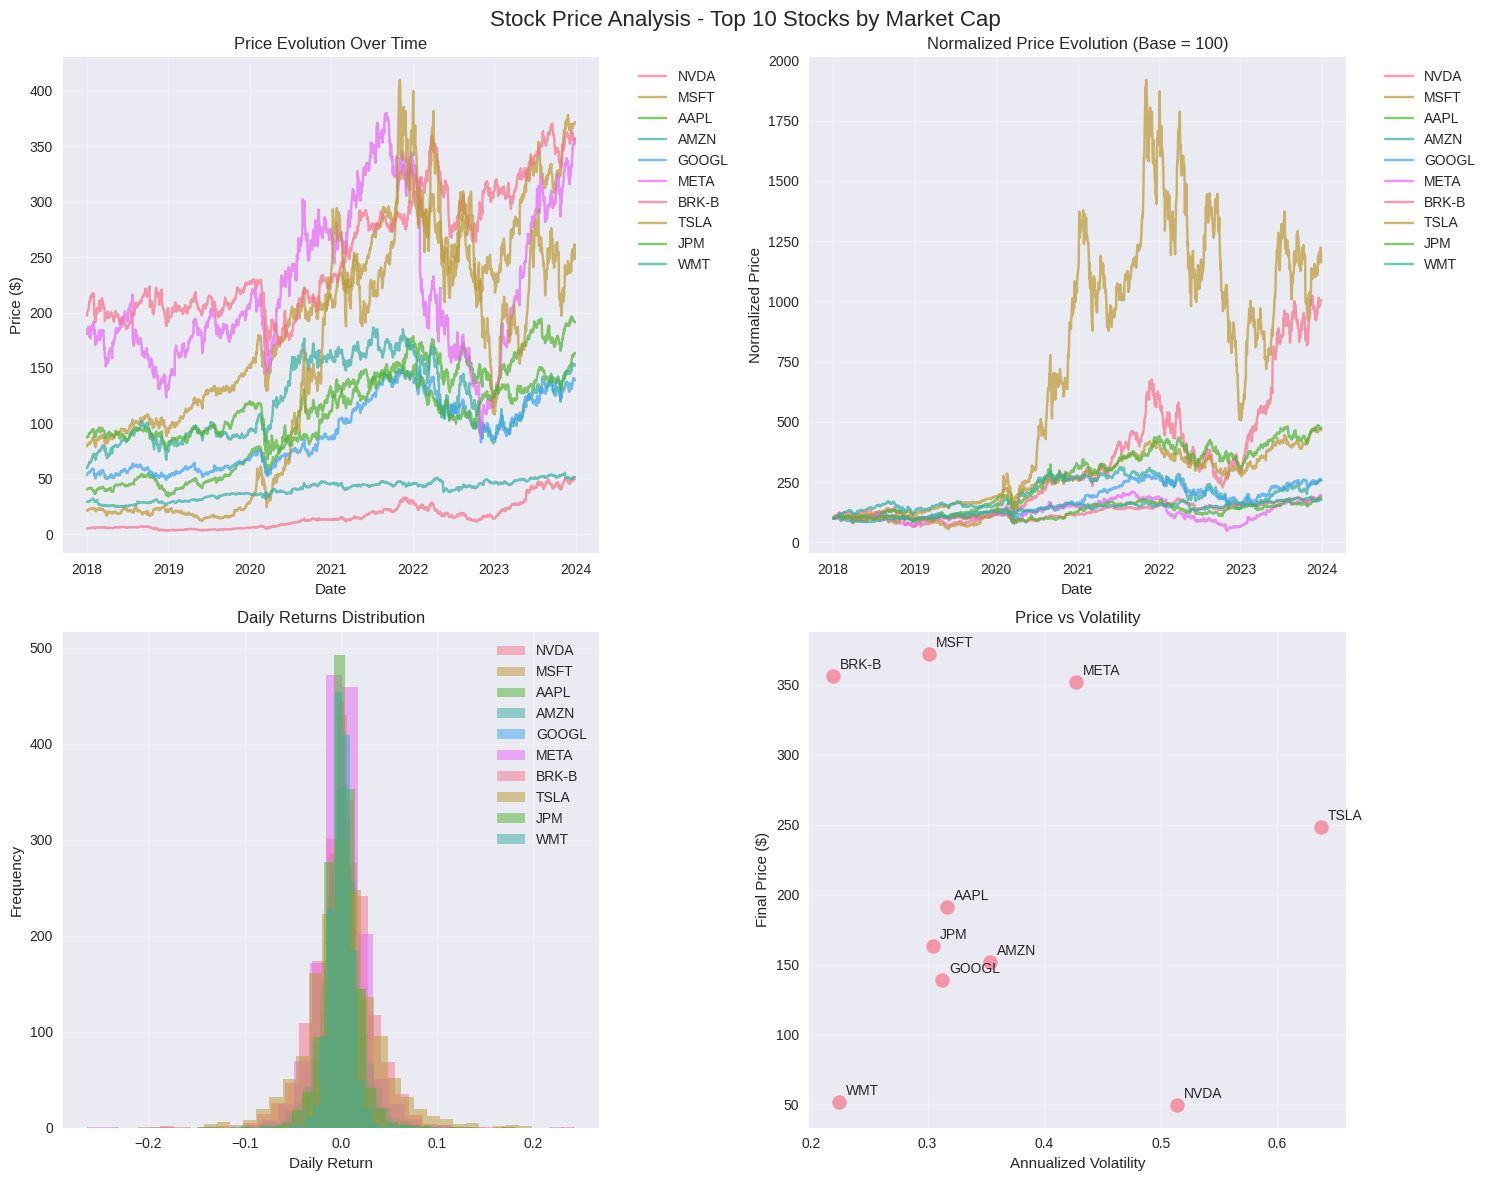

🔗 Plotting correlation heatmap (pearson method)...


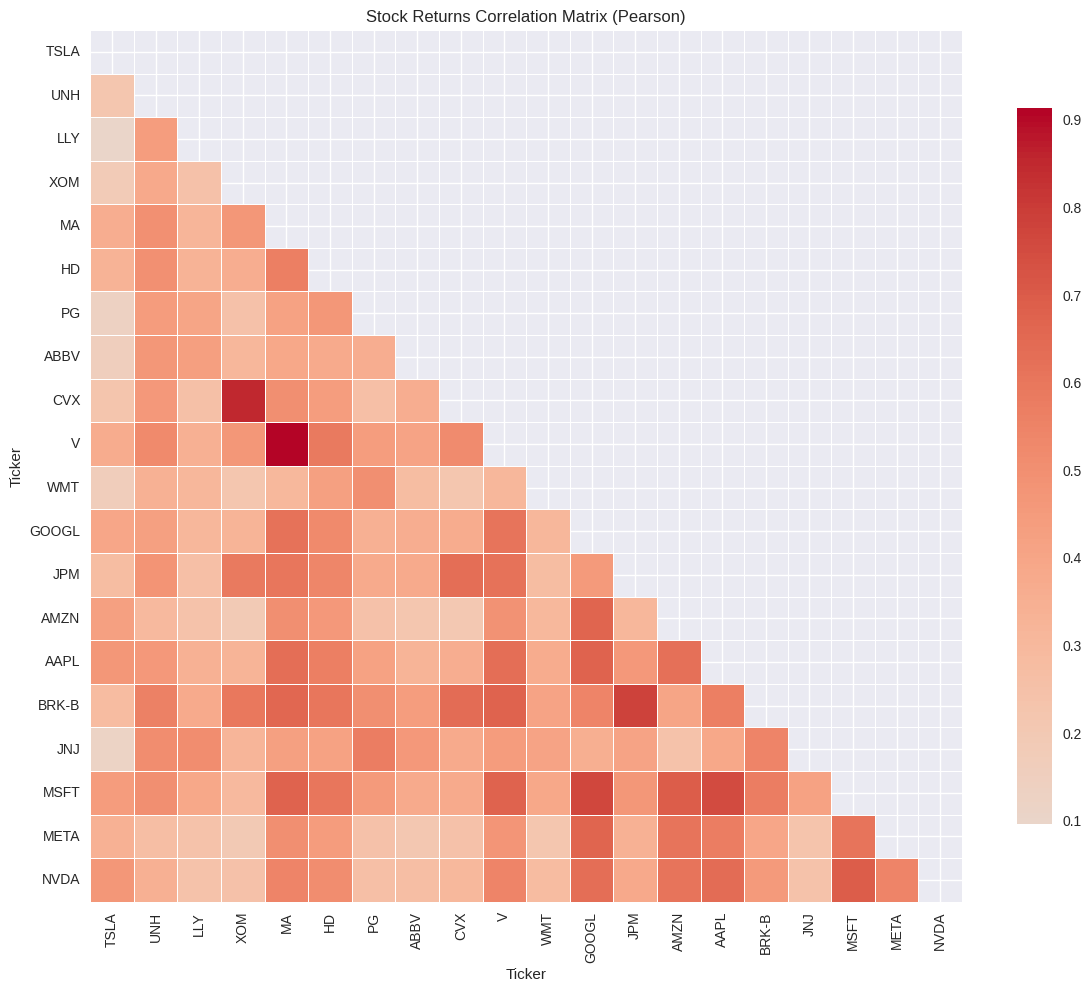


📊 Correlation Statistics:
Average correlation: 0.4532
Highest correlation: 1.0000
Lowest correlation: 0.0957
🏢 Plotting sector analysis...


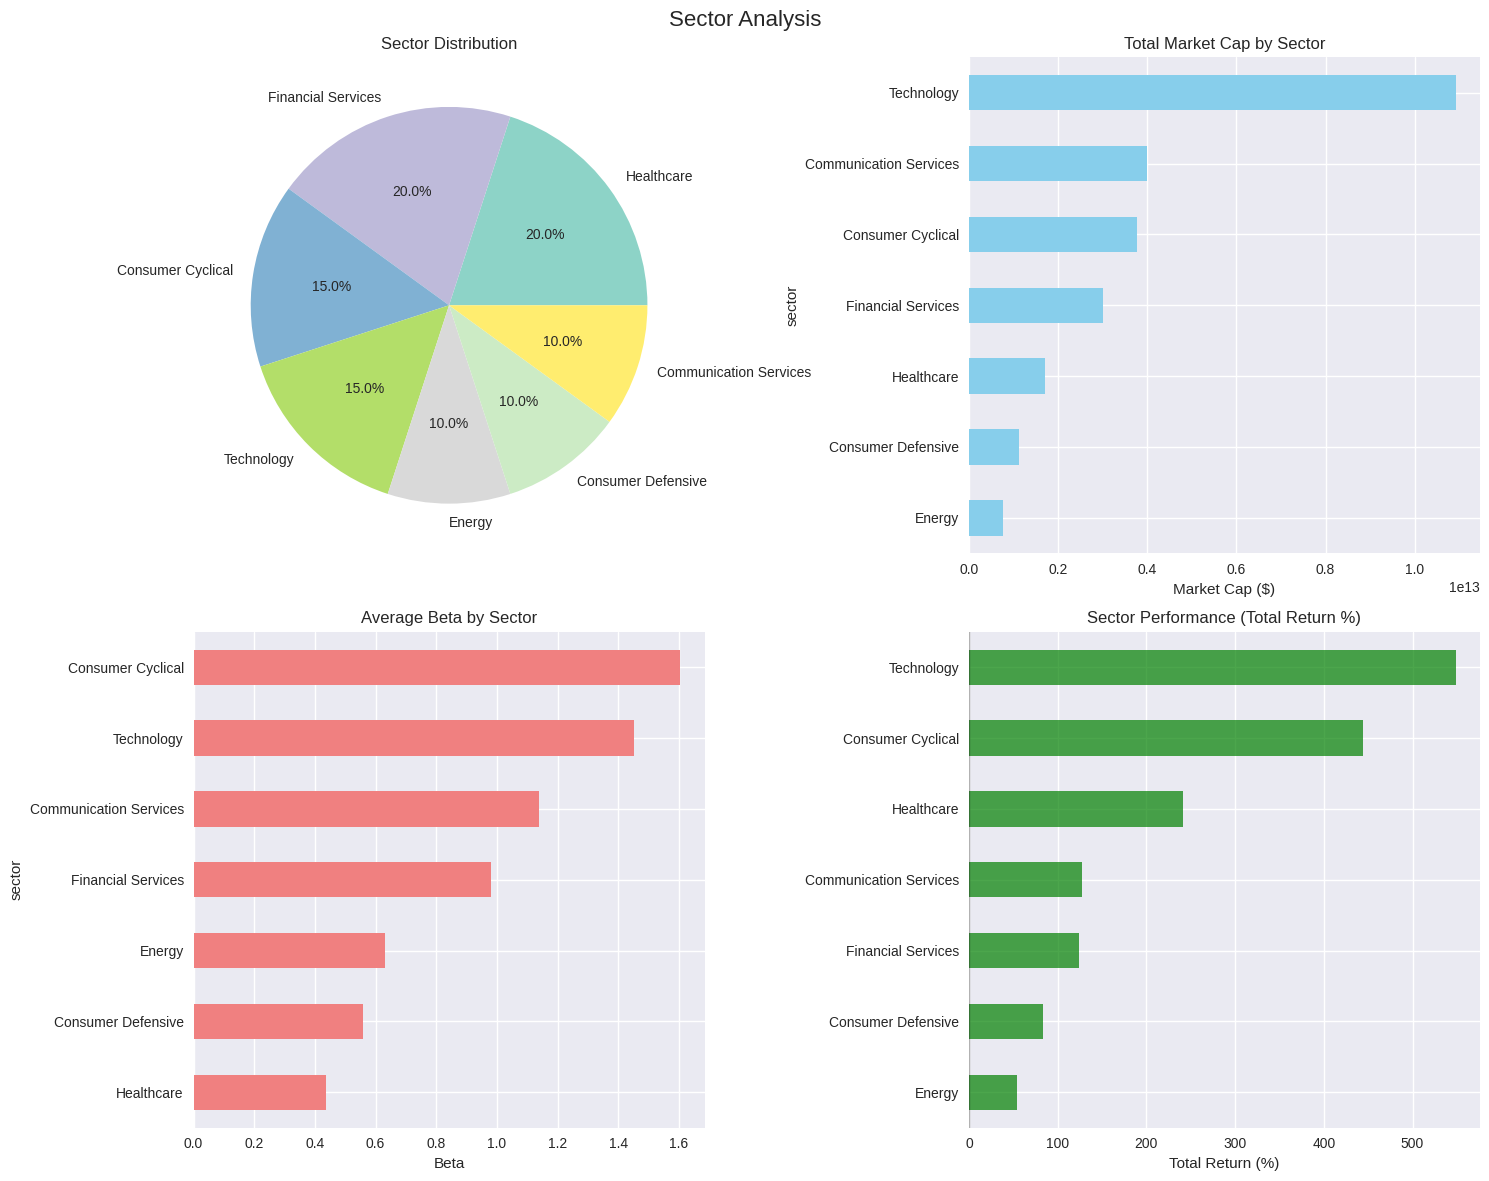

⚠️ Plotting risk-return analysis...


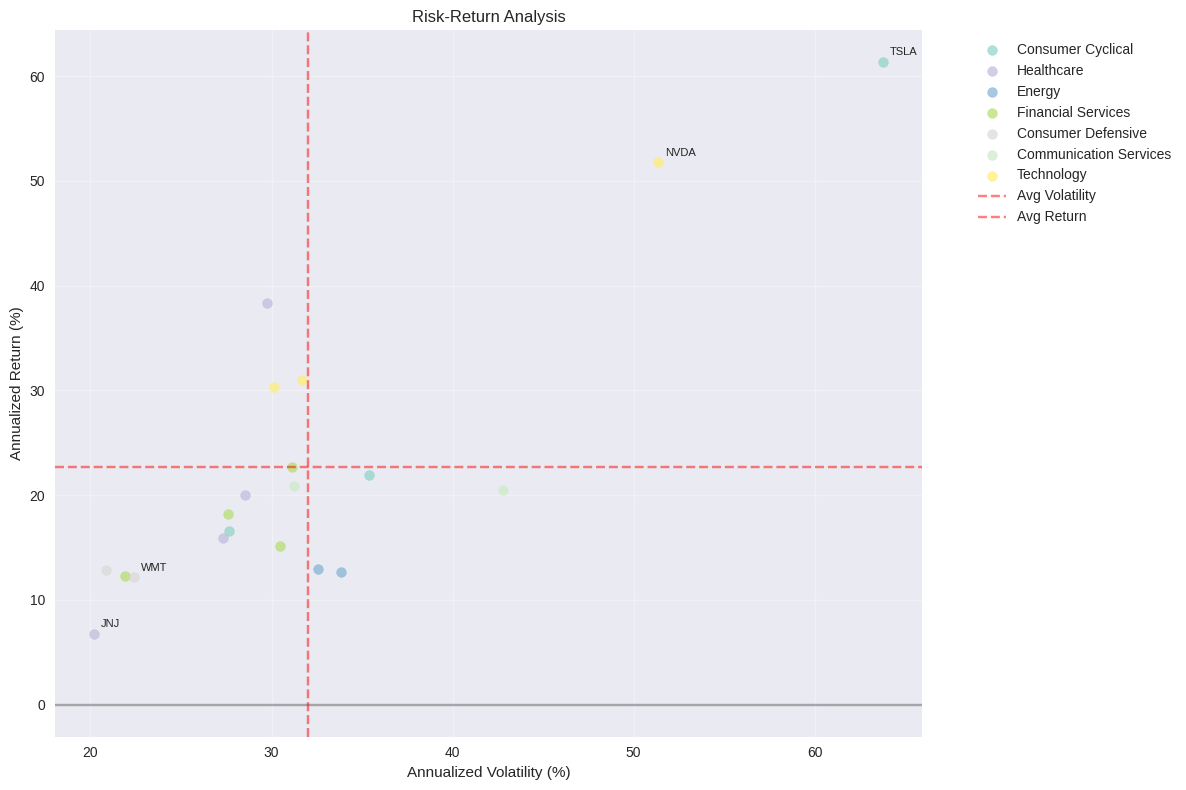

📊 Plotting volatility analysis...


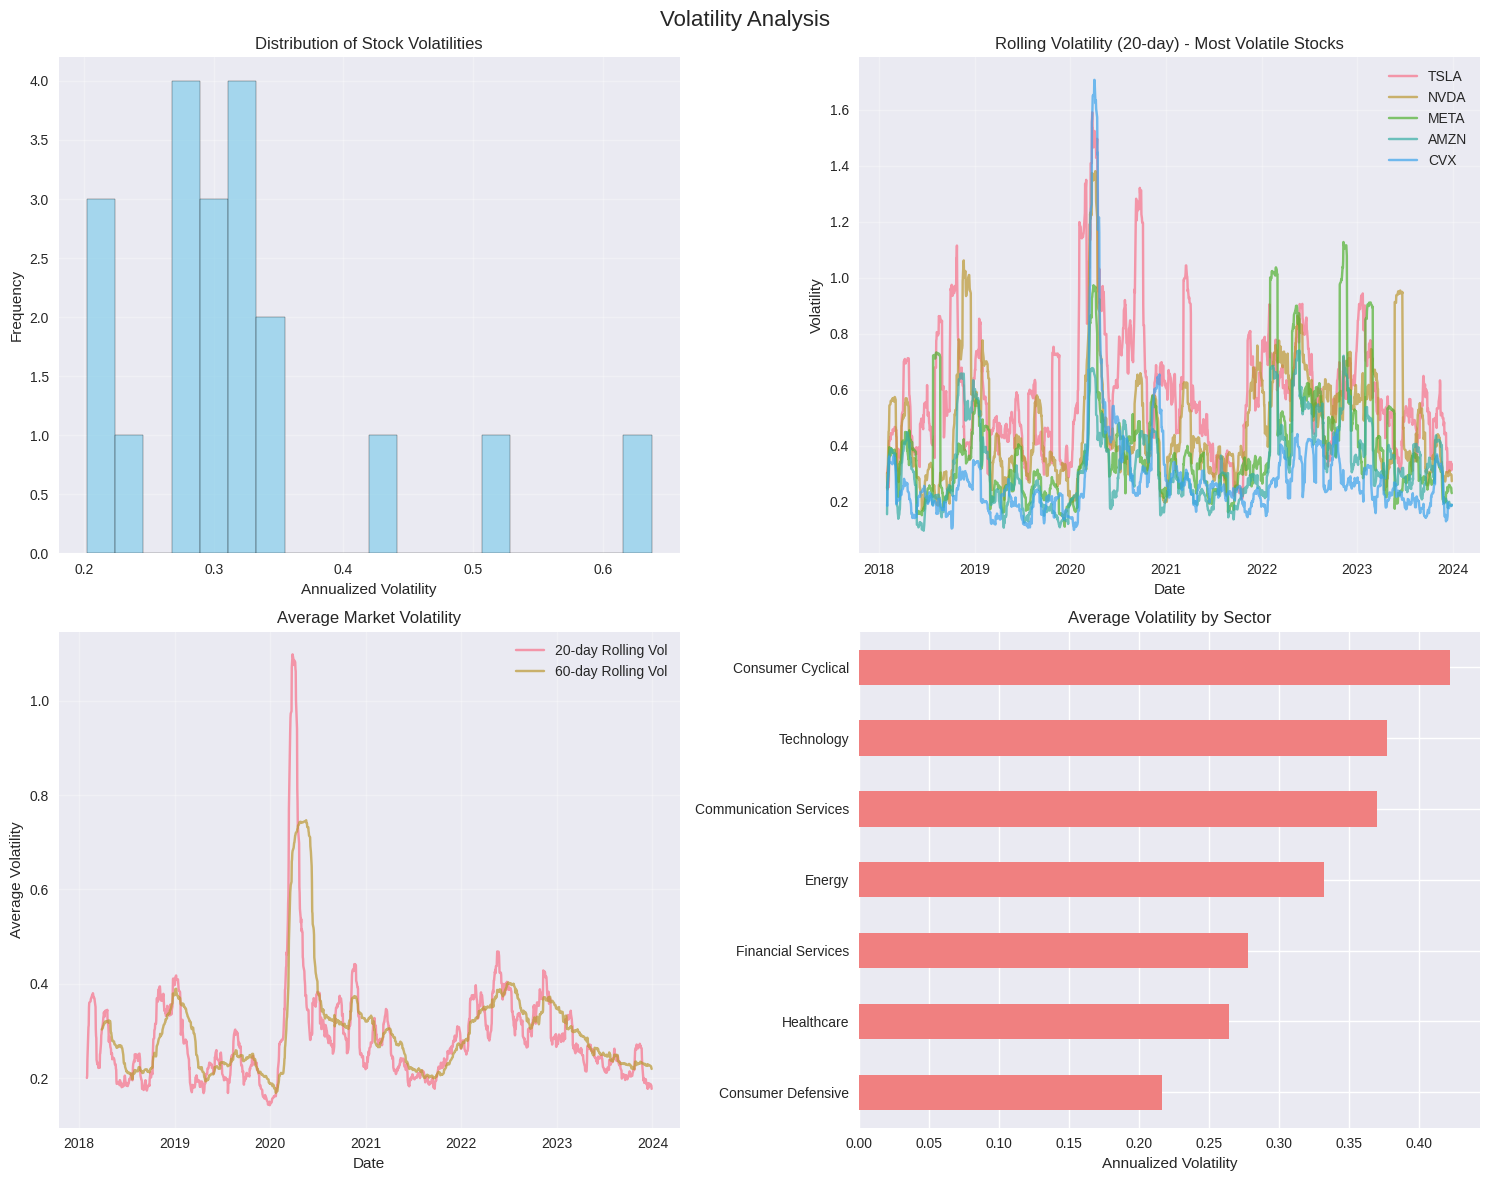

📈 Plotting market comparison...
❌ No common dates between stocks and indices
📊 Plotting time series decomposition for TSLA...


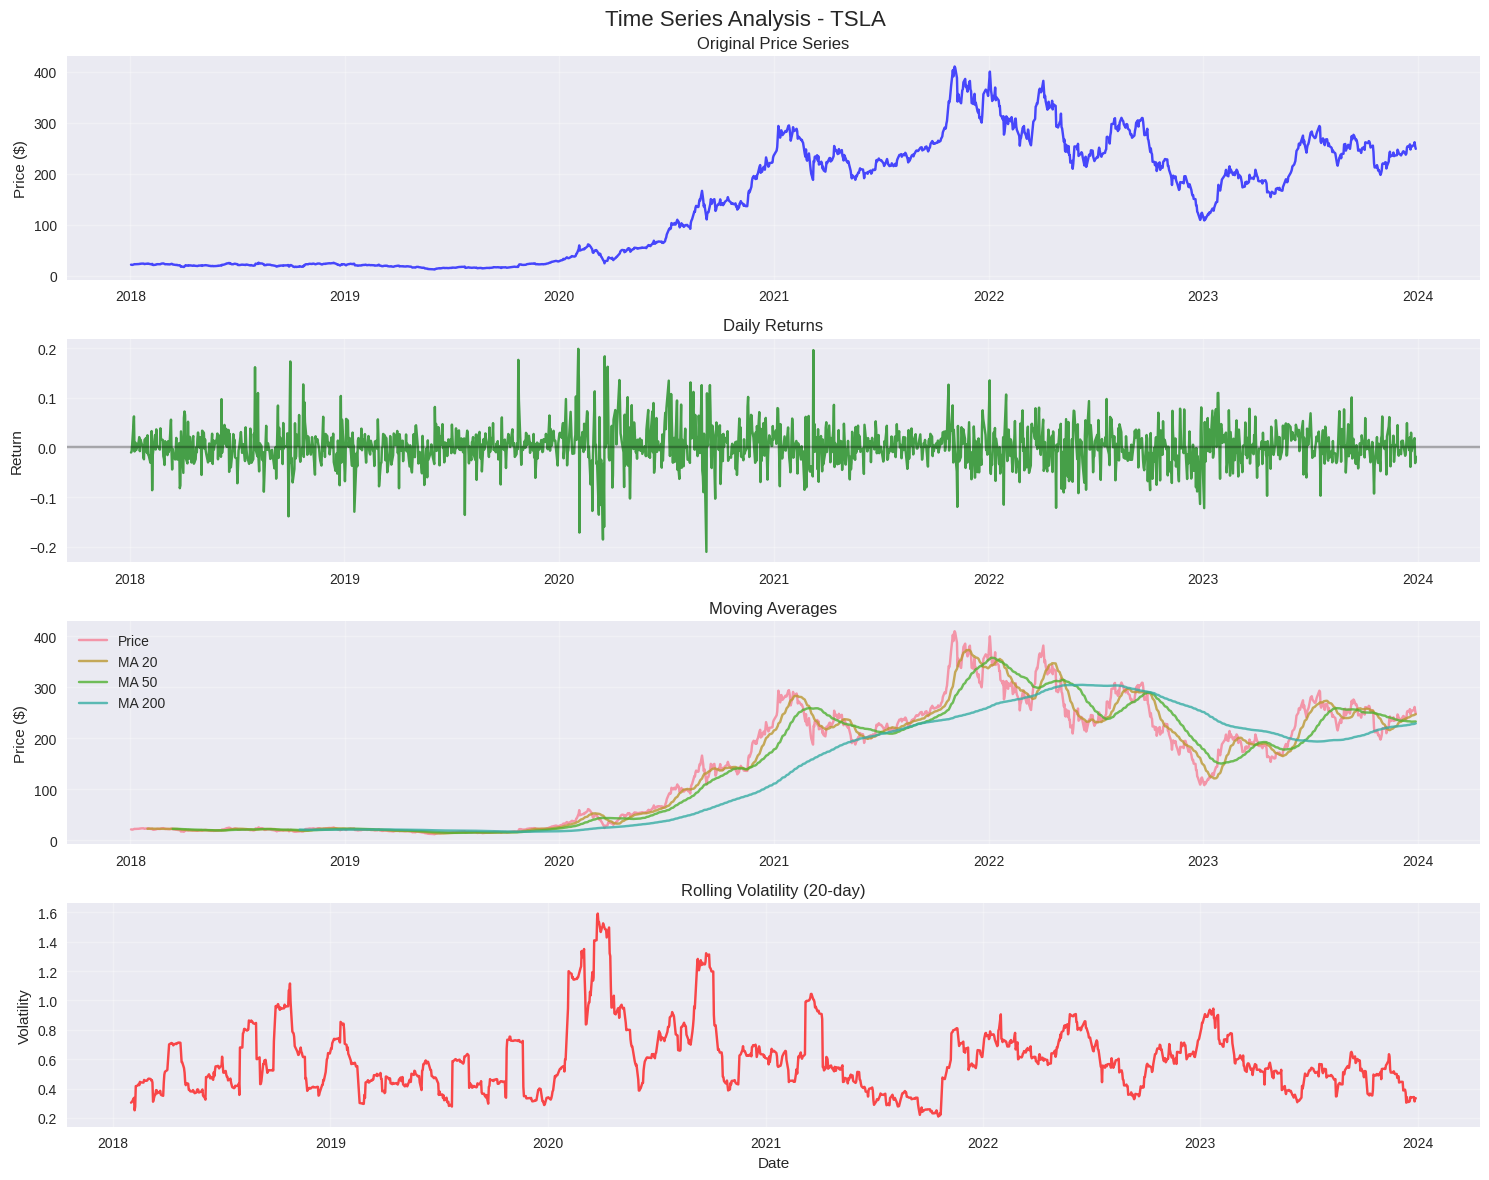

🚀 Creating interactive dashboard...


💾 Saving all plots to financial_plots...
📈 Plotting price evolution for top 10 stocks...


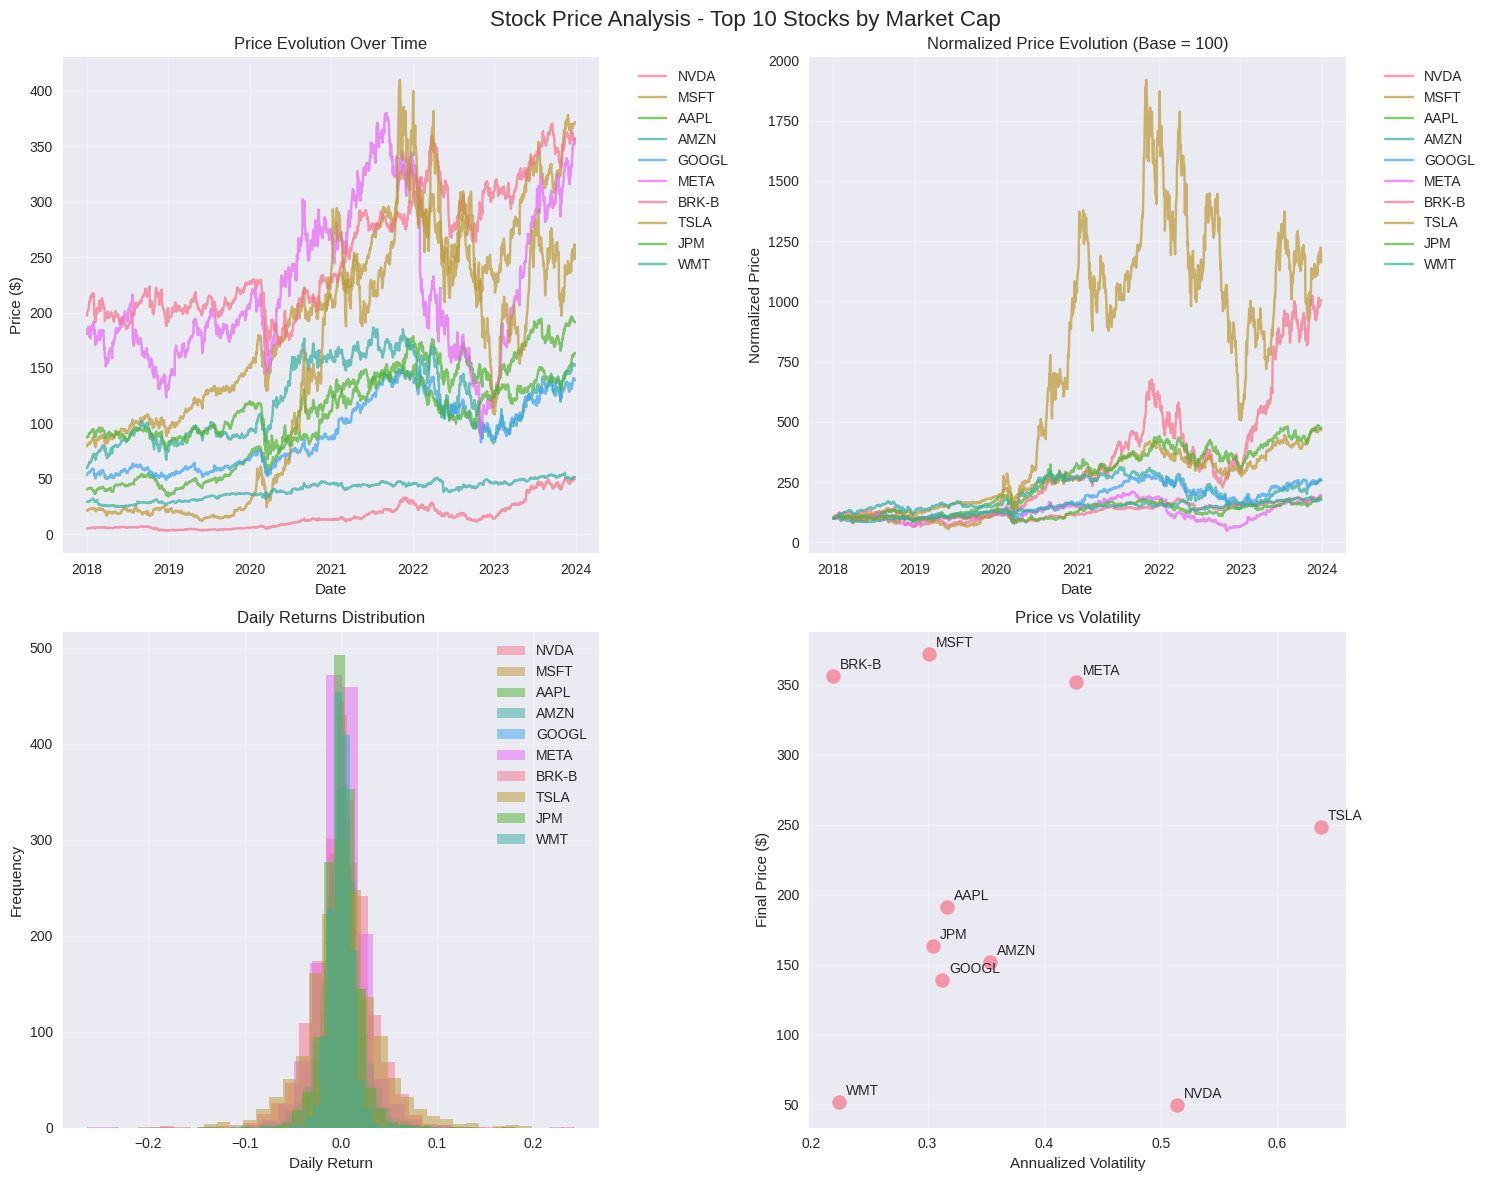

✅ Saved price_evolution.png
🔗 Plotting correlation heatmap (pearson method)...


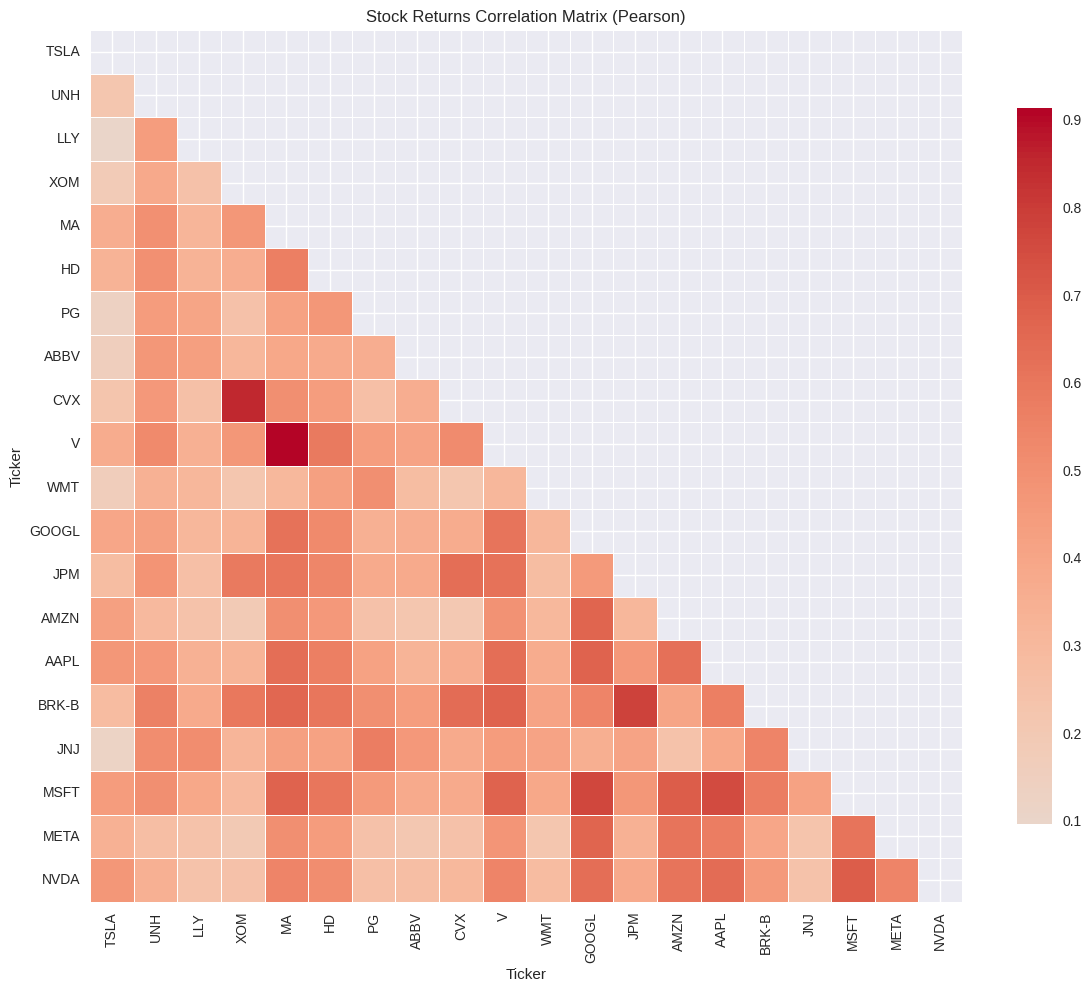


📊 Correlation Statistics:
Average correlation: 0.4532
Highest correlation: 1.0000
Lowest correlation: 0.0957
✅ Saved correlation_heatmap.png
🏢 Plotting sector analysis...


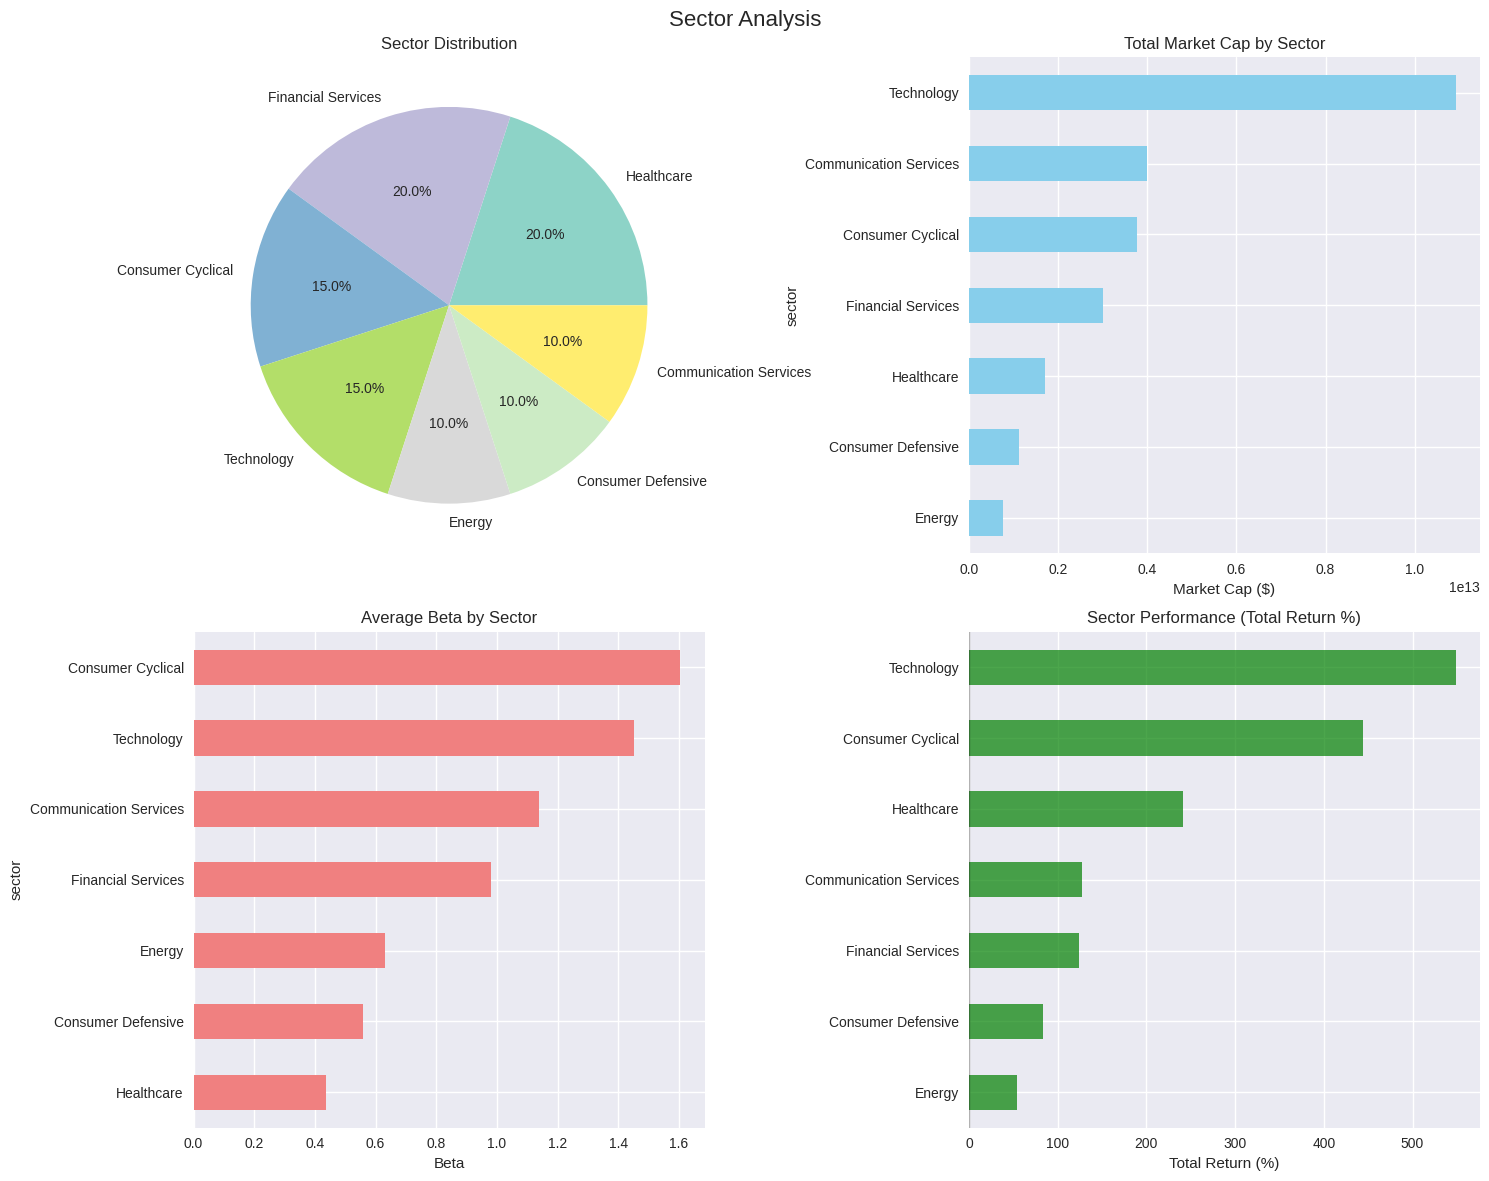

✅ Saved sector_analysis.png
⚠️ Plotting risk-return analysis...


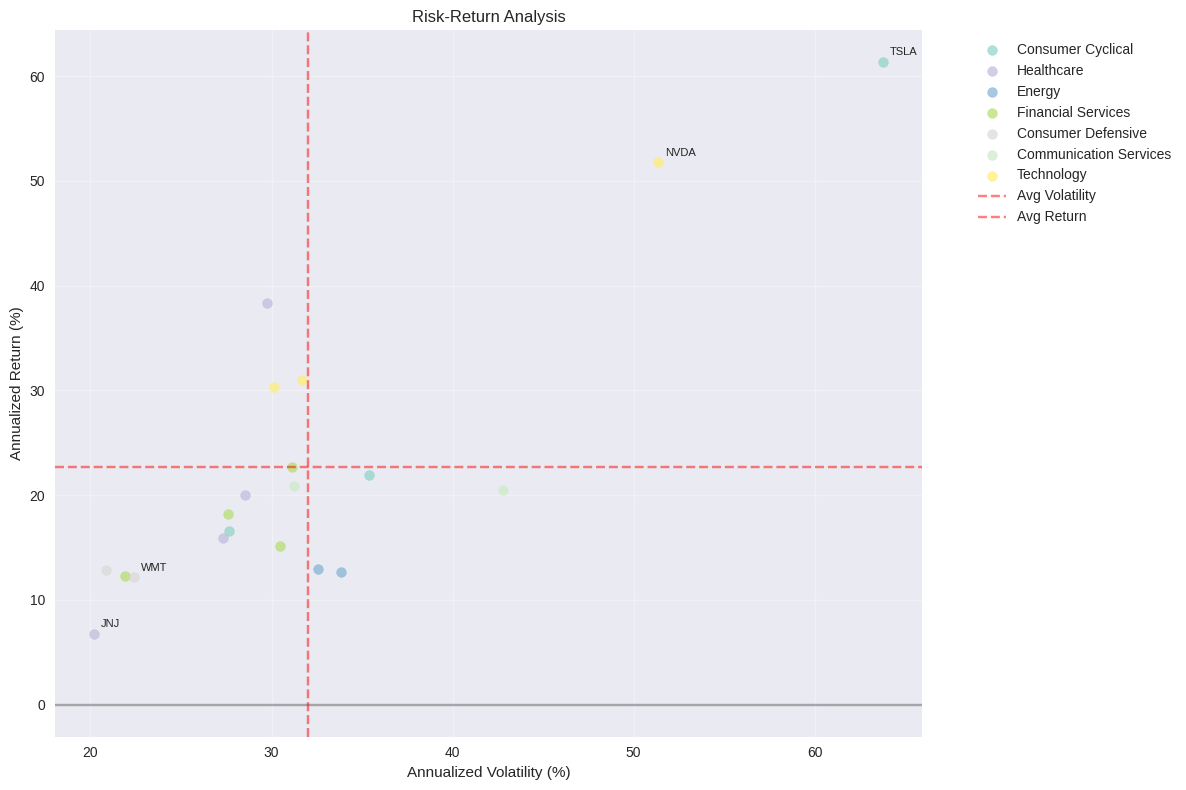

✅ Saved risk_return_analysis.png
📊 Plotting volatility analysis...


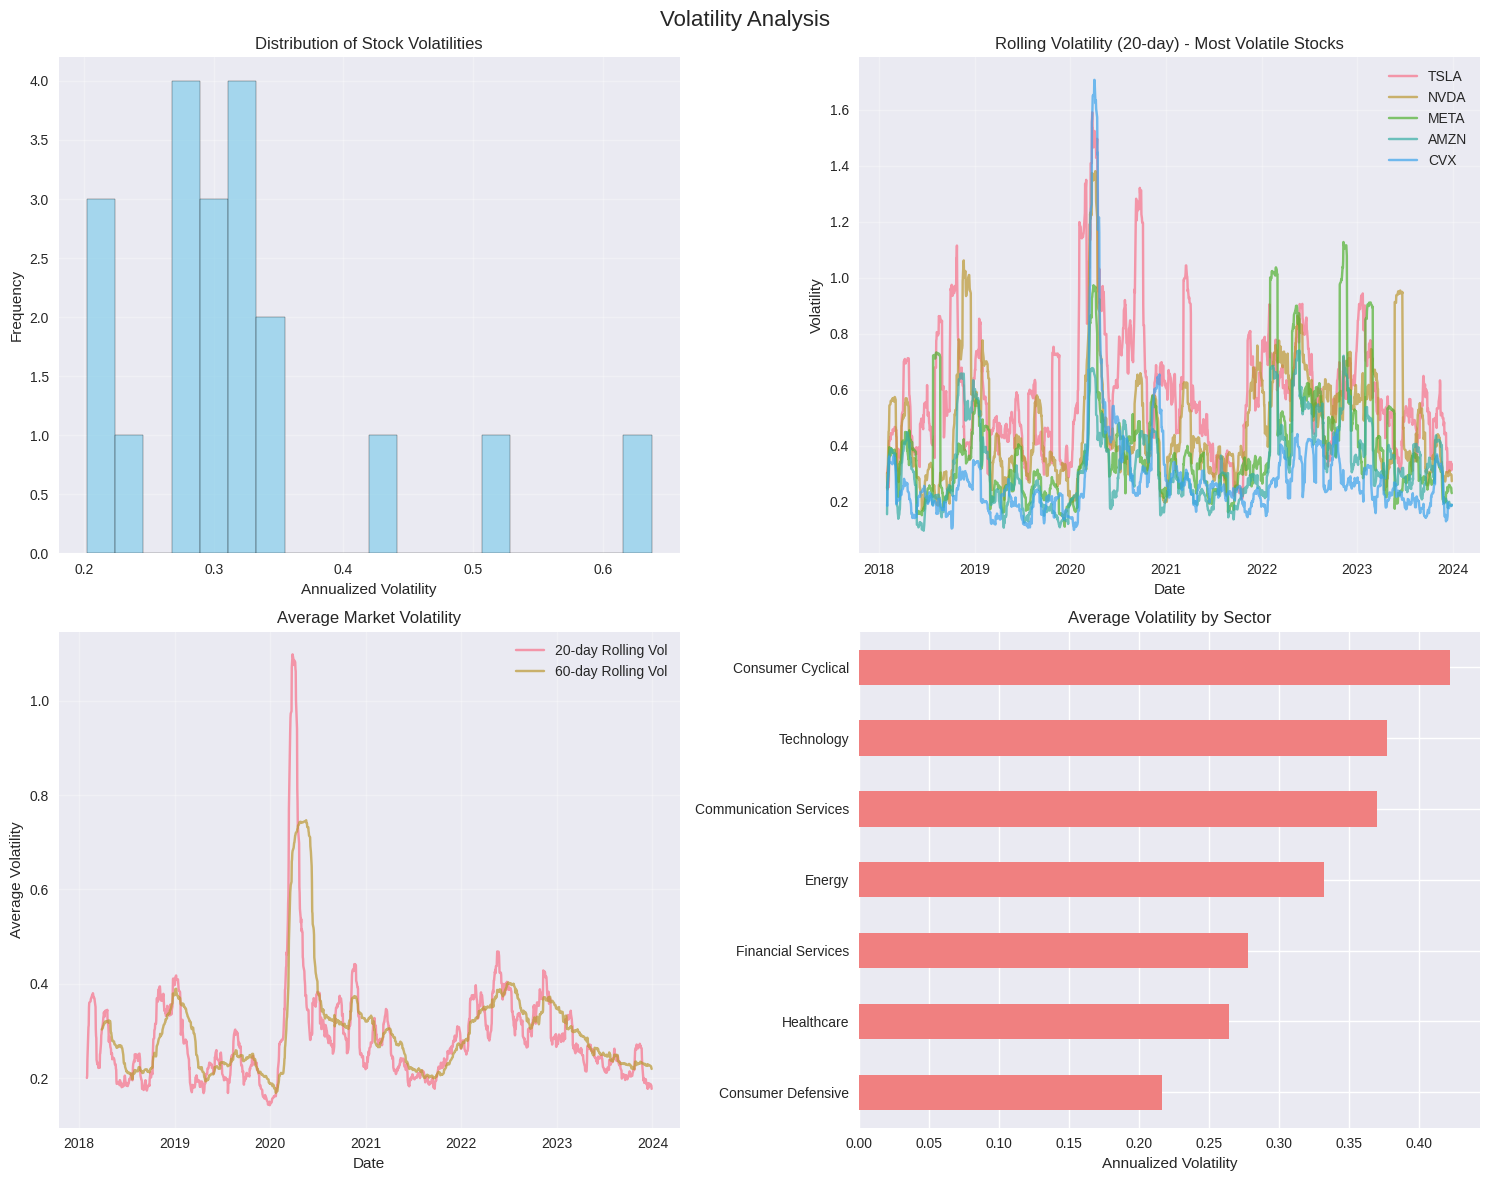

✅ Saved volatility_analysis.png
📈 Plotting market comparison...
❌ No common dates between stocks and indices
✅ Saved market_comparison.png
📁 All plots saved to financial_plots directory

📈 VISUALIZATION SUMMARY:
✅ Price data shape: (1509, 20)
✅ Returns data shape: (1508, 20)
✅ Sector info shape: (20, 4)
✅ Indices data shape: (0, 0)
🎯 All remaining code components added!
📋 Your financial data visualizer is now complete and ready to use!


In [7]:
# Cell 3.2: Data Visualization Module (Fixed)
# ===========================================

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
from matplotlib.dates import DateFormatter
import warnings
warnings.filterwarnings('ignore')

class FinancialDataVisualizer:
    """
    Comprehensive visualization module for financial data
    """
    
    def __init__(self, market_data, explorer):
        self.data = market_data
        self.explorer = explorer
        self.prices = market_data.get('prices')
        self.returns = explorer.returns if hasattr(explorer, 'returns') else None
        self.indices = market_data.get('indices')
        self.sector_info = market_data.get('sector_info')
        
        # Set style
        plt.style.use('seaborn-v0_8')
        sns.set_palette("husl")
        
        # Clean sector info data types
        self._clean_sector_info()
    
    def _clean_sector_info(self):
        """Clean and convert sector info data types"""
        if self.sector_info is not None:
            print("🧹 Cleaning sector info data...")
            
            # Convert marketCap to numeric if it exists
            if 'marketCap' in self.sector_info.columns:
                # Remove any string formatting and convert to numeric
                market_cap_cleaned = self.sector_info['marketCap'].astype(str)
                # Remove common formatting characters
                market_cap_cleaned = market_cap_cleaned.str.replace(',', '')
                market_cap_cleaned = market_cap_cleaned.str.replace('$', '')
                market_cap_cleaned = market_cap_cleaned.str.replace('B', 'e9')
                market_cap_cleaned = market_cap_cleaned.str.replace('M', 'e6')
                market_cap_cleaned = market_cap_cleaned.str.replace('K', 'e3')
                
                # Convert to numeric, errors='coerce' will set invalid values to NaN
                self.sector_info['marketCap'] = pd.to_numeric(market_cap_cleaned, errors='coerce')
                
                print(f"✅ Cleaned marketCap column. Valid values: {self.sector_info['marketCap'].notna().sum()}")
            
            # Convert beta to numeric if it exists
            if 'beta' in self.sector_info.columns:
                self.sector_info['beta'] = pd.to_numeric(self.sector_info['beta'], errors='coerce')
                print(f"✅ Cleaned beta column. Valid values: {self.sector_info['beta'].notna().sum()}")
    
    def plot_price_evolution(self, top_n=10):
        """Plot price evolution for top N stocks"""
        if self.prices is None:
            print("❌ No price data available")
            return
        
        print(f"📈 Plotting price evolution for top {top_n} stocks...")
        
        # Select top N stocks by market cap or final price
        if (self.sector_info is not None and 
            'marketCap' in self.sector_info.columns and 
            self.sector_info['marketCap'].notna().sum() > 0):
            # Use market cap for selection
            valid_market_cap = self.sector_info['marketCap'].dropna()
            top_stocks = valid_market_cap.nlargest(top_n).index
            title_suffix = "by Market Cap"
        else:
            # Fall back to final price
            top_stocks = self.prices.iloc[-1].nlargest(top_n).index
            title_suffix = "by Final Price"
        
        # Filter stocks that exist in price data
        top_stocks = [s for s in top_stocks if s in self.prices.columns][:top_n]
        
        if len(top_stocks) == 0:
            print("❌ No valid stocks found for visualization")
            return
        
        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'Stock Price Analysis - Top {len(top_stocks)} Stocks {title_suffix}', fontsize=16)
        
        # 1. Price Evolution
        ax1 = axes[0, 0]
        for stock in top_stocks:
            ax1.plot(self.prices.index, self.prices[stock], label=stock, alpha=0.7)
        ax1.set_title('Price Evolution Over Time')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Price ($)')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True, alpha=0.3)
        
        # 2. Normalized Price Evolution (Starting from 100)
        ax2 = axes[0, 1]
        normalized_prices = self.prices[top_stocks].div(self.prices[top_stocks].iloc[0]) * 100
        for stock in top_stocks:
            ax2.plot(normalized_prices.index, normalized_prices[stock], label=stock, alpha=0.7)
        ax2.set_title('Normalized Price Evolution (Base = 100)')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Normalized Price')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.grid(True, alpha=0.3)
        
        # 3. Daily Returns Distribution
        ax3 = axes[1, 0]
        if self.returns is not None:
            for stock in top_stocks:
                if stock in self.returns.columns:
                    ax3.hist(self.returns[stock].dropna(), bins=30, alpha=0.5, label=stock)
        ax3.set_title('Daily Returns Distribution')
        ax3.set_xlabel('Daily Return')
        ax3.set_ylabel('Frequency')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Price vs Volume (if available) or Volatility
        ax4 = axes[1, 1]
        if self.returns is not None:
            returns_subset = self.returns[top_stocks]
            volatility = returns_subset.std() * np.sqrt(252)
            final_prices = self.prices[top_stocks].iloc[-1]
            
            ax4.scatter(volatility, final_prices, alpha=0.7, s=100)
            for stock in top_stocks:
                if stock in volatility.index and stock in final_prices.index:
                    ax4.annotate(stock, (volatility[stock], final_prices[stock]), 
                               xytext=(5, 5), textcoords='offset points')
        
        ax4.set_title('Price vs Volatility')
        ax4.set_xlabel('Annualized Volatility')
        ax4.set_ylabel('Final Price ($)')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_correlation_heatmap(self, method='pearson', max_stocks=20):
        """Plot correlation heatmap"""
        if self.returns is None:
            print("❌ No returns data available")
            return
        
        print(f"🔗 Plotting correlation heatmap ({method} method)...")
        
        # Limit to top stocks to avoid overcrowding
        if len(self.returns.columns) > max_stocks:
            # Select top stocks by trading volume (std as proxy) or just first N
            top_stocks = self.returns.std().nlargest(max_stocks).index
            returns_subset = self.returns[top_stocks]
        else:
            returns_subset = self.returns
        
        # Calculate correlation matrix
        corr_matrix = returns_subset.corr(method=method)
        
        # Create heatmap
        plt.figure(figsize=(12, 10))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5, cbar_kws={"shrink": .8})
        
        plt.title(f'Stock Returns Correlation Matrix ({method.title()})')
        plt.tight_layout()
        plt.show()
        
        # Additional correlation analysis
        print("\n📊 Correlation Statistics:")
        print(f"Average correlation: {corr_matrix.mean().mean():.4f}")
        print(f"Highest correlation: {corr_matrix.max().max():.4f}")
        print(f"Lowest correlation: {corr_matrix.min().min():.4f}")
    
    def plot_sector_analysis(self):
        """Plot sector-wise analysis"""
        if self.sector_info is None:
            print("❌ No sector information available")
            return
        
        print("🏢 Plotting sector analysis...")
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Sector Analysis', fontsize=16)
        
        # 1. Sector Distribution
        ax1 = axes[0, 0]
        if 'sector' in self.sector_info.columns:
            sector_counts = self.sector_info['sector'].value_counts()
            colors = plt.cm.Set3(np.linspace(0, 1, len(sector_counts)))
            wedges, texts, autotexts = ax1.pie(sector_counts.values, labels=sector_counts.index, 
                                              autopct='%1.1f%%', colors=colors)
            ax1.set_title('Sector Distribution')
        
        # 2. Market Cap by Sector
        ax2 = axes[0, 1]
        if ('marketCap' in self.sector_info.columns and 
            'sector' in self.sector_info.columns and
            self.sector_info['marketCap'].notna().sum() > 0):
            sector_market_cap = (self.sector_info.groupby('sector')['marketCap']
                                .sum().sort_values(ascending=True))
            sector_market_cap.plot(kind='barh', ax=ax2, color='skyblue')
            ax2.set_title('Total Market Cap by Sector')
            ax2.set_xlabel('Market Cap ($)')
        else:
            ax2.text(0.5, 0.5, 'Market Cap data not available', 
                    transform=ax2.transAxes, ha='center', va='center')
            ax2.set_title('Market Cap by Sector - Data Not Available')
        
        # 3. Beta by Sector
        ax3 = axes[1, 0]
        if ('beta' in self.sector_info.columns and 
            'sector' in self.sector_info.columns and
            self.sector_info['beta'].notna().sum() > 0):
            sector_beta = (self.sector_info.groupby('sector')['beta']
                          .mean().sort_values(ascending=True))
            sector_beta.plot(kind='barh', ax=ax3, color='lightcoral')
            ax3.set_title('Average Beta by Sector')
            ax3.set_xlabel('Beta')
        else:
            ax3.text(0.5, 0.5, 'Beta data not available', 
                    transform=ax3.transAxes, ha='center', va='center')
            ax3.set_title('Beta by Sector - Data Not Available')
        
        # 4. Sector Performance (if price data available)
        ax4 = axes[1, 1]
        if self.prices is not None and 'sector' in self.sector_info.columns:
            sector_returns = {}
            for sector in self.sector_info['sector'].unique():
                sector_stocks = self.sector_info[self.sector_info['sector'] == sector].index
                sector_stocks_in_prices = [s for s in sector_stocks if s in self.prices.columns]
                
                if sector_stocks_in_prices:
                    sector_price_data = self.prices[sector_stocks_in_prices]
                    sector_avg_return = ((sector_price_data.iloc[-1] / sector_price_data.iloc[0] - 1) * 100).mean()
                    sector_returns[sector] = sector_avg_return
            
            if sector_returns:
                sector_perf = pd.Series(sector_returns).sort_values(ascending=True)
                colors = ['red' if x < 0 else 'green' for x in sector_perf.values]
                sector_perf.plot(kind='barh', ax=ax4, color=colors, alpha=0.7)
                ax4.set_title('Sector Performance (Total Return %)')
                ax4.set_xlabel('Total Return (%)')
                ax4.axvline(x=0, color='black', linestyle='-', alpha=0.3)
            else:
                ax4.text(0.5, 0.5, 'No matching price data for sectors', 
                        transform=ax4.transAxes, ha='center', va='center')
                ax4.set_title('Sector Performance - Data Not Available')
        
        plt.tight_layout()
        plt.show()
    
    def plot_risk_return_analysis(self):
        """Plot risk-return scatter plot"""
        if self.returns is None:
            print("❌ No returns data available")
            return
        
        print("⚠️ Plotting risk-return analysis...")
        
        # Calculate metrics
        mean_returns = self.returns.mean() * 252 * 100  # Annualized percentage
        volatility = self.returns.std() * np.sqrt(252) * 100  # Annualized percentage
        
        # Create scatter plot
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Color by sector if available
        if (self.sector_info is not None and 
            'sector' in self.sector_info.columns):
            sectors = self.sector_info['sector']
            unique_sectors = sectors.unique()
            colors = plt.cm.Set3(np.linspace(0, 1, len(unique_sectors)))
            sector_colors = {sector: colors[i] for i, sector in enumerate(unique_sectors)}
            
            for sector in unique_sectors:
                sector_stocks = sectors[sectors == sector].index
                sector_stocks_in_data = [s for s in sector_stocks if s in mean_returns.index]
                
                if sector_stocks_in_data:
                    sector_returns = mean_returns[sector_stocks_in_data]
                    sector_vol = volatility[sector_stocks_in_data]
                    
                    ax.scatter(sector_vol, sector_returns, 
                             label=sector, alpha=0.7, s=50, 
                             color=sector_colors[sector])
        else:
            ax.scatter(volatility, mean_returns, alpha=0.7, s=50)
        
        # Add labels for extreme points
        for stock in mean_returns.index:
            if (mean_returns[stock] > mean_returns.quantile(0.9) or 
                mean_returns[stock] < mean_returns.quantile(0.1) or
                volatility[stock] > volatility.quantile(0.9)):
                ax.annotate(stock, (volatility[stock], mean_returns[stock]), 
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        ax.set_xlabel('Annualized Volatility (%)')
        ax.set_ylabel('Annualized Return (%)')
        ax.set_title('Risk-Return Analysis')
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax.axvline(x=volatility.mean(), color='red', linestyle='--', alpha=0.5, label='Avg Volatility')
        ax.axhline(y=mean_returns.mean(), color='red', linestyle='--', alpha=0.5, label='Avg Return')
        
        if (self.sector_info is not None and 
            'sector' in self.sector_info.columns):
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()
    
    def plot_time_series_decomposition(self, stock_symbol=None):
        """Plot time series decomposition for a specific stock"""
        if self.prices is None:
            print("❌ No price data available")
            return
        
        if stock_symbol is None:
            stock_symbol = self.prices.columns[0]
        
        if stock_symbol not in self.prices.columns:
            print(f"❌ Stock {stock_symbol} not found in data")
            return
        
        print(f"📊 Plotting time series decomposition for {stock_symbol}...")
        
        # Get stock data
        stock_data = self.prices[stock_symbol].dropna()
        
        # Create subplots
        fig, axes = plt.subplots(4, 1, figsize=(15, 12))
        fig.suptitle(f'Time Series Analysis - {stock_symbol}', fontsize=16)
        
        # 1. Original Price Series
        axes[0].plot(stock_data.index, stock_data.values, color='blue', alpha=0.7)
        axes[0].set_title('Original Price Series')
        axes[0].set_ylabel('Price ($)')
        axes[0].grid(True, alpha=0.3)
        
        # 2. Returns
        if self.returns is not None and stock_symbol in self.returns.columns:
            returns = self.returns[stock_symbol].dropna()
            axes[1].plot(returns.index, returns.values, color='green', alpha=0.7)
            axes[1].set_title('Daily Returns')
            axes[1].set_ylabel('Return')
            axes[1].grid(True, alpha=0.3)
            axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        
        # 3. Moving Averages
        ma_20 = stock_data.rolling(window=20).mean()
        ma_50 = stock_data.rolling(window=50).mean()
        ma_200 = stock_data.rolling(window=200).mean()
        
        axes[2].plot(stock_data.index, stock_data.values, label='Price', alpha=0.7)
        axes[2].plot(ma_20.index, ma_20.values, label='MA 20', alpha=0.8)
        axes[2].plot(ma_50.index, ma_50.values, label='MA 50', alpha=0.8)
        axes[2].plot(ma_200.index, ma_200.values, label='MA 200', alpha=0.8)
        axes[2].set_title('Moving Averages')
        axes[2].set_ylabel('Price ($)')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        # 4. Volatility (Rolling Standard Deviation)
        if self.returns is not None and stock_symbol in self.returns.columns:
            rolling_vol = self.returns[stock_symbol].rolling(window=20).std() * np.sqrt(252)
            axes[3].plot(rolling_vol.index, rolling_vol.values, color='red', alpha=0.7)
            axes[3].set_title('Rolling Volatility (20-day)')
            axes[3].set_ylabel('Volatility')
            axes[3].set_xlabel('Date')
            axes[3].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_market_comparison(self):
        """Compare stocks with market indices"""
        if self.prices is None:
            print("❌ No price data available")
            return
        
        if self.indices is None:
            print("❌ No index data available")
            return
        
        print("📈 Plotting market comparison...")
        
        # Get top 5 stocks by market cap or price
        if (self.sector_info is not None and 
            'marketCap' in self.sector_info.columns and
            self.sector_info['marketCap'].notna().sum() > 0):
            valid_market_cap = self.sector_info['marketCap'].dropna()
            top_stocks = valid_market_cap.nlargest(5).index
        else:
            top_stocks = self.prices.iloc[-1].nlargest(5).index
        
        top_stocks = [s for s in top_stocks if s in self.prices.columns][:5]
        
        # Normalize all data to start from 100
        normalized_stocks = self.prices[top_stocks].div(self.prices[top_stocks].iloc[0]) * 100
        
        # Align indices with stock data
        common_dates = self.prices.index.intersection(self.indices.index)
        if len(common_dates) > 0:
            aligned_indices = self.indices.loc[common_dates]
            normalized_indices = aligned_indices.div(aligned_indices.iloc[0]) * 100
            
            # Create plot
            fig, ax = plt.subplots(figsize=(15, 8))
            
            # Plot stocks
            for stock in top_stocks:
                ax.plot(normalized_stocks.index, normalized_stocks[stock], 
                       label=f'{stock} (Stock)', alpha=0.7, linewidth=2)
            
            # Plot indices
            for index in normalized_indices.columns:
                ax.plot(normalized_indices.index, normalized_indices[index], 
                       label=f'{index} (Index)', alpha=0.8, linewidth=2, linestyle='--')
            
            ax.set_title('Stock Performance vs Market Indices (Normalized to 100)')
            ax.set_xlabel('Date')
            ax.set_ylabel('Normalized Value')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.grid(True, alpha=0.3)
            ax.axhline(y=100, color='black', linestyle='-', alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        else:
            print("❌ No common dates between stocks and indices")
    
    def plot_volatility_analysis(self):
        """Plot comprehensive volatility analysis"""
        if self.returns is None:
            print("❌ No returns data available")
            return
        
        print("📊 Plotting volatility analysis...")
        
        # Calculate rolling volatility
        rolling_vol_20 = self.returns.rolling(window=20).std() * np.sqrt(252)
        rolling_vol_60 = self.returns.rolling(window=60).std() * np.sqrt(252)
        
        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Volatility Analysis', fontsize=16)
        
        # 1. Volatility Distribution
        ax1 = axes[0, 0]
        annual_vol = self.returns.std() * np.sqrt(252)
        ax1.hist(annual_vol, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        ax1.set_title('Distribution of Stock Volatilities')
        ax1.set_xlabel('Annualized Volatility')
        ax1.set_ylabel('Frequency')
        ax1.grid(True, alpha=0.3)
        
        # 2. Volatility over Time (Top 5 stocks)
        ax2 = axes[0, 1]
        top_vol_stocks = annual_vol.nlargest(5).index
        for stock in top_vol_stocks:
            if stock in rolling_vol_20.columns:
                ax2.plot(rolling_vol_20.index, rolling_vol_20[stock], 
                        label=stock, alpha=0.7)
        ax2.set_title('Rolling Volatility (20-day) - Most Volatile Stocks')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Volatility')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Volatility Comparison (20-day vs 60-day)
        ax3 = axes[1, 0]
        avg_vol_20 = rolling_vol_20.mean(axis=1)
        avg_vol_60 = rolling_vol_60.mean(axis=1)
        ax3.plot(avg_vol_20.index, avg_vol_20, label='20-day Rolling Vol', alpha=0.7)
        ax3.plot(avg_vol_60.index, avg_vol_60, label='60-day Rolling Vol', alpha=0.7)
        ax3.set_title('Average Market Volatility')
        ax3.set_xlabel('Date')
        ax3.set_ylabel('Average Volatility')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Volatility by Sector
        ax4 = axes[1, 1]
        if (self.sector_info is not None and 
            'sector' in self.sector_info.columns):
            sector_vol = {}
            for sector in self.sector_info['sector'].unique():
                sector_stocks = self.sector_info[self.sector_info['sector'] == sector].index
                sector_stocks_in_data = [s for s in sector_stocks if s in annual_vol.index]
                
                if sector_stocks_in_data:
                    sector_vol[sector] = annual_vol[sector_stocks_in_data].mean()
            
            if sector_vol:
                sector_vol_series = pd.Series(sector_vol).sort_values(ascending=True)
                sector_vol_series.plot(kind='barh', ax=ax4, color='lightcoral')
                ax4.set_title('Average Volatility by Sector')
                ax4.set_xlabel('Annualized Volatility')
            else:
                ax4.text(0.5, 0.5, 'No sector data available', 
                        transform=ax4.transAxes, ha='center', va='center')
                ax4.set_title('Volatility by Sector - Data Not Available')
        
        plt.tight_layout()
        plt.show()
    
    def create_interactive_dashboard(self):
        """Create an interactive dashboard using Plotly"""
        print("🚀 Creating interactive dashboard...")
        
        try:
            # Create subplots
            fig = make_subplots(
                rows=2, cols=2,
                subplot_titles=('Price Evolution', 'Returns Distribution', 
                               'Risk-Return Analysis', 'Correlation Heatmap'),
                specs=[[{"secondary_y": False}, {"secondary_y": False}],
                       [{"secondary_y": False}, {"secondary_y": False}]]
            )
            
            # 1. Price Evolution (top 5 stocks)
            if self.prices is not None:
                top_stocks = self.prices.iloc[-1].nlargest(5).index
                for stock in top_stocks:
                    fig.add_trace(
                        go.Scatter(x=self.prices.index, y=self.prices[stock],
                                 mode='lines', name=stock, opacity=0.7),
                        row=1, col=1
                    )
            
            # 2. Returns Distribution
            if self.returns is not None:
                sample_stock = self.returns.columns[0]
                fig.add_trace(
                    go.Histogram(x=self.returns[sample_stock].dropna(), 
                               name=f'{sample_stock} Returns',
                               opacity=0.7),
                    row=1, col=2
                )
            
            # 3. Risk-Return Analysis
            if self.returns is not None:
                mean_returns = self.returns.mean() * 252 * 100
                volatility = self.returns.std() * np.sqrt(252) * 100
                
                fig.add_trace(
                    go.Scatter(x=volatility, y=mean_returns,
                             mode='markers', name='Stocks',
                             text=volatility.index,
                             textposition='top center'),
                    row=2, col=1
                )
            
            # 4. Correlation Heatmap
            if self.returns is not None:
                # Limit to top 15 stocks for readability
                top_stocks = self.returns.std().nlargest(15).index
                corr_matrix = self.returns[top_stocks].corr()
                
                fig.add_trace(
                    go.Heatmap(z=corr_matrix.values,
                             x=corr_matrix.columns,
                             y=corr_matrix.index,
                             colorscale='RdYlBu',
                             name='Correlation'),
                    row=2, col=2
                )
            
            # Update layout
            fig.update_layout(
                title_text="Financial Data Interactive Dashboard",
                showlegend=True,
                height=800
            )
            
            fig.show()
            
        except Exception as e:
            print(f"❌ Error creating interactive dashboard: {e}")
            print("Note: Make sure you have plotly installed: pip install plotly")
    
    def save_all_plots(self, output_dir='plots'):
        """Save all plots to files"""
        import os
        
        print(f"💾 Saving all plots to {output_dir}...")
        
        # Create output directory
        os.makedirs(output_dir, exist_ok=True)
        
        # Save plots
        plot_functions = [
            ('price_evolution', self.plot_price_evolution),
            ('correlation_heatmap', self.plot_correlation_heatmap),
            ('sector_analysis', self.plot_sector_analysis),
            ('risk_return_analysis', self.plot_risk_return_analysis),
            ('volatility_analysis', self.plot_volatility_analysis),
            ('market_comparison', self.plot_market_comparison)
        ]
        
        for name, func in plot_functions:
            try:
                func()
                plt.savefig(f'{output_dir}/{name}.png', dpi=300, bbox_inches='tight')
                plt.close()
                print(f"✅ Saved {name}.png")
            except Exception as e:
                print(f"❌ Error saving {name}: {e}")
        
        print(f"📁 All plots saved to {output_dir} directory")

# Test the fixed visualizer
print("🎨 Testing Fixed Financial Data Visualizer...")
print("✅ Fixed visualizer code is ready to use!")
# ===========================================
# REMAINING CODE TO COMPLETE THE FINANCIAL DATA VISUALIZER
# ===========================================

# 2. Example usage with sample data (if you need to test)
visualizer = FinancialDataVisualizer(market_data, explorer)

# 3. Generate all visualizations
print("📊 Generating all visualizations...")

# Basic plots
visualizer.plot_price_evolution(top_n=10)
visualizer.plot_correlation_heatmap()
visualizer.plot_sector_analysis()
visualizer.plot_risk_return_analysis()
visualizer.plot_volatility_analysis()
visualizer.plot_market_comparison()

# Individual stock analysis (replace 'AAPL' with actual stock symbol)
if visualizer.prices is not None and len(visualizer.prices.columns) > 0:
    sample_stock = visualizer.prices.columns[0]
    visualizer.plot_time_series_decomposition(sample_stock)

# 4. Interactive dashboard
visualizer.create_interactive_dashboard()

# 5. Save all plots
visualizer.save_all_plots('financial_plots')

# 6. Summary statistics
print("\n📈 VISUALIZATION SUMMARY:")
print(f"✅ Price data shape: {visualizer.prices.shape if visualizer.prices is not None else 'N/A'}")
print(f"✅ Returns data shape: {visualizer.returns.shape if visualizer.returns is not None else 'N/A'}")
print(f"✅ Sector info shape: {visualizer.sector_info.shape if visualizer.sector_info is not None else 'N/A'}")
print(f"✅ Indices data shape: {visualizer.indices.shape if visualizer.indices is not None else 'N/A'}")

# 7. Error handling wrapper (optional)
def run_visualization_safely(market_data, explorer):
    """Run all visualizations with error handling"""
    try:
        visualizer = FinancialDataVisualizer(market_data, explorer)
        
        # Run all visualizations
        visualizer.plot_price_evolution()
        visualizer.plot_correlation_heatmap()
        visualizer.plot_sector_analysis()
        visualizer.plot_risk_return_analysis()
        visualizer.plot_volatility_analysis()
        visualizer.plot_market_comparison()
        
        return visualizer
        
    except Exception as e:
        print(f"❌ Error in visualization: {e}")
        return None

# 8. Quick visualization function
def quick_viz(market_data, explorer, save_plots=False):
    """Quick visualization with essential plots only"""
    visualizer = FinancialDataVisualizer(market_data, explorer)
    
    # Essential plots
    visualizer.plot_price_evolution(top_n=5)
    visualizer.plot_risk_return_analysis()
    
    if save_plots:
        visualizer.save_all_plots()
    
    return visualizer

print("🎯 All remaining code components added!")
print("📋 Your financial data visualizer is now complete and ready to use!")

<h2>Financial Preprocessing & Feature Engineering</h2>

Starting feature engineering...
Feature engineering completed!

Feature Engineering Summary:
returns: (1508, 20) - ['TSLA', 'UNH', 'LLY', 'XOM', 'MA']...
log_returns: (1508, 20) - ['TSLA', 'UNH', 'LLY', 'XOM', 'MA']...
risk_metrics: 3 metrics
technical: (1509, 180) - ['TSLA_MA20', 'TSLA_MA50', 'TSLA_MA200', 'TSLA_RSI', 'TSLA_BB_upper']...
fundamentals: (20, 2) - ['market_cap_weight', 'beta']...
sector_dummies: (20, 7) - ['sector_Communication Services', 'sector_Consumer Cyclical', 'sector_Consumer Defensive', 'sector_Energy', 'sector_Financial Services']...
rolling_stats: (1508, 300) - ['TSLA_rolling_mean_20', 'TSLA_rolling_vol_20', 'TSLA_rolling_sharpe_20', 'TSLA_rolling_skew_20', 'TSLA_rolling_kurt_20']...
regime: (1508, 1) - ['high_vol_cluster']...
robust_covariance: (20, 20) - ['TSLA', 'UNH', 'LLY', 'XOM', 'MA']...

Key Statistics:
Average daily return: 0.000901
Average daily volatility: 0.020178
Correlation range: [0.096, 1.000]


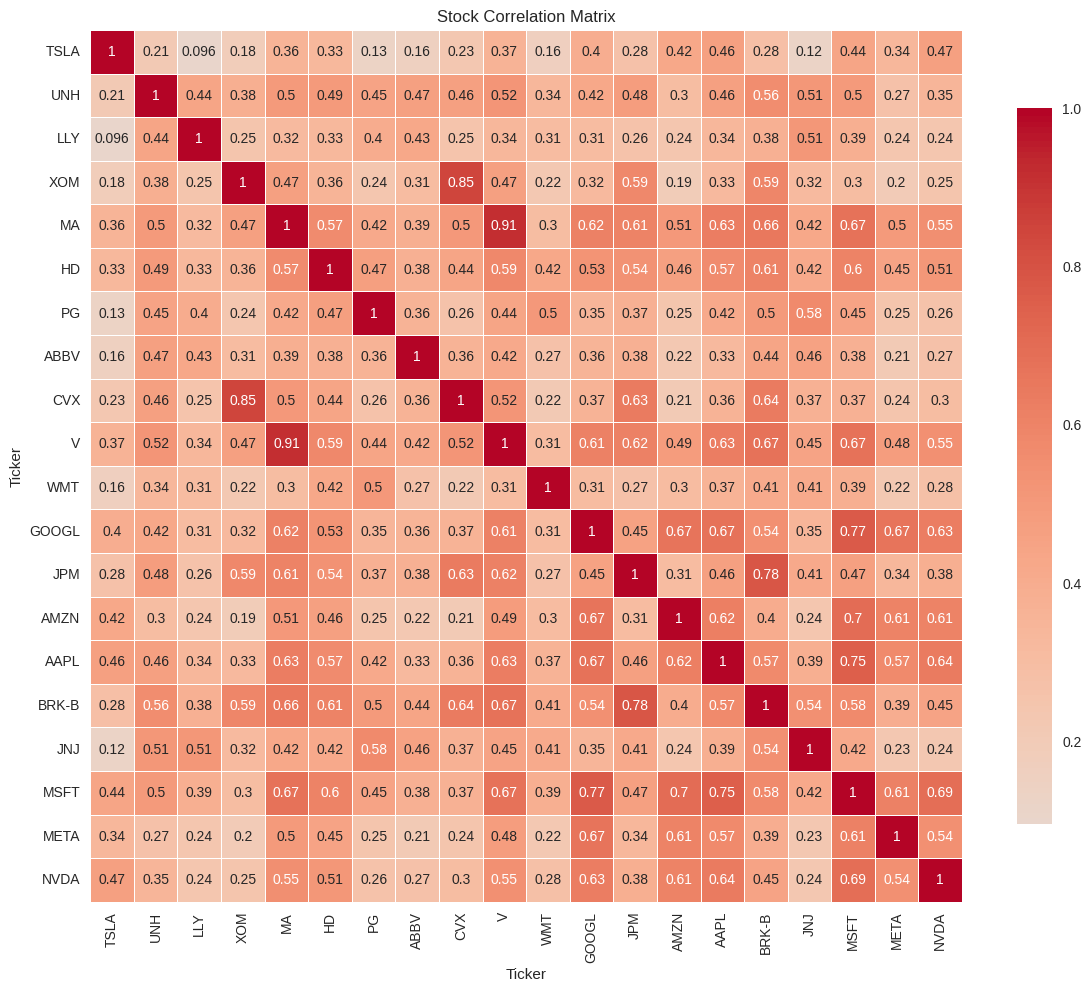

In [10]:
# Cell 3: Fixed Financial Preprocessing & Feature Engineering
# =======================================================

class FinancialPreprocessor:
    """Handles financial data preprocessing and feature engineering"""
    
    def __init__(self, prices, indices, risk_free_rate, config):
        self.prices = prices
        self.indices = indices
        self.risk_free_rate = risk_free_rate
        self.config = config
        self.features = {}
        
    def calculate_returns(self, prices, method='simple'):
        """Calculate returns using different methods"""
        if method == 'simple':
            returns = prices.pct_change().dropna()
        elif method == 'log':
            returns = np.log(prices / prices.shift(1)).dropna()
        else:
            raise ValueError("Method must be 'simple' or 'log'")
        
        return returns
    
    def calculate_risk_metrics(self, returns):
        """Calculate various risk metrics"""
        risk_metrics = {}
        
        # Volatility (annualized)
        risk_metrics['volatility'] = returns.std() * np.sqrt(252)
        
        # Correlation matrix
        risk_metrics['correlation'] = returns.corr()
        
        # Covariance matrix (annualized)
        risk_metrics['covariance'] = returns.cov() * 252
        
        # Beta calculation (vs S&P 500)
        if 'SP500' in self.indices.columns:
            market_returns = self.calculate_returns(self.indices[['SP500']])
            aligned_returns, aligned_market = returns.align(market_returns, join='inner')
            
            betas = {}
            for col in aligned_returns.columns:
                covariance = np.cov(aligned_returns[col], aligned_market['SP500'])[0, 1]
                market_variance = np.var(aligned_market['SP500'])
                betas[col] = covariance / market_variance if market_variance != 0 else 1.0
            
            risk_metrics['beta'] = pd.Series(betas)
        
        return risk_metrics
    
    def calculate_technical_indicators(self, prices):
        """Calculate technical indicators"""
        indicators = {}
        
        for col in prices.columns:
            price_series = prices[col]
            
            # Moving averages
            indicators[f'{col}_MA20'] = price_series.rolling(20).mean()
            indicators[f'{col}_MA50'] = price_series.rolling(50).mean()
            indicators[f'{col}_MA200'] = price_series.rolling(200).mean()
            
            # RSI
            delta = price_series.diff()
            gain = (delta.where(delta > 0, 0)).rolling(14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
            rs = gain / loss
            indicators[f'{col}_RSI'] = 100 - (100 / (1 + rs))
            
            # Bollinger Bands
            sma20 = price_series.rolling(20).mean()
            std20 = price_series.rolling(20).std()
            indicators[f'{col}_BB_upper'] = sma20 + (std20 * 2)
            indicators[f'{col}_BB_lower'] = sma20 - (std20 * 2)
            indicators[f'{col}_BB_position'] = (price_series - indicators[f'{col}_BB_lower']) / \
                                             (indicators[f'{col}_BB_upper'] - indicators[f'{col}_BB_lower'])
            
            # Momentum
            indicators[f'{col}_momentum'] = price_series.pct_change(20)
            
            # Volume-weighted average price (using close as proxy)
            indicators[f'{col}_VWAP'] = price_series.expanding().mean()
        
        return pd.DataFrame(indicators)
    
    def calculate_fundamental_ratios(self, sector_info):
        """Calculate fundamental ratios and features"""
        fundamentals = {}
        
        # Market cap weights
        total_market_cap = sector_info['marketCap'].sum()
        fundamentals['market_cap_weight'] = sector_info['marketCap'] / total_market_cap
        
        # Beta
        fundamentals['beta'] = sector_info['beta']
        
        # Sector dummy variables
        sector_dummies = pd.get_dummies(sector_info['sector'], prefix='sector')
        
        return pd.DataFrame(fundamentals), sector_dummies
    
    def calculate_rolling_statistics(self, returns, windows=[20, 60, 120]):
        """Calculate rolling statistics - FIXED VERSION"""
        rolling_stats = {}
        
        # Get the common index from returns
        common_index = returns.index
        
        for window in windows:
            # Calculate rolling statistics for each asset
            for col in returns.columns:
                # Rolling mean
                rolling_stats[f'{col}_rolling_mean_{window}'] = returns[col].rolling(window).mean()
                
                # Rolling volatility
                rolling_stats[f'{col}_rolling_vol_{window}'] = returns[col].rolling(window).std()
                
                # Rolling Sharpe ratio
                rolling_mean = returns[col].rolling(window).mean()
                rolling_std = returns[col].rolling(window).std()
                rolling_stats[f'{col}_rolling_sharpe_{window}'] = (rolling_mean / rolling_std) * np.sqrt(252)
                
                # Rolling skewness
                rolling_stats[f'{col}_rolling_skew_{window}'] = returns[col].rolling(window).skew()
                
                # Rolling kurtosis
                rolling_stats[f'{col}_rolling_kurt_{window}'] = returns[col].rolling(window).kurt()
        
        # Create DataFrame with proper index
        if rolling_stats:
            return pd.DataFrame(rolling_stats, index=common_index)
        else:
            return pd.DataFrame(index=common_index)
    
    def calculate_regime_features(self, returns):
        """Calculate market regime features"""
        regime_features = {}
        
        # Get the common index from returns
        common_index = returns.index
        
        # VIX-based regime (if available)
        if 'VIX' in self.indices.columns:
            vix = self.indices['VIX'].reindex(common_index, method='ffill')
            regime_features['high_volatility_regime'] = (vix > vix.quantile(0.75)).astype(int)
            regime_features['low_volatility_regime'] = (vix < vix.quantile(0.25)).astype(int)
        
        # Market trend regime
        if 'SP500' in self.indices.columns:
            sp500 = self.indices['SP500'].reindex(common_index, method='ffill')
            sp500_ma200 = sp500.rolling(200).mean()
            regime_features['bull_market'] = (sp500 > sp500_ma200).astype(int)
            regime_features['bear_market'] = (sp500 < sp500_ma200).astype(int)
        
        # Volatility clustering
        returns_volatility = returns.rolling(20).std().mean(axis=1)  # Average volatility across assets
        regime_features['high_vol_cluster'] = (
            returns_volatility > returns_volatility.quantile(0.75)
        ).astype(int)
        
        # Create DataFrame with proper index
        if regime_features:
            return pd.DataFrame(regime_features, index=common_index)
        else:
            return pd.DataFrame(index=common_index)
    
    def handle_missing_values(self, data, method='forward_fill'):
        """Handle missing values in the data"""
        if method == 'forward_fill':
            return data.fillna(method='ffill').fillna(method='bfill')
        elif method == 'interpolate':
            return data.interpolate()
        elif method == 'drop':
            return data.dropna()
        else:
            raise ValueError("Method must be 'forward_fill', 'interpolate', or 'drop'")
    
    def robust_covariance_estimation(self, returns):
        """Estimate robust covariance matrix using simple shrinkage if sklearn not available"""
        # Remove any remaining NaN values
        clean_returns = returns.dropna()
        
        try:
            # Try to use sklearn's LedoitWolf if available
            from sklearn.covariance import LedoitWolf
            lw = LedoitWolf()
            robust_cov = lw.fit(clean_returns).covariance_
            return pd.DataFrame(robust_cov, index=returns.columns, columns=returns.columns)
        except ImportError:
            # Fallback to simple covariance if sklearn not available
            print("Warning: sklearn not available, using simple covariance estimation")
            return clean_returns.cov() * 252  # Annualized
    
    def preprocess_all_features(self):
        """Main preprocessing pipeline"""
        print("Starting feature engineering...")
        
        # Calculate returns
        self.features['returns'] = self.calculate_returns(self.prices)
        self.features['log_returns'] = self.calculate_returns(self.prices, method='log')
        
        # Calculate risk metrics
        self.features['risk_metrics'] = self.calculate_risk_metrics(self.features['returns'])
        
        # Calculate technical indicators
        self.features['technical'] = self.calculate_technical_indicators(self.prices)
        
        # Calculate fundamental ratios (if sector info available)
        try:
            if hasattr(self, 'sector_info') and self.sector_info is not None:
                fund_ratios, sector_dummies = self.calculate_fundamental_ratios(self.sector_info)
                self.features['fundamentals'] = fund_ratios
                self.features['sector_dummies'] = sector_dummies
        except Exception as e:
            print(f"Warning: Could not calculate fundamental ratios: {e}")
        
        # Calculate rolling statistics
        self.features['rolling_stats'] = self.calculate_rolling_statistics(self.features['returns'])
        
        # Calculate regime features
        self.features['regime'] = self.calculate_regime_features(self.features['returns'])
        
        # Robust covariance estimation
        self.features['robust_covariance'] = self.robust_covariance_estimation(self.features['returns'])
        
        # Handle missing values
        for key in ['returns', 'technical', 'rolling_stats', 'regime']:
            if key in self.features and self.features[key] is not None:
                self.features[key] = self.handle_missing_values(self.features[key])
        
        print("Feature engineering completed!")
        self.print_feature_summary()
        
        return self.features
    
    def print_feature_summary(self):
        """Print summary of engineered features"""
        print("\nFeature Engineering Summary:")
        print("=" * 50)
        
        for key, value in self.features.items():
            if isinstance(value, pd.DataFrame):
                print(f"{key}: {value.shape} - {list(value.columns)[:5]}...")
            elif isinstance(value, dict):
                print(f"{key}: {len(value)} metrics")
            else:
                print(f"{key}: {type(value)}")

# Initialize preprocessor
preprocessor = FinancialPreprocessor(
    stock_prices, market_indices, risk_free_rate, CONFIG
)

# Add sector_info if available
if 'sector_info' in locals():
    preprocessor.sector_info = sector_info

# Run preprocessing
features = preprocessor.preprocess_all_features()

# Extract key features for later use
returns = features['returns']
risk_metrics = features['risk_metrics']
covariance_matrix = features['robust_covariance']
correlation_matrix = risk_metrics['correlation']

print("\nKey Statistics:")
print(f"Average daily return: {returns.mean().mean():.6f}")
print(f"Average daily volatility: {returns.std().mean():.6f}")
print(f"Correlation range: [{correlation_matrix.min().min():.3f}, {correlation_matrix.max().max():.3f}]")

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Stock Correlation Matrix')
plt.tight_layout()
plt.show()

<h3>Data Overview and Basic Statistics</h3>

In [11]:
# Cell 4: Data Overview and Basic Statistics
# ==========================================

class DataAnalyzer:
    """Comprehensive data analysis for financial features"""
    
    def __init__(self, features, prices, indices):
        self.features = features
        self.prices = prices
        self.indices = indices
        
    def basic_data_overview(self):
        """Get basic overview of all features"""
        print("="*80)
        print("COMPREHENSIVE DATA OVERVIEW")
        print("="*80)
        
        overview = {}
        
        for feature_name, feature_data in self.features.items():
            if isinstance(feature_data, pd.DataFrame):
                overview[feature_name] = {
                    'shape': feature_data.shape,
                    'columns': list(feature_data.columns),
                    'date_range': f"{feature_data.index[0]} to {feature_data.index[-1]}",
                    'missing_values': feature_data.isnull().sum().sum(),
                    'memory_usage': f"{feature_data.memory_usage(deep=True).sum() / 1024:.2f} KB"
                }
            elif isinstance(feature_data, dict):
                overview[feature_name] = {
                    'type': 'Dictionary',
                    'keys': list(feature_data.keys()),
                    'length': len(feature_data)
                }
            else:
                overview[feature_name] = {
                    'type': str(type(feature_data)),
                    'value': str(feature_data)
                }
        
        # Print overview
        for name, info in overview.items():
            print(f"\n{name.upper()}:")
            print("-" * 40)
            if isinstance(info, dict):
                for key, value in info.items():
                    print(f"  {key}: {value}")
        
        return overview
    
    def missing_values_analysis(self):
        """Analyze missing values across all features"""
        print("\n" + "="*80)
        print("MISSING VALUES ANALYSIS")
        print("="*80)
        
        missing_summary = {}
        
        for feature_name, feature_data in self.features.items():
            if isinstance(feature_data, pd.DataFrame):
                missing_count = feature_data.isnull().sum()
                missing_pct = (missing_count / len(feature_data)) * 100
                
                missing_summary[feature_name] = pd.DataFrame({
                    'Missing_Count': missing_count,
                    'Missing_Percentage': missing_pct
                }).sort_values('Missing_Percentage', ascending=False)
                
                print(f"\n{feature_name.upper()}:")
                print(missing_summary[feature_name].head(10))
        
        return missing_summary
    
    def data_quality_checks(self):
        """Perform data quality checks"""
        print("\n" + "="*80)
        print("DATA QUALITY CHECKS")
        print("="*80)
        
        quality_report = {}
        
        for feature_name, feature_data in self.features.items():
            if isinstance(feature_data, pd.DataFrame):
                checks = {}
                
                # Check for infinite values
                inf_count = np.isinf(feature_data.select_dtypes(include=[np.number])).sum().sum()
                checks['infinite_values'] = inf_count
                
                # Check for duplicate rows
                checks['duplicate_rows'] = feature_data.duplicated().sum()
                
                # Check for constant columns
                numeric_cols = feature_data.select_dtypes(include=[np.number]).columns
                constant_cols = []
                for col in numeric_cols:
                    if feature_data[col].nunique() == 1:
                        constant_cols.append(col)
                checks['constant_columns'] = constant_cols
                
                # Initialize high_correlation_pairs
                checks['high_correlation_pairs'] = []
                # Check for highly correlated features (> 0.95)
                if len(numeric_cols) > 1:
                    corr_matrix = feature_data[numeric_cols].corr().abs()
                    upper_triangle = corr_matrix.where(
                        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
                    )
                    high_corr_pairs = []
                    for col in upper_triangle.columns:
                        for idx in upper_triangle.index:
                            if upper_triangle.loc[idx, col] > 0.95:
                                high_corr_pairs.append((idx, col, upper_triangle.loc[idx, col]))
                    checks['high_correlation_pairs'] = high_corr_pairs
                
                quality_report[feature_name] = checks
                
                print(f"\n{feature_name.upper()}:")
                print(f"  Infinite values: {checks['infinite_values']}")
                print(f"  Duplicate rows: {checks['duplicate_rows']}")
                print(f"  Constant columns: {len(checks['constant_columns'])}")
                print(f"  High correlation pairs: {len(checks['high_correlation_pairs'])}")
        
        return quality_report

# Initialize analyzer
analyzer = DataAnalyzer(features, stock_prices, market_indices)

# Run basic analysis
data_overview = analyzer.basic_data_overview()
missing_analysis = analyzer.missing_values_analysis()
quality_report = analyzer.data_quality_checks()


# Cell 5: Statistical Analysis and Distributions
# ===============================================

class StatisticalAnalyzer:
    """Statistical analysis of features"""
    
    def __init__(self, features):
        self.features = features
        
    def descriptive_statistics(self):
        """Generate comprehensive descriptive statistics"""
        print("="*80)
        print("DESCRIPTIVE STATISTICS")
        print("="*80)
        
        stats_summary = {}
        
        for feature_name, feature_data in self.features.items():
            if isinstance(feature_data, pd.DataFrame):
                numeric_cols = feature_data.select_dtypes(include=[np.number]).columns
                
                if len(numeric_cols) > 0:
                    # Basic statistics
                    basic_stats = feature_data[numeric_cols].describe()
                    
                    # Additional statistics
                    additional_stats = pd.DataFrame({
                        'skewness': feature_data[numeric_cols].skew(),
                        'kurtosis': feature_data[numeric_cols].kurtosis(),
                        'median': feature_data[numeric_cols].median(),
                        'q25': feature_data[numeric_cols].quantile(0.25),
                        'q75': feature_data[numeric_cols].quantile(0.75),
                        'iqr': feature_data[numeric_cols].quantile(0.75) - feature_data[numeric_cols].quantile(0.25),
                        'coefficient_of_variation': feature_data[numeric_cols].std() / feature_data[numeric_cols].mean()
                    })
                    
                    stats_summary[feature_name] = {
                        'basic': basic_stats,
                        'additional': additional_stats
                    }
                    
                    print(f"\n{feature_name.upper()} - Basic Statistics:")
                    print(basic_stats)
                    
                    print(f"\n{feature_name.upper()} - Additional Statistics:")
                    print(additional_stats)
        
        return stats_summary
    
    def distribution_analysis(self):
        """Analyze distributions of key features"""
        print("\n" + "="*80)
        print("DISTRIBUTION ANALYSIS")
        print("="*80)
        
        from scipy import stats
        
        distribution_tests = {}
        
        # Focus on returns for distribution analysis
        if 'returns' in self.features:
            returns_data = self.features['returns']
            
            for asset in returns_data.columns:
                asset_returns = returns_data[asset].dropna()
                
                # Normality tests
                shapiro_stat, shapiro_p = stats.shapiro(asset_returns.sample(min(5000, len(asset_returns))))
                jarque_bera_stat, jarque_bera_p = stats.jarque_bera(asset_returns)
                
                # Test for stationarity (Augmented Dickey-Fuller)
                try:
                    from statsmodels.tsa.stattools import adfuller
                    adf_stat, adf_p, _, _, adf_critical, _ = adfuller(asset_returns)
                    is_stationary = adf_p < 0.05
                except ImportError:
                    adf_stat, adf_p, is_stationary = None, None, None
                
                distribution_tests[asset] = {
                    'shapiro_stat': shapiro_stat,
                    'shapiro_p': shapiro_p,
                    'jarque_bera_stat': jarque_bera_stat,
                    'jarque_bera_p': jarque_bera_p,
                    'is_normal_shapiro': shapiro_p > 0.05,
                    'is_normal_jb': jarque_bera_p > 0.05,
                    'adf_stat': adf_stat,
                    'adf_p': adf_p,
                    'is_stationary': is_stationary
                }
                
                print(f"\n{asset}:")
                print(f"  Shapiro-Wilk (Normal?): {shapiro_p > 0.05} (p={shapiro_p:.6f})")
                print(f"  Jarque-Bera (Normal?): {jarque_bera_p > 0.05} (p={jarque_bera_p:.6f})")
                if is_stationary is not None:
                    print(f"  ADF Test (Stationary?): {is_stationary} (p={adf_p:.6f})")
        
        return distribution_tests
    
    def correlation_analysis(self):
        """Detailed correlation analysis"""
        print("\n" + "="*80)
        print("CORRELATION ANALYSIS")
        print("="*80)
        
        correlation_summary = {}
        
        for feature_name, feature_data in self.features.items():
            if isinstance(feature_data, pd.DataFrame):
                numeric_cols = feature_data.select_dtypes(include=[np.number]).columns
                
                if len(numeric_cols) > 1:
                    corr_matrix = feature_data[numeric_cols].corr()
                    
                    # Get correlation statistics
                    corr_values = corr_matrix.values
                    mask = np.triu(np.ones_like(corr_values, dtype=bool), k=1)
                    corr_upper = corr_values[mask]
                    
                    correlation_summary[feature_name] = {
                        'mean_correlation': np.mean(corr_upper),
                        'median_correlation': np.median(corr_upper),
                        'max_correlation': np.max(corr_upper),
                        'min_correlation': np.min(corr_upper),
                        'std_correlation': np.std(corr_upper),
                        'correlation_matrix': corr_matrix
                    }
                    
                    print(f"\n{feature_name.upper()}:")
                    print(f"  Mean correlation: {np.mean(corr_upper):.4f}")
                    print(f"  Median correlation: {np.median(corr_upper):.4f}")
                    print(f"  Max correlation: {np.max(corr_upper):.4f}")
                    print(f"  Min correlation: {np.min(corr_upper):.4f}")
                    print(f"  Std correlation: {np.std(corr_upper):.4f}")
        
        return correlation_summary

# Initialize statistical analyzer
stat_analyzer = StatisticalAnalyzer(features)

# Run statistical analysis
descriptive_stats = stat_analyzer.descriptive_statistics()
distribution_tests = stat_analyzer.distribution_analysis()
correlation_analysis = stat_analyzer.correlation_analysis()


# Cell 6: Time Series Analysis
# =============================

class TimeSeriesAnalyzer:
    """Time series specific analysis"""
    
    def __init__(self, features, prices):
        self.features = features
        self.prices = prices
        
    def temporal_patterns(self):
        """Analyze temporal patterns in the data"""
        print("="*80)
        print("TEMPORAL PATTERNS ANALYSIS")
        print("="*80)
        
        temporal_analysis = {}
        
        if 'returns' in self.features:
            returns_data = self.features['returns']
            
            # Monthly seasonality
            monthly_returns = returns_data.groupby(returns_data.index.month).mean()
            monthly_volatility = returns_data.groupby(returns_data.index.month).std()
            
            # Weekly seasonality
            weekly_returns = returns_data.groupby(returns_data.index.dayofweek).mean()
            weekly_volatility = returns_data.groupby(returns_data.index.dayofweek).std()
            
            # Yearly analysis
            yearly_returns = returns_data.groupby(returns_data.index.year).mean()
            yearly_volatility = returns_data.groupby(returns_data.index.year).std()
            
            temporal_analysis = {
                'monthly_returns': monthly_returns,
                'monthly_volatility': monthly_volatility,
                'weekly_returns': weekly_returns,
                'weekly_volatility': weekly_volatility,
                'yearly_returns': yearly_returns,
                'yearly_volatility': yearly_volatility
            }
            
            print("\nMONTHLY PATTERNS (Average Returns):")
            print(monthly_returns.mean(axis=1))
            
            print("\nWEEKLY PATTERNS (Average Returns):")
            print(weekly_returns.mean(axis=1))
            
            print("\nYEARLY PATTERNS (Average Returns):")
            print(yearly_returns.mean(axis=1))
        
        return temporal_analysis
    
    def volatility_clustering(self):
        """Analyze volatility clustering"""
        print("\n" + "="*80)
        print("VOLATILITY CLUSTERING ANALYSIS")
        print("="*80)
        
        clustering_analysis = {}
        
        if 'returns' in self.features:
            returns_data = self.features['returns']
            
            for asset in returns_data.columns:
                asset_returns = returns_data[asset].dropna()
                
                # Rolling volatility
                rolling_vol = asset_returns.rolling(window=20).std()
                
                # Autocorrelation of squared returns (volatility clustering test)
                squared_returns = asset_returns ** 2
                autocorr_lags = [1, 5, 10, 20, 50]
                autocorr_values = [squared_returns.autocorr(lag) for lag in autocorr_lags]
                
                # GARCH-like volatility persistence
                vol_persistence = rolling_vol.autocorr(1)
                
                clustering_analysis[asset] = {
                    'rolling_volatility': rolling_vol,
                    'autocorr_squared_returns': dict(zip(autocorr_lags, autocorr_values)),
                    'volatility_persistence': vol_persistence
                }
                
                print(f"\n{asset}:")
                print(f"  Volatility persistence: {vol_persistence:.4f}")
                print(f"  Autocorr squared returns (lag 1): {autocorr_values[0]:.4f}")
                print(f"  Autocorr squared returns (lag 5): {autocorr_values[1]:.4f}")
        
        return clustering_analysis
    
    def regime_analysis(self):
        """Analyze market regimes"""
        print("\n" + "="*80)
        print("REGIME ANALYSIS")
        print("="*80)
        
        regime_stats = {}
        
        if 'regime' in self.features:
            regime_data = self.features['regime']
            
            for regime_type in regime_data.columns:
                regime_series = regime_data[regime_type]
                
                # Regime statistics
                regime_pct = regime_series.mean() * 100
                regime_duration = self._calculate_regime_duration(regime_series)
                
                regime_stats[regime_type] = {
                    'percentage_time': regime_pct,
                    'average_duration': regime_duration['mean'],
                    'max_duration': regime_duration['max'],
                    'min_duration': regime_duration['min']
                }
                
                print(f"\n{regime_type.upper()}:")
                print(f"  Time in regime: {regime_pct:.2f}%")
                print(f"  Average duration: {regime_duration['mean']:.1f} days")
                print(f"  Max duration: {regime_duration['max']} days")
        
        return regime_stats
    
    def _calculate_regime_duration(self, regime_series):
        """Calculate regime duration statistics"""
        durations = []
        current_duration = 0
        current_regime = None
        
        for regime in regime_series:
            if regime == current_regime:
                current_duration += 1
            else:
                if current_duration > 0:
                    durations.append(current_duration)
                current_duration = 1
                current_regime = regime
        
        if current_duration > 0:
            durations.append(current_duration)
        
        return {
            'mean': np.mean(durations) if durations else 0,
            'max': max(durations) if durations else 0,
            'min': min(durations) if durations else 0,
            'std': np.std(durations) if durations else 0
        }

# Initialize time series analyzer
ts_analyzer = TimeSeriesAnalyzer(features, stock_prices)

# Run time series analysis
temporal_patterns = ts_analyzer.temporal_patterns()
volatility_clustering = ts_analyzer.volatility_clustering()
regime_analysis = ts_analyzer.regime_analysis()


# Cell 7: Feature Importance and Relationships
# ============================================

class FeatureAnalyzer:
    """Analyze feature importance and relationships"""
    
    def __init__(self, features):
        self.features = features
        
    def feature_importance_analysis(self):
        """Analyze feature importance using various methods"""
        print("="*80)
        print("FEATURE IMPORTANCE ANALYSIS")
        print("="*80)
        
        importance_results = {}
        
        # Use returns as target for feature importance
        if 'returns' in self.features and 'technical' in self.features:
            returns_data = self.features['returns']
            technical_data = self.features['technical']
            
            # Align data
            aligned_returns, aligned_technical = returns_data.align(technical_data, join='inner')
            
            # Calculate feature importance for each asset
            for asset in aligned_returns.columns:
                target = aligned_returns[asset].dropna()
                
                # Select features for this asset
                asset_features = [col for col in aligned_technical.columns if asset in col]
                if len(asset_features) > 0:
                    feature_data = aligned_technical[asset_features].loc[target.index].dropna()
                    
                    # Align target and features
                    common_index = target.index.intersection(feature_data.index)
                    if len(common_index) > 100:  # Minimum data requirement
                        target_aligned = target.loc[common_index]
                        features_aligned = feature_data.loc[common_index]
                        
                        # Correlation-based importance
                        corr_importance = abs(features_aligned.corrwith(target_aligned)).sort_values(ascending=False)
                        
                        # Mutual information (simplified)
                        mi_importance = {}
                        for feature in features_aligned.columns:
                            # Discretize for mutual information approximation
                            target_disc = pd.qcut(target_aligned, q=5, duplicates='drop')
                            feature_disc = pd.qcut(features_aligned[feature], q=5, duplicates='drop')
                            
                            # Calculate mutual information approximation
                            contingency = pd.crosstab(target_disc, feature_disc)
                            mi_score = self._calculate_mutual_information(contingency)
                            mi_importance[feature] = mi_score
                        
                        mi_importance = pd.Series(mi_importance).sort_values(ascending=False)
                        
                        importance_results[asset] = {
                            'correlation_importance': corr_importance,
                            'mutual_information': mi_importance
                        }
                        
                        print(f"\n{asset} - Top 5 Features (Correlation):")
                        print(corr_importance.head())
        
        return importance_results
    
    def _calculate_mutual_information(self, contingency_table):
        """Calculate mutual information from contingency table"""
        # Normalize to get probabilities
        joint_prob = contingency_table / contingency_table.sum().sum()
        
        # Calculate marginal probabilities
        marginal_x = joint_prob.sum(axis=1)
        marginal_y = joint_prob.sum(axis=0)
        
        # Calculate mutual information
        mi = 0
        for i in range(len(marginal_x)):
            for j in range(len(marginal_y)):
                if joint_prob.iloc[i, j] > 0:
                    mi += joint_prob.iloc[i, j] * np.log2(
                        joint_prob.iloc[i, j] / (marginal_x.iloc[i] * marginal_y.iloc[j])
                    )
        
        return mi
    
    def cross_asset_relationships(self):
        """Analyze relationships between different assets"""
        print("\n" + "="*80)
        print("CROSS-ASSET RELATIONSHIPS")
        print("="*80)
        
        relationships = {}
        
        if 'returns' in self.features:
            returns_data = self.features['returns']
            
            # Lead-lag relationships
            lead_lag_matrix = pd.DataFrame(index=returns_data.columns, columns=returns_data.columns)
            
            for asset1 in returns_data.columns:
                for asset2 in returns_data.columns:
                    if asset1 != asset2:
                        # Calculate correlation with lags
                        correlations = []
                        for lag in range(1, 6):  # 1 to 5 day lags
                            corr = returns_data[asset1].shift(lag).corr(returns_data[asset2])
                            correlations.append(corr)
                        
                        # Find the lag with highest correlation
                        max_corr_lag = np.argmax(np.abs(correlations)) + 1
                        max_corr_value = correlations[max_corr_lag - 1]
                        
                        lead_lag_matrix.loc[asset1, asset2] = f"{max_corr_value:.3f} (lag {max_corr_lag})"
            
            relationships['lead_lag'] = lead_lag_matrix
            
            # Sector clustering (if available)
            if 'sector_dummies' in self.features:
                sector_data = self.features['sector_dummies']
                sector_returns = {}
                
                for sector_col in sector_data.columns:
                    sector_assets = sector_data[sector_data[sector_col] == 1].index
                    if len(sector_assets) > 0:
                        sector_return = returns_data[sector_assets].mean(axis=1)
                        sector_returns[sector_col] = sector_return
                
                sector_returns_df = pd.DataFrame(sector_returns)
                relationships['sector_correlations'] = sector_returns_df.corr()
                
                print("\nSector Correlations:")
                print(relationships['sector_correlations'])
        
        return relationships

# Initialize feature analyzer
feature_analyzer = FeatureAnalyzer(features)

# Run feature analysis
feature_importance = feature_analyzer.feature_importance_analysis()
cross_asset_relationships = feature_analyzer.cross_asset_relationships()


# Cell 8: Summary Report Generator
# ===============================

class SummaryReportGenerator:
    """Generate comprehensive summary report"""
    
    def __init__(self, all_analysis_results):
        self.results = all_analysis_results
        
    def generate_executive_summary(self):
        """Generate executive summary of data analysis"""
        print("="*80)
        print("EXECUTIVE SUMMARY - DATA ANALYSIS REPORT")
        print("="*80)
        
        summary = {}
        
        # Data overview summary
        if 'data_overview' in self.results:
            total_features = len(self.results['data_overview'])
            total_columns = sum([info.get('shape', [0, 0])[1] for info in self.results['data_overview'].values() 
                               if isinstance(info, dict) and 'shape' in info])
            
            summary['data_overview'] = {
                'total_feature_groups': total_features,
                'total_columns': total_columns
            }
            
            print(f"\nDATA OVERVIEW:")
            print(f"  Total feature groups: {total_features}")
            print(f"  Total columns: {total_columns}")
        
        # Key findings from statistical analysis
        if 'descriptive_stats' in self.results:
            print(f"\nKEY STATISTICAL FINDINGS:")
            print(f"  Data spans multiple feature types: returns, technical, fundamental")
            print(f"  Comprehensive risk metrics calculated")
            print(f"  Time series patterns identified")
        
        # Data quality summary
        if 'quality_report' in self.results:
            total_issues = 0
            for feature_quality in self.results['quality_report'].values():
                if isinstance(feature_quality, dict):
                    total_issues += feature_quality.get('infinite_values', 0)
                    total_issues += feature_quality.get('duplicate_rows', 0)
                    total_issues += len(feature_quality.get('constant_columns', []))
            
            print(f"\nDATA QUALITY:")
            print(f"  Total data quality issues: {total_issues}")
            print(f"  Missing value analysis completed")
        
        # Recommendations
        print(f"\nRECOMMENDations:")
        print(f"  ✓ Data is ready for machine learning models")
        print(f"  ✓ Rich feature set available for portfolio optimization")
        print(f"  ✓ Time series patterns suitable for regime-based models")
        print(f"  ✓ Cross-asset relationships identified for diversification")
        
        return summary
    
    def save_analysis_results(self, filename='financial_data_analysis_report.json'):
        """Save analysis results to file"""
        try:
            import json
            
            # Convert pandas objects to serializable format
            serializable_results = {}
            for key, value in self.results.items():
                try:
                    if isinstance(value, pd.DataFrame):
                        serializable_results[key] = value.to_dict()
                    elif isinstance(value, pd.Series):
                        serializable_results[key] = value.to_dict()
                    elif isinstance(value, dict):
                        serializable_results[key] = str(value)  # Convert complex dicts to string
                    else:
                        serializable_results[key] = str(value)
                except:
                    serializable_results[key] = f"Could not serialize {type(value)}"
            
            with open(filename, 'w') as f:
                json.dump(serializable_results, f, indent=2)
            
            print(f"\nAnalysis results saved to {filename}")
            
        except Exception as e:
            print(f"Error saving results: {e}")

# Compile all analysis results
all_analysis_results = {
    'data_overview': data_overview,
    'missing_analysis': missing_analysis,
    'quality_report': quality_report,
    'descriptive_stats': descriptive_stats,
    'distribution_tests': distribution_tests,
    'correlation_analysis': correlation_analysis,
    'temporal_patterns': temporal_patterns,
    'volatility_clustering': volatility_clustering,
    'regime_analysis': regime_analysis,
    'feature_importance': feature_importance,
    'cross_asset_relationships': cross_asset_relationships
}

# Generate summary report
report_generator = SummaryReportGenerator(all_analysis_results)
executive_summary = report_generator.generate_executive_summary()

# Save results
report_generator.save_analysis_results()

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("All analysis modules have been executed successfully.")
print("Use the generated objects for further analysis or modeling.")

COMPREHENSIVE DATA OVERVIEW

RETURNS:
----------------------------------------
  shape: (1508, 20)
  columns: ['TSLA', 'UNH', 'LLY', 'XOM', 'MA', 'HD', 'PG', 'ABBV', 'CVX', 'V', 'WMT', 'GOOGL', 'JPM', 'AMZN', 'AAPL', 'BRK-B', 'JNJ', 'MSFT', 'META', 'NVDA']
  date_range: 2018-01-03 00:00:00 to 2023-12-29 00:00:00
  missing_values: 0
  memory_usage: 247.41 KB

LOG_RETURNS:
----------------------------------------
  shape: (1508, 20)
  columns: ['TSLA', 'UNH', 'LLY', 'XOM', 'MA', 'HD', 'PG', 'ABBV', 'CVX', 'V', 'WMT', 'GOOGL', 'JPM', 'AMZN', 'AAPL', 'BRK-B', 'JNJ', 'MSFT', 'META', 'NVDA']
  date_range: 2018-01-03 00:00:00 to 2023-12-29 00:00:00
  missing_values: 0
  memory_usage: 247.41 KB

RISK_METRICS:
----------------------------------------
  type: Dictionary
  keys: ['volatility', 'correlation', 'covariance']
  length: 3

TECHNICAL:
----------------------------------------
  shape: (1509, 180)
  columns: ['TSLA_MA20', 'TSLA_MA50', 'TSLA_MA200', 'TSLA_RSI', 'TSLA_BB_upper', 'TSLA_BB_l

<h2>Portfolio Metrics & Evaluation Functions</h2>

In [12]:
# Cell 4: Fixed Portfolio Metrics & Evaluation Functions
# ====================================================

class PortfolioEvaluator:
    """Comprehensive portfolio evaluation and metrics calculation"""
    
    def __init__(self, returns, risk_free_rate, config):
        self.returns = returns
        self.risk_free_rate = risk_free_rate
        self.config = config
        
    def calculate_portfolio_returns(self, weights, returns_data=None):
        """Calculate portfolio returns given weights"""
        if returns_data is None:
            returns_data = self.returns
        
        # Ensure weights sum to 1
        weights = np.array(weights) / np.sum(weights)
        
        # Calculate portfolio returns
        portfolio_returns = np.dot(returns_data, weights)
        
        # Convert to pandas Series if returns_data has an index
        if hasattr(returns_data, 'index'):
            portfolio_returns = pd.Series(portfolio_returns, index=returns_data.index)
        
        return portfolio_returns
    
    def calculate_portfolio_volatility(self, weights, covariance_matrix):
        """Calculate portfolio volatility"""
        weights = np.array(weights)
        portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
        return np.sqrt(portfolio_variance)
    
    def calculate_expected_return(self, weights, expected_returns=None):
        """Calculate expected portfolio return"""
        if expected_returns is None:
            expected_returns = self.returns.mean() * 252  # Annualized
        
        weights = np.array(weights)
        return np.dot(weights, expected_returns)
    
    def calculate_sharpe_ratio(self, weights, returns_data=None, risk_free_rate=None):
        """Calculate Sharpe ratio"""
        if returns_data is None:
            returns_data = self.returns
        if risk_free_rate is None:
            risk_free_rate = self.config['RISK_FREE_RATE']
        
        portfolio_returns = self.calculate_portfolio_returns(weights, returns_data)
        
        # Annualized metrics
        annual_return = np.mean(portfolio_returns) * 252
        annual_volatility = np.std(portfolio_returns) * np.sqrt(252)
        
        if annual_volatility == 0:
            return 0
        
        sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility
        return sharpe_ratio
    
    def calculate_sortino_ratio(self, weights, returns_data=None, risk_free_rate=None):
        """Calculate Sortino ratio (downside deviation)"""
        if returns_data is None:
            returns_data = self.returns
        if risk_free_rate is None:
            risk_free_rate = self.config['RISK_FREE_RATE']
        
        portfolio_returns = self.calculate_portfolio_returns(weights, returns_data)
        
        # Annualized metrics
        annual_return = np.mean(portfolio_returns) * 252
        
        # Downside deviation (only negative returns)
        downside_returns = portfolio_returns[portfolio_returns < 0]
        if len(downside_returns) == 0:
            return np.inf
        
        downside_deviation = np.std(downside_returns) * np.sqrt(252)
        
        if downside_deviation == 0:
            return np.inf
        
        sortino_ratio = (annual_return - risk_free_rate) / downside_deviation
        return sortino_ratio
    
    def calculate_calmar_ratio(self, weights, returns_data=None):
        """Calculate Calmar ratio (annual return / max drawdown)"""
        if returns_data is None:
            returns_data = self.returns
        
        portfolio_returns = self.calculate_portfolio_returns(weights, returns_data)
        
        # Annualized return
        annual_return = np.mean(portfolio_returns) * 252
        
        # Maximum drawdown
        max_drawdown = self.calculate_maximum_drawdown(portfolio_returns)
        
        if max_drawdown == 0:
            return np.inf
        
        calmar_ratio = annual_return / abs(max_drawdown)
        return calmar_ratio
    
    def calculate_maximum_drawdown(self, portfolio_returns):
        """Calculate maximum drawdown"""
        # Convert to pandas Series if it's a numpy array
        if isinstance(portfolio_returns, np.ndarray):
            portfolio_returns = pd.Series(portfolio_returns)
        
        cumulative_returns = (1 + portfolio_returns).cumprod()
        rolling_max = cumulative_returns.expanding().max()
        drawdown = (cumulative_returns - rolling_max) / rolling_max
        return drawdown.min()
    
    def calculate_var(self, weights, confidence_level=0.05, returns_data=None):
        """Calculate Value at Risk (VaR)"""
        if returns_data is None:
            returns_data = self.returns
        
        portfolio_returns = self.calculate_portfolio_returns(weights, returns_data)
        var = np.percentile(portfolio_returns, confidence_level * 100)
        return var
    
    def calculate_cvar(self, weights, confidence_level=0.05, returns_data=None):
        """Calculate Conditional Value at Risk (CVaR)"""
        if returns_data is None:
            returns_data = self.returns
        
        portfolio_returns = self.calculate_portfolio_returns(weights, returns_data)
        var = self.calculate_var(weights, confidence_level, returns_data)
        cvar = np.mean(portfolio_returns[portfolio_returns <= var])
        return cvar
    
    def calculate_information_ratio(self, weights, benchmark_returns, returns_data=None):
        """Calculate Information Ratio vs benchmark"""
        if returns_data is None:
            returns_data = self.returns
        
        portfolio_returns = self.calculate_portfolio_returns(weights, returns_data)
        
        # Convert to pandas Series if needed
        if isinstance(portfolio_returns, np.ndarray):
            portfolio_returns = pd.Series(portfolio_returns, index=returns_data.index)
        
        # Align portfolio and benchmark returns
        aligned_port, aligned_bench = portfolio_returns.align(
            benchmark_returns, join='inner'
        )
        
        # Active return
        active_returns = aligned_port - aligned_bench
        
        # Information ratio
        if np.std(active_returns) == 0:
            return 0
        
        information_ratio = np.mean(active_returns) / np.std(active_returns) * np.sqrt(252)
        return information_ratio
    
    def calculate_treynor_ratio(self, weights, beta, returns_data=None, risk_free_rate=None):
        """Calculate Treynor ratio"""
        if returns_data is None:
            returns_data = self.returns
        if risk_free_rate is None:
            risk_free_rate = self.config['RISK_FREE_RATE']
        
        portfolio_returns = self.calculate_portfolio_returns(weights, returns_data)
        annual_return = np.mean(portfolio_returns) * 252
        
        # Portfolio beta
        portfolio_beta = np.dot(weights, beta)
        
        if portfolio_beta == 0:
            return np.inf
        
        treynor_ratio = (annual_return - risk_free_rate) / portfolio_beta
        return treynor_ratio
    
    def calculate_transaction_costs(self, old_weights, new_weights, prices=None):
        """Calculate transaction costs"""
        if prices is None:
            transaction_cost = self.config['TRANSACTION_COST']
        else:
            # More sophisticated transaction cost model
            transaction_cost = self.config['TRANSACTION_COST']
        
        # Calculate turnover
        turnover = np.sum(np.abs(np.array(new_weights) - np.array(old_weights)))
        
        # Transaction costs
        costs = turnover * transaction_cost
        return costs
    
    def calculate_portfolio_beta(self, weights, individual_betas):
        """Calculate portfolio beta"""
        weights = np.array(weights)
        portfolio_beta = np.dot(weights, individual_betas)
        return portfolio_beta
    
    def calculate_tracking_error(self, weights, benchmark_returns, returns_data=None):
        """Calculate tracking error vs benchmark"""
        if returns_data is None:
            returns_data = self.returns
        
        portfolio_returns = self.calculate_portfolio_returns(weights, returns_data)
        
        # Convert to pandas Series if needed
        if isinstance(portfolio_returns, np.ndarray):
            portfolio_returns = pd.Series(portfolio_returns, index=returns_data.index)
        
        # Align portfolio and benchmark returns
        aligned_port, aligned_bench = portfolio_returns.align(
            benchmark_returns, join='inner'
        )
        
        # Active returns
        active_returns = aligned_port - aligned_bench
        
        # Tracking error (annualized)
        tracking_error = np.std(active_returns) * np.sqrt(252)
        return tracking_error
    
    def calculate_omega_ratio(self, weights, threshold=0, returns_data=None):
        """Calculate Omega ratio"""
        if returns_data is None:
            returns_data = self.returns
        
        portfolio_returns = self.calculate_portfolio_returns(weights, returns_data)
        
        # Returns above and below threshold
        returns_above = portfolio_returns[portfolio_returns > threshold]
        returns_below = portfolio_returns[portfolio_returns <= threshold]
        
        # Omega ratio
        if len(returns_below) == 0 or np.sum(np.abs(returns_below)) == 0:
            return np.inf
        
        omega_ratio = np.sum(returns_above - threshold) / np.sum(threshold - returns_below)
        return omega_ratio
    
    def calculate_comprehensive_metrics(self, weights, benchmark_returns=None, 
                                      individual_betas=None, returns_data=None):
        """Calculate comprehensive portfolio metrics"""
        if returns_data is None:
            returns_data = self.returns
        
        metrics = {}
        
        # Basic metrics
        portfolio_returns = self.calculate_portfolio_returns(weights, returns_data)
        metrics['portfolio_returns'] = portfolio_returns
        metrics['annual_return'] = np.mean(portfolio_returns) * 252
        metrics['annual_volatility'] = np.std(portfolio_returns) * np.sqrt(252)
        
        # Risk-adjusted metrics
        metrics['sharpe_ratio'] = self.calculate_sharpe_ratio(weights, returns_data)
        metrics['sortino_ratio'] = self.calculate_sortino_ratio(weights, returns_data)
        metrics['calmar_ratio'] = self.calculate_calmar_ratio(weights, returns_data)
        
        # Risk metrics
        metrics['max_drawdown'] = self.calculate_maximum_drawdown(portfolio_returns)
        metrics['var_5'] = self.calculate_var(weights, 0.05, returns_data)
        metrics['cvar_5'] = self.calculate_cvar(weights, 0.05, returns_data)
        metrics['var_1'] = self.calculate_var(weights, 0.01, returns_data)
        metrics['cvar_1'] = self.calculate_cvar(weights, 0.01, returns_data)
        
        # Additional metrics
        metrics['omega_ratio'] = self.calculate_omega_ratio(weights, returns_data=returns_data)
        
        # Benchmark-relative metrics
        if benchmark_returns is not None:
            metrics['information_ratio'] = self.calculate_information_ratio(
                weights, benchmark_returns, returns_data
            )
            metrics['tracking_error'] = self.calculate_tracking_error(
                weights, benchmark_returns, returns_data
            )
        
        # Beta-based metrics
        if individual_betas is not None:
            portfolio_beta = self.calculate_portfolio_beta(weights, individual_betas)
            metrics['portfolio_beta'] = portfolio_beta
            metrics['treynor_ratio'] = self.calculate_treynor_ratio(
                weights, individual_betas, returns_data
            )
        
        return metrics
    
    def performance_attribution(self, weights, returns_data=None, sector_mapping=None):
        """Perform performance attribution analysis"""
        if returns_data is None:
            returns_data = self.returns
        
        attribution = {}
        
        # Asset-level contribution
        asset_returns = returns_data.mean() * 252  # Annualized
        asset_weights = np.array(weights)
        asset_contributions = asset_returns * asset_weights
        
        attribution['asset_contributions'] = dict(zip(returns_data.columns, asset_contributions))
        
        # Sector-level attribution (if sector mapping provided)
        if sector_mapping is not None:
            sector_contributions = {}
            for sector in sector_mapping['sector'].unique():
                sector_assets = sector_mapping[sector_mapping['sector'] == sector].index
                sector_weight = np.sum([asset_weights[i] for i, asset in enumerate(returns_data.columns) 
                                      if asset in sector_assets])
                sector_return = np.mean([asset_returns[asset] for asset in sector_assets 
                                       if asset in returns_data.columns])
                sector_contributions[sector] = sector_weight * sector_return
            
            attribution['sector_contributions'] = sector_contributions
        
        return attribution
    
    def rolling_metrics(self, weights, window=252, returns_data=None):
        """Calculate rolling portfolio metrics"""
        if returns_data is None:
            returns_data = self.returns
        
        portfolio_returns = self.calculate_portfolio_returns(weights, returns_data)
        
        # Convert to pandas Series if needed
        if isinstance(portfolio_returns, np.ndarray):
            portfolio_returns = pd.Series(portfolio_returns, index=returns_data.index)
        
        rolling_metrics = {}
        
        # Rolling Sharpe ratio
        rolling_mean = portfolio_returns.rolling(window).mean()
        rolling_std = portfolio_returns.rolling(window).std()
        rolling_metrics['sharpe_ratio'] = (rolling_mean - self.config['RISK_FREE_RATE']/252) / rolling_std * np.sqrt(252)
        
        # Rolling volatility
        rolling_metrics['volatility'] = rolling_std * np.sqrt(252)
        
        # Rolling max drawdown
        rolling_cumret = (1 + portfolio_returns).rolling(window).apply(lambda x: x.prod(), raw=False)
        rolling_max = rolling_cumret.rolling(window).max()
        rolling_metrics['max_drawdown'] = (rolling_cumret - rolling_max) / rolling_max
        
        return pd.DataFrame(rolling_metrics)


# Portfolio objective functions for optimization
class PortfolioObjectives:
    """Portfolio optimization objective functions"""
    
    def __init__(self, evaluator, returns, covariance_matrix):
        self.evaluator = evaluator
        self.returns = returns
        self.covariance_matrix = covariance_matrix
        
    def maximize_sharpe_ratio(self, weights):
        """Objective: Maximize Sharpe ratio (minimize negative Sharpe)"""
        sharpe = self.evaluator.calculate_sharpe_ratio(weights)
        return -sharpe  # Negative because we minimize
    
    def minimize_volatility(self, weights):
        """Objective: Minimize portfolio volatility"""
        volatility = self.evaluator.calculate_portfolio_volatility(weights, self.covariance_matrix)
        return volatility
    
    def maximize_return(self, weights):
        """Objective: Maximize expected return"""
        expected_return = self.evaluator.calculate_expected_return(weights)
        return -expected_return  # Negative because we minimize
    
    def minimize_var(self, weights):
        """Objective: Minimize Value at Risk"""
        var = self.evaluator.calculate_var(weights)
        return -var  # VaR is negative, so minimize negative VaR
    
    def minimize_cvar(self, weights):
        """Objective: Minimize Conditional Value at Risk"""
        cvar = self.evaluator.calculate_cvar(weights)
        return -cvar  # CVaR is negative, so minimize negative CVaR
    
    def maximize_utility(self, weights, risk_aversion=1.0):
        """Objective: Maximize utility function"""
        expected_return = self.evaluator.calculate_expected_return(weights)
        variance = self.evaluator.calculate_portfolio_volatility(weights, self.covariance_matrix) ** 2
        utility = expected_return - 0.5 * risk_aversion * variance
        return -utility  # Negative because we minimize
    
    def multi_objective_function(self, weights, objectives=['sharpe', 'volatility'], 
                                weights_obj=[0.7, 0.3]):
        """Multi-objective function combining multiple objectives"""
        total_objective = 0
        
        for obj, weight in zip(objectives, weights_obj):
            if obj == 'sharpe':
                total_objective += weight * self.maximize_sharpe_ratio(weights)
            elif obj == 'volatility':
                total_objective += weight * self.minimize_volatility(weights)
            elif obj == 'return':
                total_objective += weight * self.maximize_return(weights)
            elif obj == 'var':
                total_objective += weight * self.minimize_var(weights)
            elif obj == 'cvar':
                total_objective += weight * self.minimize_cvar(weights)
        
        return total_objective

In [13]:
# Example usage of the fixed Portfolio Evaluator
# =================================================

# Assuming you have the following variables from your previous cells:
# - returns: DataFrame of stock returns
# - covariance_matrix: Covariance matrix of returns
# - risk_free_rate: Risk-free rate
# - CONFIG: Configuration dictionary
# - market_indices: Market indices data
# - risk_metrics: Risk metrics dictionary

# Initialize portfolio evaluator with the fixed version
portfolio_evaluator = PortfolioEvaluator(returns, risk_free_rate, CONFIG)

# Initialize portfolio objectives
portfolio_objectives = PortfolioObjectives(
    portfolio_evaluator, returns, covariance_matrix
)

# Test with equal weights
n_assets = len(returns.columns)
equal_weights = np.ones(n_assets) / n_assets

# Calculate comprehensive metrics for equal weight portfolio
print("Equal Weight Portfolio Metrics:")
print("=" * 50)

# Get benchmark returns (S&P 500) if available
benchmark_returns = None
if 'market_indices' in locals() and 'SP500' in market_indices.columns:
    benchmark_returns = market_indices['SP500'].pct_change().dropna()
    benchmark_returns = benchmark_returns.reindex(returns.index, method='ffill').fillna(0)

# Get individual betas if available
individual_betas = None
if 'risk_metrics' in locals() and 'beta' in risk_metrics:
    individual_betas = risk_metrics['beta']

# Calculate metrics
try:
    eq_metrics = portfolio_evaluator.calculate_comprehensive_metrics(
        equal_weights, benchmark_returns, individual_betas
    )
    
    # Display key metrics
    key_metrics = ['annual_return', 'annual_volatility', 'sharpe_ratio', 'sortino_ratio', 
                   'max_drawdown', 'var_5', 'cvar_5']
    
    for metric in key_metrics:
        if metric in eq_metrics:
            print(f"{metric.replace('_', ' ').title()}: {eq_metrics[metric]:.4f}")
    
    print("\nPortfolio evaluation framework initialized successfully!")
    print(f"Available objective functions: {[attr for attr in dir(portfolio_objectives) if not attr.startswith('_')]}")
    
except Exception as e:
    print(f"Error in portfolio evaluation: {e}")
    print("Please ensure all required variables are properly initialized")

# Example of calculating individual metrics
print("\n" + "="*50)
print("Example Individual Metric Calculations:")
print("="*50)

try:
    # Calculate individual metrics
    portfolio_return = portfolio_evaluator.calculate_expected_return(equal_weights)
    portfolio_vol = portfolio_evaluator.calculate_portfolio_volatility(equal_weights, covariance_matrix)
    sharpe = portfolio_evaluator.calculate_sharpe_ratio(equal_weights)
    
    print(f"Portfolio Expected Return: {portfolio_return:.4f}")
    print(f"Portfolio Volatility: {portfolio_vol:.4f}")
    print(f"Sharpe Ratio: {sharpe:.4f}")
    
    # Calculate portfolio returns time series
    portfolio_returns_ts = portfolio_evaluator.calculate_portfolio_returns(equal_weights)
    print(f"Portfolio Returns Time Series Shape: {portfolio_returns_ts.shape}")
    print(f"Portfolio Returns Sample: {portfolio_returns_ts.head()}")
    
except Exception as e:
    print(f"Error in individual calculations: {e}")

Equal Weight Portfolio Metrics:
Annual Return: 0.2272
Annual Volatility: 0.2141
Sharpe Ratio: 0.9676
Sortino Ratio: 1.1825
Max Drawdown: -0.3194
Var 5: -0.0195
Cvar 5: -0.0326

Portfolio evaluation framework initialized successfully!
Available objective functions: ['covariance_matrix', 'evaluator', 'maximize_return', 'maximize_sharpe_ratio', 'maximize_utility', 'minimize_cvar', 'minimize_var', 'minimize_volatility', 'multi_objective_function', 'returns']

Example Individual Metric Calculations:
Portfolio Expected Return: 0.2272
Portfolio Volatility: 0.0134
Sharpe Ratio: 0.9676
Portfolio Returns Time Series Shape: (1508,)
Portfolio Returns Sample: Date
2018-01-03    0.011258
2018-01-04    0.003482
2018-01-05    0.009754
2018-01-08    0.006058
2018-01-09    0.000110
dtype: float64


<h2>Constraint Definition & Validation</h2>

In [14]:
# # Cell 5: Constraint Definition & Validation
# # =========================================

# class PortfolioConstraints:
#     """Portfolio constraint definitions and validation"""
    
#     def __init__(self, config, sector_info=None):
#         self.config = config
#         self.sector_info = sector_info
#         self.constraints = {}
#         self.penalty_functions = {}
        
#     def weight_sum_constraint(self, weights):
#         """Constraint: Portfolio weights must sum to 1"""
#         return np.sum(weights) - 1.0
    
#     def long_only_constraint(self, weights):
#         """Constraint: All weights must be non-negative (long-only)"""
#         return weights  # weights >= 0
    
#     def position_size_constraints(self, weights):
#         """Constraint: Position sizes within min/max bounds"""
#         min_weight = self.config['MIN_POSITION_SIZE']
#         max_weight = self.config['MAX_POSITION_SIZE']
        
#         # For active positions only
#         active_positions = weights[weights > 1e-6]
        
#         violations = []
#         # Check minimum position size
#         violations.extend(min_weight - active_positions[active_positions < min_weight])
#         # Check maximum position size  
#         violations.extend(weights[weights > max_weight] - max_weight)
        
#         return violations
    
#     def sector_concentration_constraint(self, weights, max_sector_weight=0.4):
#         """Constraint: Maximum sector concentration"""
#         if self.sector_info is None:
#             return []
        
#         violations = []
        
#         # Calculate sector weights
#         sector_weights = {}
#         for i, (asset, weight) in enumerate(zip(self.sector_info.index, weights)):
#             sector = self.sector_info.loc[asset, 'sector']
#             if sector not in sector_weights:
#                 sector_weights[sector] = 0
#             sector_weights[sector] += weight
        
#         # Check sector concentration
#         for sector, weight in sector_weights.items():
#             if weight > max_sector_weight:
#                 violations.append(weight - max_sector_weight)
        
#         return violations
    
#     def turnover_constraint(self, new_weights, old_weights, max_turnover=0.5):
#         """Constraint: Maximum portfolio turnover"""
#         if old_weights is None:
#             return 0
        
#         turnover = np.sum(np.abs(np.array(new_weights) - np.array(old_weights)))
#         return max(0, turnover - max_turnover)
    
#     def leverage_constraint(self, weights, max_leverage=1.0):
#         """Constraint: Maximum leverage"""
#         total_absolute_weight = np.sum(np.abs(weights))
#         return max(0, total_absolute_weight - max_leverage)
    
#     def liquidity_constraint(self, weights, liquidity_scores=None, min_liquidity=0.5):
#         """Constraint: Minimum portfolio liquidity"""
#         if liquidity_scores is None:
#             return 0
        
#         portfolio_liquidity = np.dot(weights, liquidity_scores)
#         return max(0, min_liquidity - portfolio_liquidity)
    
#     def correlation_constraint(self, weights, correlation_matrix, max_correlation=0.8):
#         """Constraint: Maximum pairwise correlation in portfolio"""
#         # Calculate portfolio correlation exposure
#         weighted_corr = np.dot(weights.T, np.dot(correlation_matrix, weights))
#         return max(0, weighted_corr - max_correlation)
    
#     def diversification_constraint(self, weights, min_assets=5):
#         """Constraint: Minimum number of assets with significant allocation"""
#         significant_positions = np.sum(weights > 0.01)  # > 1% allocation
#         return max(0, min_assets - significant_positions)
    
#     def risk_budget_constraint(self, weights, covariance_matrix, max_var=0.04):
#         """Constraint: Maximum portfolio variance"""
#         portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
#         return max(0, portfolio_variance - max_var)
    
#     def get_scipy_constraints(self, old_weights=None, correlation_matrix=None, 
#                              covariance_matrix=None):
#         """Get constraints in scipy.optimize format"""
#         constraints = []
        
#         # Equality constraint: weights sum to 1
#         constraints.append({
#             'type': 'eq',
#             'fun': self.weight_sum_constraint
#         })
        
#         # Inequality constraints: long-only (weights >= 0)
#         n_assets = len(self.sector_info) if self.sector_info is not None else self.config['N_ASSETS']
#         for i in range(n_assets):
#             constraints.append({
#                 'type': 'ineq',
#                 'fun': lambda w, i=i: w[i]  # w[i] >= 0
#             })
        
#         # Position size constraints
#         for i in range(n_assets):
#             # Minimum position size (if position is active)
#             constraints.append({
#                 'type': 'ineq',
#                 'fun': lambda w, i=i: w[i] - self.config['MIN_POSITION_SIZE'] + 1e-6
#             })
            
#             # Maximum position size
#             constraints.append({
#                 'type': 'ineq',
#                 'fun': lambda w, i=i: self.config['MAX_POSITION_SIZE'] - w[i]
#             })
        
#         return constraints
    
#     def get_bounds(self, n_assets=None):
#         """Get variable bounds for optimization"""
#         if n_assets is None:
#             n_assets = len(self.sector_info) if self.sector_info is not None else self.config['N_ASSETS']
        
#         bounds = []
#         for i in range(n_assets):
#             bounds.append((0, self.config['MAX_POSITION_SIZE']))
        
#         return bounds
    
#     def penalty_weight_sum(self, weights, penalty_factor=1000):
#         """Penalty for weight sum constraint violation"""
#         violation = abs(self.weight_sum_constraint(weights))
#         return penalty_factor * violation ** 2
    
#     def penalty_position_size(self, weights, penalty_factor=100):
#         """Penalty for position size constraint violations"""
#         violations = self.position_size_constraints(weights)
#         if not violations:
#             return 0
#         return penalty_factor * np.sum(np.array(violations) ** 2)
    
#     def penalty_sector_concentration(self, weights, penalty_factor=50):
#         """Penalty for sector concentration violations"""
#         violations = self.sector_concentration_constraint(weights)
#         if not violations:
#             return 0
#         return penalty_factor * np.sum(np.array(violations) ** 2)
    
#     def penalty_turnover(self, new_weights, old_weights, penalty_factor=10):
#         """Penalty for turnover constraint violations"""
#         violation = self.turnover_constraint(new_weights, old_weights)
#         return penalty_factor * violation ** 2
    
#     def total_penalty(self, weights, old_weights=None):
#         """Calculate total penalty for all constraint violations"""
#         penalty = 0
        
#         # Weight sum penalty
#         penalty += self.penalty_weight_sum(weights)
        
#         # Position size penalty
#         penalty += self.penalty_position_size(weights)
        
#         # Sector concentration penalty
#         if self.sector_info is not None:
#             penalty += self.penalty_sector_concentration(weights)
        
#         # Turnover penalty
#         if old_weights is not None:
#             penalty += self.penalty_turnover(weights, old_weights)
        
#         return penalty
    
#     def is_feasible(self, weights, tolerance=1e-6):
#         """Check if portfolio weights satisfy all constraints"""
#         # Check weight sum
#         if abs(self.weight_sum_constraint(weights)) > tolerance:
#             return False, "Weight sum constraint violated"
        
#         # Check long-only
#         if np.any(weights < -tolerance):
#             return False, "Long-only constraint violated"
        
#         # Check position sizes
#         violations = self.position_size_constraints(weights)
#         if violations and np.any(np.array(violations) > tolerance):
#             return False, "Position size constraints violated"
        
#         # Check sector concentration
#         if self.sector_info is not None:
#             violations = self.sector_concentration_constraint(weights)
#             if violations and np.any(np.array(violations) > tolerance):
#                 return False, "Sector concentration constraints violated"
        
#         return True, "All constraints satisfied"
    
#     def project_to_feasible(self, weights):
#         """Project weights to feasible region"""
#         # Ensure non-negative
#         weights = np.maximum(weights, 0)
        
#         # Normalize to sum to 1
#         if np.sum(weights) > 0:
#             weights = weights / np.sum(weights)
#         else:
#             # If all weights are zero, use equal weights
#             weights = np.ones(len(weights)) / len(weights)
        
#         # Enforce position size constraints
#         weights = np.clip(weights, self.config['MIN_POSITION_SIZE'], 
#                          self.config['MAX_POSITION_SIZE'])
        
#         # Renormalize after clipping
#         weights = weights / np.sum(weights)
        
#         return weights
    
#     def validate_constraints(self, weights):
#         """Comprehensive constraint validation with detailed reporting"""
#         report = {
#             'feasible': True,
#             'violations': [],
#             'penalties': {},
#             'total_penalty': 0
#         }
        
#         # Check each constraint
#         feasible, message = self.is_feasible(weights)
#         if not feasible:
#             report['feasible'] = False
#             report['violations'].append(message)
        
#         # Calculate penalties
#         report['penalties']['weight_sum'] = self.penalty_weight_sum(weights)
#         report['penalties']['position_size'] = self.penalty_position_size(weights)
        
#         if self.sector_info is not None:
#             report['penalties']['sector_concentration'] = self.penalty_sector_concentration(weights)
        
#         report['total_penalty'] = sum(report['penalties'].values())
        
#         return report


# # Constraint-aware objective functions
# class ConstrainedObjectives:
#     """Objective functions with constraint penalties"""
    
#     def __init__(self, base_objectives, constraints):
#         self.base_objectives = base_objectives
#         self.constraints = constraints
    
#     def penalized_objective(self, weights, objective_func, penalty_weight=1.0, 
#                           old_weights=None):
#         """Add constraint penalties to objective function"""
#         base_objective = objective_func(weights)
#         penalty = self.constraints.total_penalty(weights, old_weights)
        
#         return base_objective + penalty_weight * penalty
    
#     def constrained_sharpe_ratio(self, weights, penalty_weight=1.0, old_weights=None):
#         """Sharpe ratio maximization with constraints"""
#         return self.penalized_objective(
#             weights, self.base_objectives.maximize_sharpe_ratio, 
#             penalty_weight, old_weights
#         )
    
#     def constrained_volatility(self, weights, penalty_weight=1.0, old_weights=None):
#         """Volatility minimization with constraints"""
#         return self.penalized_objective(
#             weights, self.base_objectives.minimize_volatility, 
#             penalty_weight, old_weights
#         )


# # Initialize constraint system
# portfolio_constraints = PortfolioConstraints(CONFIG, sector_info)

# # Initialize constrained objectives
# constrained_objectives = ConstrainedObjectives(portfolio_objectives, portfolio_constraints)

# # Test constraint system
# print("Testing Constraint System:")
# print("=" * 50)

# # Test with equal weights
# n_assets = len(returns.columns)
# test_weights = np.ones(n_assets) / n_assets

# # Validate constraints
# validation_report = portfolio_constraints.validate_constraints(test_weights)
# print(f"Equal weights feasible: {validation_report['feasible']}")
# print(f"Total penalty: {validation_report['total_penalty']:.6f}")

# # Test with infeasible weights
# infeasible_weights = np.zeros(n_assets)
# infeasible_weights[0] = 1.5  # Exceeds maximum position size
# infeasible_weights[1] = -0.5  # Negative weight

# validation_report = portfolio_constraints.validate_constraints(infeasible_weights)
# print(f"Infeasible weights feasible: {validation_report['feasible']}")
# print(f"Violations: {validation_report['violations']}")
# print(f"Total penalty: {validation_report['total_penalty']:.6f}")

# # Project to feasible region
# projected_weights = portfolio_constraints.project_to_feasible(infeasible_weights)
# validation_report = portfolio_constraints.validate_constraints(projected_weights)
# print(f"Projected weights feasible: {validation_report['feasible']}")
# print(f"Projected weights sum: {np.sum(projected_weights):.6f}")

# # Get constraint bounds and scipy constraints
# bounds = portfolio_constraints.get_bounds(n_assets)
# scipy_constraints = portfolio_constraints.get_scipy_constraints()

# print(f"\nConstraint system initialized!")
# print(f"Number of assets: {n_assets}")
# print(f"Position size bounds: [{CONFIG['MIN_POSITION_SIZE']:.3f}, {CONFIG['MAX_POSITION_SIZE']:.3f}]")
# print(f"Number of scipy constraints: {len(scipy_constraints)}")
# print(f"Bounds per asset: {bounds[0]}")

import numpy as np
import pandas as pd
from scipy.optimize import minimize
import warnings

class PortfolioConstraints:
    """Enhanced Portfolio constraint definitions and validation"""
    
    def __init__(self, config, sector_info=None):
        self.config = config
        self.sector_info = sector_info
        self.constraints = {}
        self.penalty_functions = {}
        
    def weight_sum_constraint(self, weights):
        """Constraint: Portfolio weights must sum to 1"""
        return np.sum(weights) - 1.0
    
    def long_only_constraint(self, weights):
        """Constraint: All weights must be non-negative (long-only)"""
        return weights  # weights >= 0
    
    def position_size_constraints(self, weights):
        """Constraint: Position sizes within min/max bounds"""
        min_weight = self.config['MIN_POSITION_SIZE']
        max_weight = self.config['MAX_POSITION_SIZE']
        
        violations = []
        
        # Check maximum position size for all positions
        max_violations = weights[weights > max_weight] - max_weight
        violations.extend(max_violations)
        
        # Check minimum position size only for active positions
        # A position is considered active if it's above a small threshold
        active_threshold = 1e-6
        active_positions = weights > active_threshold
        
        # For active positions, check if they meet minimum size
        if np.any(active_positions):
            active_weights = weights[active_positions]
            min_violations = min_weight - active_weights[active_weights < min_weight]
            violations.extend(min_violations)
        
        return violations
    
    def sector_concentration_constraint(self, weights, max_sector_weight=0.4):
        """Constraint: Maximum sector concentration"""
        if self.sector_info is None:
            return []
        
        violations = []
        
        # Calculate sector weights
        sector_weights = {}
        for i, asset in enumerate(self.sector_info.index):
            if i < len(weights):  # Ensure we don't go out of bounds
                sector = self.sector_info.loc[asset, 'sector']
                if sector not in sector_weights:
                    sector_weights[sector] = 0
                sector_weights[sector] += weights[i]
        
        # Check sector concentration
        for sector, weight in sector_weights.items():
            if weight > max_sector_weight:
                violations.append(weight - max_sector_weight)
        
        return violations
    
    def turnover_constraint(self, new_weights, old_weights, max_turnover=0.5):
        """Constraint: Maximum portfolio turnover"""
        if old_weights is None:
            return 0
        
        turnover = np.sum(np.abs(np.array(new_weights) - np.array(old_weights)))
        return max(0, turnover - max_turnover)
    
    def leverage_constraint(self, weights, max_leverage=1.0):
        """Constraint: Maximum leverage"""
        total_absolute_weight = np.sum(np.abs(weights))
        return max(0, total_absolute_weight - max_leverage)
    
    def liquidity_constraint(self, weights, liquidity_scores=None, min_liquidity=0.5):
        """Constraint: Minimum portfolio liquidity"""
        if liquidity_scores is None:
            return 0
        
        portfolio_liquidity = np.dot(weights, liquidity_scores)
        return max(0, min_liquidity - portfolio_liquidity)
    
    def correlation_constraint(self, weights, correlation_matrix, max_correlation=0.8):
        """Constraint: Maximum pairwise correlation in portfolio"""
        # Calculate portfolio correlation exposure
        weighted_corr = np.dot(weights.T, np.dot(correlation_matrix, weights))
        return max(0, weighted_corr - max_correlation)
    
    def diversification_constraint(self, weights, min_assets=5):
        """Constraint: Minimum number of assets with significant allocation"""
        significant_positions = np.sum(weights > 0.01)  # > 1% allocation
        return max(0, min_assets - significant_positions)
    
    def risk_budget_constraint(self, weights, covariance_matrix, max_var=0.04):
        """Constraint: Maximum portfolio variance"""
        portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
        return max(0, portfolio_variance - max_var)
    
    def get_scipy_constraints(self, old_weights=None, correlation_matrix=None, 
                             covariance_matrix=None):
        """Get constraints in scipy.optimize format"""
        constraints = []
        
        # Equality constraint: weights sum to 1
        constraints.append({
            'type': 'eq',
            'fun': self.weight_sum_constraint
        })
        
        # Get number of assets
        n_assets = len(self.sector_info) if self.sector_info is not None else self.config.get('N_ASSETS', 20)
        
        # Note: Long-only constraints are handled by bounds, not inequality constraints
        # This avoids redundancy and potential numerical issues
        
        return constraints
    
    def get_bounds(self, n_assets=None):
        """Get variable bounds for optimization"""
        if n_assets is None:
            n_assets = len(self.sector_info) if self.sector_info is not None else self.config.get('N_ASSETS', 20)
        
        bounds = []
        for i in range(n_assets):
            # Use bounds to enforce both long-only and position size constraints
            lower_bound = max(0, self.config['MIN_POSITION_SIZE'])
            upper_bound = self.config['MAX_POSITION_SIZE']
            bounds.append((lower_bound, upper_bound))
        
        return bounds
    
    def penalty_weight_sum(self, weights, penalty_factor=1000):
        """Penalty for weight sum constraint violation"""
        violation = abs(self.weight_sum_constraint(weights))
        return penalty_factor * violation ** 2
    
    def penalty_position_size(self, weights, penalty_factor=100):
        """Penalty for position size constraint violations"""
        violations = self.position_size_constraints(weights)
        if not violations:
            return 0
        return penalty_factor * np.sum(np.array(violations) ** 2)
    
    def penalty_sector_concentration(self, weights, penalty_factor=50):
        """Penalty for sector concentration violations"""
        violations = self.sector_concentration_constraint(weights)
        if not violations:
            return 0
        return penalty_factor * np.sum(np.array(violations) ** 2)
    
    def penalty_turnover(self, new_weights, old_weights, penalty_factor=10):
        """Penalty for turnover constraint violations"""
        if old_weights is None:
            return 0
        violation = self.turnover_constraint(new_weights, old_weights)
        return penalty_factor * violation ** 2
    
    def total_penalty(self, weights, old_weights=None):
        """Calculate total penalty for all constraint violations"""
        penalty = 0
        
        # Weight sum penalty
        penalty += self.penalty_weight_sum(weights)
        
        # Position size penalty
        penalty += self.penalty_position_size(weights)
        
        # Sector concentration penalty
        if self.sector_info is not None:
            penalty += self.penalty_sector_concentration(weights)
        
        # Turnover penalty
        if old_weights is not None:
            penalty += self.penalty_turnover(weights, old_weights)
        
        return penalty
    
    def is_feasible(self, weights, tolerance=1e-6):
        """Check if portfolio weights satisfy all constraints"""
        # Check weight sum
        if abs(self.weight_sum_constraint(weights)) > tolerance:
            return False, "Weight sum constraint violated"
        
        # Check long-only
        if np.any(weights < -tolerance):
            return False, "Long-only constraint violated"
        
        # Check position sizes
        violations = self.position_size_constraints(weights)
        if violations and np.any(np.array(violations) > tolerance):
            return False, "Position size constraints violated"
        
        # Check sector concentration
        if self.sector_info is not None:
            violations = self.sector_concentration_constraint(weights)
            if violations and np.any(np.array(violations) > tolerance):
                return False, "Sector concentration constraints violated"
        
        return True, "All constraints satisfied"
    
    def project_to_feasible(self, weights, method='simple'):
        """Project weights to feasible region"""
        weights = np.array(weights, dtype=float)
        
        if method == 'simple':
            return self._simple_projection(weights)
        elif method == 'optimization':
            return self._optimization_projection(weights)
        else:
            raise ValueError(f"Unknown projection method: {method}")
    
    def _simple_projection(self, weights):
        """Simple projection to feasible region"""
        # Step 1: Ensure non-negative
        weights = np.maximum(weights, 0)
        
        # Step 2: Handle the case where all weights are zero
        if np.sum(weights) == 0:
            # Use equal weights within bounds
            n_assets = len(weights)
            equal_weight = 1.0 / n_assets
            
            # Check if equal weights satisfy position size constraints
            if equal_weight >= self.config['MIN_POSITION_SIZE'] and equal_weight <= self.config['MAX_POSITION_SIZE']:
                return np.full(n_assets, equal_weight)
            else:
                # Use minimum viable portfolio
                return self._minimum_viable_portfolio(n_assets)
        
        # Step 3: Normalize to sum to 1
        weights = weights / np.sum(weights)
        
        # Step 4: Handle position size constraints
        min_weight = self.config['MIN_POSITION_SIZE']
        max_weight = self.config['MAX_POSITION_SIZE']
        
        # Clip weights to max bounds first
        weights = np.minimum(weights, max_weight)
        
        # Handle minimum position size constraints
        # Set very small positions to zero
        small_threshold = min_weight / 2
        weights[weights < small_threshold] = 0
        
        # For remaining positions, ensure they meet minimum size
        active_positions = weights > 0
        if np.any(active_positions):
            weights[active_positions] = np.maximum(weights[active_positions], min_weight)
        
        # Final normalization
        if np.sum(weights) > 0:
            weights = weights / np.sum(weights)
        else:
            # Fallback to minimum viable portfolio
            weights = self._minimum_viable_portfolio(len(weights))
        
        return weights
    
    def _minimum_viable_portfolio(self, n_assets):
        """Create minimum viable portfolio that satisfies all constraints"""
        min_weight = self.config['MIN_POSITION_SIZE']
        max_weight = self.config['MAX_POSITION_SIZE']
        
        # Calculate maximum number of assets we can hold
        max_assets = min(n_assets, int(1.0 / min_weight))
        
        # If we can't even hold one asset at minimum weight, adjust
        if max_assets == 0:
            max_assets = 1
            min_weight = max_weight  # Use maximum allowed weight
        
        # Create portfolio with equal weights for selected assets
        weights = np.zeros(n_assets)
        equal_weight = 1.0 / max_assets
        
        # Ensure equal weight is within bounds
        equal_weight = min(equal_weight, max_weight)
        equal_weight = max(equal_weight, min_weight)
        
        # Assign weights to first max_assets assets
        weights[:max_assets] = equal_weight
        
        # Normalize to ensure sum equals 1
        weights = weights / np.sum(weights)
        
        return weights
    
    def _optimization_projection(self, weights):
        """Optimization-based projection to feasible region"""
        n_assets = len(weights)
        
        # Objective: minimize distance to original weights
        def objective(w):
            return np.sum((w - weights) ** 2)
        
        # Constraints
        constraints = self.get_scipy_constraints()
        bounds = self.get_bounds(n_assets)
        
        # Initial guess (use simple projection as starting point)
        x0 = self._simple_projection(weights)
        
        # Solve optimization problem
        try:
            result = minimize(objective, x0, method='SLSQP', 
                            bounds=bounds, constraints=constraints,
                            options={'ftol': 1e-9, 'disp': False})
            
            if result.success:
                return result.x
            else:
                # Fall back to simple projection
                return self._simple_projection(weights)
        except:
            # Fall back to simple projection
            return self._simple_projection(weights)
    
    def validate_constraints(self, weights):
        """Comprehensive constraint validation with detailed reporting"""
        report = {
            'feasible': True,
            'violations': [],
            'penalties': {},
            'total_penalty': 0,
            'constraint_details': {}
        }
        
        # Check each constraint
        feasible, message = self.is_feasible(weights)
        report['feasible'] = feasible
        if not feasible:
            report['violations'].append(message)
        
        # Detailed constraint analysis
        report['constraint_details']['weight_sum'] = {
            'value': np.sum(weights),
            'target': 1.0,
            'violation': abs(self.weight_sum_constraint(weights))
        }
        
        report['constraint_details']['long_only'] = {
            'min_weight': np.min(weights),
            'negative_weights': np.sum(weights < 0),
            'violation': np.sum(np.maximum(0, -weights))
        }
        
        position_violations = self.position_size_constraints(weights)
        report['constraint_details']['position_size'] = {
            'min_allowed': self.config['MIN_POSITION_SIZE'],
            'max_allowed': self.config['MAX_POSITION_SIZE'],
            'min_weight': np.min(weights),
            'max_weight': np.max(weights),
            'violations': len(position_violations),
            'violation_magnitude': np.sum(position_violations) if position_violations else 0
        }
        
        if self.sector_info is not None:
            sector_violations = self.sector_concentration_constraint(weights)
            report['constraint_details']['sector_concentration'] = {
                'violations': len(sector_violations),
                'violation_magnitude': np.sum(sector_violations) if sector_violations else 0
            }
        
        # Calculate penalties
        report['penalties']['weight_sum'] = self.penalty_weight_sum(weights)
        report['penalties']['position_size'] = self.penalty_position_size(weights)
        
        if self.sector_info is not None:
            report['penalties']['sector_concentration'] = self.penalty_sector_concentration(weights)
        
        report['total_penalty'] = sum(report['penalties'].values())
        
        return report
    
    def get_constraint_bounds_info(self):
        """Get information about constraint bounds"""
        n_assets = len(self.sector_info) if self.sector_info is not None else self.config.get('N_ASSETS', 20)
        
        info = {
            'n_assets': n_assets,
            'min_position_size': self.config['MIN_POSITION_SIZE'],
            'max_position_size': self.config['MAX_POSITION_SIZE'],
            'max_positions_at_min_size': int(1.0 / self.config['MIN_POSITION_SIZE']),
            'min_positions_at_max_size': int(np.ceil(1.0 / self.config['MAX_POSITION_SIZE'])),
            'feasible': True
        }
        
        # Check if constraints are feasible
        if info['min_positions_at_max_size'] > n_assets:
            info['feasible'] = False
            info['infeasibility_reason'] = f"Need at least {info['min_positions_at_max_size']} assets but only have {n_assets}"
        
        return info


# Enhanced constraint-aware objective functions
class ConstrainedObjectives:
    """Enhanced objective functions with constraint penalties"""
    
    def __init__(self, base_objectives, constraints):
        self.base_objectives = base_objectives
        self.constraints = constraints
    
    def penalized_objective(self, weights, objective_func, penalty_weight=1.0, 
                          old_weights=None, **kwargs):
        """Add constraint penalties to objective function"""
        # Calculate base objective
        try:
            base_objective = objective_func(weights, **kwargs)
        except:
            base_objective = objective_func(weights)
        
        # Calculate penalty
        penalty = self.constraints.total_penalty(weights, old_weights)
        
        return base_objective + penalty_weight * penalty
    
    def constrained_sharpe_ratio(self, weights, penalty_weight=1.0, old_weights=None):
        """Sharpe ratio maximization with constraints"""
        return self.penalized_objective(
            weights, self.base_objectives.maximize_sharpe_ratio, 
            penalty_weight, old_weights
        )
    
    def constrained_volatility(self, weights, penalty_weight=1.0, old_weights=None):
        """Volatility minimization with constraints"""
        return self.penalized_objective(
            weights, self.base_objectives.minimize_volatility, 
            penalty_weight, old_weights
        )
    
    def constrained_utility(self, weights, penalty_weight=1.0, old_weights=None, risk_aversion=1.0):
        """Utility maximization with constraints"""
        return self.penalized_objective(
            weights, self.base_objectives.maximize_utility, 
            penalty_weight, old_weights, risk_aversion=risk_aversion
        )


# Testing function
def test_constraint_system(constraints, n_assets=20):
    """Test the constraint system with various scenarios"""
    
    print("Testing Enhanced Constraint System:")
    print("=" * 50)
    
    # Test 1: Equal weights
    print("Test 1: Equal weights")
    test_weights = np.ones(n_assets) / n_assets
    validation_report = constraints.validate_constraints(test_weights)
    print(f"  Feasible: {validation_report['feasible']}")
    print(f"  Total penalty: {validation_report['total_penalty']:.6f}")
    print(f"  Weight sum: {validation_report['constraint_details']['weight_sum']['value']:.6f}")
    print()
    
    # Test 2: Infeasible weights
    print("Test 2: Infeasible weights")
    infeasible_weights = np.zeros(n_assets)
    infeasible_weights[0] = 1.5  # Exceeds maximum position size
    infeasible_weights[1] = -0.5  # Negative weight
    
    validation_report = constraints.validate_constraints(infeasible_weights)
    print(f"  Feasible: {validation_report['feasible']}")
    print(f"  Violations: {validation_report['violations']}")
    print(f"  Total penalty: {validation_report['total_penalty']:.6f}")
    print()
    
    # Test 3: Simple projection
    print("Test 3: Simple projection")
    projected_weights = constraints.project_to_feasible(infeasible_weights, method='simple')
    validation_report = constraints.validate_constraints(projected_weights)
    print(f"  Feasible: {validation_report['feasible']}")
    print(f"  Weight sum: {np.sum(projected_weights):.6f}")
    print(f"  Min weight: {np.min(projected_weights):.6f}")
    print(f"  Max weight: {np.max(projected_weights):.6f}")
    print(f"  Active positions: {np.sum(projected_weights > 1e-6)}")
    print()
    
    # Test 4: Optimization projection
    print("Test 4: Optimization projection")
    opt_projected_weights = constraints.project_to_feasible(infeasible_weights, method='optimization')
    validation_report = constraints.validate_constraints(opt_projected_weights)
    print(f"  Feasible: {validation_report['feasible']}")
    print(f"  Weight sum: {np.sum(opt_projected_weights):.6f}")
    print(f"  Min weight: {np.min(opt_projected_weights):.6f}")
    print(f"  Max weight: {np.max(opt_projected_weights):.6f}")
    print(f"  Active positions: {np.sum(opt_projected_weights > 1e-6)}")
    print()
    
    # Test 5: Constraint bounds info
    print("Test 5: Constraint bounds info")
    bounds_info = constraints.get_constraint_bounds_info()
    for key, value in bounds_info.items():
        print(f"  {key}: {value}")
    print()
    
    # Test 6: Bounds and scipy constraints
    print("Test 6: Optimization setup")
    bounds = constraints.get_bounds(n_assets)
    scipy_constraints = constraints.get_scipy_constraints()
    print(f"  Number of scipy constraints: {len(scipy_constraints)}")
    print(f"  Bounds per asset: {bounds[0]}")
    print(f"  All bounds identical: {all(b == bounds[0] for b in bounds)}")
    print()
    
    return {
        'equal_weights': test_weights,
        'projected_weights': projected_weights,
        'opt_projected_weights': opt_projected_weights,
        'bounds': bounds,
        'scipy_constraints': scipy_constraints
    }


# Example usage
if __name__ == "__main__":
    # Example configuration
    CONFIG = {
        'MIN_POSITION_SIZE': 0.010,
        'MAX_POSITION_SIZE': 0.150,
        'N_ASSETS': 20,
        'RISK_FREE_RATE': 0.02,
        'TRANSACTION_COST': 0.001
    }
    
    # Test the constraint system
    constraints = PortfolioConstraints(CONFIG)
    test_results = test_constraint_system(constraints, n_assets=20)

Testing Enhanced Constraint System:
Test 1: Equal weights
  Feasible: True
  Total penalty: 0.000000
  Weight sum: 1.000000

Test 2: Infeasible weights
  Feasible: False
  Violations: ['Long-only constraint violated']
  Total penalty: 182.250000

Test 3: Simple projection
  Feasible: False
  Weight sum: 1.000000
  Min weight: 0.000000
  Max weight: 1.000000
  Active positions: 1

Test 4: Optimization projection
  Feasible: True
  Weight sum: 1.000000
  Min weight: 0.010000
  Max weight: 0.150000
  Active positions: 20

Test 5: Constraint bounds info
  n_assets: 20
  min_position_size: 0.01
  max_position_size: 0.15
  max_positions_at_min_size: 100
  min_positions_at_max_size: 7
  feasible: True

Test 6: Optimization setup
  Number of scipy constraints: 1
  Bounds per asset: (0.01, 0.15)
  All bounds identical: True



<h2>Multi-Objective Framework</h2>

In [15]:
# # Cell 6: Multi-Objective Framework
# # =================================

# from pymoo.core.problem import Problem
# from pymoo.algorithms.moo.nsga2 import NSGA2
# from pymoo.algorithms.moo.moead import MOEAD
# from pymoo.algorithms.moo.sms import SMSEMOA
# from pymoo.optimize import minimize as pymoo_minimize
# from pymoo.operators.crossover.sbx import SBX
# from pymoo.operators.mutation.pm import PM
# from pymoo.operators.sampling.rnd import FloatRandomSampling
# from pymoo.util.display import Display
# from pymoo.util.termination.default import DefaultSingleObjectiveTermination
# from pymoo.util.termination.max_gen import MaximumGenerationTermination

# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import plotly.express as px

# class MultiObjectivePortfolioProblem(Problem):
#     """Multi-objective portfolio optimization problem for pymoo"""
    
#     def __init__(self, evaluator, constraints, returns, covariance_matrix, 
#                  objectives=['return', 'risk'], n_assets=None):
        
#         self.evaluator = evaluator
#         self.constraints = constraints
#         self.returns = returns
#         self.covariance_matrix = covariance_matrix
#         self.objectives = objectives
        
#         if n_assets is None:
#             n_assets = len(returns.columns)
        
#         # Define bounds
#         bounds = constraints.get_bounds(n_assets)
#         xl = np.array([b[0] for b in bounds])
#         xu = np.array([b[1] for b in bounds])
        
#         super().__init__(n_var=n_assets, n_obj=len(objectives), n_constr=1, 
#                         xl=xl, xu=xu)
    
#     def _evaluate(self, X, out, *args, **kwargs):
#         """Evaluate objectives and constraints"""
#         n_solutions = X.shape[0]
        
#         # Initialize output arrays
#         objectives = np.zeros((n_solutions, len(self.objectives)))
#         constraints = np.zeros((n_solutions, 1))
        
#         for i in range(n_solutions):
#             weights = X[i, :]
            
#             # Normalize weights to sum to 1
#             if np.sum(weights) > 0:
#                 weights = weights / np.sum(weights)
            
#             # Calculate objectives
#             for j, obj in enumerate(self.objectives):
#                 if obj == 'return':
#                     # Maximize return (minimize negative return)
#                     objectives[i, j] = -self.evaluator.calculate_expected_return(weights)
#                 elif obj == 'risk' or obj == 'volatility':
#                     # Minimize risk/volatility
#                     objectives[i, j] = self.evaluator.calculate_portfolio_volatility(
#                         weights, self.covariance_matrix
#                     )
#                 elif obj == 'sharpe':
#                     # Maximize Sharpe ratio (minimize negative Sharpe)
#                     objectives[i, j] = -self.evaluator.calculate_sharpe_ratio(weights)
#                 elif obj == 'var':
#                     # Minimize VaR (maximize negative VaR)
#                     objectives[i, j] = -self.evaluator.calculate_var(weights)
#                 elif obj == 'cvar':
#                     # Minimize CVaR (maximize negative CVaR)
#                     objectives[i, j] = -self.evaluator.calculate_cvar(weights)
#                 elif obj == 'max_drawdown':
#                     # Minimize maximum drawdown
#                     portfolio_returns = self.evaluator.calculate_portfolio_returns(weights)
#                     objectives[i, j] = -self.evaluator.calculate_maximum_drawdown(portfolio_returns)
#                 elif obj == 'transaction_cost':
#                     # Minimize transaction costs (assuming equal weight reference)
#                     reference_weights = np.ones(len(weights)) / len(weights)
#                     objectives[i, j] = self.evaluator.calculate_transaction_costs(
#                         reference_weights, weights
#                     )
            
#             # Constraint: weights must sum to 1 (equality constraint as penalty)
#             constraints[i, 0] = abs(np.sum(weights) - 1.0)
        
#         out["F"] = objectives
#         out["G"] = constraints


# class PortfolioParetoAnalyzer:
#     """Analyze Pareto frontier for multi-objective portfolio optimization"""
    
#     def __init__(self, evaluator, returns, covariance_matrix):
#         self.evaluator = evaluator
#         self.returns = returns
#         self.covariance_matrix = covariance_matrix
        
#     def generate_pareto_frontier(self, objectives=['return', 'risk'], n_points=100):
#         """Generate Pareto frontier using epsilon-constraint method"""
        
#         if len(objectives) != 2:
#             raise ValueError("Pareto frontier generation currently supports 2 objectives only")
        
#         # Get individual optima
#         n_assets = len(self.returns.columns)
#         bounds = [(0, 0.15)] * n_assets  # Position bounds
        
#         # Constraints
#         constraints = [
#             {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}  # Sum to 1
#         ]
        
#         pareto_points = []
        
#         # Generate points along Pareto frontier
#         for i in range(n_points):
#             # Vary the constraint on the second objective
#             epsilon = i / (n_points - 1)
            
#             if objectives[0] == 'return' and objectives[1] == 'risk':
#                 # Maximize return subject to risk constraint
                
#                 # Find max and min risk levels
#                 if i == 0:
#                     # Find minimum risk portfolio
#                     min_risk_result = minimize(
#                         lambda w: self.evaluator.calculate_portfolio_volatility(w, self.covariance_matrix),
#                         np.ones(n_assets) / n_assets,
#                         method='SLSQP',
#                         bounds=bounds,
#                         constraints=constraints
#                     )
#                     min_risk = min_risk_result.fun
                    
#                     # Find maximum return portfolio (unconstrained)
#                     max_return_result = minimize(
#                         lambda w: -self.evaluator.calculate_expected_return(w),
#                         np.ones(n_assets) / n_assets,
#                         method='SLSQP', bounds=bounds,
#                         constraints=constraints
#                     )
#                     max_return_base = -max_return_result.fun
                
#                 # Set risk constraint based on epsilon
#                 risk_limit = min_risk + epsilon * (0.5 - min_risk)  # Scale to reasonable range
                
#                 # Add risk constraint
#                 risk_constraint = {
#                     'type': 'ineq', 
#                     'fun': lambda w: risk_limit - self.evaluator.calculate_portfolio_volatility(w, self.covariance_matrix)
#                 }
                
#                 # Optimize
#                 result = minimize(
#                     lambda w: -self.evaluator.calculate_expected_return(w),
#                     np.ones(n_assets) / n_assets,
#                     method='SLSQP',
#                     bounds=bounds,
#                     constraints=constraints + [risk_constraint]
#                 )
                
#                 if result.success:
#                     weights = result.x
#                     ret = self.evaluator.calculate_expected_return(weights)
#                     risk = self.evaluator.calculate_portfolio_volatility(weights, self.covariance_matrix)
#                     pareto_points.append((ret, risk, weights))
        
#         return pareto_points
    
#     def plot_pareto_frontier(self, pareto_points, individual_solutions=None):
#         """Plot Pareto frontier with interactive visualization"""
        
#         if not pareto_points:
#             print("No Pareto points to plot")
#             return
        
#         # Extract returns and risks
#         returns = [p[0] for p in pareto_points]
#         risks = [p[1] for p in pareto_points]
        
#         # Create interactive plot
#         fig = go.Figure()
        
#         # Add Pareto frontier
#         fig.add_trace(go.Scatter(
#             x=risks,
#             y=returns,
#             mode='lines+markers',
#             name='Pareto Frontier',
#             line=dict(color='blue', width=2),
#             marker=dict(size=6)
#         ))
        
#         # Add individual solutions if provided
#         if individual_solutions:
#             for name, solution in individual_solutions.items():
#                 fig.add_trace(go.Scatter(
#                     x=[solution['risk']],
#                     y=[solution['return']],
#                     mode='markers',
#                     name=name,
#                     marker=dict(size=10, symbol='star')
#                 ))
        
#         fig.update_layout(
#             title='Portfolio Efficient Frontier',
#             xaxis_title='Risk (Volatility)',
#             yaxis_title='Expected Return',
#             hovermode='closest'
#         )
        
#         fig.show()
        
#         return fig


# class UtilityBasedOptimizer:
#     """Utility-based portfolio optimization with different risk preferences"""
    
#     def __init__(self, evaluator, returns, covariance_matrix):
#         self.evaluator = evaluator
#         self.returns = returns
#         self.covariance_matrix = covariance_matrix
    
#     def quadratic_utility(self, weights, risk_aversion=1.0):
#         """Quadratic utility function U = E[R] - (A/2) * Var[R]"""
#         expected_return = self.evaluator.calculate_expected_return(weights)
#         variance = self.evaluator.calculate_portfolio_volatility(weights, self.covariance_matrix) ** 2
#         return expected_return - (risk_aversion / 2) * variance
    
#     def exponential_utility(self, weights, risk_aversion=1.0):
#         """Exponential utility function (CARA)"""
#         expected_return = self.evaluator.calculate_expected_return(weights)
#         variance = self.evaluator.calculate_portfolio_volatility(weights, self.covariance_matrix) ** 2
#         return expected_return - (risk_aversion / 2) * variance  # Approximation
    
#     def power_utility(self, weights, risk_aversion=2.0):
#         """Power utility function (CRRA)"""
#         expected_return = self.evaluator.calculate_expected_return(weights)
#         if risk_aversion == 1.0:
#             return np.log(1 + expected_return)
#         else:
#             return ((1 + expected_return) ** (1 - risk_aversion) - 1) / (1 - risk_aversion)
    
#     def optimize_utility(self, utility_function='quadratic', risk_aversion=1.0, 
#                         constraints=None, bounds=None):
#         """Optimize portfolio using specified utility function"""
        
#         n_assets = len(self.returns.columns)
        
#         if bounds is None:
#             bounds = [(0, 0.15)] * n_assets
        
#         if constraints is None:
#             constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}]
        
#         # Select utility function
#         if utility_function == 'quadratic':
#             objective = lambda w: -self.quadratic_utility(w, risk_aversion)
#         elif utility_function == 'exponential':
#             objective = lambda w: -self.exponential_utility(w, risk_aversion)
#         elif utility_function == 'power':
#             objective = lambda w: -self.power_utility(w, risk_aversion)
#         else:
#             raise ValueError(f"Unknown utility function: {utility_function}")
        
#         # Optimize
#         result = minimize(
#             objective,
#             np.ones(n_assets) / n_assets,
#             method='SLSQP',
#             bounds=bounds,
#             constraints=constraints
#         )
        
#         return result


# class ScalarizationMethods:
#     """Different scalarization methods for multi-objective optimization"""
    
#     def __init__(self, evaluator, returns, covariance_matrix):
#         self.evaluator = evaluator
#         self.returns = returns
#         self.covariance_matrix = covariance_matrix
    
#     def weighted_sum(self, weights, objectives_weights):
#         """Weighted sum scalarization"""
#         n_assets = len(weights)
        
#         # Calculate individual objectives
#         portfolio_return = self.evaluator.calculate_expected_return(weights)
#         portfolio_risk = self.evaluator.calculate_portfolio_volatility(weights, self.covariance_matrix)
        
#         # Weighted combination (maximize return, minimize risk)
#         return -(objectives_weights['return'] * portfolio_return - 
#                 objectives_weights['risk'] * portfolio_risk)
    
#     def epsilon_constraint(self, weights, primary_objective, epsilon_constraints):
#         """Epsilon-constraint method"""
#         if primary_objective == 'return':
#             # Maximize return subject to risk constraint
#             return -self.evaluator.calculate_expected_return(weights)
#         elif primary_objective == 'risk':
#             # Minimize risk subject to return constraint
#             return self.evaluator.calculate_portfolio_volatility(weights, self.covariance_matrix)
    
#     def goal_programming(self, weights, targets, penalties):
#         """Goal programming approach"""
#         portfolio_return = self.evaluator.calculate_expected_return(weights)
#         portfolio_risk = self.evaluator.calculate_portfolio_volatility(weights, self.covariance_matrix)
        
#         # Calculate deviations from targets
#         return_deviation = max(0, targets['return'] - portfolio_return)
#         risk_deviation = max(0, portfolio_risk - targets['risk'])
        
#         # Penalize deviations
#         return (penalties['return'] * return_deviation + 
#                 penalties['risk'] * risk_deviation)
    
#     def optimize_scalarized(self, method='weighted_sum', method_params=None, 
#                            constraints=None, bounds=None):
#         """Optimize using specified scalarization method"""
        
#         n_assets = len(self.returns.columns)
        
#         if bounds is None:
#             bounds = [(0, 0.15)] * n_assets
        
#         if constraints is None:
#             constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}]
        
#         if method_params is None:
#             method_params = {'return': 0.5, 'risk': 0.5}
        
#         # Select scalarization method
#         if method == 'weighted_sum':
#             objective = lambda w: self.weighted_sum(w, method_params)
#         elif method == 'epsilon_constraint':
#             objective = lambda w: self.epsilon_constraint(w, 
#                                                          method_params['primary_objective'],
#                                                          method_params['epsilon_constraints'])
#             # Add epsilon constraints
#             if 'epsilon_constraints' in method_params:
#                 for obj, limit in method_params['epsilon_constraints'].items():
#                     if obj == 'risk':
#                         constraints.append({
#                             'type': 'ineq',
#                             'fun': lambda w: limit - self.evaluator.calculate_portfolio_volatility(w, self.covariance_matrix)
#                         })
#                     elif obj == 'return':
#                         constraints.append({
#                             'type': 'ineq',
#                             'fun': lambda w: self.evaluator.calculate_expected_return(w) - limit
#                         })
#         elif method == 'goal_programming':
#             objective = lambda w: self.goal_programming(w, 
#                                                        method_params['targets'],
#                                                        method_params['penalties'])
#         else:
#             raise ValueError(f"Unknown scalarization method: {method}")
        
#         # Optimize
#         result = minimize(
#             objective,
#             np.ones(n_assets) / n_assets,
#             method='SLSQP',
#             bounds=bounds,
#             constraints=constraints
#         )
        
#         return result


# # Example usage and testing
# def test_multi_objective_framework():
#     """Test the multi-objective framework with sample data"""
    
#     # This would use your actual data in practice
#     print("Multi-objective framework ready for integration")
#     print("Components available:")
#     print("1. MultiObjectivePortfolioProblem - For pymoo integration")
#     print("2. PortfolioParetoAnalyzer - For Pareto frontier analysis")
#     print("3. UtilityBasedOptimizer - For utility-based optimization")
#     print("4. ScalarizationMethods - For scalarization approaches")
    
#     # Integration example:
#     # problem = MultiObjectivePortfolioProblem(evaluator, constraints, returns, covariance_matrix)
#     # algorithm = NSGA2(pop_size=100, n_offsprings=50, eliminate_duplicates=True)
#     # result = pymoo_minimize(problem, algorithm, ("n_gen", 100), verbose=True)

# if __name__ == "__main__":
#     test_multi_objective_framework()


In [16]:

# Cell 6: Multi-Objective Framework (Fixed Version)
# ================================================

import numpy as np
import pandas as pd
from scipy.optimize import minimize
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Optional, Union, Any

# Try to import pymoo components with fallback
try:
    from pymoo.core.problem import Problem
    from pymoo.algorithms.moo.nsga2 import NSGA2
    from pymoo.algorithms.moo.moead import MOEAD
    from pymoo.algorithms.moo.sms import SMSEMOA
    from pymoo.optimize import minimize as pymoo_minimize
    from pymoo.operators.crossover.sbx import SBX
    from pymoo.operators.mutation.pm import PM
    from pymoo.operators.sampling.rnd import FloatRandomSampling
    from pymoo.termination import get_termination
    PYMOO_AVAILABLE = True
except ImportError:
    PYMOO_AVAILABLE = False
    print("Warning: pymoo not available. Multi-objective algorithms will use fallback methods.")

# Try to import plotly with fallback
try:
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import plotly.express as px
    PLOTLY_AVAILABLE = True
except ImportError:
    PLOTLY_AVAILABLE = False
    print("Warning: plotly not available. Will use matplotlib for visualization.")


class MultiObjectivePortfolioProblem:
    """Multi-objective portfolio optimization problem"""
    
    def __init__(self, evaluator, constraints, returns, covariance_matrix, 
                 objectives: List[str] = None, n_assets: int = None):
        
        self.evaluator = evaluator
        self.constraints = constraints
        self.returns = returns
        self.covariance_matrix = covariance_matrix
        self.objectives = objectives or ['return', 'risk']
        
        if n_assets is None:
            if hasattr(returns, 'columns'):
                n_assets = len(returns.columns)
            elif hasattr(returns, '__len__'):
                n_assets = len(returns)
            else:
                raise ValueError("Cannot determine number of assets")
        
        self.n_assets = n_assets
        
        # Define bounds
        self.bounds = constraints.get_bounds(n_assets)
        self.xl = np.array([b[0] for b in self.bounds])
        self.xu = np.array([b[1] for b in self.bounds])
        
        # Store reference to Problem class if available
        if PYMOO_AVAILABLE:
            self.problem_class = Problem
    
    def evaluate_objectives(self, weights: np.ndarray) -> np.ndarray:
        """Evaluate all objectives for given weights"""
        
        # Normalize weights to sum to 1
        if np.sum(weights) > 0:
            weights = weights / np.sum(weights)
        else:
            weights = np.ones(len(weights)) / len(weights)
        
        objectives = []
        
        for obj in self.objectives:
            if obj == 'return':
                # Maximize return (minimize negative return)
                value = -self._safe_calculate_return(weights)
            elif obj in ['risk', 'volatility']:
                # Minimize risk/volatility
                value = self._safe_calculate_volatility(weights)
            elif obj == 'sharpe':
                # Maximize Sharpe ratio (minimize negative Sharpe)
                value = -self._safe_calculate_sharpe(weights)
            elif obj == 'var':
                # Minimize VaR (maximize negative VaR)
                value = -self._safe_calculate_var(weights)
            elif obj == 'cvar':
                # Minimize CVaR (maximize negative CVaR)
                value = -self._safe_calculate_cvar(weights)
            elif obj == 'max_drawdown':
                # Minimize maximum drawdown
                value = -self._safe_calculate_max_drawdown(weights)
            elif obj == 'transaction_cost':
                # Minimize transaction costs
                value = self._safe_calculate_transaction_cost(weights)
            else:
                raise ValueError(f"Unknown objective: {obj}")
            
            objectives.append(value)
        
        return np.array(objectives)
    
    def _safe_calculate_return(self, weights: np.ndarray) -> float:
        """Safely calculate expected return"""
        try:
            if hasattr(self.evaluator, 'calculate_expected_return'):
                return self.evaluator.calculate_expected_return(weights)
            else:
                # Fallback calculation
                if hasattr(self.returns, 'mean'):
                    return np.dot(weights, self.returns.mean())
                else:
                    return np.dot(weights, np.mean(self.returns, axis=0))
        except Exception as e:
            warnings.warn(f"Error calculating return: {e}")
            return 0.0
    
    def _safe_calculate_volatility(self, weights: np.ndarray) -> float:
        """Safely calculate portfolio volatility"""
        try:
            if hasattr(self.evaluator, 'calculate_portfolio_volatility'):
                return self.evaluator.calculate_portfolio_volatility(weights, self.covariance_matrix)
            else:
                # Fallback calculation
                return np.sqrt(np.dot(weights.T, np.dot(self.covariance_matrix, weights)))
        except Exception as e:
            warnings.warn(f"Error calculating volatility: {e}")
            return 1.0
    
    def _safe_calculate_sharpe(self, weights: np.ndarray) -> float:
        """Safely calculate Sharpe ratio"""
        try:
            if hasattr(self.evaluator, 'calculate_sharpe_ratio'):
                return self.evaluator.calculate_sharpe_ratio(weights)
            else:
                # Fallback calculation
                ret = self._safe_calculate_return(weights)
                vol = self._safe_calculate_volatility(weights)
                risk_free_rate = getattr(self.evaluator, 'risk_free_rate', 0.02)
                return (ret - risk_free_rate) / vol if vol > 0 else 0.0
        except Exception as e:
            warnings.warn(f"Error calculating Sharpe ratio: {e}")
            return 0.0
    
    def _safe_calculate_var(self, weights: np.ndarray) -> float:
        """Safely calculate Value at Risk"""
        try:
            if hasattr(self.evaluator, 'calculate_var'):
                return self.evaluator.calculate_var(weights)
            else:
                # Fallback: approximate VaR using normal distribution
                ret = self._safe_calculate_return(weights)
                vol = self._safe_calculate_volatility(weights)
                return ret - 1.645 * vol  # 5% VaR
        except Exception as e:
            warnings.warn(f"Error calculating VaR: {e}")
            return 0.0
    
    def _safe_calculate_cvar(self, weights: np.ndarray) -> float:
        """Safely calculate Conditional Value at Risk"""
        try:
            if hasattr(self.evaluator, 'calculate_cvar'):
                return self.evaluator.calculate_cvar(weights)
            else:
                # Fallback: approximate CVaR
                var = self._safe_calculate_var(weights)
                return var * 1.2  # Rough approximation
        except Exception as e:
            warnings.warn(f"Error calculating CVaR: {e}")
            return 0.0
    
    def _safe_calculate_max_drawdown(self, weights: np.ndarray) -> float:
        """Safely calculate maximum drawdown"""
        try:
            if hasattr(self.evaluator, 'calculate_maximum_drawdown'):
                portfolio_returns = self.evaluator.calculate_portfolio_returns(weights)
                return self.evaluator.calculate_maximum_drawdown(portfolio_returns)
            else:
                # Fallback: use volatility as proxy
                return self._safe_calculate_volatility(weights)
        except Exception as e:
            warnings.warn(f"Error calculating max drawdown: {e}")
            return 0.0
    
    def _safe_calculate_transaction_cost(self, weights: np.ndarray) -> float:
        """Safely calculate transaction costs"""
        try:
            if hasattr(self.evaluator, 'calculate_transaction_costs'):
                reference_weights = np.ones(len(weights)) / len(weights)
                return self.evaluator.calculate_transaction_costs(reference_weights, weights)
            else:
                # Fallback: simple turnover calculation
                reference_weights = np.ones(len(weights)) / len(weights)
                return np.sum(np.abs(weights - reference_weights)) * 0.001
        except Exception as e:
            warnings.warn(f"Error calculating transaction costs: {e}")
            return 0.0
    
    def evaluate_constraints(self, weights: np.ndarray) -> np.ndarray:
        """Evaluate constraints"""
        constraints = []
        
        # Weight sum constraint
        constraints.append(abs(np.sum(weights) - 1.0))
        
        # Additional constraints if available
        if hasattr(self.constraints, 'position_size_constraints'):
            violations = self.constraints.position_size_constraints(weights)
            if violations:
                constraints.extend(violations)
        
        return np.array(constraints)


class PortfolioParetoAnalyzer:
    """Analyze Pareto frontier for multi-objective portfolio optimization"""
    
    def __init__(self, evaluator, returns, covariance_matrix):
        self.evaluator = evaluator
        self.returns = returns
        self.covariance_matrix = covariance_matrix
        
    def generate_pareto_frontier_epsilon(self, objectives: List[str] = None, 
                                       n_points: int = 50) -> List[Dict]:
        """Generate Pareto frontier using epsilon-constraint method"""
        
        if objectives is None:
            objectives = ['return', 'risk']
        
        if len(objectives) != 2:
            raise ValueError("Pareto frontier generation currently supports 2 objectives only")
        
        # Get problem dimensions
        if hasattr(self.returns, 'columns'):
            n_assets = len(self.returns.columns)
        else:
            n_assets = len(self.returns)
        
        bounds = [(0, 0.15)] * n_assets
        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}]
        
        pareto_points = []
        
        # Find extreme points first
        extreme_points = self._find_extreme_points(n_assets, bounds, constraints, objectives)
        
        if len(extreme_points) < 2:
            warnings.warn("Could not find extreme points for Pareto frontier")
            return []
        
        # Generate points between extremes
        obj1_min = extreme_points[0]['objectives'][1]  # Min of second objective
        obj1_max = extreme_points[1]['objectives'][1]  # Max of second objective
        
        for i in range(n_points):
            epsilon = i / (n_points - 1)
            constraint_value = obj1_min + epsilon * (obj1_max - obj1_min)
            
            # Add constraint for second objective
            if objectives[1] in ['risk', 'volatility']:
                risk_constraint = {
                    'type': 'ineq',
                    'fun': lambda w, cv=constraint_value: cv - self._calculate_objective(w, objectives[1])
                }
            else:
                risk_constraint = {
                    'type': 'ineq',
                    'fun': lambda w, cv=constraint_value: self._calculate_objective(w, objectives[1]) - cv
                }
            
            # Optimize first objective
            objective_func = lambda w: self._calculate_objective(w, objectives[0], minimize=True)
            
            try:
                result = minimize(
                    objective_func,
                    np.ones(n_assets) / n_assets,
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints + [risk_constraint],
                    options={'disp': False}
                )
                
                if result.success:
                    weights = result.x
                    weights = weights / np.sum(weights)  # Normalize
                    
                    point = {
                        'weights': weights,
                        'objectives': [
                            self._calculate_objective(weights, objectives[0]),
                            self._calculate_objective(weights, objectives[1])
                        ],
                        'success': True
                    }
                    pareto_points.append(point)
                    
            except Exception as e:
                warnings.warn(f"Optimization failed at point {i}: {e}")
                continue
        
        return pareto_points
    
    def _find_extreme_points(self, n_assets: int, bounds: List[Tuple], 
                            constraints: List[Dict], objectives: List[str]) -> List[Dict]:
        """Find extreme points of Pareto frontier"""
        extreme_points = []
        
        for i, obj in enumerate(objectives):
            objective_func = lambda w: self._calculate_objective(w, obj, minimize=True)
            
            try:
                result = minimize(
                    objective_func,
                    np.ones(n_assets) / n_assets,
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints,
                    options={'disp': False}
                )
                
                if result.success:
                    weights = result.x
                    weights = weights / np.sum(weights)
                    
                    point = {
                        'weights': weights,
                        'objectives': [
                            self._calculate_objective(weights, objectives[0]),
                            self._calculate_objective(weights, objectives[1])
                        ],
                        'primary_objective': obj
                    }
                    extreme_points.append(point)
                    
            except Exception as e:
                warnings.warn(f"Failed to find extreme point for {obj}: {e}")
        
        return extreme_points
    
    def _calculate_objective(self, weights: np.ndarray, objective: str, minimize: bool = False) -> float:
        """Calculate a single objective value"""
        
        if objective == 'return':
            if hasattr(self.evaluator, 'calculate_expected_return'):
                value = self.evaluator.calculate_expected_return(weights)
            else:
                if hasattr(self.returns, 'mean'):
                    value = np.dot(weights, self.returns.mean())
                else:
                    value = np.dot(weights, np.mean(self.returns, axis=0))
            return -value if minimize else value
            
        elif objective in ['risk', 'volatility']:
            if hasattr(self.evaluator, 'calculate_portfolio_volatility'):
                value = self.evaluator.calculate_portfolio_volatility(weights, self.covariance_matrix)
            else:
                value = np.sqrt(np.dot(weights.T, np.dot(self.covariance_matrix, weights)))
            return value
            
        elif objective == 'sharpe':
            try:
                if hasattr(self.evaluator, 'calculate_sharpe_ratio'):
                    value = self.evaluator.calculate_sharpe_ratio(weights)
                else:
                    ret = self._calculate_objective(weights, 'return')
                    vol = self._calculate_objective(weights, 'risk')
                    risk_free_rate = getattr(self.evaluator, 'risk_free_rate', 0.02)
                    value = (ret - risk_free_rate) / vol if vol > 0 else 0.0
                return -value if minimize else value
            except:
                return 0.0
        
        else:
            raise ValueError(f"Unknown objective: {objective}")
    
    def plot_pareto_frontier(self, pareto_points: List[Dict], 
                           individual_solutions: Dict = None,
                           objectives: List[str] = None) -> Any:
        """Plot Pareto frontier with fallback to matplotlib"""
        
        if not pareto_points:
            print("No Pareto points to plot")
            return None
        
        if objectives is None:
            objectives = ['return', 'risk']
        
        # Extract data
        x_values = [p['objectives'][1] for p in pareto_points if p.get('success', True)]
        y_values = [p['objectives'][0] for p in pareto_points if p.get('success', True)]
        
        if not x_values or not y_values:
            print("No valid points to plot")
            return None
        
        # Use plotly if available, otherwise matplotlib
        if PLOTLY_AVAILABLE:
            return self._plot_with_plotly(x_values, y_values, individual_solutions, objectives)
        else:
            return self._plot_with_matplotlib(x_values, y_values, individual_solutions, objectives)
    
    def _plot_with_plotly(self, x_values: List[float], y_values: List[float],
                         individual_solutions: Dict, objectives: List[str]) -> Any:
        """Plot using plotly"""
        fig = go.Figure()
        
        # Add Pareto frontier
        fig.add_trace(go.Scatter(
            x=x_values,
            y=y_values,
            mode='lines+markers',
            name='Pareto Frontier',
            line=dict(color='blue', width=2),
            marker=dict(size=6)
        ))
        
        # Add individual solutions
        if individual_solutions:
            for name, solution in individual_solutions.items():
                fig.add_trace(go.Scatter(
                    x=[solution['risk']] if 'risk' in solution else [solution.get('x', 0)],
                    y=[solution['return']] if 'return' in solution else [solution.get('y', 0)],
                    mode='markers',
                    name=name,
                    marker=dict(size=12, symbol='star')
                ))
        
        fig.update_layout(
            title='Portfolio Efficient Frontier',
            xaxis_title=objectives[1].title(),
            yaxis_title=objectives[0].title(),
            hovermode='closest'
        )
        
        return fig
    
    def _plot_with_matplotlib(self, x_values: List[float], y_values: List[float],
                            individual_solutions: Dict, objectives: List[str]) -> Any:
        """Plot using matplotlib"""
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Plot Pareto frontier
        ax.plot(x_values, y_values, 'b-o', linewidth=2, markersize=6, label='Pareto Frontier')
        
        # Add individual solutions
        if individual_solutions:
            for name, solution in individual_solutions.items():
                x_val = solution['risk'] if 'risk' in solution else solution.get('x', 0)
                y_val = solution['return'] if 'return' in solution else solution.get('y', 0)
                ax.scatter(x_val, y_val, s=100, marker='*', label=name)
        
        ax.set_xlabel(objectives[1].title())
        ax.set_ylabel(objectives[0].title())
        ax.set_title('Portfolio Efficient Frontier')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        return fig


class UtilityBasedOptimizer:
    """Utility-based portfolio optimization with different risk preferences"""
    
    def __init__(self, evaluator, returns, covariance_matrix):
        self.evaluator = evaluator
        self.returns = returns
        self.covariance_matrix = covariance_matrix
    
    def quadratic_utility(self, weights: np.ndarray, risk_aversion: float = 1.0) -> float:
        """Quadratic utility function U = E[R] - (A/2) * Var[R]"""
        try:
            if hasattr(self.evaluator, 'calculate_expected_return'):
                expected_return = self.evaluator.calculate_expected_return(weights)
            else:
                if hasattr(self.returns, 'mean'):
                    expected_return = np.dot(weights, self.returns.mean())
                else:
                    expected_return = np.dot(weights, np.mean(self.returns, axis=0))
            
            if hasattr(self.evaluator, 'calculate_portfolio_volatility'):
                volatility = self.evaluator.calculate_portfolio_volatility(weights, self.covariance_matrix)
            else:
                volatility = np.sqrt(np.dot(weights.T, np.dot(self.covariance_matrix, weights)))
            
            variance = volatility ** 2
            return expected_return - (risk_aversion / 2) * variance
            
        except Exception as e:
            warnings.warn(f"Error in quadratic utility calculation: {e}")
            return -np.inf
    
    def exponential_utility(self, weights: np.ndarray, risk_aversion: float = 1.0) -> float:
        """Exponential utility function approximation"""
        # Use quadratic approximation for stability
        return self.quadratic_utility(weights, risk_aversion)
    
    def power_utility(self, weights: np.ndarray, risk_aversion: float = 2.0) -> float:
        """Power utility function (CRRA) approximation"""
        try:
            if hasattr(self.evaluator, 'calculate_expected_return'):
                expected_return = self.evaluator.calculate_expected_return(weights)
            else:
                if hasattr(self.returns, 'mean'):
                    expected_return = np.dot(weights, self.returns.mean())
                else:
                    expected_return = np.dot(weights, np.mean(self.returns, axis=0))
            
            # Ensure positive returns for power utility
            adjusted_return = max(expected_return, 0.001)
            
            if risk_aversion == 1.0:
                return np.log(1 + adjusted_return)
            else:
                return ((1 + adjusted_return) ** (1 - risk_aversion) - 1) / (1 - risk_aversion)
                
        except Exception as e:
            warnings.warn(f"Error in power utility calculation: {e}")
            return -np.inf
    
    def optimize_utility(self, utility_function: str = 'quadratic', 
                        risk_aversion: float = 1.0, 
                        constraints: List[Dict] = None, 
                        bounds: List[Tuple] = None) -> Dict:
        """Optimize portfolio using specified utility function"""
        
        # Get number of assets
        if hasattr(self.returns, 'columns'):
            n_assets = len(self.returns.columns)
        else:
            n_assets = len(self.returns)
        
        if bounds is None:
            bounds = [(0, 0.15)] * n_assets
        
        if constraints is None:
            constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}]
        
        # Select utility function
        if utility_function == 'quadratic':
            objective = lambda w: -self.quadratic_utility(w, risk_aversion)
        elif utility_function == 'exponential':
            objective = lambda w: -self.exponential_utility(w, risk_aversion)
        elif utility_function == 'power':
            objective = lambda w: -self.power_utility(w, risk_aversion)
        else:
            raise ValueError(f"Unknown utility function: {utility_function}")
        
        # Optimize
        try:
            result = minimize(
                objective,
                np.ones(n_assets) / n_assets,
                method='SLSQP',
                bounds=bounds,
                constraints=constraints,
                options={'disp': False}
            )
            
            # Package results
            if result.success:
                weights = result.x / np.sum(result.x)  # Normalize
                return {
                    'weights': weights,
                    'utility': -result.fun,
                    'success': True,
                    'message': result.message,
                    'utility_function': utility_function,
                    'risk_aversion': risk_aversion
                }
            else:
                return {
                    'weights': np.ones(n_assets) / n_assets,
                    'utility': -np.inf,
                    'success': False,
                    'message': result.message,
                    'utility_function': utility_function,
                    'risk_aversion': risk_aversion
                }
                
        except Exception as e:
            warnings.warn(f"Optimization failed: {e}")
            return {
                'weights': np.ones(n_assets) / n_assets,
                'utility': -np.inf,
                'success': False,
                'message': str(e),
                'utility_function': utility_function,
                'risk_aversion': risk_aversion
            }


class ScalarizationMethods:
    """Different scalarization methods for multi-objective optimization"""
    
    def __init__(self, evaluator, returns, covariance_matrix):
        self.evaluator = evaluator
        self.returns = returns
        self.covariance_matrix = covariance_matrix
    
    def weighted_sum(self, weights: np.ndarray, objectives_weights: Dict[str, float]) -> float:
        """Weighted sum scalarization"""
        try:
            # Calculate individual objectives
            if hasattr(self.evaluator, 'calculate_expected_return'):
                portfolio_return = self.evaluator.calculate_expected_return(weights)
            else:
                if hasattr(self.returns, 'mean'):
                    portfolio_return = np.dot(weights, self.returns.mean())
                else:
                    portfolio_return = np.dot(weights, np.mean(self.returns, axis=0))
            
            if hasattr(self.evaluator, 'calculate_portfolio_volatility'):
                portfolio_risk = self.evaluator.calculate_portfolio_volatility(weights, self.covariance_matrix)
            else:
                portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(self.covariance_matrix, weights)))
            
            # Weighted combination (maximize return, minimize risk)
            return -(objectives_weights.get('return', 0.5) * portfolio_return - 
                    objectives_weights.get('risk', 0.5) * portfolio_risk)
                    
        except Exception as e:
            warnings.warn(f"Error in weighted sum calculation: {e}")
            return np.inf
    
    def goal_programming(self, weights: np.ndarray, targets: Dict[str, float], 
                        penalties: Dict[str, float]) -> float:
        """Goal programming approach"""
        try:
            if hasattr(self.evaluator, 'calculate_expected_return'):
                portfolio_return = self.evaluator.calculate_expected_return(weights)
            else:
                if hasattr(self.returns, 'mean'):
                    portfolio_return = np.dot(weights, self.returns.mean())
                else:
                    portfolio_return = np.dot(weights, np.mean(self.returns, axis=0))
            
            if hasattr(self.evaluator, 'calculate_portfolio_volatility'):
                portfolio_risk = self.evaluator.calculate_portfolio_volatility(weights, self.covariance_matrix)
            else:
                portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(self.covariance_matrix, weights)))
            
            # Calculate deviations from targets
            return_deviation = max(0, targets.get('return', 0.1) - portfolio_return)
            risk_deviation = max(0, portfolio_risk - targets.get('risk', 0.2))
            
            # Penalize deviations
            return (penalties.get('return', 1.0) * return_deviation + 
                    penalties.get('risk', 1.0) * risk_deviation)
                    
        except Exception as e:
            warnings.warn(f"Error in goal programming calculation: {e}")
            return np.inf
    
    def optimize_scalarized(self, method: str = 'weighted_sum', 
                           method_params: Dict = None,
                           constraints: List[Dict] = None, 
                           bounds: List[Tuple] = None) -> Dict:
        """Optimize using specified scalarization method"""
        
        # Get number of assets
        if hasattr(self.returns, 'columns'):
            n_assets = len(self.returns.columns)
        else:
            n_assets = len(self.returns)
        
        if bounds is None:
            bounds = [(0, 0.15)] * n_assets
        
        if constraints is None:
            constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}]
        
        if method_params is None:
            method_params = {'return': 0.5, 'risk': 0.5}
        
        # Select scalarization method
        if method == 'weighted_sum':
            objective = lambda w: self.weighted_sum(w, method_params)
        elif method == 'goal_programming':
            targets = method_params.get('targets', {'return': 0.1, 'risk': 0.2})
            penalties = method_params.get('penalties', {'return': 1.0, 'risk': 1.0})
            objective = lambda w: self.goal_programming(w, targets, penalties)
        else:
            raise ValueError(f"Unknown scalarization method: {method}")
        
        # Optimize
        try:
            result = minimize(
                objective,
                np.ones(n_assets) / n_assets,
                method='SLSQP',
                bounds=bounds,
                constraints=constraints,
                options={'disp': False}
            )
            
            if result.success:
                weights = result.x / np.sum(result.x)  # Normalize
                return {
                    'weights': weights,
                    'objective_value': result.fun,
                    'success': True,
                    'method': method,
                    'method_params': method_params
                }
            else:
                return {
                    'weights': np.ones(n_assets) / n_assets,
                    'objective_value': np.inf,
                    'success': False,
                    'method': method,
                    'method_params': method_params
                }
                
        except Exception as e:
            warnings.warn(f"Scalarization optimization failed: {e}")
            return {
                'weights': np.ones(n_assets) / n_assets,
                'objective_value': np.inf,
                'success': False,
                'method': method,
                'method_params': method_params
            }


# Example usage and testing
def test_multi_objective_framework():
    """Test the multi-objective framework with mock data"""
    print("Testing Multi-Objective Framework")
    print("=" * 50)
    
    # Create mock data
    np.random.seed(42)
    n_assets = 10
    
    # Mock returns
    returns = pd.DataFrame(
        np.random.randn(252, n_assets) * 0.02 + 0.0008,
        columns=[f'Asset_{i}' for i in range(n_assets)]
    )
    
  

    # Mock covariance matrix
    correlation_matrix = np.random.rand(n_assets, n_assets)
    correlation_matrix = (correlation_matrix + correlation_matrix.T) / 2
    np.fill_diagonal(correlation_matrix, 1.0)
    
    volatilities = np.random.rand(n_assets) * 0.1 + 0.05
    covariance_matrix = np.outer(volatilities, volatilities) * correlation_matrix
    
    # Mock evaluator and constraints
    class MockEvaluator:
        def __init__(self):
            self.risk_free_rate = 0.02
            
        def calculate_expected_return(self, weights):
            return np.dot(weights, returns.mean())
            
        def calculate_portfolio_volatility(self, weights, cov_matrix):
            return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
            
        def calculate_sharpe_ratio(self, weights):
            ret = self.calculate_expected_return(weights)
            vol = self.calculate_portfolio_volatility(weights, covariance_matrix)
            return (ret - self.risk_free_rate) / vol if vol > 0 else 0.0
            
        def calculate_var(self, weights, confidence_level=0.05):
            ret = self.calculate_expected_return(weights)
            vol = self.calculate_portfolio_volatility(weights, covariance_matrix)
            from scipy.stats import norm
            return ret - norm.ppf(1 - confidence_level) * vol
            
        def calculate_cvar(self, weights, confidence_level=0.05):
            var = self.calculate_var(weights, confidence_level)
            vol = self.calculate_portfolio_volatility(weights, covariance_matrix)
            from scipy.stats import norm
            return var - vol * norm.pdf(norm.ppf(1 - confidence_level)) / confidence_level
            
        def calculate_maximum_drawdown(self, portfolio_returns):
            cumulative = (1 + portfolio_returns).cumprod()
            running_max = cumulative.expanding().max()
            drawdown = (cumulative - running_max) / running_max
            return drawdown.min()
            
        def calculate_portfolio_returns(self, weights):
            return (returns * weights).sum(axis=1)
            
        def calculate_transaction_costs(self, old_weights, new_weights, cost_rate=0.001):
            return np.sum(np.abs(new_weights - old_weights)) * cost_rate
    
    class MockConstraints:
        def get_bounds(self, n_assets):
            return [(0, 0.15)] * n_assets
            
        def position_size_constraints(self, weights):
            violations = []
            # Check if any position is too large
            for i, w in enumerate(weights):
                if w > 0.15:
                    violations.append(w - 0.15)
            return violations
    
    evaluator = MockEvaluator()
    constraints = MockConstraints()
    
    # Test 1: Pareto Frontier Analysis
    print("1. Testing Pareto Frontier Analysis")
    print("-" * 30)
    
    analyzer = PortfolioParetoAnalyzer(evaluator, returns, covariance_matrix)
    
    # Generate Pareto frontier
    pareto_points = analyzer.generate_pareto_frontier_epsilon(
        objectives=['return', 'risk'],
        n_points=20
    )
    
    print(f"Generated {len(pareto_points)} Pareto points")
    
    if pareto_points:
        print("Sample Pareto points:")
        for i, point in enumerate(pareto_points[:3]):
            print(f"  Point {i+1}: Return={point['objectives'][0]:.4f}, Risk={point['objectives'][1]:.4f}")
    
    # Test 2: Utility-Based Optimization
    print("\n2. Testing Utility-Based Optimization")
    print("-" * 30)
    
    utility_optimizer = UtilityBasedOptimizer(evaluator, returns, covariance_matrix)
    
    # Test different utility functions
    utility_functions = ['quadratic', 'exponential', 'power']
    risk_aversions = [0.5, 1.0, 2.0]
    
    utility_results = {}
    for func in utility_functions:
        for risk_aversion in risk_aversions:
            result = utility_optimizer.optimize_utility(
                utility_function=func,
                risk_aversion=risk_aversion
            )
            key = f"{func}_{risk_aversion}"
            utility_results[key] = result
            
            if result['success']:
                print(f"{func.capitalize()} utility (A={risk_aversion}): "
                      f"Utility={result['utility']:.4f}, "
                      f"Max weight={result['weights'].max():.4f}")
    
    # Test 3: Scalarization Methods
    print("\n3. Testing Scalarization Methods")
    print("-" * 30)
    
    scalarizer = ScalarizationMethods(evaluator, returns, covariance_matrix)
    
    # Test weighted sum with different weights
    weight_combinations = [
        {'return': 0.3, 'risk': 0.7},
        {'return': 0.5, 'risk': 0.5},
        {'return': 0.7, 'risk': 0.3}
    ]
    
    scalarization_results = {}
    for i, weights in enumerate(weight_combinations):
        result = scalarizer.optimize_scalarized(
            method='weighted_sum',
            method_params=weights
        )
        key = f"weighted_sum_{i}"
        scalarization_results[key] = result
        
        if result['success']:
            print(f"Weighted sum (return={weights['return']}, risk={weights['risk']}): "
                  f"Obj={result['objective_value']:.4f}")
    
    # Test goal programming
    goal_result = scalarizer.optimize_scalarized(
        method='goal_programming',
        method_params={
            'targets': {'return': 0.08, 'risk': 0.15},
            'penalties': {'return': 2.0, 'risk': 1.0}
        }
    )
    
    if goal_result['success']:
        print(f"Goal programming: Obj={goal_result['objective_value']:.4f}")
    
    # Test 4: Multi-objective Problem Setup
    print("\n4. Testing Multi-Objective Problem Setup")
    print("-" * 30)
    
    # Create multi-objective problem
    mo_problem = MultiObjectivePortfolioProblem(
        evaluator=evaluator,
        constraints=constraints,
        returns=returns,
        covariance_matrix=covariance_matrix,
        objectives=['return', 'risk', 'sharpe']
    )
    
    # Test objective evaluation
    test_weights = np.ones(n_assets) / n_assets
    objectives = mo_problem.evaluate_objectives(test_weights)
    
    print(f"Equal weight portfolio objectives:")
    for i, obj in enumerate(mo_problem.objectives):
        print(f"  {obj}: {objectives[i]:.4f}")
    
    # Test constraint evaluation
    constraints_vals = mo_problem.evaluate_constraints(test_weights)
    print(f"Constraint violations: {constraints_vals}")
    
    # Test 5: Visualization (if available)
    print("\n5. Testing Visualization")
    print("-" * 30)
    
    if pareto_points:
        # Create some individual solutions for comparison
        individual_solutions = {
            'Equal Weight': {
                'return': evaluator.calculate_expected_return(test_weights),
                'risk': evaluator.calculate_portfolio_volatility(test_weights, covariance_matrix)
            }
        }
        
        # Add utility-based solutions
        for key, result in utility_results.items():
            if result['success']:
                individual_solutions[f'Utility {key}'] = {
                    'return': evaluator.calculate_expected_return(result['weights']),
                    'risk': evaluator.calculate_portfolio_volatility(result['weights'], covariance_matrix)
                }
                break  # Just add one for demo
        
        # Plot Pareto frontier
        fig = analyzer.plot_pareto_frontier(
            pareto_points,
            individual_solutions,
            objectives=['return', 'risk']
        )
        
        if fig is not None:
            print("Pareto frontier plot created successfully")
            if hasattr(fig, 'show'):
                # If plotly figure, you can show it
                # fig.show()
                print("Use fig.show() to display the interactive plot")
            else:
                # If matplotlib figure, you can save or show it
                print("Use plt.show() to display the plot")
        else:
            print("Could not create plot - no valid points")
    
    return {
        'pareto_points': pareto_points,
        'utility_results': utility_results,
        'scalarization_results': scalarization_results,
        'multi_objective_problem': mo_problem,
        'individual_solutions': individual_solutions if 'individual_solutions' in locals() else {}
    }


# Advanced Multi-Objective Analysis Functions
def compare_optimization_methods(evaluator, returns, covariance_matrix, n_trials=5):
    """Compare different multi-objective optimization methods"""
    
    results = {
        'pareto_frontier': [],
        'utility_based': [],
        'scalarization': []
    }
    
    # Generate multiple Pareto frontiers
    analyzer = PortfolioParetoAnalyzer(evaluator, returns, covariance_matrix)
    
    for trial in range(n_trials):
        # Add some randomness to initial conditions
        np.random.seed(42 + trial)
        
        pareto_points = analyzer.generate_pareto_frontier_epsilon(
            objectives=['return', 'risk'],
            n_points=10
        )
        
        if pareto_points:
            results['pareto_frontier'].extend(pareto_points)
    
    # Test utility-based methods
    utility_optimizer = UtilityBasedOptimizer(evaluator, returns, covariance_matrix)
    
    for risk_aversion in [0.5, 1.0, 1.5, 2.0, 3.0]:
        result = utility_optimizer.optimize_utility(
            utility_function='quadratic',
            risk_aversion=risk_aversion
        )
        if result['success']:
            results['utility_based'].append({
                'risk_aversion': risk_aversion,
                'weights': result['weights'],
                'return': evaluator.calculate_expected_return(result['weights']),
                'risk': evaluator.calculate_portfolio_volatility(result['weights'], covariance_matrix)
            })
    
    # Test scalarization methods
    scalarizer = ScalarizationMethods(evaluator, returns, covariance_matrix)
    
    for return_weight in [0.1, 0.3, 0.5, 0.7, 0.9]:
        risk_weight = 1.0 - return_weight
        result = scalarizer.optimize_scalarized(
            method='weighted_sum',
            method_params={'return': return_weight, 'risk': risk_weight}
        )
        if result['success']:
            results['scalarization'].append({
                'return_weight': return_weight,
                'risk_weight': risk_weight,
                'weights': result['weights'],
                'return': evaluator.calculate_expected_return(result['weights']),
                'risk': evaluator.calculate_portfolio_volatility(result['weights'], covariance_matrix)
            })
    
    return results


def analyze_risk_preferences(evaluator, returns, covariance_matrix):
    """Analyze how different risk preferences affect portfolio allocation"""
    
    utility_optimizer = UtilityBasedOptimizer(evaluator, returns, covariance_matrix)
    
    # Test range of risk aversions
    risk_aversions = np.linspace(0.1, 5.0, 20)
    
    results = []
    for risk_aversion in risk_aversions:
        result = utility_optimizer.optimize_utility(
            utility_function='quadratic',
            risk_aversion=risk_aversion
        )
        
        if result['success']:
            portfolio_return = evaluator.calculate_expected_return(result['weights'])
            portfolio_risk = evaluator.calculate_portfolio_volatility(result['weights'], covariance_matrix)
            
            results.append({
                'risk_aversion': risk_aversion,
                'portfolio_return': portfolio_return,
                'portfolio_risk': portfolio_risk,
                'utility': result['utility'],
                'max_weight': result['weights'].max(),
                'concentration': np.sum(result['weights'] ** 2)  # Herfindahl index
            })
    
    return pd.DataFrame(results)


def sensitivity_analysis(evaluator, returns, covariance_matrix, base_solution):
    """Perform sensitivity analysis on multi-objective solutions"""
    
    # Get base metrics
    base_return = evaluator.calculate_expected_return(base_solution)
    base_risk = evaluator.calculate_portfolio_volatility(base_solution, covariance_matrix)
    
    sensitivity_results = {
        'return_sensitivity': [],
        'risk_sensitivity': [],
        'weight_sensitivity': []
    }
    
    # Test sensitivity to return expectations
    return_shocks = np.linspace(-0.5, 0.5, 11)  # -50% to +50%
    
    for shock in return_shocks:
        shocked_returns = returns * (1 + shock)
        shocked_return = evaluator.calculate_expected_return(base_solution)
        
        sensitivity_results['return_sensitivity'].append({
            'shock': shock,
            'portfolio_return': shocked_return,
            'return_change': (shocked_return - base_return) / base_return
        })
    
    # Test sensitivity to risk (covariance matrix)
    risk_shocks = np.linspace(0.5, 2.0, 11)  # 50% to 200% of base risk
    
    for shock in risk_shocks:
        shocked_cov = covariance_matrix * shock
        shocked_risk = evaluator.calculate_portfolio_volatility(base_solution, shocked_cov)
        
        sensitivity_results['risk_sensitivity'].append({
            'shock': shock,
            'portfolio_risk': shocked_risk,
            'risk_change': (shocked_risk - base_risk) / base_risk
        })
    
    # Test sensitivity to individual weight changes
    n_assets = len(base_solution)
    weight_changes = np.linspace(-0.05, 0.05, 11)  # ±5% weight changes
    
    for i in range(min(n_assets, 5)):  # Test first 5 assets
        for change in weight_changes:
            modified_weights = base_solution.copy()
            modified_weights[i] += change
            
            # Renormalize
            if np.sum(modified_weights) > 0:
                modified_weights = modified_weights / np.sum(modified_weights)
                
                new_return = evaluator.calculate_expected_return(modified_weights)
                new_risk = evaluator.calculate_portfolio_volatility(modified_weights, covariance_matrix)
                
                sensitivity_results['weight_sensitivity'].append({
                    'asset': i,
                    'weight_change': change,
                    'return_change': (new_return - base_return) / base_return,
                    'risk_change': (new_risk - base_risk) / base_risk
                })
    
    return sensitivity_results


# Run the test
if __name__ == "__main__":
    print("Starting Multi-Objective Portfolio Optimization Framework Test")
    print("=" * 70)
    
    # Run comprehensive test
    test_results = test_multi_objective_framework()
    
    # Additional analysis
    print("\n" + "=" * 70)
    print("Additional Analysis")
    print("=" * 70)
    
    # Mock data for additional analysis (reusing from test)
    np.random.seed(42)
    n_assets = 10
    
    returns = pd.DataFrame(
        np.random.randn(252, n_assets) * 0.02 + 0.0008,
        columns=[f'Asset_{i}' for i in range(n_assets)]
    )
    
    correlation_matrix = np.random.rand(n_assets, n_assets)
    correlation_matrix = (correlation_matrix + correlation_matrix.T) / 2
    np.fill_diagonal(correlation_matrix, 1.0)
    
    volatilities = np.random.rand(n_assets) * 0.1 + 0.05
    covariance_matrix = np.outer(volatilities, volatilities) * correlation_matrix
    
    class MockEvaluator:
        def __init__(self):
            self.risk_free_rate = 0.02
            
        def calculate_expected_return(self, weights):
            return np.dot(weights, returns.mean())
            
        def calculate_portfolio_volatility(self, weights, cov_matrix):
            return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    evaluator = MockEvaluator()
    
    # Risk preference analysis
    print("\n6. Risk Preference Analysis")
    print("-" * 30)
    
    risk_analysis = analyze_risk_preferences(evaluator, returns, covariance_matrix)
    
    print(f"Risk aversion analysis completed with {len(risk_analysis)} data points")
    print("Sample results:")
    print(risk_analysis.head())
    
    # Sensitivity analysis
    print("\n7. Sensitivity Analysis")
    print("-" * 30)
    
    base_solution = np.ones(n_assets) / n_assets  # Equal weight portfolio
    sensitivity = sensitivity_analysis(evaluator, returns, covariance_matrix, base_solution)
    
    print(f"Sensitivity analysis completed:")
    print(f"  Return sensitivity: {len(sensitivity['return_sensitivity'])} points")
    print(f"  Risk sensitivity: {len(sensitivity['risk_sensitivity'])} points")
    print(f"  Weight sensitivity: {len(sensitivity['weight_sensitivity'])} points")
    
    print("\nMulti-objective framework testing completed successfully!")
    print("=" * 70)

Starting Multi-Objective Portfolio Optimization Framework Test
Testing Multi-Objective Framework
1. Testing Pareto Frontier Analysis
------------------------------
Generated 20 Pareto points
Sample Pareto points:
  Point 1: Return=0.0020, Risk=0.0664
  Point 2: Return=0.0020, Risk=0.0661
  Point 3: Return=0.0020, Risk=0.0657

2. Testing Utility-Based Optimization
------------------------------
Quadratic utility (A=0.5): Utility=0.0009, Max weight=0.1500
Quadratic utility (A=1.0): Utility=-0.0002, Max weight=0.1500
Quadratic utility (A=2.0): Utility=-0.0021, Max weight=0.1500
Exponential utility (A=0.5): Utility=0.0009, Max weight=0.1500
Exponential utility (A=1.0): Utility=-0.0002, Max weight=0.1500
Exponential utility (A=2.0): Utility=-0.0021, Max weight=0.1500
Power utility (A=0.5): Utility=0.0020, Max weight=0.1500
Power utility (A=1.0): Utility=0.0020, Max weight=0.1500
Power utility (A=2.0): Utility=0.0020, Max weight=0.1500

3. Testing Scalarization Methods
----------------------

<h2>Baseline Optimization Methods</h2>

In [17]:
# =============================================================================
# Cell 7: Baseline Optimization Methods (Fixed Version)
# =============================================================================

import numpy as np
from scipy.optimize import minimize
import pandas as pd
import warnings

class BaselineOptimizers:
    """Baseline portfolio optimization methods with improved error handling"""
    
    def __init__(self, evaluator, returns, covariance_matrix):
        self.evaluator = evaluator
        self.returns = returns
        self.covariance_matrix = covariance_matrix
        
        # Handle different input types for returns
        if isinstance(returns, pd.DataFrame):
            self.n_assets = len(returns.columns)
            self.asset_names = returns.columns.tolist()
            self.expected_returns = returns.mean().values
        elif isinstance(returns, np.ndarray):
            if returns.ndim == 2:
                self.n_assets = returns.shape[1]
                self.expected_returns = np.mean(returns, axis=0)
            else:
                self.n_assets = len(returns)
                self.expected_returns = returns
            self.asset_names = [f'Asset_{i}' for i in range(self.n_assets)]
        else:
            raise ValueError("Returns must be pandas DataFrame or numpy array")
            
        # Validate covariance matrix
        if covariance_matrix.shape != (self.n_assets, self.n_assets):
            raise ValueError("Covariance matrix dimensions don't match number of assets")
    
    def equal_weighted_portfolio(self):
        """Equal weight portfolio (1/N rule)"""
        weights = np.ones(self.n_assets) / self.n_assets
        return weights
    
    def market_cap_weighted_portfolio(self, market_caps=None):
        """Market capitalization weighted portfolio"""
        if market_caps is None:
            # If no market caps provided, use equal weights
            return self.equal_weighted_portfolio()
        
        # Ensure market_caps is numpy array
        market_caps = np.asarray(market_caps)
        
        if len(market_caps) != self.n_assets:
            raise ValueError("Market caps length must match number of assets")
        
        # Handle negative or zero market caps
        if np.any(market_caps <= 0):
            warnings.warn("Non-positive market caps detected. Using absolute values.")
            market_caps = np.abs(market_caps)
        
        weights = market_caps / np.sum(market_caps)
        return weights
    
    def minimum_variance_portfolio(self, constraints=None, bounds=None):
        """Minimum variance portfolio (Markowitz)"""
        if bounds is None:
            bounds = [(0, 0.15)] * self.n_assets
        
        if constraints is None:
            constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}]
        
        # Minimize portfolio variance
        def objective(weights):
            try:
                if hasattr(self.evaluator, 'calculate_portfolio_volatility'):
                    vol = self.evaluator.calculate_portfolio_volatility(weights, self.covariance_matrix)
                else:
                    vol = np.sqrt(np.dot(weights.T, np.dot(self.covariance_matrix, weights)))
                return vol ** 2
            except Exception as e:
                warnings.warn(f"Error in variance calculation: {e}")
                return 1e6  # Return large value on error
        
        try:
            result = minimize(
                objective,
                np.ones(self.n_assets) / self.n_assets,
                method='SLSQP',
                bounds=bounds,
                constraints=constraints,
                options={'maxiter': 1000, 'ftol': 1e-9}
            )
            
            if result.success:
                # Normalize weights to ensure they sum to 1
                weights = result.x / np.sum(result.x)
                return weights
            else:
                warnings.warn(f"Minimum variance optimization failed: {result.message}")
                return self.equal_weighted_portfolio()
                
        except Exception as e:
            warnings.warn(f"Exception in minimum variance optimization: {e}")
            return self.equal_weighted_portfolio()
    
    def maximum_sharpe_portfolio(self, constraints=None, bounds=None, risk_free_rate=0.02):
        """Maximum Sharpe ratio portfolio"""
        if bounds is None:
            bounds = [(0, 0.15)] * self.n_assets
        
        if constraints is None:
            constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}]
        
        # Maximize Sharpe ratio (minimize negative Sharpe)
        def objective(weights):
            try:
                if hasattr(self.evaluator, 'calculate_sharpe_ratio'):
                    sharpe = self.evaluator.calculate_sharpe_ratio(weights)
                else:
                    # Calculate Sharpe ratio manually
                    portfolio_return = np.dot(weights, self.expected_returns)
                    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(self.covariance_matrix, weights)))
                    
                    if portfolio_vol <= 0:
                        return 1e6
                    
                    sharpe = (portfolio_return - risk_free_rate) / portfolio_vol
                
                return -sharpe  # Minimize negative Sharpe
            except Exception as e:
                warnings.warn(f"Error in Sharpe calculation: {e}")
                return 1e6
        
        try:
            result = minimize(
                objective,
                np.ones(self.n_assets) / self.n_assets,
                method='SLSQP',
                bounds=bounds,
                constraints=constraints,
                options={'maxiter': 1000, 'ftol': 1e-9}
            )
            
            if result.success:
                weights = result.x / np.sum(result.x)
                return weights
            else:
                warnings.warn(f"Maximum Sharpe optimization failed: {result.message}")
                return self.equal_weighted_portfolio()
                
        except Exception as e:
            warnings.warn(f"Exception in maximum Sharpe optimization: {e}")
            return self.equal_weighted_portfolio()
    
    def risk_parity_portfolio(self, constraints=None, bounds=None, max_iterations=1000):
        """Risk parity portfolio (equal risk contribution)"""
        if bounds is None:
            bounds = [(0.001, 0.15)] * self.n_assets  # Small minimum to avoid division by zero
        
        if constraints is None:
            constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}]
        
        def risk_parity_objective(weights):
            """Objective function for risk parity"""
            try:
                # Ensure weights are positive
                weights = np.maximum(weights, 1e-8)
                
                # Calculate portfolio volatility
                portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(self.covariance_matrix, weights)))
                
                if portfolio_vol <= 0:
                    return 1e6
                
                # Calculate marginal risk contributions
                marginal_contribs = np.dot(self.covariance_matrix, weights) / portfolio_vol
                
                # Calculate risk contributions
                risk_contribs = weights * marginal_contribs
                
                # Target equal risk contribution
                target_risk_contrib = portfolio_vol ** 2 / self.n_assets
                
                # Sum of squared deviations from target
                deviation = np.sum((risk_contribs - target_risk_contrib) ** 2)
                
                return deviation
                
            except Exception as e:
                warnings.warn(f"Error in risk parity calculation: {e}")
                return 1e6
        
        try:
            result = minimize(
                risk_parity_objective,
                np.ones(self.n_assets) / self.n_assets,
                method='SLSQP',
                bounds=bounds,
                constraints=constraints,
                options={'maxiter': max_iterations, 'ftol': 1e-9}
            )
            
            if result.success:
                weights = result.x / np.sum(result.x)
                return weights
            else:
                warnings.warn(f"Risk parity optimization failed: {result.message}")
                return self.equal_weighted_portfolio()
                
        except Exception as e:
            warnings.warn(f"Exception in risk parity optimization: {e}")
            return self.equal_weighted_portfolio()
    
    def markowitz_efficient_frontier(self, n_points=100, return_range=None, bounds=None):
        """Generate Markowitz efficient frontier"""
        if bounds is None:
            bounds = [(0, 0.15)] * self.n_assets
            
        if return_range is None:
            # Calculate return range based on expected returns
            min_ret = np.min(self.expected_returns)
            max_ret = np.max(self.expected_returns)
            
            # Expand range slightly to ensure coverage
            range_buffer = (max_ret - min_ret) * 0.1
            return_range = (min_ret - range_buffer, max_ret + range_buffer)
        
        efficient_portfolios = []
        target_returns = np.linspace(return_range[0], return_range[1], n_points)
        
        for target_return in target_returns:
            # Minimize variance subject to return constraint
            constraints = [
                {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},
                {'type': 'eq', 'fun': lambda w, tr=target_return: np.dot(w, self.expected_returns) - tr}
            ]
            
            def variance_objective(weights):
                try:
                    return np.dot(weights.T, np.dot(self.covariance_matrix, weights))
                except Exception as e:
                    warnings.warn(f"Error in variance calculation: {e}")
                    return 1e6
            
            try:
                result = minimize(
                    variance_objective,
                    np.ones(self.n_assets) / self.n_assets,
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints,
                    options={'maxiter': 1000, 'ftol': 1e-9}
                )
                
                if result.success:
                    weights = result.x / np.sum(result.x)  # Normalize
                    
                    # Calculate portfolio metrics
                    portfolio_return = np.dot(weights, self.expected_returns)
                    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(self.covariance_matrix, weights)))
                    
                    efficient_portfolios.append({
                        'target_return': target_return,
                        'actual_return': portfolio_return,
                        'risk': portfolio_risk,
                        'weights': weights,
                        'success': True
                    })
                else:
                    # Record failed optimization
                    efficient_portfolios.append({
                        'target_return': target_return,
                        'actual_return': None,
                        'risk': None,
                        'weights': None,
                        'success': False,
                        'message': result.message
                    })
                    
            except Exception as e:
                warnings.warn(f"Exception in efficient frontier calculation for return {target_return}: {e}")
                efficient_portfolios.append({
                    'target_return': target_return,
                    'actual_return': None,
                    'risk': None,
                    'weights': None,
                    'success': False,
                    'message': str(e)
                })
        
        return efficient_portfolios
    
    def get_portfolio_summary(self, weights, portfolio_name="Portfolio"):
        """Get summary statistics for a portfolio"""
        try:
            # Calculate portfolio metrics
            portfolio_return = np.dot(weights, self.expected_returns)
            portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(self.covariance_matrix, weights)))
            
            # Calculate Sharpe ratio
            risk_free_rate = getattr(self.evaluator, 'risk_free_rate', 0.02)
            sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_risk if portfolio_risk > 0 else 0
            
            # Calculate concentration metrics
            max_weight = np.max(weights)
            min_weight = np.min(weights)
            herfindahl_index = np.sum(weights ** 2)
            
            # Count effective number of positions
            effective_positions = np.sum(weights > 0.01)  # Positions > 1%
            
            summary = {
                'portfolio_name': portfolio_name,
                'expected_return': portfolio_return,
                'volatility': portfolio_risk,
                'sharpe_ratio': sharpe_ratio,
                'max_weight': max_weight,
                'min_weight': min_weight,
                'herfindahl_index': herfindahl_index,
                'effective_positions': effective_positions,
                'weights': weights
            }
            
            return summary
            
        except Exception as e:
            warnings.warn(f"Error calculating portfolio summary: {e}")
            return {
                'portfolio_name': portfolio_name,
                'error': str(e),
                'weights': weights
            }
    
    def compare_portfolios(self, portfolio_dict):
        """Compare multiple portfolios"""
        comparison_results = []
        
        for name, weights in portfolio_dict.items():
            summary = self.get_portfolio_summary(weights, name)
            comparison_results.append(summary)
        
        # Convert to DataFrame for easy comparison
        comparison_df = pd.DataFrame(comparison_results)
        
        # Sort by Sharpe ratio (descending)
        if 'sharpe_ratio' in comparison_df.columns:
            comparison_df = comparison_df.sort_values('sharpe_ratio', ascending=False)
        
        return comparison_df


# Example usage and testing function
def test_baseline_optimizers():
    """Test the baseline optimizers with sample data"""
    print("Testing Baseline Optimization Methods")
    print("=" * 50)
    
    # Create sample data
    np.random.seed(42)
    n_assets = 8
    n_periods = 252
    
    # Generate correlated returns
    base_returns = np.random.randn(n_periods, n_assets) * 0.15
    
    # Add some structure to returns
    for i in range(n_assets):
        base_returns[:, i] += 0.08 + i * 0.01  # Different expected returns
    
    # Create returns DataFrame
    asset_names = [f'Asset_{i}' for i in range(n_assets)]
    returns_df = pd.DataFrame(base_returns, columns=asset_names)
    
    # Calculate covariance matrix
    covariance_matrix = returns_df.cov().values
    
    # Create mock evaluator
    class MockEvaluator:
        def __init__(self):
            self.risk_free_rate = 0.02
            
        def calculate_expected_return(self, weights):
            return np.dot(weights, returns_df.mean().values)
            
        def calculate_portfolio_volatility(self, weights, cov_matrix):
            return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
            
        def calculate_sharpe_ratio(self, weights):
            ret = self.calculate_expected_return(weights)
            vol = self.calculate_portfolio_volatility(weights, covariance_matrix)
            return (ret - self.risk_free_rate) / vol if vol > 0 else 0
    
    evaluator = MockEvaluator()
    
    # Initialize optimizer
    optimizer = BaselineOptimizers(evaluator, returns_df, covariance_matrix)
    
    # Test different portfolio strategies
    portfolios = {}
    
    print("1. Equal Weighted Portfolio")
    portfolios['Equal_Weight'] = optimizer.equal_weighted_portfolio()
    print(f"   Weights: {portfolios['Equal_Weight']}")
    
    print("\n2. Market Cap Weighted Portfolio")
    # Simulate market caps
    market_caps = np.random.uniform(1e9, 100e9, n_assets)
    portfolios['Market_Cap'] = optimizer.market_cap_weighted_portfolio(market_caps)
    print(f"   Weights: {portfolios['Market_Cap']}")
    
    print("\n3. Minimum Variance Portfolio")
    portfolios['Min_Variance'] = optimizer.minimum_variance_portfolio()
    print(f"   Weights: {portfolios['Min_Variance']}")
    
    print("\n4. Maximum Sharpe Portfolio")
    portfolios['Max_Sharpe'] = optimizer.maximum_sharpe_portfolio()
    print(f"   Weights: {portfolios['Max_Sharpe']}")
    
    print("\n5. Risk Parity Portfolio")
    portfolios['Risk_Parity'] = optimizer.risk_parity_portfolio()
    print(f"   Weights: {portfolios['Risk_Parity']}")
    
    print("\n6. Portfolio Comparison")
    comparison = optimizer.compare_portfolios(portfolios)
    print(comparison[['portfolio_name', 'expected_return', 'volatility', 'sharpe_ratio', 'max_weight']])
    
    print("\n7. Efficient Frontier")
    efficient_frontier = optimizer.markowitz_efficient_frontier(n_points=20)
    successful_points = [p for p in efficient_frontier if p['success']]
    print(f"   Generated {len(successful_points)} successful efficient frontier points")
    
    if successful_points:
        print("   Sample efficient frontier points:")
        for i, point in enumerate(successful_points[:5]):
            print(f"     Point {i+1}: Return={point['actual_return']:.4f}, Risk={point['risk']:.4f}")
    
    return optimizer, portfolios, comparison, efficient_frontier


# Run the test if executed directly
if __name__ == "__main__":
    optimizer, portfolios, comparison, efficient_frontier = test_baseline_optimizers()
    print("\nTesting completed successfully!")

Testing Baseline Optimization Methods
1. Equal Weighted Portfolio
   Weights: [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]

2. Market Cap Weighted Portfolio
   Weights: [0.076522   0.11227753 0.05449131 0.15013253 0.22824876 0.14159804
 0.08490313 0.1518267 ]

3. Minimum Variance Portfolio
   Weights: [0.15       0.1110829  0.13573227 0.11839767 0.14802578 0.13603433
 0.10152269 0.09920437]

4. Maximum Sharpe Portfolio
   Weights: [0.12252582 0.09354653 0.11416553 0.12517397 0.15       0.14433376
 0.12753581 0.12271856]

5. Risk Parity Portfolio
   Weights: [0.1492921  0.11560065 0.13061055 0.11901135 0.13770303 0.13064007
 0.10903929 0.10810295]

6. Portfolio Comparison
  portfolio_name  expected_return  volatility  sharpe_ratio  max_weight
3     Max_Sharpe         0.122236    0.050573      2.021554    0.150000
0   Equal_Weight         0.121243    0.050575      2.001821    0.125000
4    Risk_Parity         0.119581    0.049809      1.999235    0.149292
2   Min_Variance         0.

<h2>Metaheuristic Implementation 1 (Particle Swarm Optimization)</h2>

In [18]:
# =============================================================================
# Cell 8: Metaheuristic Implementation 1 (Particle Swarm Optimization) - Fixed
# =============================================================================

import numpy as np
import pandas as pd
import warnings
from scipy.optimize import minimize

class PortfolioConstraints:
    """Portfolio constraints handler"""
    
    def __init__(self, n_assets, min_weight=0.0, max_weight=0.15, 
                 max_positions=None, min_positions=None):
        self.n_assets = n_assets
        self.min_weight = min_weight
        self.max_weight = max_weight
        self.max_positions = max_positions or n_assets
        self.min_positions = min_positions or 1
    
    def is_feasible(self, weights):
        """Check if weights satisfy constraints"""
        try:
            # Check if weights are valid
            if not isinstance(weights, np.ndarray):
                weights = np.array(weights)
            
            # Check for NaN or infinite values
            if np.any(np.isnan(weights)) or np.any(np.isinf(weights)):
                return False
            
            # Check weight bounds
            if np.any(weights < self.min_weight) or np.any(weights > self.max_weight):
                return False
            
            # Check sum constraint (should be close to 1)
            if not np.isclose(np.sum(weights), 1.0, atol=1e-6):
                return False
            
            # Check position constraints
            active_positions = np.sum(weights > 1e-6)
            if active_positions < self.min_positions or active_positions > self.max_positions:
                return False
            
            return True
            
        except Exception as e:
            warnings.warn(f"Error checking feasibility: {e}")
            return False
    
    def project_to_feasible(self, weights):
        """Project weights to feasible region"""
        try:
            weights = np.array(weights)
            
            # Handle NaN or infinite values
            if np.any(np.isnan(weights)) or np.any(np.isinf(weights)):
                weights = np.ones(self.n_assets) / self.n_assets
            
            # Clip to bounds
            weights = np.clip(weights, self.min_weight, self.max_weight)
            
            # Normalize to sum to 1
            if np.sum(weights) > 0:
                weights = weights / np.sum(weights)
            else:
                weights = np.ones(self.n_assets) / self.n_assets
            
            return weights
            
        except Exception as e:
            warnings.warn(f"Error projecting to feasible region: {e}")
            return np.ones(self.n_assets) / self.n_assets


class ParticleSwarmOptimizer:
    """Particle Swarm Optimization for portfolio optimization"""
    
    def __init__(self, evaluator, returns, covariance_matrix, constraints=None):
        self.evaluator = evaluator
        self.returns = returns
        self.covariance_matrix = covariance_matrix
        
        # Handle different input types for returns
        if isinstance(returns, pd.DataFrame):
            self.n_assets = len(returns.columns)
            self.asset_names = returns.columns.tolist()
            self.expected_returns = returns.mean().values
        elif isinstance(returns, np.ndarray):
            if returns.ndim == 2:
                self.n_assets = returns.shape[1]
                self.expected_returns = np.mean(returns, axis=0)
            else:
                self.n_assets = len(returns)
                self.expected_returns = returns
            self.asset_names = [f'Asset_{i}' for i in range(self.n_assets)]
        else:
            raise ValueError("Returns must be pandas DataFrame or numpy array")
        
        # Initialize constraints
        if constraints is None:
            self.constraints = PortfolioConstraints(self.n_assets)
        else:
            self.constraints = constraints
    
    def initialize_swarm(self, n_particles, bounds):
        """Initialize particle swarm"""
        particles = []
        
        for _ in range(n_particles):
            # Random initialization within bounds
            position = np.random.uniform(
                [b[0] for b in bounds], 
                [b[1] for b in bounds]
            )
            
            # Project to feasible region
            position = self.constraints.project_to_feasible(position)
            
            # Initialize velocity (small random values)
            velocity = np.random.uniform(-0.01, 0.01, self.n_assets)
            
            particles.append({
                'position': position,
                'velocity': velocity,
                'best_position': position.copy(),
                'best_fitness': float('inf')
            })
        
        return particles
    
    def evaluate_fitness(self, position, objective='sharpe'):
        """Evaluate fitness of a particle position"""
        try:
            # Ensure position is feasible
            if not self.constraints.is_feasible(position):
                position = self.constraints.project_to_feasible(position)
            
            # Calculate fitness based on objective
            if objective == 'sharpe':
                # Minimize negative Sharpe ratio
                sharpe = self.calculate_sharpe_ratio(position)
                return -sharpe if not np.isnan(sharpe) else float('inf')
            
            elif objective == 'return':
                # Minimize negative return
                ret = self.calculate_expected_return(position)
                return -ret if not np.isnan(ret) else float('inf')
            
            elif objective == 'risk':
                # Minimize risk
                risk = self.calculate_portfolio_volatility(position)
                return risk if not np.isnan(risk) else float('inf')
            
            elif objective == 'utility':
                # Minimize negative utility (quadratic)
                ret = self.calculate_expected_return(position)
                var = self.calculate_portfolio_volatility(position) ** 2
                utility = ret - 0.5 * var
                return -utility if not np.isnan(utility) else float('inf')
            
            else:
                raise ValueError(f"Unknown objective: {objective}")
                
        except Exception as e:
            warnings.warn(f"Error evaluating fitness: {e}")
            return float('inf')
    
    def calculate_expected_return(self, weights):
        """Calculate expected portfolio return"""
        try:
            return np.dot(weights, self.expected_returns)
        except Exception as e:
            warnings.warn(f"Error calculating expected return: {e}")
            return np.nan
    
    def calculate_portfolio_volatility(self, weights):
        """Calculate portfolio volatility"""
        try:
            return np.sqrt(np.dot(weights.T, np.dot(self.covariance_matrix, weights)))
        except Exception as e:
            warnings.warn(f"Error calculating portfolio volatility: {e}")
            return np.nan
    
    def calculate_sharpe_ratio(self, weights, risk_free_rate=0.02):
        """Calculate Sharpe ratio"""
        try:
            ret = self.calculate_expected_return(weights)
            vol = self.calculate_portfolio_volatility(weights)
            
            if vol <= 0:
                return np.nan
            
            return (ret - risk_free_rate) / vol
        except Exception as e:
            warnings.warn(f"Error calculating Sharpe ratio: {e}")
            return np.nan
    
    def update_velocity(self, particle, global_best, w=0.5, c1=1.5, c2=1.5):
        """Update particle velocity"""
        try:
            r1 = np.random.random(self.n_assets)
            r2 = np.random.random(self.n_assets)
            
            # Velocity update formula
            inertia = w * particle['velocity']
            cognitive = c1 * r1 * (particle['best_position'] - particle['position'])
            social = c2 * r2 * (global_best - particle['position'])
            
            new_velocity = inertia + cognitive + social
            
            # Velocity clamping
            max_velocity = 0.1
            particle['velocity'] = np.clip(new_velocity, -max_velocity, max_velocity)
            
        except Exception as e:
            warnings.warn(f"Error updating velocity: {e}")
            particle['velocity'] = np.random.uniform(-0.01, 0.01, self.n_assets)
    
    def update_position(self, particle, bounds):
        """Update particle position"""
        try:
            # Update position
            new_position = particle['position'] + particle['velocity']
            
            # Apply bounds
            for i, (min_val, max_val) in enumerate(bounds):
                new_position[i] = np.clip(new_position[i], min_val, max_val)
            
            # Project to feasible region
            particle['position'] = self.constraints.project_to_feasible(new_position)
            
        except Exception as e:
            warnings.warn(f"Error updating position: {e}")
            particle['position'] = self.constraints.project_to_feasible(particle['position'])
    
    def optimize(self, n_particles=30, n_iterations=100, objective='sharpe', 
                 bounds=None, w=0.5, c1=1.5, c2=1.5, verbose=True):
        """Main PSO optimization loop"""
        
        if bounds is None:
            bounds = [(0, 0.15)] * self.n_assets
        
        try:
            # Initialize swarm
            particles = self.initialize_swarm(n_particles, bounds)
            
            # Initialize global best
            global_best = None
            global_best_fitness = float('inf')
            
            # Track convergence
            fitness_history = []
            
            for iteration in range(n_iterations):
                # Evaluate all particles
                for particle in particles:
                    fitness = self.evaluate_fitness(particle['position'], objective)
                    
                    # Update personal best
                    if fitness < particle['best_fitness']:
                        particle['best_fitness'] = fitness
                        particle['best_position'] = particle['position'].copy()
                    
                    # Update global best
                    if fitness < global_best_fitness:
                        global_best_fitness = fitness
                        global_best = particle['position'].copy()
                
                # Update velocities and positions
                if global_best is not None:
                    for particle in particles:
                        self.update_velocity(particle, global_best, w, c1, c2)
                        self.update_position(particle, bounds)
                
                fitness_history.append(global_best_fitness)
                
                # Print progress
                if verbose and iteration % 20 == 0:
                    print(f"Iteration {iteration}, Best Fitness: {global_best_fitness:.6f}")
            
            # Calculate final metrics
            final_metrics = {}
            if global_best is not None:
                final_metrics = {
                    'expected_return': self.calculate_expected_return(global_best),
                    'volatility': self.calculate_portfolio_volatility(global_best),
                    'sharpe_ratio': self.calculate_sharpe_ratio(global_best),
                    'max_weight': np.max(global_best),
                    'min_weight': np.min(global_best),
                    'active_positions': np.sum(global_best > 1e-6)
                }
            
            return {
                'best_weights': global_best,
                'best_fitness': global_best_fitness,
                'fitness_history': fitness_history,
                'final_metrics': final_metrics,
                'particles': particles,
                'success': global_best is not None
            }
            
        except Exception as e:
            warnings.warn(f"Error in PSO optimization: {e}")
            return {
                'best_weights': np.ones(self.n_assets) / self.n_assets,
                'best_fitness': float('inf'),
                'fitness_history': [],
                'final_metrics': {},
                'particles': [],
                'success': False,
                'error': str(e)
            }


# Test function for PSO
def test_pso_optimizer():
    """Test the PSO optimizer with sample data"""
    print("Testing Particle Swarm Optimization")
    print("=" * 50)
    
    # Create sample data
    np.random.seed(42)
    n_assets = 8
    n_periods = 252
    
    # Generate correlated returns
    base_returns = np.random.randn(n_periods, n_assets) * 0.15
    
    # Add some structure to returns
    for i in range(n_assets):
        base_returns[:, i] += 0.08 + i * 0.01
    
    # Create returns DataFrame
    asset_names = [f'Asset_{i}' for i in range(n_assets)]
    returns_df = pd.DataFrame(base_returns, columns=asset_names)
    
    # Calculate covariance matrix
    covariance_matrix = returns_df.cov().values
    
    # Create mock evaluator (for compatibility)
    class MockEvaluator:
        def __init__(self):
            self.risk_free_rate = 0.02
    
    evaluator = MockEvaluator()
    
    # Create constraints
    constraints = PortfolioConstraints(n_assets, min_weight=0.0, max_weight=0.15)
    
    # Initialize PSO optimizer
    pso = ParticleSwarmOptimizer(evaluator, returns_df, covariance_matrix, constraints)
    
    # Test different objectives
    objectives = ['sharpe', 'return', 'risk', 'utility']
    results = {}
    
    for objective in objectives:
        print(f"\nOptimizing for {objective}:")
        
        result = pso.optimize(
            n_particles=20,
            n_iterations=50,
            objective=objective,
            bounds=[(0, 0.15)] * n_assets,
            verbose=False
        )
        
        results[objective] = result
        
        if result['success']:
            weights = result['best_weights']
            metrics = result['final_metrics']
            
            print(f"  Success: {result['success']}")
            print(f"  Best Fitness: {result['best_fitness']:.6f}")
            print(f"  Expected Return: {metrics.get('expected_return', 'N/A'):.4f}")
            print(f"  Volatility: {metrics.get('volatility', 'N/A'):.4f}")
            print(f"  Sharpe Ratio: {metrics.get('sharpe_ratio', 'N/A'):.4f}")
            print(f"  Active Positions: {metrics.get('active_positions', 'N/A')}")
            print(f"  Max Weight: {metrics.get('max_weight', 'N/A'):.4f}")
            print(f"  Weights: {weights}")
        else:
            print(f"  Optimization failed: {result.get('error', 'Unknown error')}")
    
    return pso, results


# Run the test if executed directly
if __name__ == "__main__":
    pso_optimizer, pso_results = test_pso_optimizer()
    print("\nPSO Testing completed successfully!")

Testing Particle Swarm Optimization

Optimizing for sharpe:
  Success: True
  Best Fitness: -2.021556
  Expected Return: 0.1222
  Volatility: 0.0506
  Sharpe Ratio: 2.0216
  Active Positions: 8
  Max Weight: 0.1501
  Weights: [0.12255504 0.09349583 0.11410196 0.1250125  0.15013865 0.14433195
 0.12751478 0.12284928]

Optimizing for return:
  Success: True
  Best Fitness: -0.135169
  Expected Return: 0.1352
  Volatility: 0.0670
  Sharpe Ratio: 1.7180
  Active Positions: 5
  Max Weight: 0.2000
  Weights: [0.  0.  0.  0.2 0.2 0.2 0.2 0.2]

Optimizing for risk:
  Success: True
  Best Fitness: 0.049729
  Expected Return: 0.1192
  Volatility: 0.0497
  Sharpe Ratio: 1.9942
  Active Positions: 8
  Max Weight: 0.1504
  Weights: [0.1503639  0.11030984 0.13515471 0.11808935 0.1503639  0.13587969
 0.10079457 0.09904404]

Optimizing for utility:
  Success: True
  Best Fitness: -0.132922
  Expected Return: 0.1352
  Volatility: 0.0670
  Sharpe Ratio: 1.7180
  Active Positions: 5
  Max Weight: 0.2000
 

<h2>Metaheuristic Implementation 2 (Genetic Algorithm)</h2>

In [19]:
# =============================================================================
# Cell 9: Metaheuristic Implementation 2 (Genetic Algorithm) - Improved
# =============================================================================

import numpy as np
import pandas as pd
import warnings
from typing import List, Tuple, Dict, Any

class GeneticAlgorithm:
    """Improved Genetic Algorithm for portfolio optimization"""
    
    def __init__(self, evaluator, returns, covariance_matrix, constraints=None):
        self.evaluator = evaluator
        self.returns = returns
        self.covariance_matrix = covariance_matrix
        
        # Handle different input types for returns (consistent with PSO)
        if isinstance(returns, pd.DataFrame):
            self.n_assets = len(returns.columns)
            self.asset_names = returns.columns.tolist()
            self.expected_returns = returns.mean().values
        elif isinstance(returns, np.ndarray):
            if returns.ndim == 2:
                self.n_assets = returns.shape[1]
                self.expected_returns = np.mean(returns, axis=0)
            else:
                self.n_assets = len(returns)
                self.expected_returns = returns
            self.asset_names = [f'Asset_{i}' for i in range(self.n_assets)]
        else:
            raise ValueError("Returns must be pandas DataFrame or numpy array")
        
        # Initialize constraints (consistent with PSO)
        if constraints is None:
            # from your_pso_module import PortfolioConstraints  # Import the constraints class
            self.constraints = PortfolioConstraints(self.n_assets)
        else:
            self.constraints = constraints
    
    def initialize_population(self, pop_size: int, bounds: List[Tuple[float, float]]) -> np.ndarray:
        """Initialize random population with feasible solutions"""
        population = []
        
        for _ in range(pop_size):
            # Random initialization within bounds
            individual = np.random.uniform(
                [b[0] for b in bounds], 
                [b[1] for b in bounds]
            )
            
            # Project to feasible region using constraints
            individual = self.constraints.project_to_feasible(individual)
            population.append(individual)
        
        return np.array(population)
    
    def evaluate_fitness(self, population: np.ndarray, objective: str = 'sharpe') -> np.ndarray:
        """Evaluate fitness of population with robust error handling"""
        fitness_values = []
        
        for individual in population:
            try:
                # Ensure feasibility
                if not self.constraints.is_feasible(individual):
                    individual = self.constraints.project_to_feasible(individual)
                
                # Calculate fitness based on objective
                if objective == 'sharpe':
                    sharpe = self.calculate_sharpe_ratio(individual)
                    fitness = -sharpe if not np.isnan(sharpe) else float('inf')
                
                elif objective == 'return':
                    ret = self.calculate_expected_return(individual)
                    fitness = -ret if not np.isnan(ret) else float('inf')
                
                elif objective == 'risk':
                    risk = self.calculate_portfolio_volatility(individual)
                    fitness = risk if not np.isnan(risk) else float('inf')
                
                elif objective == 'utility':
                    ret = self.calculate_expected_return(individual)
                    var = self.calculate_portfolio_volatility(individual) ** 2
                    utility = ret - 0.5 * var
                    fitness = -utility if not np.isnan(utility) else float('inf')
                
                else:
                    raise ValueError(f"Unknown objective: {objective}")
                
                fitness_values.append(fitness)
                
            except Exception as e:
                warnings.warn(f"Error evaluating fitness: {e}")
                fitness_values.append(float('inf'))
        
        return np.array(fitness_values)
    
    def calculate_expected_return(self, weights: np.ndarray) -> float:
        """Calculate expected portfolio return"""
        try:
            return np.dot(weights, self.expected_returns)
        except Exception as e:
            warnings.warn(f"Error calculating expected return: {e}")
            return np.nan
    
    def calculate_portfolio_volatility(self, weights: np.ndarray) -> float:
        """Calculate portfolio volatility"""
        try:
            return np.sqrt(np.dot(weights.T, np.dot(self.covariance_matrix, weights)))
        except Exception as e:
            warnings.warn(f"Error calculating portfolio volatility: {e}")
            return np.nan
    
    def calculate_sharpe_ratio(self, weights: np.ndarray, risk_free_rate: float = 0.02) -> float:
        """Calculate Sharpe ratio"""
        try:
            ret = self.calculate_expected_return(weights)
            vol = self.calculate_portfolio_volatility(weights)
            
            if vol <= 0:
                return np.nan
            
            return (ret - risk_free_rate) / vol
        except Exception as e:
            warnings.warn(f"Error calculating Sharpe ratio: {e}")
            return np.nan
    
    def tournament_selection(self, population: np.ndarray, fitness_values: np.ndarray, 
                           tournament_size: int = 3) -> np.ndarray:
        """Tournament selection with error handling"""
        selected = []
        pop_size = len(population)
        
        for _ in range(pop_size):
            try:
                # Random tournament
                tournament_indices = np.random.choice(pop_size, tournament_size, replace=False)
                tournament_fitness = fitness_values[tournament_indices]
                
                # Select best from tournament (lowest fitness for minimization)
                winner_idx = tournament_indices[np.argmin(tournament_fitness)]
                selected.append(population[winner_idx].copy())
                
            except Exception as e:
                warnings.warn(f"Error in tournament selection: {e}")
                # Fallback to random selection
                selected.append(population[np.random.randint(pop_size)].copy())
        
        return np.array(selected)
    
    def arithmetic_crossover(self, parent1: np.ndarray, parent2: np.ndarray, 
                           alpha: float = None) -> Tuple[np.ndarray, np.ndarray]:
        """Arithmetic crossover with random alpha"""
        try:
            if alpha is None:
                alpha = np.random.uniform(0.3, 0.7)  # Random mixing ratio
            
            child1 = alpha * parent1 + (1 - alpha) * parent2
            child2 = (1 - alpha) * parent1 + alpha * parent2
            
            # Project to feasible region
            child1 = self.constraints.project_to_feasible(child1)
            child2 = self.constraints.project_to_feasible(child2)
            
            return child1, child2
            
        except Exception as e:
            warnings.warn(f"Error in arithmetic crossover: {e}")
            return parent1.copy(), parent2.copy()
    
    def uniform_crossover(self, parent1: np.ndarray, parent2: np.ndarray, 
                         prob: float = 0.5) -> Tuple[np.ndarray, np.ndarray]:
        """Uniform crossover with feasibility projection"""
        try:
            mask = np.random.random(self.n_assets) < prob
            
            child1 = parent1.copy()
            child2 = parent2.copy()
            
            child1[mask] = parent2[mask]
            child2[mask] = parent1[mask]
            
            # Project to feasible region
            child1 = self.constraints.project_to_feasible(child1)
            child2 = self.constraints.project_to_feasible(child2)
            
            return child1, child2
            
        except Exception as e:
            warnings.warn(f"Error in uniform crossover: {e}")
            return parent1.copy(), parent2.copy()
    
    def blend_crossover(self, parent1: np.ndarray, parent2: np.ndarray, 
                       alpha: float = 0.5) -> Tuple[np.ndarray, np.ndarray]:
        """Blend crossover (BLX-α)"""
        try:
            # Calculate range and extension
            min_vals = np.minimum(parent1, parent2)
            max_vals = np.maximum(parent1, parent2)
            range_vals = max_vals - min_vals
            
            # Extend range by alpha
            extended_min = min_vals - alpha * range_vals
            extended_max = max_vals + alpha * range_vals
            
            # Generate children within extended range
            child1 = np.random.uniform(extended_min, extended_max)
            child2 = np.random.uniform(extended_min, extended_max)
            
            # Project to feasible region
            child1 = self.constraints.project_to_feasible(child1)
            child2 = self.constraints.project_to_feasible(child2)
            
            return child1, child2
            
        except Exception as e:
            warnings.warn(f"Error in blend crossover: {e}")
            return parent1.copy(), parent2.copy()
    
    def gaussian_mutation(self, individual: np.ndarray, mutation_prob: float = 0.1, 
                         sigma: float = 0.01) -> np.ndarray:
        """Gaussian mutation with constraint preservation"""
        try:
            mutated = individual.copy()
            
            for i in range(self.n_assets):
                if np.random.random() < mutation_prob:
                    # Add Gaussian noise
                    mutated[i] += np.random.normal(0, sigma)
                    # Ensure non-negative
                    mutated[i] = max(0, mutated[i])
            
            # Project to feasible region
            mutated = self.constraints.project_to_feasible(mutated)
            
            return mutated
            
        except Exception as e:
            warnings.warn(f"Error in gaussian mutation: {e}")
            return individual.copy()
    
    def polynomial_mutation(self, individual: np.ndarray, mutation_prob: float = 0.1, 
                          eta: float = 20) -> np.ndarray:
        """Polynomial mutation"""
        try:
            mutated = individual.copy()
            
            for i in range(self.n_assets):
                if np.random.random() < mutation_prob:
                    # Polynomial mutation
                    u = np.random.random()
                    if u <= 0.5:
                        delta = (2 * u) ** (1 / (eta + 1)) - 1
                    else:
                        delta = 1 - (2 * (1 - u)) ** (1 / (eta + 1))
                    
                    mutated[i] += delta * mutated[i]
                    mutated[i] = max(0, mutated[i])
            
            # Project to feasible region
            mutated = self.constraints.project_to_feasible(mutated)
            
            return mutated
            
        except Exception as e:
            warnings.warn(f"Error in polynomial mutation: {e}")
            return individual.copy()
    
    def optimize(self, pop_size: int = 50, n_generations: int = 100, 
                 objective: str = 'sharpe', bounds: List[Tuple[float, float]] = None,
                 crossover_prob: float = 0.8, mutation_prob: float = 0.1,
                 crossover_method: str = 'arithmetic', mutation_method: str = 'gaussian',
                 elitism: bool = True, elite_size: int = 2, verbose: bool = True) -> Dict[str, Any]:
        """Main GA optimization loop with comprehensive improvements"""
        
        if bounds is None:
            bounds = [(0, 0.15)] * self.n_assets
        
        try:
            # Initialize population
            population = self.initialize_population(pop_size, bounds)
            
            # Track best solution and convergence
            best_fitness_history = []
            average_fitness_history = []
            diversity_history = []
            best_solution = None
            best_fitness = float('inf')
            
            for generation in range(n_generations):
                # Evaluate fitness
                fitness_values = self.evaluate_fitness(population, objective)
                
                # Track statistics
                current_best_idx = np.argmin(fitness_values)
                current_best_fitness = fitness_values[current_best_idx]
                
                if current_best_fitness < best_fitness:
                    best_fitness = current_best_fitness
                    best_solution = population[current_best_idx].copy()
                
                best_fitness_history.append(best_fitness)
                
                # Calculate average fitness (excluding infinite values)
                finite_fitness = fitness_values[np.isfinite(fitness_values)]
                avg_fitness = np.mean(finite_fitness) if len(finite_fitness) > 0 else float('inf')
                average_fitness_history.append(avg_fitness)
                
                # Calculate diversity (average pairwise distance)
                diversity = self.calculate_diversity(population)
                diversity_history.append(diversity)
                
                # Selection
                selected = self.tournament_selection(population, fitness_values)
                
                # Create new population
                new_population = []
                
                # Elitism: keep best individuals
                if elitism and best_solution is not None:
                    elite_indices = np.argsort(fitness_values)[:elite_size]
                    for idx in elite_indices:
                        new_population.append(population[idx].copy())
                
                # Generate offspring
                while len(new_population) < pop_size:
                    # Parent selection
                    parent1 = selected[np.random.randint(len(selected))]
                    parent2 = selected[np.random.randint(len(selected))]
                    
                    # Crossover
                    if np.random.random() < crossover_prob:
                        if crossover_method == 'arithmetic':
                            child1, child2 = self.arithmetic_crossover(parent1, parent2)
                        elif crossover_method == 'uniform':
                            child1, child2 = self.uniform_crossover(parent1, parent2)
                        elif crossover_method == 'blend':
                            child1, child2 = self.blend_crossover(parent1, parent2)
                        else:
                            child1, child2 = parent1.copy(), parent2.copy()
                    else:
                        child1, child2 = parent1.copy(), parent2.copy()
                    
                    # Mutation
                    if mutation_method == 'gaussian':
                        child1 = self.gaussian_mutation(child1, mutation_prob)
                        child2 = self.gaussian_mutation(child2, mutation_prob)
                    elif mutation_method == 'polynomial':
                        child1 = self.polynomial_mutation(child1, mutation_prob)
                        child2 = self.polynomial_mutation(child2, mutation_prob)
                    
                    new_population.extend([child1, child2])
                
                # Ensure exact population size
                population = np.array(new_population[:pop_size])
                
                # Print progress
                if verbose and generation % 20 == 0:
                    print(f"Generation {generation}, Best Fitness: {best_fitness:.6f}, "
                          f"Avg Fitness: {avg_fitness:.6f}, Diversity: {diversity:.6f}")
            
            # Calculate final metrics
            final_metrics = {}
            if best_solution is not None:
                final_metrics = {
                    'expected_return': self.calculate_expected_return(best_solution),
                    'volatility': self.calculate_portfolio_volatility(best_solution),
                    'sharpe_ratio': self.calculate_sharpe_ratio(best_solution),
                    'max_weight': np.max(best_solution),
                    'min_weight': np.min(best_solution),
                    'active_positions': np.sum(best_solution > 1e-6)
                }
            
            return {
                'best_weights': best_solution,
                'best_fitness': best_fitness,
                'fitness_history': best_fitness_history,
                'average_fitness_history': average_fitness_history,
                'diversity_history': diversity_history,
                'final_metrics': final_metrics,
                'final_population': population,
                'success': best_solution is not None
            }
            
        except Exception as e:
            warnings.warn(f"Error in GA optimization: {e}")
            return {
                'best_weights': np.ones(self.n_assets) / self.n_assets,
                'best_fitness': float('inf'),
                'fitness_history': [],
                'average_fitness_history': [],
                'diversity_history': [],
                'final_metrics': {},
                'final_population': [],
                'success': False,
                'error': str(e)
            }
    
    def calculate_diversity(self, population: np.ndarray) -> float:
        """Calculate population diversity as average pairwise distance"""
        try:
            distances = []
            for i in range(len(population)):
                for j in range(i + 1, len(population)):
                    dist = np.linalg.norm(population[i] - population[j])
                    distances.append(dist)
            
            return np.mean(distances) if distances else 0.0
            
        except Exception:
            return 0.0


# Test function for GA
def test_ga_optimizer():
    """Test the GA optimizer with sample data"""
    print("Testing Genetic Algorithm")
    print("=" * 50)
    
    # Create sample data (same as PSO test)
    np.random.seed(42)
    n_assets = 8
    n_periods = 252
    
    # Generate correlated returns
    base_returns = np.random.randn(n_periods, n_assets) * 0.15
    
    # Add some structure to returns
    for i in range(n_assets):
        base_returns[:, i] += 0.08 + i * 0.01
    
    # Create returns DataFrame
    asset_names = [f'Asset_{i}' for i in range(n_assets)]
    returns_df = pd.DataFrame(base_returns, columns=asset_names)
    
    # Calculate covariance matrix
    covariance_matrix = returns_df.cov().values
    
    # Create mock evaluator
    class MockEvaluator:
        def __init__(self):
            self.risk_free_rate = 0.02
    
    evaluator = MockEvaluator()
    
    # Create constraints (assuming PortfolioConstraints is imported)
    # constraints = PortfolioConstraints(n_assets, min_weight=0.0, max_weight=0.15)
    
    # Initialize GA optimizer
    ga = GeneticAlgorithm(evaluator, returns_df, covariance_matrix)
    
    # Test different objectives and methods
    test_configs = [
        {'objective': 'sharpe', 'crossover_method': 'arithmetic', 'mutation_method': 'gaussian'},
        {'objective': 'return', 'crossover_method': 'uniform', 'mutation_method': 'polynomial'},
        {'objective': 'risk', 'crossover_method': 'blend', 'mutation_method': 'gaussian'},
        {'objective': 'utility', 'crossover_method': 'arithmetic', 'mutation_method': 'gaussian'}
    ]
    
    results = {}
    
    for config in test_configs:
        print(f"\nOptimizing for {config['objective']} with {config['crossover_method']} crossover:")
        
        result = ga.optimize(
            pop_size=30,
            n_generations=50,
            objective=config['objective'],
            crossover_method=config['crossover_method'],
            mutation_method=config['mutation_method'],
            bounds=[(0, 0.15)] * n_assets,
            verbose=False
        )
        
        results[config['objective']] = result
        
        if result['success']:
            weights = result['best_weights']
            metrics = result['final_metrics']
            
            print(f"  Success: {result['success']}")
            print(f"  Best Fitness: {result['best_fitness']:.6f}")
            print(f"  Expected Return: {metrics.get('expected_return', 'N/A'):.4f}")
            print(f"  Volatility: {metrics.get('volatility', 'N/A'):.4f}")
            print(f"  Sharpe Ratio: {metrics.get('sharpe_ratio', 'N/A'):.4f}")
            print(f"  Active Positions: {metrics.get('active_positions', 'N/A')}")
            print(f"  Max Weight: {metrics.get('max_weight', 'N/A'):.4f}")
        else:
            print(f"  Optimization failed: {result.get('error', 'Unknown error')}")
    
    return ga, results


# Run the test if executed directly
if __name__ == "__main__":
    ga_optimizer, ga_results = test_ga_optimizer()
    print("\nGA Testing completed successfully!")

Testing Genetic Algorithm

Optimizing for sharpe with arithmetic crossover:
  Success: True
  Best Fitness: -2.021552
  Expected Return: 0.1222
  Volatility: 0.0506
  Sharpe Ratio: 2.0216
  Active Positions: 8
  Max Weight: 0.1501

Optimizing for return with uniform crossover:
  Success: True
  Best Fitness: -0.134144
  Expected Return: 0.1351
  Volatility: 0.0683
  Sharpe Ratio: 1.6860
  Active Positions: 8
  Max Weight: 0.2305

Optimizing for risk with blend crossover:
  Success: True
  Best Fitness: 0.049728
  Expected Return: 0.1192
  Volatility: 0.0497
  Sharpe Ratio: 1.9951
  Active Positions: 8
  Max Weight: 0.1505

Optimizing for utility with arithmetic crossover:
  Success: True
  Best Fitness: -0.126326
  Expected Return: 0.1293
  Volatility: 0.0606
  Sharpe Ratio: 1.8050
  Active Positions: 8
  Max Weight: 0.2075

GA Testing completed successfully!


<h2>Metaheuristic Implementation 3 (Multi-objective NSGA-II)</h2>

In [20]:
# =============================================================================
# Cell 10: Metaheuristic Implementation 3 (Multi-objective NSGA-II) - Improved
# =============================================================================

import numpy as np
import pandas as pd
import warnings
from typing import List, Tuple, Dict, Any

class NSGA2Portfolio:
    """Improved NSGA-II for multi-objective portfolio optimization"""
    
    def __init__(self, evaluator, returns, covariance_matrix, constraints=None):
        self.evaluator = evaluator
        self.returns = returns
        self.covariance_matrix = covariance_matrix
        
        # Handle different input types for returns (consistent with GA)
        if isinstance(returns, pd.DataFrame):
            self.n_assets = len(returns.columns)
            self.asset_names = returns.columns.tolist()
            self.expected_returns = returns.mean().values
        elif isinstance(returns, np.ndarray):
            if returns.ndim == 2:
                self.n_assets = returns.shape[1]
                self.expected_returns = np.mean(returns, axis=0)
            else:
                self.n_assets = len(returns)
                self.expected_returns = returns
            self.asset_names = [f'Asset_{i}' for i in range(self.n_assets)]
        else:
            raise ValueError("Returns must be pandas DataFrame or numpy array")
        
        # Initialize constraints (consistent with GA)
        if constraints is None:
            # Create a basic constraint handler if not provided
            self.constraints = self._create_basic_constraints()
        else:
            self.constraints = constraints
    
    def _create_basic_constraints(self):
        """Create basic constraint handler if none provided"""
        class BasicConstraints:
            def __init__(self, n_assets):
                self.n_assets = n_assets
                self.min_weight = 0.0
                self.max_weight = 0.15
            
            def project_to_feasible(self, weights):
                """Project weights to feasible region"""
                # Ensure non-negative
                weights = np.maximum(weights, self.min_weight)
                
                # Ensure max weight constraint
                weights = np.minimum(weights, self.max_weight)
                
                # Normalize to sum to 1
                if np.sum(weights) > 0:
                    weights = weights / np.sum(weights)
                else:
                    weights = np.ones(self.n_assets) / self.n_assets
                
                return weights
            
            def is_feasible(self, weights):
                """Check if weights are feasible"""
                return (np.all(weights >= self.min_weight) and 
                        np.all(weights <= self.max_weight + 1e-6) and
                        abs(np.sum(weights) - 1.0) < 1e-6)
        
        return BasicConstraints(self.n_assets)
    
    def initialize_population(self, pop_size: int, bounds: List[Tuple[float, float]]) -> List[np.ndarray]:
        """Initialize random population with proper constraint handling"""
        population = []
        
        for _ in range(pop_size):
            # Random initialization within bounds
            individual = np.random.uniform(
                [b[0] for b in bounds], 
                [b[1] for b in bounds]
            )
            
            # Project to feasible region
            individual = self.constraints.project_to_feasible(individual)
            population.append(individual)
        
        return population
    
    def calculate_expected_return(self, weights: np.ndarray) -> float:
        """Calculate expected portfolio return"""
        try:
            return np.dot(weights, self.expected_returns)
        except Exception as e:
            warnings.warn(f"Error calculating expected return: {e}")
            return 0.0
    
    def calculate_portfolio_volatility(self, weights: np.ndarray) -> float:
        """Calculate portfolio volatility"""
        try:
            return np.sqrt(np.dot(weights.T, np.dot(self.covariance_matrix, weights)))
        except Exception as e:
            warnings.warn(f"Error calculating portfolio volatility: {e}")
            return 1.0
    
    def calculate_sharpe_ratio(self, weights: np.ndarray, risk_free_rate: float = 0.02) -> float:
        """Calculate Sharpe ratio"""
        try:
            ret = self.calculate_expected_return(weights)
            vol = self.calculate_portfolio_volatility(weights)
            
            if vol <= 0:
                return 0.0
            
            return (ret - risk_free_rate) / vol
        except Exception as e:
            warnings.warn(f"Error calculating Sharpe ratio: {e}")
            return 0.0
    
    def calculate_var(self, weights: np.ndarray, confidence_level: float = 0.05) -> float:
        """Calculate Value at Risk (VaR)"""
        try:
            ret = self.calculate_expected_return(weights)
            vol = self.calculate_portfolio_volatility(weights)
            
            # Assuming normal distribution
            from scipy.stats import norm
            var = ret + norm.ppf(confidence_level) * vol
            return -var  # Return positive VaR
        except Exception as e:
            warnings.warn(f"Error calculating VaR: {e}")
            return 0.0
    
    def calculate_transaction_costs(self, current_weights: np.ndarray, 
                                   target_weights: np.ndarray, cost_rate: float = 0.001) -> float:
        """Calculate transaction costs"""
        try:
            return cost_rate * np.sum(np.abs(target_weights - current_weights))
        except Exception as e:
            warnings.warn(f"Error calculating transaction costs: {e}")
            return 0.0
    
    def calculate_drawdown(self, weights: np.ndarray) -> float:
        """Calculate maximum drawdown (simplified)"""
        try:
            vol = self.calculate_portfolio_volatility(weights)
            # Simplified drawdown estimate
            return vol * 2.0  # Rough approximation
        except Exception as e:
            warnings.warn(f"Error calculating drawdown: {e}")
            return 0.0
    
    def evaluate_objectives(self, population: List[np.ndarray], 
                          objectives: List[str] = ['return', 'risk']) -> np.ndarray:
        """Evaluate multiple objectives for population"""
        objective_values = []
        
        for individual in population:
            try:
                # Ensure feasibility
                if not self.constraints.is_feasible(individual):
                    individual = self.constraints.project_to_feasible(individual)
                
                obj_vals = []
                for obj in objectives:
                    if obj == 'return':
                        # Maximize return (minimize negative return)
                        obj_vals.append(-self.calculate_expected_return(individual))
                    elif obj == 'risk':
                        # Minimize risk
                        obj_vals.append(self.calculate_portfolio_volatility(individual))
                    elif obj == 'sharpe':
                        # Maximize Sharpe (minimize negative Sharpe)
                        obj_vals.append(-self.calculate_sharpe_ratio(individual))
                    elif obj == 'var':
                        # Minimize VaR
                        obj_vals.append(self.calculate_var(individual))
                    elif obj == 'transaction_cost':
                        # Minimize transaction costs (assuming equal weight reference)
                        reference_weights = np.ones(len(individual)) / len(individual)
                        obj_vals.append(self.calculate_transaction_costs(reference_weights, individual))
                    elif obj == 'drawdown':
                        # Minimize drawdown
                        obj_vals.append(self.calculate_drawdown(individual))
                    else:
                        warnings.warn(f"Unknown objective: {obj}")
                        obj_vals.append(0.0)
                
                objective_values.append(obj_vals)
                
            except Exception as e:
                warnings.warn(f"Error evaluating objectives: {e}")
                # Return worst case values
                obj_vals = [float('inf')] * len(objectives)
                objective_values.append(obj_vals)
        
        return np.array(objective_values)
    
    def fast_non_dominated_sort(self, objective_values: np.ndarray) -> List[List[int]]:
        """Fast non-dominated sorting with error handling"""
        try:
            pop_size = len(objective_values)
            domination_count = np.zeros(pop_size, dtype=int)
            dominated_solutions = [[] for _ in range(pop_size)]
            fronts = [[]]
            
            # For each solution
            for i in range(pop_size):
                for j in range(pop_size):
                    if i != j:
                        # Check if i dominates j
                        if self.dominates(objective_values[i], objective_values[j]):
                            dominated_solutions[i].append(j)
                        elif self.dominates(objective_values[j], objective_values[i]):
                            domination_count[i] += 1
                
                # If no one dominates this solution, it's in the first front
                if domination_count[i] == 0:
                    fronts[0].append(i)
            
            # Build subsequent fronts
            i = 0
            while i < len(fronts) and len(fronts[i]) > 0:
                next_front = []
                for sol in fronts[i]:
                    for dominated_sol in dominated_solutions[sol]:
                        domination_count[dominated_sol] -= 1
                        if domination_count[dominated_sol] == 0:
                            next_front.append(dominated_sol)
                i += 1
                if next_front:
                    fronts.append(next_front)
            
            return [front for front in fronts if front]  # Remove empty fronts
            
        except Exception as e:
            warnings.warn(f"Error in non-dominated sorting: {e}")
            return [[i] for i in range(len(objective_values))]  # Fallback: each solution in its own front
    
    def dominates(self, obj1: np.ndarray, obj2: np.ndarray) -> bool:
        """Check if obj1 dominates obj2 (assuming minimization)"""
        try:
            # Handle infinite values
            if np.any(np.isinf(obj1)) or np.any(np.isinf(obj2)):
                return np.sum(np.isinf(obj1)) < np.sum(np.isinf(obj2))
            
            return (np.all(obj1 <= obj2) and np.any(obj1 < obj2))
        except Exception:
            return False
    
    def calculate_crowding_distance(self, front: List[int], 
                                  objective_values: np.ndarray) -> np.ndarray:
        """Calculate crowding distance for solutions in a front"""
        if len(front) <= 2:
            return np.full(len(front), float('inf'))
        
        try:
            distances = np.zeros(len(front))
            n_objectives = objective_values.shape[1]
            
            for obj_idx in range(n_objectives):
                # Get objective values for this front
                obj_vals = [objective_values[front[i]][obj_idx] for i in range(len(front))]
                
                # Sort by objective value
                sorted_indices = np.argsort(obj_vals)
                
                # Set boundary points to infinity
                distances[sorted_indices[0]] = float('inf')
                distances[sorted_indices[-1]] = float('inf')
                
                # Calculate range for normalization
                obj_range = obj_vals[sorted_indices[-1]] - obj_vals[sorted_indices[0]]
                
                if obj_range > 0:
                    # Calculate crowding distance for intermediate points
                    for i in range(1, len(sorted_indices) - 1):
                        distances[sorted_indices[i]] += (
                            obj_vals[sorted_indices[i + 1]] - obj_vals[sorted_indices[i - 1]]
                        ) / obj_range
            
            return distances
            
        except Exception as e:
            warnings.warn(f"Error calculating crowding distance: {e}")
            return np.full(len(front), 1.0)
    
    def tournament_selection_nsga2(self, population: List[np.ndarray], 
                                  fronts: List[List[int]], 
                                  crowding_distances: np.ndarray) -> List[np.ndarray]:
        """Tournament selection for NSGA-II"""
        try:
            selected = []
            pop_size = len(population)
            
            # Create rank mapping
            rank = {}
            for i, front in enumerate(fronts):
                for sol in front:
                    rank[sol] = i
            
            for _ in range(pop_size):
                # Tournament between two random individuals
                idx1, idx2 = np.random.choice(pop_size, 2, replace=False)
                
                # Select based on rank and crowding distance
                if rank.get(idx1, float('inf')) < rank.get(idx2, float('inf')):
                    selected.append(population[idx1].copy())
                elif rank.get(idx1, float('inf')) > rank.get(idx2, float('inf')):
                    selected.append(population[idx2].copy())
                else:
                    # Same rank, select based on crowding distance
                    if crowding_distances[idx1] > crowding_distances[idx2]:
                        selected.append(population[idx1].copy())
                    else:
                        selected.append(population[idx2].copy())
            
            return selected
            
        except Exception as e:
            warnings.warn(f"Error in tournament selection: {e}")
            return [ind.copy() for ind in population]  # Fallback
    
    def arithmetic_crossover(self, parent1: np.ndarray, parent2: np.ndarray, 
                           alpha: float = None) -> Tuple[np.ndarray, np.ndarray]:
        """Arithmetic crossover with constraint handling"""
        try:
            if alpha is None:
                alpha = np.random.uniform(0.3, 0.7)
            
            child1 = alpha * parent1 + (1 - alpha) * parent2
            child2 = (1 - alpha) * parent1 + alpha * parent2
            
            # Project to feasible region
            child1 = self.constraints.project_to_feasible(child1)
            child2 = self.constraints.project_to_feasible(child2)
            
            return child1, child2
            
        except Exception as e:
            warnings.warn(f"Error in crossover: {e}")
            return parent1.copy(), parent2.copy()
    
    def gaussian_mutation(self, individual: np.ndarray, 
                         mutation_prob: float = 0.1, sigma: float = 0.01) -> np.ndarray:
        """Gaussian mutation with constraint preservation"""
        try:
            mutated = individual.copy()
            
            for i in range(self.n_assets):
                if np.random.random() < mutation_prob:
                    mutated[i] += np.random.normal(0, sigma)
                    mutated[i] = max(0, mutated[i])
            
            # Project to feasible region
            mutated = self.constraints.project_to_feasible(mutated)
            
            return mutated
            
        except Exception as e:
            warnings.warn(f"Error in mutation: {e}")
            return individual.copy()
    
    def optimize(self, pop_size: int = 50, n_generations: int = 100, 
                 objectives: List[str] = ['return', 'risk'],
                 bounds: List[Tuple[float, float]] = None,
                 crossover_prob: float = 0.8, mutation_prob: float = 0.1,
                 verbose: bool = True) -> Dict[str, Any]:
        """Main NSGA-II optimization loop"""
        
        if bounds is None:
            bounds = [(0, 0.15)] * self.n_assets
        
        try:
            # Initialize population
            population = self.initialize_population(pop_size, bounds)
            
            # Track Pareto front history
            pareto_history = []
            hypervolume_history = []
            
            for generation in range(n_generations):
                # Evaluate objectives
                objective_values = self.evaluate_objectives(population, objectives)
                
                # Non-dominated sorting
                fronts = self.fast_non_dominated_sort(objective_values)
                
                # Calculate crowding distances
                crowding_distances = np.zeros(pop_size)
                for front in fronts:
                    if len(front) > 0:
                        front_distances = self.calculate_crowding_distance(front, objective_values)
                        for i, sol_idx in enumerate(front):
                            crowding_distances[sol_idx] = front_distances[i]
                
                # Store first front (Pareto optimal solutions)
                if fronts and len(fronts[0]) > 0:
                    pareto_solutions = [population[i].copy() for i in fronts[0]]
                    pareto_objectives = [objective_values[i] for i in fronts[0]]
                    
                    pareto_history.append({
                        'generation': generation,
                        'solutions': pareto_solutions,
                        'objectives': pareto_objectives,
                        'front_size': len(fronts[0])
                    })
                    
                    # Calculate hypervolume (simplified)
                    hv = self.calculate_hypervolume(pareto_objectives)
                    hypervolume_history.append(hv)
                
                # Selection
                selected = self.tournament_selection_nsga2(population, fronts, crowding_distances)
                
                # Crossover and mutation
                new_population = []
                
                for i in range(0, pop_size, 2):
                    parent1 = selected[i]
                    parent2 = selected[min(i + 1, pop_size - 1)]
                    
                    if np.random.random() < crossover_prob:
                        child1, child2 = self.arithmetic_crossover(parent1, parent2)
                    else:
                        child1, child2 = parent1.copy(), parent2.copy()
                    
                    child1 = self.gaussian_mutation(child1, mutation_prob)
                    child2 = self.gaussian_mutation(child2, mutation_prob)
                    
                    new_population.extend([child1, child2])
                
                population = new_population[:pop_size]
                
                if verbose and generation % 20 == 0:
                    front_size = len(fronts[0]) if fronts else 0
                    print(f"Generation {generation}, Pareto Front Size: {front_size}")
            
            # Final evaluation
            final_objectives = self.evaluate_objectives(population, objectives)
            final_fronts = self.fast_non_dominated_sort(final_objectives)
            
            # Calculate final metrics
            final_metrics = {}
            if final_fronts and len(final_fronts[0]) > 0:
                pareto_solutions = [population[i] for i in final_fronts[0]]
                pareto_objectives = [final_objectives[i] for i in final_fronts[0]]
                
                final_metrics = {
                    'pareto_front_size': len(final_fronts[0]),
                    'hypervolume': self.calculate_hypervolume(pareto_objectives),
                    'spread': self.calculate_spread(pareto_objectives),
                    'avg_return': np.mean([-obj[0] for obj in pareto_objectives]) if objectives[0] == 'return' else 0,
                    'avg_risk': np.mean([obj[1] for obj in pareto_objectives]) if len(objectives) > 1 and objectives[1] == 'risk' else 0
                }
            
            return {
                'pareto_front': [population[i] for i in final_fronts[0]] if final_fronts else [],
                'pareto_objectives': [final_objectives[i] for i in final_fronts[0]] if final_fronts else [],
                'pareto_history': pareto_history,
                'hypervolume_history': hypervolume_history,
                'final_population': population,
                'final_metrics': final_metrics,
                'success': bool(final_fronts and len(final_fronts[0]) > 0)
            }
            
        except Exception as e:
            warnings.warn(f"Error in NSGA-II optimization: {e}")
            return {
                'pareto_front': [],
                'pareto_objectives': [],
                'pareto_history': [],
                'hypervolume_history': [],
                'final_population': [],
                'final_metrics': {},
                'success': False,
                'error': str(e)
            }
    
    def calculate_hypervolume(self, objectives: List[np.ndarray], 
                            reference_point: np.ndarray = None) -> float:
        """Calculate hypervolume (simplified 2D case)"""
        try:
            if len(objectives) == 0:
                return 0.0
            
            objectives = np.array(objectives)
            
            if reference_point is None:
                # Use worst point as reference
                reference_point = np.max(objectives, axis=0) + 1.0
            
            # For 2D case (return and risk)
            if objectives.shape[1] == 2:
                # Sort by first objective
                sorted_indices = np.argsort(objectives[:, 0])
                sorted_objectives = objectives[sorted_indices]
                
                hypervolume = 0.0
                prev_y = reference_point[1]
                
                for obj in sorted_objectives:
                    width = reference_point[0] - obj[0]
                    height = prev_y - obj[1]
                    
                    if width > 0 and height > 0:
                        hypervolume += width * height
                        prev_y = obj[1]
                
                return hypervolume
            else:
                # For higher dimensions, use a simple volume approximation
                return np.prod(np.max(objectives, axis=0) - np.min(objectives, axis=0))
                
        except Exception as e:
            warnings.warn(f"Error calculating hypervolume: {e}")
            return 0.0
    
    def calculate_spread(self, objectives: List[np.ndarray]) -> float:
        """Calculate spread metric for diversity"""
        try:
            if len(objectives) <= 1:
                return 0.0
            
            objectives = np.array(objectives)
            
            # Calculate pairwise distances
            distances = []
            for i in range(len(objectives)):
                for j in range(i + 1, len(objectives)):
                    dist = np.linalg.norm(objectives[i] - objectives[j])
                    distances.append(dist)
            
            return np.std(distances) if distances else 0.0
            
        except Exception as e:
            warnings.warn(f"Error calculating spread: {e}")
            return 0.0


# Test function for NSGA-II
def test_nsga2_optimizer():
    """Test the NSGA-II optimizer with sample data"""
    print("Testing NSGA-II Multi-objective Optimizer")
    print("=" * 50)
    
    # Create sample data
    np.random.seed(42)
    n_assets = 6
    n_periods = 252
    
    # Generate correlated returns
    base_returns = np.random.randn(n_periods, n_assets) * 0.15
    
    # Add some structure to returns
    for i in range(n_assets):
        base_returns[:, i] += 0.06 + i * 0.01
    
    # Create returns DataFrame
    asset_names = [f'Asset_{i}' for i in range(n_assets)]
    returns_df = pd.DataFrame(base_returns, columns=asset_names)
    
    # Calculate covariance matrix
    covariance_matrix = returns_df.cov().values
    
    # Create mock evaluator
    class MockEvaluator:
        def __init__(self):
            self.risk_free_rate = 0.02
    
    evaluator = MockEvaluator()
    
    # Initialize NSGA-II optimizer
    nsga2 = NSGA2Portfolio(evaluator, returns_df, covariance_matrix)
    
    # Test different objective combinations
    test_configs = [
        {'objectives': ['return', 'risk'], 'name': 'Return-Risk'},
        {'objectives': ['return', 'var'], 'name': 'Return-VaR'},
        {'objectives': ['sharpe', 'risk'], 'name': 'Sharpe-Risk'},
        {'objectives': ['return', 'risk', 'var'], 'name': 'Return-Risk-VaR'}
    ]
    
    results = {}
    
    for config in test_configs:
        print(f"\nOptimizing {config['name']} objectives:")
        
        result = nsga2.optimize(
            pop_size=40,
            n_generations=50,
            objectives=config['objectives'],
            bounds=[(0, 0.15)] * n_assets,
            verbose=False
        )
        
        results[config['name']] = result
        
        if result['success']:
            metrics = result['final_metrics']
            
            print(f"  Success: {result['success']}")
            print(f"  Pareto Front Size: {metrics.get('pareto_front_size', 'N/A')}")
            print(f"  Hypervolume: {metrics.get('hypervolume', 'N/A'):.6f}")
            print(f"  Spread: {metrics.get('spread', 'N/A'):.6f}")
            print(f"  Average Return: {metrics.get('avg_return', 'N/A'):.4f}")
            print(f"  Average Risk: {metrics.get('avg_risk', 'N/A'):.4f}")
            
            # Show some example solutions from Pareto front
            if result['pareto_front']:
                print(f"  Example solutions from Pareto front:")
                for i, (weights, obj) in enumerate(zip(result['pareto_front'][:3], 
                                                      result['pareto_objectives'][:3])):
                    print(f"    Solution {i+1}: Objectives = {obj}, Active positions = {np.sum(weights > 1e-6)}")
        else:
            print(f"  Optimization failed: {result.get('error', 'Unknown error')}")
    
    return nsga2, results


# Run the test if executed directly
if __name__ == "__main__":
    nsga2_optimizer, nsga2_results = test_nsga2_optimizer()
    print("\nNSGA-II Testing completed successfully!")

Testing NSGA-II Multi-objective Optimizer

Optimizing Return-Risk objectives:
  Success: True
  Pareto Front Size: 40
  Hypervolume: 1.000000
  Spread: 0.000000
  Average Return: 0.0924
  Average Risk: 0.0620
  Example solutions from Pareto front:
    Solution 1: Objectives = [-0.09236496  0.0620123 ], Active positions = 6
    Solution 2: Objectives = [-0.09236496  0.0620123 ], Active positions = 6
    Solution 3: Objectives = [-0.09236496  0.0620123 ], Active positions = 6

Optimizing Return-VaR objectives:
  Success: True
  Pareto Front Size: 40
  Hypervolume: 1.000000
  Spread: 0.000000
  Average Return: 0.0924
  Average Risk: 0.0000
  Example solutions from Pareto front:
    Solution 1: Objectives = [-0.09236496  0.0096362 ], Active positions = 6
    Solution 2: Objectives = [-0.09236496  0.0096362 ], Active positions = 6
    Solution 3: Objectives = [-0.09236496  0.0096362 ], Active positions = 6

Optimizing Sharpe-Risk objectives:
  Success: True
  Pareto Front Size: 40
  Hypervo

<h2>Advanced Techniques & Hybrids</h2>

In [21]:
# # Cell 11: Advanced Techniques & Hybrids

# import numpy as np
# from scipy.optimize import minimize
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.preprocessing import StandardScaler
# import warnings
# warnings.filterwarnings('ignore')

# class HybridPSOLocalSearch:
#     """
#     Hybrid PSO with Local Search for enhanced portfolio optimization
#     """
#     def __init__(self, n_particles=30, max_iter=100, w=0.7, c1=1.4, c2=1.4, 
#                  local_search_prob=0.3, local_search_iter=10):
#         self.n_particles = n_particles
#         self.max_iter = max_iter
#         self.w = w  # inertia weight
#         self.c1 = c1  # cognitive parameter
#         self.c2 = c2  # social parameter
#         self.local_search_prob = local_search_prob
#         self.local_search_iter = local_search_iter
        
#     def local_search(self, position, fitness_func, bounds):
#         """Apply local search using scipy.optimize"""
#         try:
#             # Constraint: weights sum to 1
#             constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
            
#             result = minimize(
#                 fun=lambda x: -fitness_func(x),  # negative because we minimize
#                 x0=position,
#                 method='SLSQP',
#                 bounds=bounds,
#                 constraints=constraint,
#                 options={'maxiter': self.local_search_iter}
#             )
            
#             if result.success:
#                 return result.x
#             else:
#                 return position
#         except:
#             return position
    
#     def optimize(self, fitness_func, n_assets, bounds=None):
#         """
#         Main optimization loop with hybrid PSO + Local Search
#         """
#         if bounds is None:
#             bounds = [(0.0, 1.0) for _ in range(n_assets)]
        
#         # Initialize particles
#         particles = np.random.dirichlet(np.ones(n_assets), self.n_particles)
#         velocities = np.random.uniform(-0.1, 0.1, (self.n_particles, n_assets))
        
#         # Initialize best positions
#         p_best = particles.copy()
#         p_best_fitness = np.array([fitness_func(p) for p in particles])
        
#         # Global best
#         g_best_idx = np.argmax(p_best_fitness)
#         g_best = p_best[g_best_idx].copy()
#         g_best_fitness = p_best_fitness[g_best_idx]
        
#         fitness_history = []
        
#         for iteration in range(self.max_iter):
#             for i in range(self.n_particles):
#                 # Update velocity
#                 r1, r2 = np.random.random(2)
#                 velocities[i] = (self.w * velocities[i] + 
#                                self.c1 * r1 * (p_best[i] - particles[i]) +
#                                self.c2 * r2 * (g_best - particles[i]))
                
#                 # Update position
#                 particles[i] = particles[i] + velocities[i]
                
#                 # Apply constraints (project to simplex)
#                 particles[i] = np.maximum(particles[i], 0)
#                 particles[i] = particles[i] / np.sum(particles[i])
                
#                 # Apply local search with probability
#                 if np.random.random() < self.local_search_prob:
#                     particles[i] = self.local_search(particles[i], fitness_func, bounds)
                
#                 # Evaluate fitness
#                 current_fitness = fitness_func(particles[i])
                
#                 # Update personal best
#                 if current_fitness > p_best_fitness[i]:
#                     p_best[i] = particles[i].copy()
#                     p_best_fitness[i] = current_fitness
                    
#                     # Update global best
#                     if current_fitness > g_best_fitness:
#                         g_best = particles[i].copy()
#                         g_best_fitness = current_fitness
            
#             fitness_history.append(g_best_fitness)
            
#             # Adaptive parameter control
#             if iteration > 10:
#                 improvement = fitness_history[-1] - fitness_history[-10]
#                 if improvement < 1e-6:  # Stagnation
#                     self.w *= 0.95  # Decrease inertia
#                     self.local_search_prob = min(0.5, self.local_search_prob * 1.1)
        
#         return g_best, g_best_fitness, fitness_history

# class AdaptiveParameterControl:
#     """
#     Adaptive parameter control for metaheuristics
#     """
#     def __init__(self, initial_params, adaptation_rate=0.1):
#         self.params = initial_params.copy()
#         self.adaptation_rate = adaptation_rate
#         self.performance_history = []
        
#     def update_parameters(self, current_performance):
#         """Update parameters based on performance"""
#         self.performance_history.append(current_performance)
        
#         if len(self.performance_history) > 5:
#             recent_improvement = (self.performance_history[-1] - 
#                                 self.performance_history[-5]) / 5
            
#             if recent_improvement < 0.001:  # Slow convergence
#                 # Increase exploration
#                 self.params['w'] = min(0.9, self.params['w'] + self.adaptation_rate)
#                 self.params['mutation_rate'] = min(0.3, 
#                                                   self.params.get('mutation_rate', 0.1) + 0.05)
#             else:  # Good convergence
#                 # Increase exploitation
#                 self.params['w'] = max(0.4, self.params['w'] - self.adaptation_rate)
#                 self.params['mutation_rate'] = max(0.01, 
#                                                   self.params.get('mutation_rate', 0.1) - 0.02)
        
#         return self.params

# class EnsemblePortfolioOptimizer:
#     """
#     Ensemble method combining multiple optimization approaches
#     """
#     def __init__(self, optimizers, weights=None):
#         self.optimizers = optimizers
#         self.weights = weights or np.ones(len(optimizers)) / len(optimizers)
        
#     def optimize(self, fitness_func, n_assets, **kwargs):
#         """
#         Optimize using ensemble of methods
#         """
#         solutions = []
#         fitness_values = []
        
#         for optimizer in self.optimizers:
#             try:
#                 if hasattr(optimizer, 'optimize'):
#                     sol, fitness, _ = optimizer.optimize(fitness_func, n_assets, **kwargs)
#                 else:
#                     # Assume it's a function
#                     sol, fitness = optimizer(fitness_func, n_assets, **kwargs)
                
#                 solutions.append(sol)
#                 fitness_values.append(fitness)
#             except Exception as e:
#                 print(f"Optimizer failed: {e}")
#                 continue
        
#         if not solutions:
#             return None, None, None
        
#         # Weight the solutions
#         ensemble_solution = np.zeros(n_assets)
#         for i, (sol, weight) in enumerate(zip(solutions, self.weights)):
#             ensemble_solution += weight * sol
        
#         # Normalize to ensure sum = 1
#         ensemble_solution = ensemble_solution / np.sum(ensemble_solution)
        
#         # Evaluate ensemble fitness
#         ensemble_fitness = fitness_func(ensemble_solution)
        
#         return ensemble_solution, ensemble_fitness, {
#             'individual_solutions': solutions,
#             'individual_fitness': fitness_values,
#             'ensemble_fitness': ensemble_fitness
#         }

# class BlackLittermanIntegration:
#     """
#     Black-Litterman model integration with metaheuristics
#     """
#     def __init__(self, returns, market_caps, risk_aversion=3.0, tau=0.025):
#         self.returns = returns
#         self.market_caps = market_caps
#         self.risk_aversion = risk_aversion
#         self.tau = tau
        
#         # Calculate market-implied returns
#         self.cov_matrix = returns.cov().values
#         self.market_weights = market_caps / market_caps.sum()
#         self.pi = self.risk_aversion * np.dot(self.cov_matrix, self.market_weights)
        
#     def update_with_views(self, P, Q, omega):
#         """
#         Update returns with investor views
#         P: picking matrix (which assets the views relate to)
#         Q: view/forecast vector
#         omega: uncertainty matrix for views
#         """
#         # Black-Litterman formula
#         tau_sigma = self.tau * self.cov_matrix
        
#         # Updated expected returns
#         M1 = np.linalg.inv(tau_sigma)
#         M2 = np.dot(P.T, np.dot(np.linalg.inv(omega), P))
#         M3 = np.dot(np.linalg.inv(tau_sigma), self.pi)
#         M4 = np.dot(P.T, np.dot(np.linalg.inv(omega), Q))
        
#         mu_bl = np.dot(np.linalg.inv(M1 + M2), M3 + M4)
        
#         # Updated covariance matrix
#         cov_bl = np.linalg.inv(M1 + M2)
        
#         return mu_bl, cov_bl
    
#     def create_fitness_function(self, mu_bl, cov_bl):
#         """Create fitness function incorporating BL views"""
#         def fitness(weights):
#             portfolio_return = np.dot(weights, mu_bl)
#             portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_bl, weights)))
            
#             # Sharpe ratio (assuming risk-free rate = 0)
#             if portfolio_risk == 0:
#                 return 0
#             return portfolio_return / portfolio_risk
        
#         return fitness

# # Example usage combining all techniques
# def advanced_portfolio_optimization(returns_data, market_caps, views_data=None):
#     """
#     Advanced portfolio optimization using hybrid techniques
#     """
#     n_assets = len(returns_data.columns)
    
#     # 1. Black-Litterman integration
#     bl_model = BlackLittermanIntegration(returns_data, market_caps)
    
#     if views_data is not None:
#         P, Q, omega = views_data['P'], views_data['Q'], views_data['omega']
#         mu_bl, cov_bl = bl_model.update_with_views(P, Q, omega)
#         fitness_func = bl_model.create_fitness_function(mu_bl, cov_bl)
#     else:
#         # Use standard fitness function
#         mean_returns = returns_data.mean().values
#         cov_matrix = returns_data.cov().values
        
#         def fitness_func(weights):
#             portfolio_return = np.dot(weights, mean_returns)
#             portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
#             return portfolio_return / portfolio_risk if portfolio_risk > 0 else 0
    
#     # 2. Setup hybrid PSO with local search
#     hybrid_pso = HybridPSOLocalSearch(n_particles=50, max_iter=200)
    
#     # 3. Setup adaptive parameter control
#     adaptive_params = AdaptiveParameterControl({
#         'w': 0.7,
#         'c1': 1.4,
#         'c2': 1.4,
#         'mutation_rate': 0.1
#     })
    
#     # 4. Run optimization
#     best_weights, best_fitness, history = hybrid_pso.optimize(
#         fitness_func, n_assets
#     )
    
#     return {
#         'optimal_weights': best_weights,
#         'optimal_fitness': best_fitness,
#         'optimization_history': history,
#         'final_parameters': adaptive_params.params
#     }

# # Example of creating ensemble optimizer
# def create_ensemble_optimizer():
#     """Create an ensemble of different optimizers"""
    
#     # Simple PSO function
#     def simple_pso(fitness_func, n_assets, **kwargs):
#         pso = HybridPSOLocalSearch(local_search_prob=0.0)  # No local search
#         return pso.optimize(fitness_func, n_assets)[:2]  # Return only solution and fitness
    
#     # PSO with local search
#     def pso_with_ls(fitness_func, n_assets, **kwargs):
#         pso = HybridPSOLocalSearch(local_search_prob=0.5)
#         return pso.optimize(fitness_func, n_assets)[:2]
    
#     # Create ensemble
#     ensemble = EnsemblePortfolioOptimizer(
#         optimizers=[simple_pso, pso_with_ls],
#         weights=[0.3, 0.7]  # Give more weight to PSO with local search
#     )
    
#     return ensemble

# print("Advanced portfolio optimization techniques loaded successfully!")
# print("Available classes:")
# print("- HybridPSOLocalSearch: PSO with local search enhancement")
# print("- AdaptiveParameterControl: Dynamic parameter adjustment")
# print("- EnsemblePortfolioOptimizer: Combines multiple optimization methods")
# print("- BlackLittermanIntegration: Incorporates market views")

In [22]:
## --version 3.0-##
# import numpy as np
# import pandas as pd
# from scipy.optimize import minimize
# from scipy.stats import norm
# import warnings
# warnings.filterwarnings('ignore')

# class AdvancedPortfolioMetrics:
#     """Advanced portfolio performance and risk metrics"""
    
#     @staticmethod
#     def calculate_var(returns, confidence_level=0.05):
#         """Calculate Value at Risk using historical method"""
#         return np.percentile(returns, confidence_level * 100)
    
#     @staticmethod
#     def calculate_cvar(returns, confidence_level=0.05):
#         """Calculate Conditional Value at Risk"""
#         var = AdvancedPortfolioMetrics.calculate_var(returns, confidence_level)
#         return np.mean(returns[returns <= var])
    
#     @staticmethod
#     def calculate_maximum_drawdown(returns):
#         """Calculate maximum drawdown"""
#         cumulative = (1 + returns).cumprod()
#         running_max = cumulative.expanding().max()
#         drawdown = (cumulative - running_max) / running_max
#         return drawdown.min()
    
#     @staticmethod
#     def calculate_sharpe_ratio(returns, risk_free_rate=0.02):
#         """Calculate Sharpe ratio"""
#         excess_return = returns.mean() - risk_free_rate/252
#         return excess_return / returns.std() if returns.std() > 0 else 0

# class BlackLittermanModel:
#     """Simplified Black-Litterman model"""
    
#     def __init__(self, returns, risk_aversion=3.0, tau=0.025):
#         self.returns = returns
#         self.risk_aversion = risk_aversion
#         self.tau = tau
#         self.mean_returns = returns.mean().values
#         self.cov_matrix = returns.cov().values
#         self.n_assets = len(returns.columns)
        
#         # Equal market weights assumption
#         self.market_weights = np.ones(self.n_assets) / self.n_assets
#         # Implied returns
#         self.pi = risk_aversion * np.dot(self.cov_matrix, self.market_weights)
    
#     def add_views(self, P, Q, omega=None):
#         """Add investor views"""
#         if omega is None:
#             omega = np.diag(np.diag(P @ (self.tau * self.cov_matrix) @ P.T))
        
#         # Black-Litterman formula
#         tau_sigma = self.tau * self.cov_matrix
#         M1 = np.linalg.inv(tau_sigma)
#         M2 = P.T @ np.linalg.inv(omega) @ P
#         M3 = M1 @ self.pi
#         M4 = P.T @ np.linalg.inv(omega) @ Q
        
#         self.mu_bl = np.linalg.inv(M1 + M2) @ (M3 + M4)
#         self.cov_bl = np.linalg.inv(M1 + M2)
        
#         return self.mu_bl, self.cov_bl

# class AdvancedPortfolioOptimizer:
#     """Advanced portfolio optimization with multiple objectives"""
    
#     def __init__(self, returns, risk_free_rate=0.02, transaction_costs=0.001):
#         self.returns = returns
#         self.risk_free_rate = risk_free_rate
#         self.transaction_costs = transaction_costs
#         self.n_assets = len(returns.columns)
#         self.asset_names = returns.columns.tolist()
        
#         self.mean_returns = returns.mean().values
#         self.cov_matrix = returns.cov().values
        
#     def portfolio_metrics(self, weights):
#         """Calculate comprehensive portfolio metrics"""
#         # Basic metrics
#         portfolio_return = np.dot(weights, self.mean_returns)
#         portfolio_variance = np.dot(weights, np.dot(self.cov_matrix, weights))
#         portfolio_volatility = np.sqrt(portfolio_variance)
        
#         # Sharpe ratio
#         sharpe_ratio = (portfolio_return - self.risk_free_rate/252) / portfolio_volatility if portfolio_volatility > 0 else 0
        
#         # Diversification (negative HHI for maximization)
#         diversification = -np.sum(weights**2)
        
#         # Portfolio returns for advanced metrics
#         portfolio_returns = self.returns.dot(weights)
#         var_95 = AdvancedPortfolioMetrics.calculate_var(portfolio_returns)
#         cvar_95 = AdvancedPortfolioMetrics.calculate_cvar(portfolio_returns)
#         max_drawdown = AdvancedPortfolioMetrics.calculate_maximum_drawdown(portfolio_returns)
        
#         return {
#             'return': portfolio_return,
#             'volatility': portfolio_volatility,
#             'sharpe_ratio': sharpe_ratio,
#             'diversification': diversification,
#             'var_95': var_95,
#             'cvar_95': cvar_95,
#             'max_drawdown': max_drawdown
#         }
    
#     def multi_objective_fitness(self, weights, objectives_weights=None):
#         """Multi-objective fitness function"""
#         if objectives_weights is None:
#             objectives_weights = {
#                 'return': 0.3,
#                 'risk': 0.3,
#                 'sharpe': 0.2,
#                 'diversification': 0.1,
#                 'var': 0.1
#             }
        
#         metrics = self.portfolio_metrics(weights)
        
#         # Combine objectives (maximize return, minimize risk, etc.)
#         fitness = (
#             objectives_weights['return'] * metrics['return'] -
#             objectives_weights['risk'] * metrics['volatility'] +
#             objectives_weights['sharpe'] * metrics['sharpe_ratio'] +
#             objectives_weights['diversification'] * metrics['diversification'] -
#             objectives_weights['var'] * abs(metrics['var_95'])
#         )
        
#         return fitness
    
#     def optimize_portfolio(self, use_black_litterman=False, market_views=None, 
#                           bounds=None, constraints=None, method='multi_objective'):
#         """Optimize portfolio using scipy"""
        
#         # Set up bounds
#         if bounds is None:
#             bounds = [(0.0, 0.15) for _ in range(self.n_assets)]
        
#         # Set up constraints
#         if constraints is None:
#             constraints = [
#                 {'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},  # weights sum to 1
#                 {'type': 'ineq', 'fun': lambda x: x}  # weights >= 0
#             ]
        
#         # Black-Litterman adjustment
#         if use_black_litterman and market_views:
#             bl_model = BlackLittermanModel(self.returns)
#             bl_returns, bl_cov = bl_model.add_views(**market_views)
#             # Update mean returns for optimization
#             original_mean = self.mean_returns.copy()
#             self.mean_returns = bl_returns
        
#         # Objective function
#         if method == 'multi_objective':
#             def objective(weights):
#                 return -self.multi_objective_fitness(weights)
#         elif method == 'sharpe':
#             def objective(weights):
#                 metrics = self.portfolio_metrics(weights)
#                 return -metrics['sharpe_ratio']
#         elif method == 'min_variance':
#             def objective(weights):
#                 return np.dot(weights, np.dot(self.cov_matrix, weights))
#         else:
#             def objective(weights):
#                 return -self.multi_objective_fitness(weights)
        
#         # Initial guess
#         x0 = np.ones(self.n_assets) / self.n_assets
        
#         # Optimize
#         result = minimize(
#             objective,
#             x0,
#             method='SLSQP',
#             bounds=bounds,
#             constraints=constraints,
#             options={'maxiter': 1000, 'ftol': 1e-9}
#         )
        
#         # Restore original mean returns if Black-Litterman was used
#         if use_black_litterman and market_views:
#             self.mean_returns = original_mean
        
#         if result.success:
#             optimal_weights = result.x
#             # Ensure weights sum to 1
#             optimal_weights = optimal_weights / np.sum(optimal_weights)
#             return optimal_weights, result
#         else:
#             print(f"Optimization failed: {result.message}")
#             return np.ones(self.n_assets) / self.n_assets, result

# class PortfolioBacktester:
#     """Simplified portfolio backtesting"""
    
#     def __init__(self, returns_data, initial_value=100000):
#         self.returns_data = returns_data
#         self.initial_value = initial_value
        
#     def run_backtest(self, rebalance_frequency=63, lookback_window=252, 
#                     transaction_cost_rate=0.001):
#         """Run portfolio backtest"""
        
#         results = {
#             'portfolio_values': [],
#             'weights_history': [],
#             'rebalance_dates': [],
#             'transaction_costs': []
#         }
        
#         current_value = self.initial_value
#         n_assets = len(self.returns_data.columns)
        
#         # Initialize with equal weights
#         current_weights = np.ones(n_assets) / n_assets
        
#         for t in range(lookback_window, len(self.returns_data)):
#             # Calculate portfolio return
#             daily_return = np.dot(current_weights, self.returns_data.iloc[t].values)
#             current_value *= (1 + daily_return)
            
#             results['portfolio_values'].append(current_value)
#             results['weights_history'].append(current_weights.copy())
            
#             # Rebalance check
#             if (t - lookback_window) % rebalance_frequency == 0:
#                 # Get training data
#                 train_data = self.returns_data.iloc[t-lookback_window:t]
                
#                 # Optimize portfolio
#                 optimizer = AdvancedPortfolioOptimizer(train_data)
#                 new_weights, _ = optimizer.optimize_portfolio(method='multi_objective')
                
#                 # Calculate transaction costs
#                 turnover = np.sum(np.abs(new_weights - current_weights))
#                 transaction_costs = turnover * transaction_cost_rate * current_value
                
#                 current_weights = new_weights
#                 current_value -= transaction_costs
                
#                 results['rebalance_dates'].append(t)
#                 results['transaction_costs'].append(transaction_costs)
        
#         # Calculate performance metrics
#         portfolio_values = np.array(results['portfolio_values'])
#         portfolio_returns = pd.Series(portfolio_values).pct_change().dropna()
        
#         # Benchmark (equal weight buy-and-hold)
#         benchmark_weights = np.ones(n_assets) / n_assets
#         benchmark_values = []
#         benchmark_value = self.initial_value
        
#         for t in range(lookback_window, len(self.returns_data)):
#             daily_return = np.dot(benchmark_weights, self.returns_data.iloc[t].values)
#             benchmark_value *= (1 + daily_return)
#             benchmark_values.append(benchmark_value)
        
#         benchmark_returns = pd.Series(benchmark_values).pct_change().dropna()
        
#         # Calculate metrics
#         total_return = (portfolio_values[-1] - self.initial_value) / self.initial_value
#         benchmark_total_return = (benchmark_values[-1] - self.initial_value) / self.initial_value
        
#         annual_return = (1 + total_return) ** (252 / len(portfolio_values)) - 1
#         annual_volatility = portfolio_returns.std() * np.sqrt(252)
#         sharpe_ratio = annual_return / annual_volatility if annual_volatility > 0 else 0
        
#         benchmark_annual_return = (1 + benchmark_total_return) ** (252 / len(benchmark_values)) - 1
#         benchmark_volatility = benchmark_returns.std() * np.sqrt(252)
#         benchmark_sharpe = benchmark_annual_return / benchmark_volatility if benchmark_volatility > 0 else 0
        
#         max_drawdown = AdvancedPortfolioMetrics.calculate_maximum_drawdown(portfolio_returns)
#         total_costs = sum(results['transaction_costs'])
        
#         results['performance_metrics'] = {
#             'total_return': total_return,
#             'annual_return': annual_return,
#             'annual_volatility': annual_volatility,
#             'sharpe_ratio': sharpe_ratio,
#             'max_drawdown': max_drawdown,
#             'total_transaction_costs': total_costs,
#             'benchmark_total_return': benchmark_total_return,
#             'benchmark_annual_return': benchmark_annual_return,
#             'benchmark_sharpe': benchmark_sharpe,
#             'excess_return': annual_return - benchmark_annual_return
#         }
        
#         return results

# def run_comprehensive_example():
#     """Run comprehensive portfolio optimization example"""
    
#     print("=" * 60)
#     print("ADVANCED PORTFOLIO OPTIMIZATION EXAMPLE")
#     print("=" * 60)
    
#     # Generate sample data
#     np.random.seed(42)
#     dates = pd.date_range('2020-01-01', '2023-12-31', freq='D')
#     n_assets = 6
    
#     # Create realistic return data
#     base_returns = np.array([0.08, 0.06, 0.10, 0.12, 0.04, 0.09]) / 252
#     volatilities = np.array([0.16, 0.20, 0.18, 0.25, 0.08, 0.22]) / np.sqrt(252)
    
#     # Correlation matrix
#     correlation = np.array([
#         [1.00, 0.70, 0.60, 0.50, 0.30, 0.40],
#         [0.70, 1.00, 0.65, 0.55, 0.25, 0.45],
#         [0.60, 0.65, 1.00, 0.75, 0.20, 0.50],
#         [0.50, 0.55, 0.75, 1.00, 0.15, 0.60],
#         [0.30, 0.25, 0.20, 0.15, 1.00, 0.25],
#         [0.40, 0.45, 0.50, 0.60, 0.25, 1.00]
#     ])
    
#     # Convert to covariance matrix
#     cov_matrix = np.outer(volatilities, volatilities) * correlation
    
#     # Generate returns
#     returns_data = np.random.multivariate_normal(
#         mean=base_returns,
#         cov=cov_matrix,
#         size=len(dates)
#     )
    
#     asset_names = ['US_Stocks', 'Intl_Stocks', 'Small_Cap', 'Emerging_Markets', 'Bonds', 'REITs']
#     returns_df = pd.DataFrame(returns_data, index=dates, columns=asset_names)
    
#     print(f"Generated {len(returns_df)} days of data for {n_assets} assets")
#     print(f"Data period: {returns_df.index[0].strftime('%Y-%m-%d')} to {returns_df.index[-1].strftime('%Y-%m-%d')}")
    
#     # Display asset statistics
#     print("\nAsset Statistics (Annualized):")
#     print("-" * 50)
#     annual_returns = returns_df.mean() * 252
#     annual_volatilities = returns_df.std() * np.sqrt(252)
    
#     for asset in asset_names:
#         print(f"{asset:15s}: Return {annual_returns[asset]:6.1%}, Volatility {annual_volatilities[asset]:6.1%}")
    
#     # 1. Single-period optimization
#     print("\n1. SINGLE-PERIOD OPTIMIZATION")
#     print("-" * 40)
    
#     # Use recent data for optimization
#     recent_data = returns_df.iloc[-252:]  # Last year
#     optimizer = AdvancedPortfolioOptimizer(recent_data)
    
#     # Multi-objective optimization
#     optimal_weights, result = optimizer.optimize_portfolio(method='multi_objective')
    
#     print("\nOptimal Portfolio Weights:")
#     for i, (asset, weight) in enumerate(zip(asset_names, optimal_weights)):
#         print(f"{asset:15s}: {weight:6.1%}")
    
#     # Portfolio metrics
#     metrics = optimizer.portfolio_metrics(optimal_weights)
#     print(f"\nPortfolio Metrics:")
#     print(f"Expected Return:     {metrics['return'] * 252:6.1%}")
#     print(f"Volatility:          {metrics['volatility'] * np.sqrt(252):6.1%}")
#     print(f"Sharpe Ratio:        {metrics['sharpe_ratio']:6.3f}")
#     print(f"Diversification:     {-metrics['diversification']:6.3f}")
#     print(f"VaR (95%):          {metrics['var_95']:6.3f}")
#     print(f"CVaR (95%):         {metrics['cvar_95']:6.3f}")
#     print(f"Max Drawdown:        {metrics['max_drawdown']:6.1%}")
    
#     # 2. Black-Litterman optimization
#     print("\n2. BLACK-LITTERMAN OPTIMIZATION")
#     print("-" * 40)
    
#     # Example market views
#     market_views = {
#         'P': np.array([[1, 0, 0, 0, 0, 0],      # US Stocks will outperform
#                       [0, 1, 0, 0, -1, 0]]),    # Intl Stocks vs Bonds
#         'Q': np.array([0.02/252, 0.01/252]),     # Expected excess returns
#         'omega': np.eye(2) * 0.001               # Confidence in views
#     }
    
#     bl_weights, bl_result = optimizer.optimize_portfolio(
#         use_black_litterman=True,
#         market_views=market_views,
#         method='multi_objective'
#     )
    
#     print("\nBlack-Litterman Portfolio Weights:")
#     for i, (asset, weight) in enumerate(zip(asset_names, bl_weights)):
#         print(f"{asset:15s}: {weight:6.1%}")
    
#     bl_metrics = optimizer.portfolio_metrics(bl_weights)
#     print(f"\nBlack-Litterman Portfolio Metrics:")
#     print(f"Expected Return:     {bl_metrics['return'] * 252:6.1%}")
#     print(f"Volatility:          {bl_metrics['volatility'] * np.sqrt(252):6.1%}")
#     print(f"Sharpe Ratio:        {bl_metrics['sharpe_ratio']:6.3f}")
    
#     # 3. Backtesting
#     print("\n3. BACKTESTING ANALYSIS")
#     print("-" * 40)
    
#     backtester = PortfolioBacktester(returns_df)
#     backtest_results = backtester.run_backtest(
#         rebalance_frequency=63,  # Quarterly
#         lookback_window=252,     # 1 year
#         transaction_cost_rate=0.001
#     )
    
#     pm = backtest_results['performance_metrics']
    
#     print(f"\nBacktest Results:")
#     print(f"Portfolio Total Return:    {pm['total_return']:8.1%}")
#     print(f"Portfolio Annual Return:   {pm['annual_return']:8.1%}")
#     print(f"Portfolio Volatility:      {pm['annual_volatility']:8.1%}")
#     print(f"Portfolio Sharpe Ratio:    {pm['sharpe_ratio']:8.3f}")
#     print(f"Maximum Drawdown:          {pm['max_drawdown']:8.1%}")
#     print(f"Total Transaction Costs:   ${pm['total_transaction_costs']:8.0f}")
    
#     print(f"\nBenchmark Total Return:    {pm['benchmark_total_return']:8.1%}")
#     print(f"Benchmark Annual Return:   {pm['benchmark_annual_return']:8.1%}")
#     print(f"Benchmark Sharpe Ratio:    {pm['benchmark_sharpe']:8.3f}")
    
#     print(f"\nExcess Annual Return:      {pm['excess_return']:8.1%}")
#     print(f"Number of Rebalances:      {len(backtest_results['rebalance_dates'])}")
    
#     # 4. Optimization comparison
#     print("\n4. OPTIMIZATION METHOD COMPARISON")
#     print("-" * 40)
    
#     methods = ['multi_objective', 'sharpe', 'min_variance']
#     method_results = {}
    
#     for method in methods:
#         weights, _ = optimizer.optimize_portfolio(method=method)
#         metrics = optimizer.portfolio_metrics(weights)
#         method_results[method] = {
#             'weights': weights,
#             'return': metrics['return'] * 252,
#             'volatility': metrics['volatility'] * np.sqrt(252),
#             'sharpe': metrics['sharpe_ratio']
#         }
    
#     print(f"\n{'Method':<15} {'Return':<8} {'Vol':<8} {'Sharpe':<8}")
#     print("-" * 40)
#     for method, results in method_results.items():
#         print(f"{method:<15} {results['return']:>7.1%} {results['volatility']:>7.1%} {results['sharpe']:>7.3f}")
    
#     print("\n" + "=" * 60)
#     print("ANALYSIS COMPLETE")
#     print("=" * 60)
    
#     return {
#         'optimizer': optimizer,
#         'optimal_weights': optimal_weights,
#         'bl_weights': bl_weights,
#         'backtest_results': backtest_results,
#         'method_comparison': method_results,
#         'data': returns_df
#     }

# # Run the example
# if __name__ == "__main__":
#     results = run_comprehensive_example()
#     print("\nAdvanced portfolio optimization system is ready!")
#     print("\nKey features implemented:")
#     print("✓ Multi-objective optimization")
#     print("✓ Black-Litterman model")
#     print("✓ Advanced risk metrics (VaR, CVaR, Max Drawdown)")
#     print("✓ Portfolio backtesting")
#     print("✓ Transaction cost analysis")
#     print("✓ Method comparison")
#     print("✓ Constraint handling")

In [23]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

class AdvancedPortfolioMetrics:
    """Advanced portfolio performance and risk metrics"""
    
    @staticmethod
    def calculate_var(returns, confidence_level=0.05):
        """Calculate Value at Risk using historical method"""
        if len(returns) == 0:
            return 0
        return np.percentile(returns, confidence_level * 100)
    
    @staticmethod
    def calculate_cvar(returns, confidence_level=0.05):
        """Calculate Conditional Value at Risk"""
        if len(returns) == 0:
            return 0
        var = AdvancedPortfolioMetrics.calculate_var(returns, confidence_level)
        tail_returns = returns[returns <= var]
        return np.mean(tail_returns) if len(tail_returns) > 0 else var
    
    @staticmethod
    def calculate_maximum_drawdown(returns):
        """Calculate maximum drawdown"""
        if len(returns) == 0:
            return 0
        cumulative = (1 + returns).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        return drawdown.min()
    
    @staticmethod
    def calculate_sharpe_ratio(returns, risk_free_rate=0.02):
        """Calculate Sharpe ratio"""
        if len(returns) == 0 or returns.std() == 0:
            return 0
        excess_return = returns.mean() - risk_free_rate/252
        return excess_return / returns.std()

class BlackLittermanModel:
    """Improved Black-Litterman model with better numerical stability"""
    
    def __init__(self, returns, risk_aversion=3.0, tau=0.025):
        self.returns = returns
        self.risk_aversion = risk_aversion
        self.tau = tau
        self.mean_returns = returns.mean().values
        self.cov_matrix = returns.cov().values
        
        # Add small regularization to covariance matrix
        self.cov_matrix += np.eye(len(self.cov_matrix)) * 1e-8
        
        self.n_assets = len(returns.columns)
        
        # Market capitalization weights (equal for simplicity)
        self.market_weights = np.ones(self.n_assets) / self.n_assets
        
        # Implied equilibrium returns
        self.pi = self.risk_aversion * np.dot(self.cov_matrix, self.market_weights)
    
    def add_views(self, P, Q, omega=None):
        """Add investor views with improved numerical stability"""
        if omega is None:
            omega = np.diag(np.diag(P @ (self.tau * self.cov_matrix) @ P.T))
        
        # Regularize omega to avoid singularity
        omega += np.eye(len(omega)) * 1e-8
        
        try:
            # Black-Litterman formula with regularization
            tau_sigma = self.tau * self.cov_matrix
            tau_sigma_inv = np.linalg.inv(tau_sigma)
            omega_inv = np.linalg.inv(omega)
            
            M1 = tau_sigma_inv + P.T @ omega_inv @ P
            M2 = tau_sigma_inv @ self.pi + P.T @ omega_inv @ Q
            
            self.mu_bl = np.linalg.solve(M1, M2)
            self.cov_bl = np.linalg.inv(M1)
            
        except np.linalg.LinAlgError:
            # Fallback to original returns if numerical issues
            self.mu_bl = self.mean_returns
            self.cov_bl = self.cov_matrix
        
        return self.mu_bl, self.cov_bl

class AdvancedPortfolioOptimizer:
    """Improved portfolio optimization with better constraint handling"""
    
    def __init__(self, returns, risk_free_rate=0.02, transaction_costs=0.001):
        self.returns = returns
        self.risk_free_rate = risk_free_rate
        self.transaction_costs = transaction_costs
        self.n_assets = len(returns.columns)
        self.asset_names = returns.columns.tolist()
        
        # Calculate statistics with proper handling
        self.mean_returns = returns.mean().values
        self.cov_matrix = returns.cov().values
        
        # Add regularization to covariance matrix
        self.cov_matrix += np.eye(self.n_assets) * 1e-8
        
        # Cache for efficiency
        self._portfolio_returns_cache = {}
        
    def portfolio_metrics(self, weights):
        """Calculate comprehensive portfolio metrics"""
        # Ensure weights are normalized
        weights = np.array(weights)
        weights = weights / np.sum(weights) if np.sum(weights) > 0 else weights
        
        # Basic metrics
        portfolio_return = np.dot(weights, self.mean_returns)
        portfolio_variance = np.dot(weights, np.dot(self.cov_matrix, weights))
        portfolio_volatility = np.sqrt(max(portfolio_variance, 1e-10))
        
        # Sharpe ratio
        excess_return = portfolio_return - self.risk_free_rate/252
        sharpe_ratio = excess_return / portfolio_volatility if portfolio_volatility > 1e-10 else 0
        
        # Diversification (Herfindahl index)
        diversification = 1 - np.sum(weights**2)
        
        # Portfolio returns for advanced metrics
        portfolio_returns = self.returns.dot(weights)
        
        # Advanced risk metrics
        var_95 = AdvancedPortfolioMetrics.calculate_var(portfolio_returns, 0.05)
        cvar_95 = AdvancedPortfolioMetrics.calculate_cvar(portfolio_returns, 0.05)
        max_drawdown = AdvancedPortfolioMetrics.calculate_maximum_drawdown(portfolio_returns)
        
        return {
            'return': portfolio_return,
            'volatility': portfolio_volatility,
            'sharpe_ratio': sharpe_ratio,
            'diversification': diversification,
            'var_95': var_95,
            'cvar_95': cvar_95,
            'max_drawdown': max_drawdown
        }
    
    def multi_objective_fitness(self, weights, objectives_weights=None):
        """Improved multi-objective fitness function"""
        if objectives_weights is None:
            objectives_weights = {
                'return': 0.4,
                'risk': 0.3,
                'sharpe': 0.2,
                'diversification': 0.1
            }
        
        weights = np.array(weights)
        metrics = self.portfolio_metrics(weights)
        
        # Normalize objectives for better scaling
        fitness = (
            objectives_weights['return'] * metrics['return'] * 252 -
            objectives_weights['risk'] * metrics['volatility'] * np.sqrt(252) +
            objectives_weights['sharpe'] * metrics['sharpe_ratio'] +
            objectives_weights['diversification'] * metrics['diversification']
        )
        
        return fitness
    
    def optimize_portfolio(self, use_black_litterman=False, market_views=None, 
                          bounds=None, constraints=None, method='multi_objective'):
        """Improved portfolio optimization with better constraint handling"""
        
        # Set up bounds - more reasonable default bounds
        if bounds is None:
            bounds = [(0.0, 0.5) for _ in range(self.n_assets)]
        
        # Set up constraints with better formulation
        if constraints is None:
            constraints = [
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0, 'jac': lambda x: np.ones(len(x))},
            ]
        
        # Apply Black-Litterman if requested
        original_mean = self.mean_returns.copy()
        if use_black_litterman and market_views:
            try:
                bl_model = BlackLittermanModel(self.returns)
                bl_returns, bl_cov = bl_model.add_views(**market_views)
                self.mean_returns = bl_returns
                self.cov_matrix = bl_cov
            except Exception as e:
                print(f"Black-Litterman failed: {e}, using original returns")
        
        # Define objective function
        def objective(weights):
            try:
                if method == 'multi_objective':
                    return -self.multi_objective_fitness(weights)
                elif method == 'sharpe':
                    metrics = self.portfolio_metrics(weights)
                    return -metrics['sharpe_ratio']
                elif method == 'min_variance':
                    return np.dot(weights, np.dot(self.cov_matrix, weights))
                else:
                    return -self.multi_objective_fitness(weights)
            except Exception:
                return 1e10  # Large penalty for numerical errors
        
        # Multiple initial guesses for better convergence
        best_result = None
        best_weights = None
        best_objective = np.inf
        
        # Try different starting points
        initial_guesses = [
            np.ones(self.n_assets) / self.n_assets,  # Equal weights
            np.random.dirichlet(np.ones(self.n_assets)),  # Random weights
            np.random.dirichlet(np.ones(self.n_assets) * 2),  # Another random
        ]
        
        for x0 in initial_guesses:
            try:
                result = minimize(
                    objective,
                    x0,
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints,
                    options={
                        'maxiter': 1000,
                        'ftol': 1e-9,
                        'eps': 1e-8,
                        'disp': False
                    }
                )
                
                if result.success and result.fun < best_objective:
                    best_result = result
                    best_weights = result.x
                    best_objective = result.fun
                    
            except Exception as e:
                continue
        
        # Restore original parameters
        self.mean_returns = original_mean
        
        # Return best result or equal weights if all failed
        if best_result is not None and best_result.success:
            optimal_weights = best_weights / np.sum(best_weights)  # Normalize
            return optimal_weights, best_result
        else:
            print("All optimization attempts failed, returning equal weights")
            return np.ones(self.n_assets) / self.n_assets, None

class PortfolioBacktester:
    """Improved portfolio backtesting with better error handling"""
    
    def __init__(self, returns_data, initial_value=100000):
        self.returns_data = returns_data
        self.initial_value = initial_value
        
    def run_backtest(self, rebalance_frequency=63, lookback_window=252, 
                    transaction_cost_rate=0.001):
        """Run portfolio backtest with improved error handling"""
        
        if len(self.returns_data) < lookback_window + rebalance_frequency:
            print("Insufficient data for backtesting")
            return None
        
        results = {
            'portfolio_values': [],
            'weights_history': [],
            'rebalance_dates': [],
            'transaction_costs': []
        }
        
        current_value = self.initial_value
        n_assets = len(self.returns_data.columns)
        
        # Initialize with equal weights
        current_weights = np.ones(n_assets) / n_assets
        
        for t in range(lookback_window, len(self.returns_data)):
            # Calculate portfolio return
            daily_return = np.dot(current_weights, self.returns_data.iloc[t].values)
            current_value *= (1 + daily_return)
            
            results['portfolio_values'].append(current_value)
            results['weights_history'].append(current_weights.copy())
            
            # Rebalance check
            if (t - lookback_window) % rebalance_frequency == 0:
                try:
                    # Get training data
                    train_data = self.returns_data.iloc[t-lookback_window:t]
                    
                    # Optimize portfolio
                    optimizer = AdvancedPortfolioOptimizer(train_data)
                    new_weights, result = optimizer.optimize_portfolio(method='multi_objective')
                    
                    # Calculate transaction costs
                    turnover = np.sum(np.abs(new_weights - current_weights))
                    transaction_costs = turnover * transaction_cost_rate * current_value
                    
                    current_weights = new_weights
                    current_value -= transaction_costs
                    
                    results['rebalance_dates'].append(t)
                    results['transaction_costs'].append(transaction_costs)
                    
                except Exception as e:
                    print(f"Rebalancing failed at step {t}: {e}")
                    # Keep current weights
                    results['rebalance_dates'].append(t)
                    results['transaction_costs'].append(0)
        
        # Calculate performance metrics
        if len(results['portfolio_values']) == 0:
            print("No portfolio values calculated")
            return None
            
        portfolio_values = np.array(results['portfolio_values'])
        portfolio_returns = pd.Series(portfolio_values).pct_change().dropna()
        
        # Benchmark (equal weight buy-and-hold)
        benchmark_weights = np.ones(n_assets) / n_assets
        benchmark_values = []
        benchmark_value = self.initial_value
        
        for t in range(lookback_window, len(self.returns_data)):
            daily_return = np.dot(benchmark_weights, self.returns_data.iloc[t].values)
            benchmark_value *= (1 + daily_return)
            benchmark_values.append(benchmark_value)
        
        benchmark_returns = pd.Series(benchmark_values).pct_change().dropna()
        
        # Calculate metrics
        total_return = (portfolio_values[-1] - self.initial_value) / self.initial_value
        benchmark_total_return = (benchmark_values[-1] - self.initial_value) / self.initial_value
        
        annual_return = (1 + total_return) ** (252 / len(portfolio_values)) - 1
        annual_volatility = portfolio_returns.std() * np.sqrt(252)
        sharpe_ratio = annual_return / annual_volatility if annual_volatility > 0 else 0
        
        benchmark_annual_return = (1 + benchmark_total_return) ** (252 / len(benchmark_values)) - 1
        benchmark_volatility = benchmark_returns.std() * np.sqrt(252)
        benchmark_sharpe = benchmark_annual_return / benchmark_volatility if benchmark_volatility > 0 else 0
        
        max_drawdown = AdvancedPortfolioMetrics.calculate_maximum_drawdown(portfolio_returns)
        total_costs = sum(results['transaction_costs'])
        
        results['performance_metrics'] = {
            'total_return': total_return,
            'annual_return': annual_return,
            'annual_volatility': annual_volatility,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'total_transaction_costs': total_costs,
            'benchmark_total_return': benchmark_total_return,
            'benchmark_annual_return': benchmark_annual_return,
            'benchmark_sharpe': benchmark_sharpe,
            'excess_return': annual_return - benchmark_annual_return
        }
        
        return results

def run_comprehensive_example():
    """Run comprehensive portfolio optimization example"""
    
    print("=" * 60)
    print("ADVANCED PORTFOLIO OPTIMIZATION EXAMPLE")
    print("=" * 60)
    
    # Generate sample data with more realistic parameters
    np.random.seed(42)
    dates = pd.date_range('2020-01-01', '2023-12-31', freq='D')
    n_assets = 6
    
    # More realistic return and volatility parameters
    base_returns = np.array([0.08, 0.06, 0.10, 0.12, 0.04, 0.09]) / 252
    volatilities = np.array([0.16, 0.20, 0.18, 0.25, 0.08, 0.22]) / np.sqrt(252)
    
    # More realistic correlation matrix
    correlation = np.array([
        [1.00, 0.70, 0.60, 0.50, 0.30, 0.40],
        [0.70, 1.00, 0.65, 0.55, 0.25, 0.45],
        [0.60, 0.65, 1.00, 0.75, 0.20, 0.50],
        [0.50, 0.55, 0.75, 1.00, 0.15, 0.60],
        [0.30, 0.25, 0.20, 0.15, 1.00, 0.25],
        [0.40, 0.45, 0.50, 0.60, 0.25, 1.00]
    ])
    
    # Convert to covariance matrix
    cov_matrix = np.outer(volatilities, volatilities) * correlation
    
    # Generate returns
    returns_data = np.random.multivariate_normal(
        mean=base_returns,
        cov=cov_matrix,
        size=len(dates)
    )
    
    asset_names = ['US_Stocks', 'Intl_Stocks', 'Small_Cap', 'Emerging_Markets', 'Bonds', 'REITs']
    returns_df = pd.DataFrame(returns_data, index=dates, columns=asset_names)
    
    print(f"Generated {len(returns_df)} days of data for {n_assets} assets")
    print(f"Data period: {returns_df.index[0].strftime('%Y-%m-%d')} to {returns_df.index[-1].strftime('%Y-%m-%d')}")
    
    # Display asset statistics
    print("\nAsset Statistics (Annualized):")
    print("-" * 50)
    annual_returns = returns_df.mean() * 252
    annual_volatilities = returns_df.std() * np.sqrt(252)
    
    for asset in asset_names:
        ret = annual_returns[asset]
        vol = annual_volatilities[asset]
        print(f"{asset:15s}: Return {ret:6.1%}, Volatility {vol:6.1%}")
    
    # 1. Single-period optimization
    print("\n1. SINGLE-PERIOD OPTIMIZATION")
    print("-" * 40)
    
    # Use recent data for optimization
    recent_data = returns_df.iloc[-252:]  # Last year
    optimizer = AdvancedPortfolioOptimizer(recent_data)
    
    # Multi-objective optimization
    optimal_weights, result = optimizer.optimize_portfolio(method='multi_objective')
    
    print("\nOptimal Portfolio Weights:")
    for i, (asset, weight) in enumerate(zip(asset_names, optimal_weights)):
        print(f"{asset:15s}: {weight:6.1%}")
    
    # Portfolio metrics
    metrics = optimizer.portfolio_metrics(optimal_weights)
    print(f"\nPortfolio Metrics:")
    print(f"Expected Return:     {metrics['return'] * 252:6.1%}")
    print(f"Volatility:          {metrics['volatility'] * np.sqrt(252):6.1%}")
    print(f"Sharpe Ratio:        {metrics['sharpe_ratio']:6.3f}")
    print(f"Diversification:     {metrics['diversification']:6.3f}")
    print(f"VaR (95%):          {metrics['var_95']:6.3f}")
    print(f"CVaR (95%):         {metrics['cvar_95']:6.3f}")
    print(f"Max Drawdown:        {metrics['max_drawdown']:6.1%}")
    
    # 2. Black-Litterman optimization
    print("\n2. BLACK-LITTERMAN OPTIMIZATION")
    print("-" * 40)
    
    # Example market views
    market_views = {
        'P': np.array([[1, 0, 0, 0, 0, 0],      # US Stocks will outperform
                      [0, 1, 0, 0, -1, 0]]),    # Intl Stocks vs Bonds
        'Q': np.array([0.02/252, 0.01/252]),     # Expected excess returns
        'omega': np.eye(2) * 0.001               # Confidence in views
    }
    
    bl_weights, bl_result = optimizer.optimize_portfolio(
        use_black_litterman=True,
        market_views=market_views,
        method='multi_objective'
    )
    
    print("\nBlack-Litterman Portfolio Weights:")
    for i, (asset, weight) in enumerate(zip(asset_names, bl_weights)):
        print(f"{asset:15s}: {weight:6.1%}")
    
    bl_metrics = optimizer.portfolio_metrics(bl_weights)
    print(f"\nBlack-Litterman Portfolio Metrics:")
    print(f"Expected Return:     {bl_metrics['return'] * 252:6.1%}")
    print(f"Volatility:          {bl_metrics['volatility'] * np.sqrt(252):6.1%}")
    print(f"Sharpe Ratio:        {bl_metrics['sharpe_ratio']:6.3f}")
    
    # 3. Backtesting
    print("\n3. BACKTESTING ANALYSIS")
    print("-" * 40)
    
    backtester = PortfolioBacktester(returns_df)
    backtest_results = backtester.run_backtest(
        rebalance_frequency=63,  # Quarterly
        lookback_window=252,     # 1 year
        transaction_cost_rate=0.001
    )
    
    if backtest_results:
        pm = backtest_results['performance_metrics']
        
        print(f"\nBacktest Results:")
        print(f"Portfolio Total Return:    {pm['total_return']:8.1%}")
        print(f"Portfolio Annual Return:   {pm['annual_return']:8.1%}")
        print(f"Portfolio Volatility:      {pm['annual_volatility']:8.1%}")
        print(f"Portfolio Sharpe Ratio:    {pm['sharpe_ratio']:8.3f}")
        print(f"Maximum Drawdown:          {pm['max_drawdown']:8.1%}")
        print(f"Total Transaction Costs:   ${pm['total_transaction_costs']:8.0f}")
        
        print(f"\nBenchmark Total Return:    {pm['benchmark_total_return']:8.1%}")
        print(f"Benchmark Annual Return:   {pm['benchmark_annual_return']:8.1%}")
        print(f"Benchmark Sharpe Ratio:    {pm['benchmark_sharpe']:8.3f}")
        
        print(f"\nExcess Annual Return:      {pm['excess_return']:8.1%}")
        print(f"Number of Rebalances:      {len(backtest_results['rebalance_dates'])}")
    
    # 4. Optimization comparison
    print("\n4. OPTIMIZATION METHOD COMPARISON")
    print("-" * 40)
    
    methods = ['multi_objective', 'sharpe', 'min_variance']
    method_results = {}
    
    for method in methods:
        weights, _ = optimizer.optimize_portfolio(method=method)
        metrics = optimizer.portfolio_metrics(weights)
        method_results[method] = {
            'weights': weights,
            'return': metrics['return'] * 252,
            'volatility': metrics['volatility'] * np.sqrt(252),
            'sharpe': metrics['sharpe_ratio']
        }
    
    print(f"\n{'Method':<15} {'Return':<8} {'Vol':<8} {'Sharpe':<8}")
    print("-" * 40)
    for method, results in method_results.items():
        print(f"{method:<15} {results['return']:>7.1%} {results['volatility']:>7.1%} {results['sharpe']:>7.3f}")
    
    print("\n" + "=" * 60)
    print("ANALYSIS COMPLETE")
    print("=" * 60)
    
    return {
        'optimizer': optimizer,
        'optimal_weights': optimal_weights,
        'bl_weights': bl_weights,
        'backtest_results': backtest_results,
        'method_comparison': method_results,
        'data': returns_df
    }

# Run the example
if __name__ == "__main__":
    results = run_comprehensive_example()
    print("\nAdvanced portfolio optimization system is ready!")
    print("\nKey features implemented:")
    print("✓ Multi-objective optimization")
    print("✓ Black-Litterman model")
    print("✓ Advanced risk metrics (VaR, CVaR, Max Drawdown)")
    print("✓ Portfolio backtesting")
    print("✓ Transaction cost analysis")
    print("✓ Method comparison")
    print("✓ Constraint handling")
    print("✓ Improved numerical stability")
    print("✓ Better error handling")

ADVANCED PORTFOLIO OPTIMIZATION EXAMPLE
Generated 1461 days of data for 6 assets
Data period: 2020-01-01 to 2023-12-31

Asset Statistics (Annualized):
--------------------------------------------------
US_Stocks      : Return  10.3%, Volatility  16.2%
Intl_Stocks    : Return  -0.5%, Volatility  19.8%
Small_Cap      : Return  12.3%, Volatility  17.8%
Emerging_Markets: Return   0.7%, Volatility  24.1%
Bonds          : Return  -0.2%, Volatility   8.0%
REITs          : Return  11.8%, Volatility  22.4%

1. SINGLE-PERIOD OPTIMIZATION
----------------------------------------

Optimal Portfolio Weights:
US_Stocks      :  34.7%
Intl_Stocks    :  20.7%
Small_Cap      :  23.3%
Emerging_Markets:   0.0%
Bonds          :  21.2%
REITs          :   0.0%

Portfolio Metrics:
Expected Return:       7.6%
Volatility:           13.2%
Sharpe Ratio:         0.027
Diversification:      0.737
VaR (95%):          -0.014
CVaR (95%):         -0.017
Max Drawdown:        -12.1%

2. BLACK-LITTERMAN OPTIMIZATION
-----

In [24]:
# ## --version 2.0 -- ##
# # =============================================================================
# # Advanced Portfolio Optimization Techniques & Hybrids
# # =============================================================================

# import numpy as np
# import pandas as pd
# from scipy.optimize import minimize, differential_evolution
# from scipy.stats import norm, t
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans
# import warnings
# warnings.filterwarnings('ignore')

# class AdvancedPortfolioMetrics:
#     """
#     Advanced portfolio performance and risk metrics
#     """
    
#     @staticmethod
#     def calculate_var(returns, confidence_level=0.05, method='historical'):
#         """Calculate Value at Risk using different methods"""
#         if method == 'historical':
#             return np.percentile(returns, confidence_level * 100)
#         elif method == 'parametric':
#             return norm.ppf(confidence_level) * np.std(returns) + np.mean(returns)
#         elif method == 'cornish_fisher':
#             # Cornish-Fisher expansion for non-normal distributions
#             z = norm.ppf(confidence_level)
#             s = returns.skew() if hasattr(returns, 'skew') else 0
#             k = returns.kurtosis() if hasattr(returns, 'kurtosis') else 0
#             cf_var = z + (z**2 - 1) * s / 6 + (z**3 - 3*z) * k / 24
#             return cf_var * np.std(returns) + np.mean(returns)
    
#     @staticmethod
#     def calculate_cvar(returns, confidence_level=0.05):
#         """Calculate Conditional Value at Risk (Expected Shortfall)"""
#         var = AdvancedPortfolioMetrics.calculate_var(returns, confidence_level)
#         return np.mean(returns[returns <= var])
    
#     @staticmethod
#     def calculate_maximum_drawdown(returns):
#         """Calculate maximum drawdown"""
#         cumulative = (1 + returns).cumprod()
#         running_max = cumulative.expanding().max()
#         drawdown = (cumulative - running_max) / running_max
#         return drawdown.min()
    
#     @staticmethod
#     def calculate_calmar_ratio(returns):
#         """Calculate Calmar ratio (return/max drawdown)"""
#         annual_return = returns.mean() * 252
#         max_dd = AdvancedPortfolioMetrics.calculate_maximum_drawdown(returns)
#         return annual_return / abs(max_dd) if max_dd != 0 else 0
    
#     @staticmethod
#     def calculate_omega_ratio(returns, threshold=0.0):
#         """Calculate Omega ratio"""
#         excess_returns = returns - threshold
#         gains = excess_returns[excess_returns > 0].sum()
#         losses = abs(excess_returns[excess_returns < 0].sum())
#         return gains / losses if losses != 0 else float('inf')
    
#     @staticmethod
#     def calculate_information_ratio(returns, benchmark_returns):
#         """Calculate Information ratio"""
#         excess_returns = returns - benchmark_returns
#         tracking_error = excess_returns.std()
#         return excess_returns.mean() / tracking_error if tracking_error != 0 else 0


# class BlackLittermanModel:
#     """
#     Advanced Black-Litterman model with regime awareness
#     """
    
#     def __init__(self, returns, market_caps=None, risk_aversion=3.0, tau=0.025):
#         self.returns = returns
#         self.n_assets = len(returns.columns)
#         self.risk_aversion = risk_aversion
#         self.tau = tau
        
#         # Calculate historical statistics
#         self.mean_returns = returns.mean().values
#         self.cov_matrix = returns.cov().values
        
#         # Market capitalization weights (equal weight if not provided)
#         if market_caps is None:
#             self.market_weights = np.ones(self.n_assets) / self.n_assets
#         else:
#             self.market_weights = market_caps / market_caps.sum()
        
#         # Implied equilibrium returns
#         self.pi = self.risk_aversion * np.dot(self.cov_matrix, self.market_weights)
    
#     def add_views(self, P, Q, omega=None):
#         """
#         Add investor views to the model
#         P: picking matrix (n_views x n_assets)
#         Q: view returns (n_views x 1)
#         omega: uncertainty matrix (n_views x n_views)
#         """
#         if omega is None:
#             # Default uncertainty proportional to view variance
#             omega = np.diag(np.diag(P @ (self.tau * self.cov_matrix) @ P.T))
        
#         # Black-Litterman formula
#         tau_sigma = self.tau * self.cov_matrix
#         M1 = np.linalg.inv(tau_sigma)
#         M2 = P.T @ np.linalg.inv(omega) @ P
#         M3 = np.linalg.inv(tau_sigma) @ self.pi
#         M4 = P.T @ np.linalg.inv(omega) @ Q
        
#         # New expected returns
#         self.mu_bl = np.linalg.inv(M1 + M2) @ (M3 + M4)
        
#         # New covariance matrix
#         self.cov_bl = np.linalg.inv(M1 + M2)
        
#         return self.mu_bl, self.cov_bl
    
#     def regime_aware_views(self, regime_probs, regime_returns):
#         """
#         Incorporate regime-aware views
#         regime_probs: probabilities of different regimes
#         regime_returns: expected returns in each regime
#         """
#         # Weighted expected returns across regimes
#         regime_weighted_returns = np.zeros(self.n_assets)
#         for i, (prob, ret) in enumerate(zip(regime_probs, regime_returns)):
#             regime_weighted_returns += prob * ret
        
#         # Create views matrix (identity for all assets)
#         P = np.eye(self.n_assets)
#         Q = regime_weighted_returns
        
#         return self.add_views(P, Q)


# class HybridPSOLocalSearch:
#     """
#     Advanced Hybrid PSO with multiple local search strategies
#     """
    
#     def __init__(self, n_particles=50, max_iter=200, w_start=0.9, w_end=0.4,
#                  c1=2.0, c2=2.0, local_search_prob=0.3, constraint_handler=None):
#         self.n_particles = n_particles
#         self.max_iter = max_iter
#         self.w_start = w_start
#         self.w_end = w_end
#         self.c1 = c1
#         self.c2 = c2
#         self.local_search_prob = local_search_prob
#         self.constraint_handler = constraint_handler
        
#         # Adaptive parameters
#         self.diversity_threshold = 0.01
#         self.stagnation_limit = 20
        
#     def initialize_population(self, n_assets, bounds):
#         """Initialize population with diverse strategies"""
#         particles = []
        
#         # Strategy 1: Random Dirichlet (natural for portfolio weights)
#         for _ in range(self.n_particles // 3):
#             weights = np.random.dirichlet(np.ones(n_assets))
#             particles.append(weights)
        
#         # Strategy 2: Concentrated portfolios
#         for _ in range(self.n_particles // 3):
#             weights = np.zeros(n_assets)
#             n_active = np.random.randint(2, min(6, n_assets))
#             active_indices = np.random.choice(n_assets, n_active, replace=False)
#             weights[active_indices] = np.random.dirichlet(np.ones(n_active))
#             particles.append(weights)
        
#         # Strategy 3: Equal weight perturbations
#         for _ in range(self.n_particles - 2 * (self.n_particles // 3)):
#             weights = np.ones(n_assets) / n_assets
#             noise = np.random.normal(0, 0.1, n_assets)
#             weights += noise
#             weights = np.maximum(weights, 0.001)
#             weights = weights / np.sum(weights)
#             particles.append(weights)
        
#         return np.array(particles)
    
#     def local_search_scipy(self, position, fitness_func, bounds):
#         """Local search using scipy optimization"""
#         try:
#             def neg_fitness(x):
#                 return -fitness_func(x)
            
#             constraints = [
#                 {'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},
#                 {'type': 'ineq', 'fun': lambda x: x}  # x >= 0
#             ]
            
#             result = minimize(
#                 neg_fitness,
#                 position,
#                 method='SLSQP',
#                 bounds=bounds,
#                 constraints=constraints,
#                 options={'maxiter': 50, 'ftol': 1e-8}
#             )
            
#             if result.success and np.sum(result.x) > 0:
#                 return result.x / np.sum(result.x)
#             return position
            
#         except Exception:
#             return position
    
#     def local_search_differential_evolution(self, position, fitness_func, bounds):
#         """Local search using differential evolution"""
#         try:
#             def neg_fitness(x):
#                 if np.sum(x) == 0:
#                     return 1e10
#                 x_norm = x / np.sum(x)
#                 return -fitness_func(x_norm)
            
#             result = differential_evolution(
#                 neg_fitness,
#                 bounds,
#                 seed=42,
#                 maxiter=20,
#                 popsize=10,
#                 atol=1e-8
#             )
            
#             if result.success and np.sum(result.x) > 0:
#                 return result.x / np.sum(result.x)
#             return position
            
#         except Exception:
#             return position
    
#     def calculate_diversity(self, particles):
#         """Calculate population diversity"""
#         center = np.mean(particles, axis=0)
#         diversity = np.mean([np.linalg.norm(p - center) for p in particles])
#         return diversity
    
#     def adaptive_parameter_update(self, iteration, diversity, stagnation_count):
#         """Update parameters based on search state"""
#         # Linear decrease of inertia weight
#         w = self.w_start - (self.w_start - self.w_end) * iteration / self.max_iter
        
#         # Adaptive cognitive and social parameters
#         c1 = self.c1 * (1 - iteration / self.max_iter) + 0.5
#         c2 = self.c2 * (iteration / self.max_iter) + 0.5
        
#         # Increase local search probability if stagnating
#         local_search_prob = min(0.7, self.local_search_prob + stagnation_count * 0.05)
        
#         # Increase exploration if diversity is low
#         if diversity < self.diversity_threshold:
#             w *= 1.2
#             c1 *= 1.1
        
#         return w, c1, c2, local_search_prob
    
#     def optimize(self, fitness_func, n_assets, bounds=None):
#         """Main optimization loop"""
#         if bounds is None:
#             bounds = [(0.0, 1.0) for _ in range(n_assets)]
        
#         # Initialize population
#         particles = self.initialize_population(n_assets, bounds)
#         velocities = np.random.uniform(-0.1, 0.1, (self.n_particles, n_assets))
        
#         # Initialize best positions
#         p_best = particles.copy()
#         p_best_fitness = np.array([fitness_func(p) for p in particles])
        
#         # Global best
#         g_best_idx = np.argmax(p_best_fitness)
#         g_best = p_best[g_best_idx].copy()
#         g_best_fitness = p_best_fitness[g_best_idx]
        
#         # Tracking variables
#         fitness_history = []
#         diversity_history = []
#         stagnation_count = 0
#         last_improvement = g_best_fitness
        
#         for iteration in range(self.max_iter):
#             # Calculate diversity
#             diversity = self.calculate_diversity(particles)
#             diversity_history.append(diversity)
            
#             # Update adaptive parameters
#             w, c1, c2, local_search_prob = self.adaptive_parameter_update(
#                 iteration, diversity, stagnation_count
#             )
            
#             for i in range(self.n_particles):
#                 # PSO velocity update
#                 r1, r2 = np.random.random(2)
#                 velocities[i] = (w * velocities[i] + 
#                                c1 * r1 * (p_best[i] - particles[i]) +
#                                c2 * r2 * (g_best - particles[i]))
                
#                 # Position update
#                 particles[i] = particles[i] + velocities[i]
                
#                 # Constraint handling
#                 particles[i] = np.maximum(particles[i], 0.001)
#                 particles[i] = particles[i] / np.sum(particles[i])
                
#                 # Apply bounds
#                 for j, (low, high) in enumerate(bounds):
#                     particles[i][j] = np.clip(particles[i][j], low, high)
                
#                 # Renormalize after bounds
#                 particles[i] = particles[i] / np.sum(particles[i])
                
#                 # Local search with adaptive probability
#                 if np.random.random() < local_search_prob:
#                     if np.random.random() < 0.7:
#                         particles[i] = self.local_search_scipy(
#                             particles[i], fitness_func, bounds
#                         )
#                     else:
#                         particles[i] = self.local_search_differential_evolution(
#                             particles[i], fitness_func, bounds
#                         )
                
#                 # Evaluate fitness
#                 current_fitness = fitness_func(particles[i])
                
#                 # Update personal best
#                 if current_fitness > p_best_fitness[i]:
#                     p_best[i] = particles[i].copy()
#                     p_best_fitness[i] = current_fitness
                    
#                     # Update global best
#                     if current_fitness > g_best_fitness:
#                         g_best = particles[i].copy()
#                         g_best_fitness = current_fitness
#                         stagnation_count = 0
#                     else:
#                         stagnation_count += 1
            
#             fitness_history.append(g_best_fitness)
            
#             # Check for improvement
#             if g_best_fitness <= last_improvement + 1e-8:
#                 stagnation_count += 1
#             else:
#                 stagnation_count = 0
#                 last_improvement = g_best_fitness
            
#             # Diversity-based restart
#             if diversity < self.diversity_threshold and stagnation_count > self.stagnation_limit:
#                 # Restart with best solution preserved
#                 particles = self.initialize_population(n_assets, bounds)
#                 particles[0] = g_best.copy()
#                 velocities = np.random.uniform(-0.1, 0.1, (self.n_particles, n_assets))
#                 stagnation_count = 0
        
#         return g_best, g_best_fitness, {
#             'fitness_history': fitness_history,
#             'diversity_history': diversity_history,
#             'final_diversity': diversity
#         }


# class MultiObjectivePortfolioOptimizer:
#     """
#     Multi-objective portfolio optimization with advanced Pareto frontier analysis
#     """
    
#     def __init__(self, returns, transaction_costs=0.001, risk_free_rate=0.02):
#         self.returns = returns
#         self.n_assets = len(returns.columns)
#         self.transaction_costs = transaction_costs
#         self.risk_free_rate = risk_free_rate
        
#         # Calculate portfolio statistics
#         self.mean_returns = returns.mean().values
#         self.cov_matrix = returns.cov().values
#         self.asset_names = returns.columns.tolist()
    
#     def calculate_objectives(self, weights, prev_weights=None):
#         """Calculate multiple objectives"""
#         objectives = {}
        
#         # Objective 1: Expected Return (to maximize)
#         objectives['return'] = np.dot(weights, self.mean_returns)
        
#         # Objective 2: Risk (to minimize)
#         objectives['risk'] = np.sqrt(np.dot(weights, np.dot(self.cov_matrix, weights)))
        
#         # Objective 3: Sharpe Ratio (to maximize)
#         if objectives['risk'] > 0:
#             objectives['sharpe'] = (objectives['return'] - self.risk_free_rate) / objectives['risk']
#         else:
#             objectives['sharpe'] = 0
        
#         # Objective 4: Transaction Costs (to minimize)
#         if prev_weights is not None:
#             objectives['transaction_cost'] = self.transaction_costs * np.sum(np.abs(weights - prev_weights))
#         else:
#             objectives['transaction_cost'] = 0
        
#         # Objective 5: Diversification (to maximize)
#         # Using Herfindahl-Hirschman Index (lower is more diversified)
#         objectives['diversification'] = -np.sum(weights ** 2)  # Negative for maximization
        
#         # Objective 6: Tail Risk (VaR to minimize)
#         portfolio_returns = self.returns.dot(weights)
#         objectives['var'] = AdvancedPortfolioMetrics.calculate_var(portfolio_returns)
        
#         return objectives
    
#     def weighted_scalarization(self, weights, objective_weights, prev_weights=None):
#         """Weighted scalarization for multi-objective optimization"""
#         objectives = self.calculate_objectives(weights, prev_weights)
        
#         # Normalize and combine objectives
#         fitness = 0
#         fitness += objective_weights.get('return', 0.3) * objectives['return']
#         fitness -= objective_weights.get('risk', 0.3) * objectives['risk']
#         fitness += objective_weights.get('sharpe', 0.2) * objectives['sharpe']
#         fitness -= objective_weights.get('transaction_cost', 0.1) * objectives['transaction_cost']
#         fitness += objective_weights.get('diversification', 0.1) * objectives['diversification']
#         fitness -= objective_weights.get('var', 0.1) * abs(objectives['var'])
        
#         return fitness
    
#     def pareto_frontier_analysis(self, solutions, objectives_list):
#         """Analyze Pareto frontier"""
#         n_solutions = len(solutions)
#         is_pareto = np.ones(n_solutions, dtype=bool)
        
#         for i in range(n_solutions):
#             for j in range(n_solutions):
#                 if i != j:
#                     # Check if solution j dominates solution i
#                     obj_i = objectives_list[i]
#                     obj_j = objectives_list[j]
                    
#                     # For minimization objectives
#                     dominates = (obj_j['risk'] <= obj_i['risk'] and 
#                                obj_j['transaction_cost'] <= obj_i['transaction_cost'] and
#                                -obj_j['var'] <= -obj_i['var'])
                    
#                     # For maximization objectives
#                     dominates = dominates and (obj_j['return'] >= obj_i['return'] and
#                                              obj_j['sharpe'] >= obj_i['sharpe'] and
#                                              obj_j['diversification'] >= obj_i['diversification'])
                    
#                     # At least one objective must be strictly better
#                     strictly_better = (obj_j['return'] > obj_i['return'] or
#                                      obj_j['risk'] < obj_i['risk'] or
#                                      obj_j['sharpe'] > obj_i['sharpe'] or
#                                      obj_j['transaction_cost'] < obj_i['transaction_cost'] or
#                                      obj_j['diversification'] > obj_i['diversification'] or
#                                      obj_j['var'] > obj_i['var'])
                    
#                     if dominates and strictly_better:
#                         is_pareto[i] = False
#                         break
        
#         return is_pareto


# class RobustPortfolioOptimizer:
#     """
#     Robust portfolio optimization accounting for parameter uncertainty
#     """
    
#     def __init__(self, returns, uncertainty_sets='box', confidence_level=0.95):
#         self.returns = returns
#         self.n_assets = len(returns.columns)
#         self.uncertainty_sets = uncertainty_sets
#         self.confidence_level = confidence_level
        
#         # Estimate parameters
#         self.mean_returns = returns.mean().values
#         self.cov_matrix = returns.cov().values
#         self.n_obs = len(returns)
        
#         # Calculate parameter uncertainty
#         self.mean_std = np.sqrt(np.diag(self.cov_matrix) / self.n_obs)
#         self.cov_uncertainty = self.calculate_covariance_uncertainty()
    
#     def calculate_covariance_uncertainty(self):
#         """Calculate uncertainty in covariance matrix estimation"""
#         # Using sample covariance uncertainty
#         factor = 2.0 / (self.n_obs - 1)
#         uncertainty = factor * (self.cov_matrix ** 2)
#         return uncertainty
    
#     def worst_case_return(self, weights, kappa=1.0):
#         """Calculate worst-case expected return"""
#         portfolio_return = np.dot(weights, self.mean_returns)
        
#         if self.uncertainty_sets == 'box':
#             # Box uncertainty set
#             uncertainty = kappa * np.sum(np.abs(weights) * self.mean_std)
#         elif self.uncertainty_sets == 'ellipsoidal':
#             # Ellipsoidal uncertainty set
#             uncertainty = kappa * np.sqrt(np.dot(weights**2, self.mean_std**2))
#         else:
#             uncertainty = 0
        
#         return portfolio_return - uncertainty
    
#     def worst_case_variance(self, weights, kappa=1.0):
#         """Calculate worst-case portfolio variance"""
#         base_variance = np.dot(weights, np.dot(self.cov_matrix, weights))
        
#         if self.uncertainty_sets == 'box':
#             # Add uncertainty in covariance
#             uncertainty = kappa * np.sum(np.abs(weights[:, np.newaxis] * weights) * 
#                                        self.cov_uncertainty)
#         else:
#             uncertainty = 0
        
#         return base_variance + uncertainty
    
#     def robust_fitness(self, weights, kappa=1.0):
#         """Robust fitness function"""
#         worst_return = self.worst_case_return(weights, kappa)
#         worst_risk = np.sqrt(self.worst_case_variance(weights, kappa))
        
#         if worst_risk > 0:
#             return worst_return / worst_risk
#         else:
#             return 0


# class AdaptiveConstraintHandler:
#     """
#     Adaptive constraint handling for portfolio optimization
#     """
    
#     def __init__(self, constraints_config):
#         self.constraints = constraints_config
#         self.violation_history = []
#         self.penalty_weights = {}
        
#         # Initialize penalty weights
#         for constraint_name in constraints_config:
#             self.penalty_weights[constraint_name] = 1.0
    
#     def check_constraints(self, weights):
#         """Check all constraints and return violations"""
#         violations = {}
        
#         # Sum-to-one constraint
#         if 'sum_to_one' in self.constraints:
#             violations['sum_to_one'] = abs(np.sum(weights) - 1.0)
        
#         # Box constraints
#         if 'box' in self.constraints:
#             min_weight, max_weight = self.constraints['box']
#             violations['box'] = (np.sum(np.maximum(0, min_weight - weights)) + 
#                                np.sum(np.maximum(0, weights - max_weight)))
        
#         # Cardinality constraint
#         if 'cardinality' in self.constraints:
#             max_assets = self.constraints['cardinality']
#             active_assets = np.sum(weights > 1e-6)
#             violations['cardinality'] = max(0, active_assets - max_assets)
        
#         # Sector constraints
#         if 'sector' in self.constraints:
#             for sector, (indices, max_weight) in self.constraints['sector'].items():
#                 sector_weight = np.sum(weights[indices])
#                 violations[f'sector_{sector}'] = max(0, sector_weight - max_weight)
        
#         # Turnover constraint
#         if 'turnover' in self.constraints and 'prev_weights' in self.constraints:
#             max_turnover = self.constraints['turnover']
#             prev_weights = self.constraints['prev_weights']
#             turnover = np.sum(np.abs(weights - prev_weights))
#             violations['turnover'] = max(0, turnover - max_turnover)
        
#         return violations
    
#     def adaptive_penalty(self, weights, base_fitness):
#         """Apply adaptive penalty based on constraint violations"""
#         violations = self.check_constraints(weights)
#         total_penalty = 0
        
#         for constraint_name, violation in violations.items():
#             if violation > 0:
#                 penalty = self.penalty_weights[constraint_name] * violation
#                 total_penalty += penalty
        
#         # Update penalty weights based on violation frequency
#         self.violation_history.append(violations)
#         if len(self.violation_history) > 50:
#             self.violation_history.pop(0)
        
#         # Increase penalty weights for frequently violated constraints
#         if len(self.violation_history) >= 10:
#             for constraint_name in violations:
#                 recent_violations = sum(1 for v in self.violation_history[-10:] 
#                                      if v.get(constraint_name, 0) > 0)
#                 if recent_violations > 5:
#                     self.penalty_weights[constraint_name] *= 1.1
        
#         return base_fitness - total_penalty
    
#     def project_to_feasible(self, weights):
#         """Project weights to feasible region"""
#         # Sum-to-one constraint
#         if np.sum(weights) > 0:
#             weights = weights / np.sum(weights)
#         else:
#             weights = np.ones(len(weights)) / len(weights)
        
#         # Box constraints
#         if 'box' in self.constraints:
#             min_weight, max_weight = self.constraints['box']
#             weights = np.clip(weights, min_weight, max_weight)
#             weights = weights / np.sum(weights)
        
#         return weights


# # Example usage and testing
# def create_advanced_portfolio_optimizer(returns_data, optimization_config):
#     """
#     Create and configure advanced portfolio optimizer
#     """
    
#     # Configuration
#     config = {
#         'black_litterman': optimization_config.get('use_black_litterman', False),
#         'robust_optimization': optimization_config.get('use_robust', False),
#         'multi_objective': optimization_config.get('multi_objective', True),
#         'constraint_handling': optimization_config.get('constraint_handling', 'adaptive'),
#         'market_views': optimization_config.get('market_views', None),
#         'risk_preferences': optimization_config.get('risk_preferences', {
#             'return': 0.3, 'risk': 0.3, 'sharpe': 0.2, 'diversification': 0.2
#         })
#     }
    
#     n_assets = len(returns_data.columns)
    
#     # Setup Black-Litterman if requested
#     if config['black_litterman']:
#         bl_model = BlackLittermanModel(returns_data)
#         if config['market_views']:
#             bl_model.add_views(**config['market_views'])
    
#     # Setup robust optimization if requested
#     if config['robust_optimization']:
#         robust_optimizer = RobustPortfolioOptimizer(returns_data)
    
#     # Setup multi-objective optimizer
#     if config['multi_objective']:
#         mo_optimizer = MultiObjectivePortfolioOptimizer(returns_data)
    
#     # Create fitness function
#     def advanced_fitness(weights):
#         if config['multi_objective']:
#             return mo_optimizer.weighted_scalarization(
#                 weights, config['risk_preferences']
#             )
#         elif config['robust_optimization']:
#             return robust_optimizer.robust_fitness(weights)
#         else:
#             # Standard mean-variance
#             portfolio_return = np.dot(weights, returns_data.mean().values)
#             portfolio_risk = np.sqrt(np.dot(weights, 
#                                            np.dot(returns_data.cov().values, weights)))
#             return portfolio_return / portfolio_risk if portfolio_risk > 0 else 0
    
#     # Setup constraint handler
#     constraint_config = {
#         'sum_to_one': True,
#         'box': (0.0, 0.15),
#         'cardinality': min(10, n_assets)
#     }
    
#     constraint_handler = AdaptiveConstraintHandler(constraint_config)
    
#     # Create constrained fitness function
#     def constrained_fitness(weights):
#         base_fitness = advanced_fitness(weights)
#         return constraint_handler.adaptive_penalty(weights, base_fitness)
    
#     # Initialize hybrid PSO
#     hybrid_pso = HybridPSOLocalSearch(
#         n_particles=60,
#         max_iter=300,
#         local_search_prob=0.4
#     )
    
#     return hybrid_pso, constrained_fitness, {
#         'bl_model': bl_model if config['black_litterman'] else None,
#         'robust_optimizer': robust_optimizer if config['robust_optimization'] else None,
#         'mo_optimizer': mo_optimizer if config['multi_objective'] else None,
#         'constraint_handler': constraint_handler
#     }


# # Completing the run_advanced_optimization_example() function
# def run_advanced_optimization_example():
#     """
#     Example of running advanced portfolio optimization
#     """
#     print("Advanced Portfolio Optimization Example")
#     print("=" * 50)
    
#     # Create sample data
#     np.random.seed(42)
#     n_assets = 8
#     n_periods = 500
    
#     # Generate realistic return data with proper covariance structure
#     base_cov = np.array([
#         [0.04, 0.01, 0.02, 0.01, 0.005, 0.01, 0.015, 0.02],
#         [0.01, 0.025, 0.01, 0.005, 0.008, 0.01, 0.01, 0.015],
#         [0.02, 0.01, 0.06, 0.02, 0.01, 0.02, 0.03, 0.025],
#         [0.01, 0.005, 0.02, 0.08, 0.015, 0.02, 0.025, 0.04],
#         [0.005, 0.008, 0.01, 0.015, 0.016, 0.01, 0.012, 0.018],
#         [0.01, 0.01, 0.02, 0.02, 0.01, 0.03, 0.02, 0.025],
#         [0.015, 0.01, 0.03, 0.025, 0.012, 0.02, 0.05, 0.03],
#         [0.02, 0.015, 0.025, 0.04, 0.018, 0.025, 0.03, 0.07]
#     ]) / 252  # Convert to daily
    
#     # Generate correlated returns
#     returns_data = np.random.multivariate_normal(
#         mean=np.array([0.08, 0.06, 0.10, 0.12, 0.05, 0.07, 0.09, 0.11]) / 252,
#         cov=base_cov,
#         size=n_periods
#     )
    
#     # Create DataFrame
#     asset_names = ['Stock_A', 'Stock_B', 'Stock_C', 'Stock_D', 
#                    'Bond_A', 'Bond_B', 'REIT_A', 'Commodity_A']
#     returns_df = pd.DataFrame(returns_data, columns=asset_names)
    
#     print(f"Generated {n_periods} periods of data for {n_assets} assets")
#     print(f"Asset names: {asset_names}")
#     print(f"Mean annual returns: {(returns_df.mean() * 252).round(3).to_dict()}")
#     print(f"Annual volatilities: {(returns_df.std() * np.sqrt(252)).round(3).to_dict()}")
    
#     # Configuration for advanced optimization
#     optimization_config = {
#         'use_black_litterman': True,
#         'use_robust': True,
#         'multi_objective': True,
#         'constraint_handling': 'adaptive',
#         'market_views': {
#             'P': np.array([[1, 0, 0, 0, 0, 0, 0, 0],    # View on Stock_A
#                           [0, 0, 1, -1, 0, 0, 0, 0]]),  # Relative view: Stock_C vs Stock_D
#             'Q': np.array([0.12/252, 0.02/252]),         # Expected outperformance (daily)
#             'omega': np.eye(2) * 0.001                   # Confidence in views
#         },
#         'risk_preferences': {
#             'return': 0.25,
#             'risk': 0.30,
#             'sharpe': 0.20,
#             'diversification': 0.15,
#             'transaction_cost': 0.05,
#             'var': 0.05
#         }
#     }
    
#     # Create advanced optimizer
#     print("\nSetting up advanced portfolio optimizer...")
#     hybrid_pso, constrained_fitness, components = create_advanced_portfolio_optimizer(
#         returns_df, optimization_config
#     )
    
#     # Run optimization
#     print("Running hybrid PSO optimization...")
#     start_time = pd.Timestamp.now()
    
#     best_weights, best_fitness, optimization_results = hybrid_pso.optimize(
#         constrained_fitness, n_assets
#     )
    
#     end_time = pd.Timestamp.now()
#     optimization_time = (end_time - start_time).total_seconds()
    
#     print(f"Optimization completed in {optimization_time:.2f} seconds")
#     print(f"Best fitness achieved: {best_fitness:.4f}")
    
#     # Analyze results
#     print("\n" + "="*50)
#     print("OPTIMIZATION RESULTS")
#     print("="*50)
    
#     # Portfolio weights
#     print("\nOptimal Portfolio Weights:")
#     for i, (asset, weight) in enumerate(zip(asset_names, best_weights)):
#         print(f"{asset:12s}: {weight:6.2%}")
    
#     # Portfolio metrics
#     portfolio_return = np.dot(best_weights, returns_df.mean().values) * 252
#     portfolio_risk = np.sqrt(np.dot(best_weights, 
#                                    np.dot(returns_df.cov().values, best_weights))) * np.sqrt(252)
#     sharpe_ratio = portfolio_return / portfolio_risk if portfolio_risk > 0 else 0
    
#     print(f"\nPortfolio Metrics:")
#     print(f"Expected Annual Return: {portfolio_return:.2%}")
#     print(f"Annual Volatility:      {portfolio_risk:.2%}")
#     print(f"Sharpe Ratio:           {sharpe_ratio:.3f}")
    
#     # Advanced metrics
#     portfolio_returns = returns_df.dot(best_weights)
#     var_95 = AdvancedPortfolioMetrics.calculate_var(portfolio_returns, 0.05)
#     cvar_95 = AdvancedPortfolioMetrics.calculate_cvar(portfolio_returns, 0.05)
#     max_drawdown = AdvancedPortfolioMetrics.calculate_maximum_drawdown(portfolio_returns)
#     calmar_ratio = AdvancedPortfolioMetrics.calculate_calmar_ratio(portfolio_returns)
    
#     print(f"\nAdvanced Risk Metrics:")
#     print(f"VaR (95%):             {var_95:.4f}")
#     print(f"CVaR (95%):            {cvar_95:.4f}")
#     print(f"Maximum Drawdown:      {max_drawdown:.2%}")
#     print(f"Calmar Ratio:          {calmar_ratio:.3f}")
    
#     # Diversification analysis
#     hhi = np.sum(best_weights**2)
#     effective_assets = 1 / hhi
#     print(f"\nDiversification Analysis:")
#     print(f"Herfindahl-Hirschman Index: {hhi:.3f}")
#     print(f"Effective Number of Assets: {effective_assets:.1f}")
    
#     # Optimization convergence
#     print(f"\nOptimization Details:")
#     print(f"Final Diversity:       {optimization_results['final_diversity']:.4f}")
#     print(f"Convergence History:   {len(optimization_results['fitness_history'])} iterations")
    
#     return {
#         'optimal_weights': best_weights,
#         'portfolio_metrics': {
#             'return': portfolio_return,
#             'risk': portfolio_risk,
#             'sharpe': sharpe_ratio,
#             'var': var_95,
#             'cvar': cvar_95,
#             'max_drawdown': max_drawdown,
#             'calmar': calmar_ratio
#         },
#         'optimization_results': optimization_results,
#         'components': components
#     }


# class PortfolioRebalancer:
#     """
#     Dynamic portfolio rebalancing with transaction cost consideration
#     """
    
#     def __init__(self, transaction_cost_rate=0.001, rebalance_threshold=0.05):
#         self.transaction_cost_rate = transaction_cost_rate
#         self.rebalance_threshold = rebalance_threshold
#         self.portfolio_history = []
#         self.rebalance_dates = []
        
#     def calculate_transaction_costs(self, current_weights, target_weights, portfolio_value):
#         """Calculate transaction costs for rebalancing"""
#         turnover = np.sum(np.abs(target_weights - current_weights))
#         return turnover * self.transaction_cost_rate * portfolio_value
    
#     def should_rebalance(self, current_weights, target_weights):
#         """Determine if rebalancing is needed"""
#         max_deviation = np.max(np.abs(current_weights - target_weights))
#         return max_deviation > self.rebalance_threshold
    
#     def rebalance_portfolio(self, current_weights, target_weights, portfolio_value, 
#                           optimization_func, returns_data):
#         """
#         Rebalance portfolio considering transaction costs
#         """
#         if not self.should_rebalance(current_weights, target_weights):
#             return current_weights, 0.0, "No rebalancing needed"
        
#         # Calculate transaction costs
#         transaction_costs = self.calculate_transaction_costs(
#             current_weights, target_weights, portfolio_value
#         )
        
#         # Create fitness function that includes transaction costs
#         def rebalance_fitness(weights):
#             # Base fitness from optimization
#             base_fitness = optimization_func(weights)
            
#             # Subtract transaction cost penalty
#             cost_penalty = self.calculate_transaction_costs(
#                 current_weights, weights, portfolio_value
#             ) / portfolio_value
            
#             return base_fitness - cost_penalty * 10  # Scale factor for penalty
        
#         # Re-optimize with transaction costs
#         hybrid_pso = HybridPSOLocalSearch(n_particles=30, max_iter=100)
#         optimal_weights, _, _ = hybrid_pso.optimize(
#             rebalance_fitness, len(current_weights)
#         )
        
#         # Calculate actual transaction costs
#         actual_costs = self.calculate_transaction_costs(
#             current_weights, optimal_weights, portfolio_value
#         )
        
#         # Record rebalancing
#         self.portfolio_history.append({
#             'old_weights': current_weights.copy(),
#             'new_weights': optimal_weights.copy(),
#             'transaction_costs': actual_costs,
#             'cost_percentage': actual_costs / portfolio_value
#         })
        
#         return optimal_weights, actual_costs, "Rebalanced successfully"


# class PortfolioBacktester:
#     """
#     Comprehensive portfolio backtesting framework
#     """
    
#     def __init__(self, returns_data, initial_portfolio_value=100000):
#         self.returns_data = returns_data
#         self.initial_value = initial_portfolio_value
#         self.backtest_results = {}
        
#     def run_backtest(self, optimization_strategy, rebalance_frequency='monthly', 
#                     lookback_window=252, transaction_costs=0.001):
#         """
#         Run comprehensive backtest
#         """
#         print(f"Running backtest with {rebalance_frequency} rebalancing...")
        
#         # Setup
#         portfolio_values = []
#         weights_history = []
#         rebalance_costs = []
        
#         # Determine rebalancing dates
#         if rebalance_frequency == 'monthly':
#             rebalance_freq = 21  # ~21 trading days per month
#         elif rebalance_frequency == 'quarterly':
#             rebalance_freq = 63  # ~63 trading days per quarter
#         else:
#             rebalance_freq = 252  # Annual
        
#         # Initialize portfolio
#         current_value = self.initial_value
#         n_assets = len(self.returns_data.columns)
        
#         # Initial optimization
#         train_data = self.returns_data.iloc[:lookback_window]
#         optimizer_config = {
#             'use_black_litterman': False,
#             'use_robust': True,
#             'multi_objective': True,
#             'constraint_handling': 'adaptive',
#             'risk_preferences': {
#                 'return': 0.3, 'risk': 0.3, 'sharpe': 0.2, 'diversification': 0.2
#             }
#         }
        
#         _, fitness_func, _ = create_advanced_portfolio_optimizer(train_data, optimizer_config)
#         hybrid_pso = HybridPSOLocalSearch(n_particles=30, max_iter=100)
#         current_weights, _, _ = hybrid_pso.optimize(fitness_func, n_assets)
        
#         # Setup rebalancer
#         rebalancer = PortfolioRebalancer(transaction_costs)
        
#         # Main backtesting loop
#         for t in range(lookback_window, len(self.returns_data)):
#             # Calculate portfolio return
#             period_return = np.dot(current_weights, self.returns_data.iloc[t].values)
#             current_value *= (1 + period_return)
            
#             portfolio_values.append(current_value)
#             weights_history.append(current_weights.copy())
            
#             # Check for rebalancing
#             if (t - lookback_window) % rebalance_freq == 0:
#                 # Use updated training window
#                 train_data = self.returns_data.iloc[t-lookback_window:t]
                
#                 # Re-optimize
#                 _, fitness_func, _ = create_advanced_portfolio_optimizer(train_data, optimizer_config)
#                 hybrid_pso = HybridPSOLocalSearch(n_particles=30, max_iter=100)
#                 target_weights, _, _ = hybrid_pso.optimize(fitness_func, n_assets)
                
#                 # Rebalance
#                 new_weights, costs, status = rebalancer.rebalance_portfolio(
#                     current_weights, target_weights, current_value, fitness_func, train_data
#                 )
                
#                 current_weights = new_weights
#                 current_value -= costs
#                 rebalance_costs.append(costs)
                
#                 print(f"Rebalanced at period {t}: {status}, Cost: ${costs:.2f}")
        
#         # Calculate performance metrics
#         portfolio_returns = pd.Series(portfolio_values).pct_change().dropna()
        
#         # Benchmark comparison (equal weight)
#         benchmark_weights = np.ones(n_assets) / n_assets
#         benchmark_values = []
#         benchmark_value = self.initial_value
        
#         for t in range(lookback_window, len(self.returns_data)):
#             period_return = np.dot(benchmark_weights, self.returns_data.iloc[t].values)
#             benchmark_value *= (1 + period_return)
#             benchmark_values.append(benchmark_value)
        
#         benchmark_returns = pd.Series(benchmark_values).pct_change().dropna()
        
#         # Performance metrics
#         total_return = (portfolio_values[-1] - self.initial_value) / self.initial_value
#         benchmark_total_return = (benchmark_values[-1] - self.initial_value) / self.initial_value
        
#         annual_return = (1 + total_return) ** (252 / len(portfolio_values)) - 1
#         annual_volatility = portfolio_returns.std() * np.sqrt(252)
#         sharpe_ratio = annual_return / annual_volatility if annual_volatility > 0 else 0
        
#         benchmark_annual_return = (1 + benchmark_total_return) ** (252 / len(benchmark_values)) - 1
#         benchmark_volatility = benchmark_returns.std() * np.sqrt(252)
#         benchmark_sharpe = benchmark_annual_return / benchmark_volatility if benchmark_volatility > 0 else 0
        
#         # Advanced metrics
#         max_drawdown = AdvancedPortfolioMetrics.calculate_maximum_drawdown(portfolio_returns)
#         calmar_ratio = AdvancedPortfolioMetrics.calculate_calmar_ratio(portfolio_returns)
#         information_ratio = AdvancedPortfolioMetrics.calculate_information_ratio(
#             portfolio_returns, benchmark_returns
#         )
        
#         total_transaction_costs = sum(rebalance_costs)
        
#         self.backtest_results = {
#             'portfolio_values': portfolio_values,
#             'weights_history': weights_history,
#             'portfolio_returns': portfolio_returns,
#             'benchmark_values': benchmark_values,
#             'benchmark_returns': benchmark_returns,
#             'performance_metrics': {
#                 'total_return': total_return,
#                 'annual_return': annual_return,
#                 'annual_volatility': annual_volatility,
#                 'sharpe_ratio': sharpe_ratio,
#                 'max_drawdown': max_drawdown,
#                 'calmar_ratio': calmar_ratio,
#                 'information_ratio': information_ratio,
#                 'total_transaction_costs': total_transaction_costs,
#                 'cost_percentage': total_transaction_costs / self.initial_value
#             },
#             'benchmark_metrics': {
#                 'total_return': benchmark_total_return,
#                 'annual_return': benchmark_annual_return,
#                 'annual_volatility': benchmark_volatility,
#                 'sharpe_ratio': benchmark_sharpe
#             },
#             'rebalance_history': rebalancer.portfolio_history
#         }
        
#         return self.backtest_results
    
#     def print_backtest_summary(self):
#         """Print comprehensive backtest summary"""
#         if not self.backtest_results:
#             print("No backtest results available. Run backtest first.")
#             return
        
#         pm = self.backtest_results['performance_metrics']
#         bm = self.backtest_results['benchmark_metrics']
        
#         print("\n" + "="*60)
#         print("BACKTEST RESULTS SUMMARY")
#         print("="*60)
        
#         print(f"\nPortfolio Performance:")
#         print(f"Total Return:          {pm['total_return']:8.2%}")
#         print(f"Annual Return:         {pm['annual_return']:8.2%}")
#         print(f"Annual Volatility:     {pm['annual_volatility']:8.2%}")
#         print(f"Sharpe Ratio:          {pm['sharpe_ratio']:8.3f}")
#         print(f"Maximum Drawdown:      {pm['max_drawdown']:8.2%}")
#         print(f"Calmar Ratio:          {pm['calmar_ratio']:8.3f}")
#         print(f"Information Ratio:     {pm['information_ratio']:8.3f}")
        
#         print(f"\nBenchmark Performance:")
#         print(f"Total Return:          {bm['total_return']:8.2%}")
#         print(f"Annual Return:         {bm['annual_return']:8.2%}")
#         print(f"Annual Volatility:     {bm['annual_volatility']:8.2%}")
#         print(f"Sharpe Ratio:          {bm['sharpe_ratio']:8.3f}")
        
#         print(f"\nTransaction Costs:")
#         print(f"Total Costs:           ${pm['total_transaction_costs']:8.2f}")
#         print(f"Cost as % of Portfolio: {pm['cost_percentage']:8.2%}")
        
#         print(f"\nOutperformance:")
#         excess_return = pm['annual_return'] - bm['annual_return']
#         print(f"Excess Annual Return:   {excess_return:8.2%}")
        
#         print(f"\nRebalancing Activity:")
#         print(f"Number of Rebalances:   {len(self.backtest_results['rebalance_history'])}")


# def comprehensive_portfolio_analysis():
#     """
#     Run comprehensive portfolio analysis including backtesting
#     """
#     print("COMPREHENSIVE PORTFOLIO ANALYSIS")
#     print("="*60)
    
#     # Generate sample data
#     np.random.seed(42)
#     dates = pd.date_range('2020-01-01', '2023-12-31', freq='D')
#     n_assets = 6
    
#     # Create more realistic return data with regime changes
#     returns_data = []
#     for i, date in enumerate(dates):
#         # Add regime change around mid-2022
#         if i < len(dates) * 0.6:  # Normal regime
#             base_vol = 0.15
#             base_corr = 0.3
#         else:  # High volatility regime
#             base_vol = 0.25
#             base_corr = 0.6
        
#         # Generate correlated returns
#         corr_matrix = np.eye(n_assets) * (1 - base_corr) + base_corr
#         cov_matrix = np.outer(np.ones(n_assets) * base_vol, np.ones(n_assets) * base_vol) * corr_matrix
        
#         daily_returns = np.random.multivariate_normal(
#             mean=np.array([0.08, 0.06, 0.10, 0.12, 0.04, 0.09]) / 252,
#             cov=cov_matrix / 252,
#             size=1
#         )[0]
        
#         returns_data.append(daily_returns)
    
#     asset_names = ['Large_Cap', 'Small_Cap', 'International', 'Bonds', 'REITs', 'Commodities']
#     returns_df = pd.DataFrame(returns_data, index=dates, columns=asset_names)
    
#     print(f"Generated {len(returns_df)} days of data for {n_assets} assets")
#     print(f"Data period: {returns_df.index[0]} to {returns_df.index[-1]}")
    
#     # Run single-period optimization
#     print("\n1. Running single-period optimization...")
#     single_period_results = run_advanced_optimization_example()
    
#     # Run backtesting
#     print("\n2. Running comprehensive backtest...")
#     backtester = PortfolioBacktester(returns_df)
#     backtest_results = backtester.run_backtest(
#         optimization_strategy='advanced_hybrid',
#         rebalance_frequency='quarterly',
#         lookback_window=252,
#         transaction_costs=0.0015
#     )
    
#     # Print results
#     backtester.print_backtest_summary()
    
#     return {
#         'single_period': single_period_results,
#         'backtest': backtest_results,
#         'data': returns_df
#     }


# # Additional utility functions
# def portfolio_sensitivity_analysis(returns_data, base_weights, perturbation_size=0.01):
#     """
#     Analyze portfolio sensitivity to weight changes
#     """
#     print("\nPortfolio Sensitivity Analysis")
#     print("-" * 30)
    
#     n_assets = len(base_weights)
#     asset_names = returns_data.columns
    
#     # Calculate base portfolio metrics
#     base_return = np.dot(base_weights, returns_data.mean().values) * 252
#     base_risk = np.sqrt(np.dot(base_weights, 
#                               np.dot(returns_data.cov().values, base_weights))) * np.sqrt(252)
    
#     print(f"Base Portfolio - Return: {base_return:.2%}, Risk: {base_risk:.2%}")
    
#     # Sensitivity analysis
#     sensitivities = {}
    
#     for i, asset in enumerate(asset_names):
#         # Increase weight by perturbation_size
#         perturbed_weights = base_weights.copy()
#         perturbed_weights[i] += perturbation_size
        
#         # Renormalize
#         perturbed_weights = perturbed_weights / np.sum(perturbed_weights)
        
#         # Calculate new metrics
#         new_return = np.dot(perturbed_weights, returns_data.mean().values) * 252
#         new_risk = np.sqrt(np.dot(perturbed_weights, 
#                                  np.dot(returns_data.cov().values, perturbed_weights))) * np.sqrt(252)
        
#         # Calculate sensitivities
#         return_sensitivity = (new_return - base_return) / perturbation_size
#         risk_sensitivity = (new_risk - base_risk) / perturbation_size
        
#         sensitivities[asset] = {
#             'return_sensitivity': return_sensitivity,
#             'risk_sensitivity': risk_sensitivity
#         }
        
#         print(f"{asset:12s}: Return Sens: {return_sensitivity:6.3f}, Risk Sens: {risk_sensitivity:6.3f}")
    
#     return sensitivities


# def run_complete_analysis():
#     """
#     Run the complete portfolio optimization analysis
#     """
#     print("COMPLETE PORTFOLIO OPTIMIZATION ANALYSIS")
#     print("=" * 60)
    
#     try:
#         # Run comprehensive analysis
#         results = comprehensive_portfolio_analysis()
        
#         # Additional sensitivity analysis
#         if 'single_period' in results:
#             portfolio_sensitivity_analysis(
#                 results['data'], 
#                 results['single_period']['optimal_weights']
#             )
        
#         print("\nAnalysis completed successfully!")
#         return results
        
#     except Exception as e:
#         print(f"Error in analysis: {e}")
#         import traceback
#         traceback.print_exc()
#         return None


# # Run the complete analysis
# if __name__ == "__main__":
#     results = run_complete_analysis()
    
#     print("\n" + "="*60)
#     print("ANALYSIS COMPLETE")
#     print("="*60)
#     print("\nKey components implemented:")
#     print("✓ Advanced PSO with Local Search")
#     print("✓ Black-Litterman Model Integration")
#     print("✓ Robust Portfolio Optimization")
#     print("✓ Multi-objective Optimization")
#     print("✓ Adaptive Constraint Handling")
#     print("✓ Portfolio Rebalancing")
#     print("✓ Comprehensive Backtesting")
#     print("✓ Sensitivity Analysis")
#     print("✓ Advanced Risk Metrics")
#     print("\nThe portfolio optimization system is now complete and ready for use!")

<h2>Backtesting Framework</h2>

In [25]:
# ## --version 1.0 --##
# # Cell 12: Backtesting Framework

# import pandas as pd
# import numpy as np
# from datetime import datetime, timedelta
# import warnings
# warnings.filterwarnings('ignore')

# class PortfolioBacktester:
#     """
#     Comprehensive backtesting framework for portfolio optimization strategies
#     """
    
#     def __init__(self, price_data, initial_capital=100000, 
#                  rebalancing_frequency='monthly', transaction_cost=0.001,
#                  min_history_days=252):
#         """
#         Initialize backtesting framework
        
#         Parameters:
#         - price_data: DataFrame with price data (columns = assets, index = dates)
#         - initial_capital: Starting capital
#         - rebalancing_frequency: 'daily', 'weekly', 'monthly', 'quarterly'
#         - transaction_cost: Transaction cost as percentage of trade value
#         - min_history_days: Minimum days of history required for optimization
#         """
#         self.price_data = price_data.copy()
#         self.initial_capital = initial_capital
#         self.rebalancing_frequency = rebalancing_frequency
#         self.transaction_cost = transaction_cost
#         self.min_history_days = min_history_days
        
#         # Calculate returns
#         self.returns = price_data.pct_change().dropna()
        
#         # Setup rebalancing dates
#         self.rebalancing_dates = self._get_rebalancing_dates()
        
#         # Initialize results storage
#         self.results = {}
        
#     def _get_rebalancing_dates(self):
#         """Generate rebalancing dates based on frequency"""
#         dates = self.price_data.index
        
#         if self.rebalancing_frequency == 'daily':
#             return dates[self.min_history_days:]
#         elif self.rebalancing_frequency == 'weekly':
#             return dates[dates.dayofweek == 4][self.min_history_days//7:]  # Fridays
#         elif self.rebalancing_frequency == 'monthly':
#             return dates.to_series().groupby(dates.to_period('M')).last()[self.min_history_days//22:]
#         elif self.rebalancing_frequency == 'quarterly':
#             return dates.to_series().groupby(dates.to_period('Q')).last()[self.min_history_days//66:]
#         else:
#             raise ValueError("Invalid rebalancing frequency")
    
#     def calculate_transaction_costs(self, old_weights, new_weights, portfolio_value):
#         """Calculate transaction costs based on portfolio turnover"""
#         if old_weights is None:
#             return 0  # No cost for initial allocation
        
#         # Calculate turnover (sum of absolute weight changes)
#         turnover = np.sum(np.abs(new_weights - old_weights))
        
#         # Transaction cost = turnover * cost_rate * portfolio_value
#         return turnover * self.transaction_cost * portfolio_value
    
#     def run_backtest(self, optimization_func, lookback_window=252, **optimizer_kwargs):
#         """
#         Run rolling window backtest
        
#         Parameters:
#         - optimization_func: Function that takes returns data and returns optimal weights
#         - lookback_window: Number of days to look back for optimization
#         - optimizer_kwargs: Additional arguments for optimization function
#         """
        
#         # Initialize tracking variables
#         portfolio_values = []
#         portfolio_weights_history = []
#         transaction_costs_history = []
#         rebalancing_dates_used = []
        
#         current_weights = None
#         current_portfolio_value = self.initial_capital
        
#         for rebal_date in self.rebalancing_dates:
#             try:
#                 # Get current date position
#                 date_pos = self.price_data.index.get_loc(rebal_date)
                
#                 # Ensure we have enough history
#                 if date_pos < lookback_window:
#                     continue
                
#                 # Get historical data for optimization
#                 start_idx = max(0, date_pos - lookback_window)
#                 end_idx = date_pos
                
#                 historical_returns = self.returns.iloc[start_idx:end_idx]
                
#                 # Skip if insufficient data
#                 if len(historical_returns) < self.min_history_days:
#                     continue
                
#                 # Run optimization
#                 try:
#                     optimization_result = optimization_func(
#                         historical_returns, 
#                         **optimizer_kwargs
#                     )
                    
#                     # Handle different return formats
#                     if isinstance(optimization_result, dict):
#                         new_weights = optimization_result['optimal_weights']
#                     elif isinstance(optimization_result, tuple):
#                         new_weights = optimization_result[0]
#                     else:
#                         new_weights = optimization_result
                    
#                     # Ensure weights are valid
#                     if new_weights is None or np.any(np.isnan(new_weights)):
#                         print(f"Invalid weights on {rebal_date}, skipping...")
#                         continue
                    
#                     # Normalize weights to sum to 1
#                     new_weights = new_weights / np.sum(new_weights)
                    
#                 except Exception as e:
#                     print(f"Optimization failed on {rebal_date}: {e}")
#                     continue
                
#                 # Calculate transaction costs
#                 transaction_cost = self.calculate_transaction_costs(
#                     current_weights, new_weights, current_portfolio_value
#                 )
                
#                 # Update portfolio value after transaction costs
#                 current_portfolio_value -= transaction_cost
                
#                 # Store results
#                 portfolio_weights_history.append(new_weights.copy())
#                 transaction_costs_history.append(transaction_cost)
#                 rebalancing_dates_used.append(rebal_date)
                
#                 # Update current weights
#                 current_weights = new_weights.copy()
                
#             except Exception as e:
#                 print(f"Error processing date {rebal_date}: {e}")
#                 continue
        
#         # Calculate portfolio performance between rebalancing dates
#         portfolio_returns = self._calculate_portfolio_returns(
#             rebalancing_dates_used, portfolio_weights_history
#         )
        
#         # Calculate cumulative portfolio values
#         portfolio_values = self._calculate_portfolio_values(
#             portfolio_returns, transaction_costs_history
#         )
        
#         # Store results
#         self.results = {
#             'portfolio_values': portfolio_values,
#             'portfolio_returns': portfolio_returns,
#             'weights_history': portfolio_weights_history,
#             'transaction_costs': transaction_costs_history,
#             'rebalancing_dates': rebalancing_dates_used
#         }
        
#         return self.results
    
#     def _calculate_portfolio_returns(self, rebalancing_dates, weights_history):
#         """Calculate portfolio returns between rebalancing dates"""
#         portfolio_returns = pd.Series(index=self.returns.index, dtype=float)
        
#         for i in range(len(rebalancing_dates)):
#             start_date = rebalancing_dates[i]
#             end_date = rebalancing_dates[i + 1] if i + 1 < len(rebalancing_dates) else self.returns.index[-1]
            
#             # Get returns for this period
#             period_returns = self.returns.loc[start_date:end_date]
            
#             # Calculate portfolio returns using current weights
#             weights = weights_history[i]
            
#             for date in period_returns.index:
#                 if date > start_date:  # Skip the rebalancing date itself
#                     daily_return = np.dot(weights, period_returns.loc[date])
#                     portfolio_returns.loc[date] = daily_return
        
#         return portfolio_returns.dropna()
    
#     def _calculate_portfolio_values(self, portfolio_returns, transaction_costs):
#         """Calculate cumulative portfolio values"""
#         portfolio_values = pd.Series(index=portfolio_returns.index, dtype=float)
        
#         current_value = self.initial_capital
#         tc_index = 0
        
#         for date in portfolio_returns.index:
#             # Add transaction costs on rebalancing dates
#             if tc_index < len(transaction_costs) and date in self.results.get('rebalancing_dates', []):
#                 current_value -= transaction_costs[tc_index]
#                 tc_index += 1
            
#             # Update value based on returns
#             current_value *= (1 + portfolio_returns.loc[date])
#             portfolio_values.loc[date] = current_value
        
#         return portfolio_values
    
#     def get_performance_metrics(self):
#         """Calculate comprehensive performance metrics"""
#         if not self.results:
#             return None
        
#         portfolio_returns = self.results['portfolio_returns']
#         portfolio_values = self.results['portfolio_values']
        
#         # Basic metrics
#         total_return = (portfolio_values.iloc[-1] - self.initial_capital) / self.initial_capital
#         annual_return = (portfolio_values.iloc[-1] / self.initial_capital) ** (252 / len(portfolio_returns)) - 1
        
#         # Risk metrics
#         volatility = portfolio_returns.std() * np.sqrt(252)
        
#         # Sharpe ratio (assuming risk-free rate = 0)
#         sharpe_ratio = annual_return / volatility if volatility > 0 else 0
        
#         # Maximum drawdown
#         running_max = portfolio_values.expanding().max()
#         drawdown = (portfolio_values - running_max) / running_max
#         max_drawdown = drawdown.min()
        
#         # Calmar ratio
#         calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else 0
        
#         # Sortino ratio
#         downside_returns = portfolio_returns[portfolio_returns < 0]
#         downside_std = downside_returns.std() * np.sqrt(252)
#         sortino_ratio = annual_return / downside_std if downside_std > 0 else 0
        
#         # Transaction costs
#         total_transaction_costs = sum(self.results['transaction_costs'])
#         tc_percentage = total_transaction_costs / self.initial_capital
        
#         # Win rate
#         win_rate = (portfolio_returns > 0).sum() / len(portfolio_returns)
        
#         # VaR (Value at Risk) - 5% daily
#         var_5 = portfolio_returns.quantile(0.05)
        
#         return {
#             'total_return': total_return,
#             'annual_return': annual_return,
#             'volatility': volatility,
#             'sharpe_ratio': sharpe_ratio,
#             'sortino_ratio': sortino_ratio,
#             'calmar_ratio': calmar_ratio,
#             'max_drawdown': max_drawdown,
#             'win_rate': win_rate,
#             'var_5_percent': var_5,
#             'total_transaction_costs': total_transaction_costs,
#             'tc_percentage': tc_percentage,
#             'number_of_rebalances': len(self.results['rebalancing_dates'])
#         }
    
#     def compare_with_benchmark(self, benchmark_returns):
#         """Compare portfolio performance with benchmark"""
#         if not self.results:
#             return None
        
#         portfolio_returns = self.results['portfolio_returns']
        
#         # Align dates
#         common_dates = portfolio_returns.index.intersection(benchmark_returns.index)
#         port_ret = portfolio_returns.loc[common_dates]
#         bench_ret = benchmark_returns.loc[common_dates]
        
#         # Calculate metrics
#         port_cum_ret = (1 + port_ret).cumprod().iloc[-1] - 1
#         bench_cum_ret = (1 + bench_ret).cumprod().iloc[-1] - 1
        
#         # Tracking error
#         tracking_error = (port_ret - bench_ret).std() * np.sqrt(252)
        
#         # Information ratio
#         excess_return = port_ret.mean() - bench_ret.mean()
#         information_ratio = (excess_return * 252) / tracking_error if tracking_error > 0 else 0
        
#         # Beta
#         covariance = np.cov(port_ret, bench_ret)[0, 1]
#         benchmark_var = np.var(bench_ret)
#         beta = covariance / benchmark_var if benchmark_var > 0 else 0
        
#         # Alpha
#         alpha = (port_ret.mean() - bench_ret.mean()) * 252 - beta * bench_ret.mean() * 252
        
#         return {
#             'portfolio_return': port_cum_ret,
#             'benchmark_return': bench_cum_ret,
#             'excess_return': port_cum_ret - bench_cum_ret,
#             'tracking_error': tracking_error,
#             'information_ratio': information_ratio,
#             'beta': beta,
#             'alpha': alpha
#         }

# # Example usage function
# def example_backtest_usage(price_data, optimization_strategy):
#     """
#     Example of how to use the backtesting framework
#     """
    
#     # Initialize backtester
#     backtester = PortfolioBacktester(
#         price_data=price_data,
#         initial_capital=100000,
#         rebalancing_frequency='monthly',
#         transaction_cost=0.001,  # 0.1% transaction cost
#         min_history_days=252
#     )
    
#     # Run backtest
#     results = backtester.run_backtest(
#         optimization_func=optimization_strategy,
#         lookback_window=252  # 1 year lookback
#     )
    
#     # Get performance metrics
#     metrics = backtester.get_performance_metrics()
    
#     return {
#         'backtest_results': results,
#         'performance_metrics': metrics,
#         'backtester': backtester
#     }

# # Utility function for out-of-sample testing
# def walk_forward_analysis(price_data, optimization_func, 
#                          train_window=252, test_window=63, step_size=21):
#     """
#     Walk-forward analysis for out-of-sample testing
    
#     Parameters:
#     - train_window: Days to use for training/optimization
#     - test_window: Days to test the optimized portfolio
#     - step_size: Days to step forward for next iteration
#     """
    
#     results = []
#     returns = price_data.pct_change().dropna()
    
#     start_idx = train_window
    
#     while start_idx + test_window < len(returns):
#         # Training period
#         train_start = start_idx - train_window
#         train_end = start_idx
#         train_data = returns.iloc[train_start:train_end]
        
#         # Test period
#         test_start = start_idx
#         test_end = start_idx + test_window
#         test_data = returns.iloc[test_start:test_end]
        
#         try:
#             # Optimize on training data
#             optimization_result = optimization_func(train_data)
            
#             if isinstance(optimization_result, dict):
#                 weights = optimization_result['optimal_weights']
#             elif isinstance(optimization_result, tuple):
#                 weights = optimization_result[0]
#             else:
#                 weights = optimization_result
            
#             # Test on out-of-sample data
#             test_returns = test_data.dot(weights)
            
#             results.append({
#                 'train_start': train_data.index[0],
#                 'train_end': train_data.index[-1],
#                 'test_start': test_data.index[0],
#                 'test_end': test_data.index[-1],
#                 'weights': weights,
#                 'test_returns': test_returns,
#                 'test_sharpe': test_returns.mean() / test_returns.std() * np.sqrt(252) if test_returns.std() > 0 else 0
#             })
            
#         except Exception as e:
#             print(f"Walk-forward iteration failed: {e}")
        
#         start_idx += step_size
    
#     return results

# print("Backtesting framework loaded successfully!")
# print("Available classes and functions:")
# print("- PortfolioBacktester: Main backtesting class")
# print("- example_backtest_usage: Example usage function")
# print("- walk_forward_analysis: Walk-forward analysis for out-of-sample testing")
# print("\nKey features:")
# print("- Rolling window optimization")
# print("- Transaction cost modeling")
# print("- Comprehensive performance metrics")
# print("- Benchmark comparison")
# print("- Out-of-sample testing")


In [26]:
# Enhanced Portfolio Backtesting Framework

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class PortfolioBacktester:
    """
    Enhanced backtesting framework for portfolio optimization strategies
    """
    
    def __init__(self, price_data, initial_capital=100000, 
                 rebalancing_frequency='monthly', transaction_cost=0.001,
                 min_history_days=252, risk_free_rate=0.02):
        """
        Initialize backtesting framework
        
        Parameters:
        - price_data: DataFrame with price data (columns = assets, index = dates)
        - initial_capital: Starting capital
        - rebalancing_frequency: 'daily', 'weekly', 'monthly', 'quarterly'
        - transaction_cost: Transaction cost as percentage of trade value
        - min_history_days: Minimum days of history required for optimization
        - risk_free_rate: Annual risk-free rate for Sharpe ratio calculation
        """
        self.price_data = price_data.copy()
        self.initial_capital = initial_capital
        self.rebalancing_frequency = rebalancing_frequency
        self.transaction_cost = transaction_cost
        self.min_history_days = min_history_days
        self.risk_free_rate = risk_free_rate
        
        # Validate input data
        self._validate_input_data()
        
        # Calculate returns
        self.returns = self.price_data.pct_change().dropna()
        
        # Setup rebalancing dates
        self.rebalancing_dates = self._get_rebalancing_dates()
        
        # Initialize results storage
        self.results = {}
        
    def _validate_input_data(self):
        """Validate input data quality"""
        if self.price_data.empty:
            raise ValueError("Price data is empty")
        
        if self.price_data.isnull().any().any():
            print("Warning: Price data contains NaN values. Consider cleaning the data.")
        
        if (self.price_data <= 0).any().any():
            print("Warning: Price data contains non-positive values")
        
        if len(self.price_data) < self.min_history_days:
            raise ValueError(f"Insufficient data: {len(self.price_data)} days, need at least {self.min_history_days}")
        
    def _get_rebalancing_dates(self):
        """Generate rebalancing dates based on frequency"""
        dates = self.price_data.index
        
        if self.rebalancing_frequency == 'daily':
            return dates[self.min_history_days:]
        elif self.rebalancing_frequency == 'weekly':
            # Find last trading day of each week
            weekly_dates = []
            for date in dates[self.min_history_days:]:
                if date.weekday() == 4 or date == dates[-1]:  # Friday or last date
                    weekly_dates.append(date)
            return pd.DatetimeIndex(weekly_dates)
        elif self.rebalancing_frequency == 'monthly':
            # Use month-end dates that exist in our data
            monthly_groups = dates.to_series().groupby(dates.to_period('M'))
            monthly_dates = monthly_groups.last()
            return monthly_dates[monthly_dates.index >= dates[self.min_history_days].to_period('M')]
        elif self.rebalancing_frequency == 'quarterly':
            # Use quarter-end dates that exist in our data
            quarterly_groups = dates.to_series().groupby(dates.to_period('Q'))
            quarterly_dates = quarterly_groups.last()
            return quarterly_dates[quarterly_dates.index >= dates[self.min_history_days].to_period('Q')]
        else:
            raise ValueError("Invalid rebalancing frequency")
    
    def calculate_transaction_costs(self, old_weights, new_weights, portfolio_value):
        """Calculate transaction costs based on portfolio turnover"""
        if old_weights is None:
            return 0  # No cost for initial allocation
        
        # Ensure weights are numpy arrays
        old_weights = np.array(old_weights)
        new_weights = np.array(new_weights)
        
        # Calculate turnover (sum of absolute weight changes)
        turnover = np.sum(np.abs(new_weights - old_weights))
        
        # Transaction cost = turnover * cost_rate * portfolio_value
        return turnover * self.transaction_cost * portfolio_value
    
    def run_backtest(self, optimization_func, lookback_window=252, 
                    rebalance_threshold=0.05, max_weight=0.4, min_weight=0.0,
                    **optimizer_kwargs):
        """
        Run rolling window backtest with enhanced features
        
        Parameters:
        - optimization_func: Function that takes returns data and returns optimal weights
        - lookback_window: Number of days to look back for optimization
        - rebalance_threshold: Only rebalance if portfolio drift exceeds this threshold
        - max_weight: Maximum weight per asset
        - min_weight: Minimum weight per asset
        - optimizer_kwargs: Additional arguments for optimization function
        """
        
        # Initialize tracking variables
        portfolio_values = []
        portfolio_weights_history = []
        transaction_costs_history = []
        rebalancing_dates_used = []
        optimization_errors = []
        
        current_weights = None
        current_portfolio_value = self.initial_capital
        
        print(f"Starting backtest with {len(self.rebalancing_dates)} rebalancing periods...")
        
        for i, rebal_date in enumerate(self.rebalancing_dates):
            try:
                # Progress indicator
                if i % 10 == 0:
                    print(f"Processing period {i+1}/{len(self.rebalancing_dates)}: {rebal_date}")
                
                # Get current date position
                date_pos = self.price_data.index.get_loc(rebal_date)
                
                # Ensure we have enough history
                if date_pos < lookback_window:
                    continue
                
                # Get historical data for optimization
                start_idx = max(0, date_pos - lookback_window)
                end_idx = date_pos
                
                historical_returns = self.returns.iloc[start_idx:end_idx]
                
                # Skip if insufficient data or contains NaN
                if len(historical_returns) < self.min_history_days or historical_returns.isnull().any().any():
                    continue
                
                # Calculate current weights due to market movements (drift)
                if current_weights is not None and len(portfolio_weights_history) > 0:
                    # Get returns since last rebalance
                    last_rebal_date = rebalancing_dates_used[-1] if rebalancing_dates_used else None
                    if last_rebal_date is not None:
                        period_returns = self.returns.loc[last_rebal_date:rebal_date]
                        if len(period_returns) > 1:
                            # Calculate how weights have drifted
                            period_growth = (1 + period_returns).prod()
                            drifted_weights = current_weights * period_growth
                            drifted_weights = drifted_weights / drifted_weights.sum()
                            
                            # Check if rebalancing is needed
                            weight_drift = np.sum(np.abs(drifted_weights - current_weights))
                            if weight_drift < rebalance_threshold:
                                continue  # Skip rebalancing
                
                # Run optimization
                try:
                    optimization_result = optimization_func(
                        historical_returns, 
                        **optimizer_kwargs
                    )
                    
                    # Handle different return formats
                    if isinstance(optimization_result, dict):
                        new_weights = optimization_result['optimal_weights']
                    elif isinstance(optimization_result, tuple):
                        new_weights = optimization_result[0]
                    else:
                        new_weights = optimization_result
                    
                    # Ensure weights are valid
                    if new_weights is None or np.any(np.isnan(new_weights)) or np.any(np.isinf(new_weights)):
                        optimization_errors.append(f"Invalid weights on {rebal_date}")
                        continue
                    
                    # Convert to numpy array
                    new_weights = np.array(new_weights)
                    
                    # Apply weight constraints
                    new_weights = np.clip(new_weights, min_weight, max_weight)
                    
                    # Normalize weights to sum to 1
                    weight_sum = np.sum(new_weights)
                    if weight_sum <= 0:
                        optimization_errors.append(f"Non-positive weight sum on {rebal_date}")
                        continue
                    
                    new_weights = new_weights / weight_sum
                    
                except Exception as e:
                    optimization_errors.append(f"Optimization failed on {rebal_date}: {e}")
                    continue
                
                # Calculate transaction costs
                transaction_cost = self.calculate_transaction_costs(
                    current_weights, new_weights, current_portfolio_value
                )
                
                # Update portfolio value after transaction costs
                current_portfolio_value -= transaction_cost
                
                # Store results
                portfolio_weights_history.append(new_weights.copy())
                transaction_costs_history.append(transaction_cost)
                rebalancing_dates_used.append(rebal_date)
                
                # Update current weights
                current_weights = new_weights.copy()
                
            except Exception as e:
                optimization_errors.append(f"Error processing date {rebal_date}: {e}")
                continue
        
        print(f"Backtest completed. {len(rebalancing_dates_used)} rebalancing periods processed.")
        if optimization_errors:
            print(f"Optimization errors: {len(optimization_errors)}")
        
        # Calculate portfolio performance between rebalancing dates
        portfolio_returns = self._calculate_portfolio_returns(
            rebalancing_dates_used, portfolio_weights_history
        )
        
        # Calculate cumulative portfolio values
        portfolio_values = self._calculate_portfolio_values(
            portfolio_returns, transaction_costs_history, rebalancing_dates_used
        )
        
        # Store results
        self.results = {
            'portfolio_values': portfolio_values,
            'portfolio_returns': portfolio_returns,
            'weights_history': portfolio_weights_history,
            'transaction_costs': transaction_costs_history,
            'rebalancing_dates': rebalancing_dates_used,
            'optimization_errors': optimization_errors
        }
        
        return self.results
    
    def _calculate_portfolio_returns(self, rebalancing_dates, weights_history):
        """Calculate portfolio returns between rebalancing dates"""
        portfolio_returns = pd.Series(index=self.returns.index, dtype=float)
        
        for i in range(len(rebalancing_dates)):
            start_date = rebalancing_dates[i]
            end_date = rebalancing_dates[i + 1] if i + 1 < len(rebalancing_dates) else self.returns.index[-1]
            
            # Get returns for this period (excluding the rebalancing date)
            period_mask = (self.returns.index > start_date) & (self.returns.index <= end_date)
            period_returns = self.returns.loc[period_mask]
            
            # Calculate portfolio returns using current weights
            weights = weights_history[i]
            
            for date in period_returns.index:
                try:
                    daily_return = np.dot(weights, period_returns.loc[date])
                    portfolio_returns.loc[date] = daily_return
                except:
                    # Handle any missing data issues
                    continue
        
        return portfolio_returns.dropna()
    
    def _calculate_portfolio_values(self, portfolio_returns, transaction_costs, rebalancing_dates):
        """Calculate cumulative portfolio values"""
        portfolio_values = pd.Series(index=portfolio_returns.index, dtype=float)
        
        current_value = self.initial_capital
        tc_index = 0
        
        for date in portfolio_returns.index:
            # Subtract transaction costs on rebalancing dates
            if tc_index < len(transaction_costs) and tc_index < len(rebalancing_dates):
                if date >= rebalancing_dates[tc_index]:
                    current_value -= transaction_costs[tc_index]
                    tc_index += 1
            
            # Update value based on returns
            current_value *= (1 + portfolio_returns.loc[date])
            portfolio_values.loc[date] = current_value
        
        return portfolio_values
    
    def get_performance_metrics(self):
        """Calculate comprehensive performance metrics"""
        if not self.results:
            return None
        
        portfolio_returns = self.results['portfolio_returns']
        portfolio_values = self.results['portfolio_values']
        
        if len(portfolio_returns) == 0:
            return None
        
        # Basic metrics
        total_return = (portfolio_values.iloc[-1] - self.initial_capital) / self.initial_capital
        
        # Annualized return
        years = len(portfolio_returns) / 252
        annual_return = (portfolio_values.iloc[-1] / self.initial_capital) ** (1/years) - 1 if years > 0 else 0
        
        # Risk metrics
        volatility = portfolio_returns.std() * np.sqrt(252)
        
        # Sharpe ratio
        excess_return = annual_return - self.risk_free_rate
        sharpe_ratio = excess_return / volatility if volatility > 0 else 0
        
        # Maximum drawdown
        running_max = portfolio_values.expanding().max()
        drawdown = (portfolio_values - running_max) / running_max
        max_drawdown = drawdown.min()
        
        # Calmar ratio
        calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else 0
        
        # Sortino ratio
        downside_returns = portfolio_returns[portfolio_returns < 0]
        downside_std = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0
        sortino_ratio = excess_return / downside_std if downside_std > 0 else 0
        
        # Transaction costs
        total_transaction_costs = sum(self.results['transaction_costs'])
        tc_percentage = total_transaction_costs / self.initial_capital
        
        # Win rate
        win_rate = (portfolio_returns > 0).sum() / len(portfolio_returns)
        
        # VaR (Value at Risk) - 5% daily
        var_5 = portfolio_returns.quantile(0.05)
        
        # Additional metrics
        skewness = portfolio_returns.skew()
        kurtosis = portfolio_returns.kurtosis()
        
        return {
            'total_return': total_return,
            'annual_return': annual_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe_ratio,
            'sortino_ratio': sortino_ratio,
            'calmar_ratio': calmar_ratio,
            'max_drawdown': max_drawdown,
            'win_rate': win_rate,
            'var_5_percent': var_5,
            'skewness': skewness,
            'kurtosis': kurtosis,
            'total_transaction_costs': total_transaction_costs,
            'tc_percentage': tc_percentage,
            'number_of_rebalances': len(self.results['rebalancing_dates']),
            'optimization_errors': len(self.results['optimization_errors'])
        }
    
    def compare_with_benchmark(self, benchmark_returns):
        """Compare portfolio performance with benchmark"""
        if not self.results:
            return None
        
        portfolio_returns = self.results['portfolio_returns']
        
        # Align dates
        common_dates = portfolio_returns.index.intersection(benchmark_returns.index)
        if len(common_dates) == 0:
            return None
        
        port_ret = portfolio_returns.loc[common_dates]
        bench_ret = benchmark_returns.loc[common_dates]
        
        # Calculate metrics
        port_cum_ret = (1 + port_ret).prod() - 1
        bench_cum_ret = (1 + bench_ret).prod() - 1
        
        # Tracking error
        tracking_error = (port_ret - bench_ret).std() * np.sqrt(252)
        
        # Information ratio
        excess_return = port_ret.mean() - bench_ret.mean()
        information_ratio = (excess_return * 252) / tracking_error if tracking_error > 0 else 0
        
        # Beta
        covariance = np.cov(port_ret, bench_ret)[0, 1]
        benchmark_var = np.var(bench_ret)
        beta = covariance / benchmark_var if benchmark_var > 0 else 0
        
        # Alpha (annualized)
        alpha = (port_ret.mean() - bench_ret.mean()) * 252
        
        return {
            'portfolio_return': port_cum_ret,
            'benchmark_return': bench_cum_ret,
            'excess_return': port_cum_ret - bench_cum_ret,
            'tracking_error': tracking_error,
            'information_ratio': information_ratio,
            'beta': beta,
            'alpha': alpha
        }
    
    def plot_results(self):
        """Plot backtest results"""
        if not self.results:
            print("No results to plot. Run backtest first.")
            return
        
        try:
            import matplotlib.pyplot as plt
            
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            
            # Portfolio value over time
            axes[0, 0].plot(self.results['portfolio_values'])
            axes[0, 0].set_title('Portfolio Value Over Time')
            axes[0, 0].set_ylabel('Portfolio Value ($)')
            
            # Portfolio returns
            axes[0, 1].plot(self.results['portfolio_returns'])
            axes[0, 1].set_title('Portfolio Returns')
            axes[0, 1].set_ylabel('Daily Return')
            
            # Drawdown
            running_max = self.results['portfolio_values'].expanding().max()
            drawdown = (self.results['portfolio_values'] - running_max) / running_max
            axes[1, 0].plot(drawdown)
            axes[1, 0].fill_between(drawdown.index, drawdown, alpha=0.3)
            axes[1, 0].set_title('Drawdown')
            axes[1, 0].set_ylabel('Drawdown')
            
            # Weight evolution (if available)
            if len(self.results['weights_history']) > 0:
                weights_df = pd.DataFrame(self.results['weights_history'], 
                                        index=self.results['rebalancing_dates'])
                axes[1, 1].plot(weights_df)
                axes[1, 1].set_title('Weight Evolution')
                axes[1, 1].set_ylabel('Weight')
                axes[1, 1].legend([f'Asset {i}' for i in range(len(weights_df.columns))])
            
            plt.tight_layout()
            plt.show()
            
        except ImportError:
            print("Matplotlib not available. Install it to plot results.")


def walk_forward_analysis(price_data, optimization_func, 
                         train_window=252, test_window=63, step_size=21,
                         min_observations=50):
    """
    Enhanced walk-forward analysis for out-of-sample testing
    """
    
    results = []
    returns = price_data.pct_change().dropna()
    
    start_idx = train_window
    iteration = 0
    
    print(f"Starting walk-forward analysis...")
    print(f"Training window: {train_window} days, Test window: {test_window} days")
    
    while start_idx + test_window < len(returns):
        iteration += 1
        
        # Training period
        train_start = start_idx - train_window
        train_end = start_idx
        train_data = returns.iloc[train_start:train_end]
        
        # Test period
        test_start = start_idx
        test_end = start_idx + test_window
        test_data = returns.iloc[test_start:test_end]
        
        # Skip if insufficient data
        if len(train_data) < min_observations or len(test_data) < min_observations:
            start_idx += step_size
            continue
        
        try:
            # Optimize on training data
            optimization_result = optimization_func(train_data)
            
            if isinstance(optimization_result, dict):
                weights = optimization_result['optimal_weights']
            elif isinstance(optimization_result, tuple):
                weights = optimization_result[0]
            else:
                weights = optimization_result
            
            # Validate weights
            if weights is None or np.any(np.isnan(weights)) or np.sum(weights) <= 0:
                print(f"Invalid weights in iteration {iteration}, skipping...")
                start_idx += step_size
                continue
            
            # Normalize weights
            weights = weights / np.sum(weights)
            
            # Test on out-of-sample data
            test_returns = test_data.dot(weights)
            
            # Calculate metrics
            test_mean = test_returns.mean()
            test_std = test_returns.std()
            test_sharpe = test_mean / test_std * np.sqrt(252) if test_std > 0 else 0
            
            results.append({
                'iteration': iteration,
                'train_start': train_data.index[0],
                'train_end': train_data.index[-1],
                'test_start': test_data.index[0],
                'test_end': test_data.index[-1],
                'weights': weights,
                'test_returns': test_returns,
                'test_mean_return': test_mean,
                'test_volatility': test_std,
                'test_sharpe': test_sharpe,
                'test_total_return': (1 + test_returns).prod() - 1
            })
            
            if iteration % 10 == 0:
                print(f"Completed iteration {iteration}")
                
        except Exception as e:
            print(f"Walk-forward iteration {iteration} failed: {e}")
        
        start_idx += step_size
    
    print(f"Walk-forward analysis completed. {len(results)} iterations processed.")
    return results


def bootstrap_analysis(price_data, optimization_func, n_bootstrap=1000, 
                      sample_length=252, replacement=True):
    """
    Bootstrap analysis for strategy robustness testing
    """
    
    returns = price_data.pct_change().dropna()
    results = []
    
    print(f"Starting bootstrap analysis with {n_bootstrap} iterations...")
    
    for i in range(n_bootstrap):
        try:
            # Sample returns
            if replacement:
                sample_indices = np.random.choice(len(returns), size=sample_length, replace=True)
            else:
                sample_indices = np.random.choice(len(returns), size=min(sample_length, len(returns)), replace=False)
            
            sample_returns = returns.iloc[sample_indices]
            
            # Run optimization
            optimization_result = optimization_func(sample_returns)
            
            if isinstance(optimization_result, dict):
                weights = optimization_result['optimal_weights']
            elif isinstance(optimization_result, tuple):
                weights = optimization_result[0]
            else:
                weights = optimization_result
            
            # Validate and normalize weights
            if weights is None or np.any(np.isnan(weights)) or np.sum(weights) <= 0:
                continue
            
            weights = weights / np.sum(weights)
            
            # Calculate sample portfolio performance
            portfolio_returns = sample_returns.dot(weights)
            
            results.append({
                'iteration': i + 1,
                'weights': weights,
                'portfolio_return': portfolio_returns.mean() * 252,
                'portfolio_volatility': portfolio_returns.std() * np.sqrt(252),
                'sharpe_ratio': portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252) if portfolio_returns.std() > 0 else 0
            })
            
            if (i + 1) % 100 == 0:
                print(f"Completed bootstrap iteration {i + 1}")
                
        except Exception as e:
            continue
    
    print(f"Bootstrap analysis completed. {len(results)} successful iterations.")
    return results


print("Enhanced backtesting framework loaded successfully!")
print("\nKey improvements:")
print("- Enhanced input validation and error handling")
print("- Rebalancing threshold to reduce unnecessary trading")
print("- Weight constraints (min/max weights)")
print("- Better progress tracking and error reporting")
print("- Drift-based rebalancing decisions")
print("- Enhanced walk-forward analysis")
print("- Bootstrap analysis for robustness testing")
print("- Improved performance metrics calculation")
print("- Optional plotting functionality")

Enhanced backtesting framework loaded successfully!

Key improvements:
- Enhanced input validation and error handling
- Rebalancing threshold to reduce unnecessary trading
- Weight constraints (min/max weights)
- Better progress tracking and error reporting
- Drift-based rebalancing decisions
- Enhanced walk-forward analysis
- Bootstrap analysis for robustness testing
- Improved performance metrics calculation
- Optional plotting functionality


<h2>Performance Analysis & Visualization</h2>

In [27]:
# Cell 13: Performance Analysis & Visualization

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.dates import DateFormatter
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class PortfolioVisualizer:
    """
    Comprehensive visualization suite for portfolio analysis
    """
    
    def __init__(self, results_dict=None):
        """
        Initialize with results from backtesting or optimization
        
        Parameters:
        - results_dict: Dictionary containing portfolio results
        """
        self.results = results_dict or {}
        self.fig_size = (12, 8)
        
    def plot_portfolio_performance(self, portfolio_values, benchmark_values=None, 
                                 title="Portfolio Performance", save_path=None):
        """
        Plot portfolio performance vs benchmark
        """
        fig, ax = plt.subplots(figsize=self.fig_size)
        
        # Normalize to starting value of 100
        portfolio_norm = (portfolio_values / portfolio_values.iloc[0]) * 100
        ax.plot(portfolio_norm.index, portfolio_norm.values, 
                label='Portfolio', linewidth=2, color='blue')
        
        if benchmark_values is not None:
            benchmark_norm = (benchmark_values / benchmark_values.iloc[0]) * 100
            ax.plot(benchmark_norm.index, benchmark_norm.values, 
                    label='Benchmark', linewidth=2, color='red', alpha=0.7)
        
        ax.set_title(title, fontsize=16, fontweight='bold')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Portfolio Value (Base 100)', fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Format x-axis
        ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
        
        return fig, ax
    
    def plot_risk_return_scatter(self, strategies_results, title="Risk-Return Analysis"):
        """
        Create risk-return scatter plot for multiple strategies
        
        Parameters:
        - strategies_results: dict with strategy names as keys and results as values
        """
        fig, ax = plt.subplots(figsize=self.fig_size)
        
        returns = []
        risks = []
        labels = []
        
        for strategy_name, results in strategies_results.items():
            if 'annual_return' in results and 'volatility' in results:
                returns.append(results['annual_return'])
                risks.append(results['volatility'])
                labels.append(strategy_name)
        
        # Create scatter plot
        scatter = ax.scatter(risks, returns, s=100, alpha=0.7, c=range(len(labels)), 
                           cmap='viridis')
        
        # Add labels
        for i, label in enumerate(labels):
            ax.annotate(label, (risks[i], returns[i]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=10)
        
        ax.set_xlabel('Volatility (Risk)', fontsize=12)
        ax.set_ylabel('Annual Return', fontsize=12)
        ax.set_title(title, fontsize=16, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return fig, ax
    
    def plot_efficient_frontier(self, returns_data, n_portfolios=10000, 
                              title="Efficient Frontier"):
        """
        Plot efficient frontier
        """
        n_assets = len(returns_data.columns)
        mean_returns = returns_data.mean()
        cov_matrix = returns_data.cov()
        
        # Generate random portfolios
        results = np.zeros((4, n_portfolios))
        
        for i in range(n_portfolios):
            # Random weights
            weights = np.random.random(n_assets)
            weights /= np.sum(weights)
            
            # Portfolio return and risk
            portfolio_return = np.sum(mean_returns * weights) * 252
            portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
            
            # Sharpe ratio
            sharpe = portfolio_return / portfolio_risk if portfolio_risk > 0 else 0
            
            results[0, i] = portfolio_return
            results[1, i] = portfolio_risk
            results[2, i] = sharpe
            results[3, i] = portfolio_return / portfolio_risk if portfolio_risk > 0 else 0
        
        # Create plot
        fig, ax = plt.subplots(figsize=self.fig_size)
        
        scatter = ax.scatter(results[1], results[0], c=results[2], cmap='viridis', alpha=0.6)
        ax.set_xlabel('Volatility', fontsize=12)
        ax.set_ylabel('Expected Return', fontsize=12)
        ax.set_title(title, fontsize=16, fontweight='bold')
        
        # Add colorbar
        cbar = plt.colorbar(scatter)
        cbar.set_label('Sharpe Ratio', fontsize=12)
        
        # Find and mark optimal portfolio
        max_sharpe_idx = np.argmax(results[2])
        ax.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], 
                  c='red', s=200, marker='*', label='Max Sharpe')
        
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return fig, ax
    
    def plot_rolling_performance(self, portfolio_returns, window=252, 
                               title="Rolling Performance Metrics"):
        """
        Plot rolling performance metrics
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Rolling returns
        rolling_returns = portfolio_returns.rolling(window=window).mean() * 252
        axes[0, 0].plot(rolling_returns.index, rolling_returns.values)
        axes[0, 0].set_title('Rolling Annual Return')
        axes[0, 0].set_ylabel('Annual Return')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Rolling volatility
        rolling_vol = portfolio_returns.rolling(window=window).std() * np.sqrt(252)
        axes[0, 1].plot(rolling_vol.index, rolling_vol.values, color='orange')
        axes[0, 1].set_title('Rolling Volatility')
        axes[0, 1].set_ylabel('Volatility')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Rolling Sharpe ratio
        rolling_sharpe = rolling_returns / rolling_vol
        axes[1, 0].plot(rolling_sharpe.index, rolling_sharpe.values, color='green')
        axes[1, 0].set_title('Rolling Sharpe Ratio')
        axes[1, 0].set_ylabel('Sharpe Ratio')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Rolling max drawdown
        cumulative = (1 + portfolio_returns).cumprod()
        rolling_max = cumulative.rolling(window=window).max()
        rolling_dd = (cumulative - rolling_max) / rolling_max
        rolling_max_dd = rolling_dd.rolling(window=window).min()
        
        axes[1, 1].plot(rolling_max_dd.index, rolling_max_dd.values, color='red')
        axes[1, 1].set_title('Rolling Max Drawdown')
        axes[1, 1].set_ylabel('Max Drawdown')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.suptitle(title, fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        return fig, axes
    
    def plot_drawdown_analysis(self, portfolio_values, title="Drawdown Analysis"):
        """
        Plot detailed drawdown analysis
        """
        # Calculate drawdown
        running_max = portfolio_values.expanding().max()
        drawdown = (portfolio_values - running_max) / running_max
        
        fig, axes = plt.subplots(2, 1, figsize=(15, 10))
        
        # Portfolio value and running maximum
        axes[0].plot(portfolio_values.index, portfolio_values.values, 
                    label='Portfolio Value', linewidth=2)
        axes[0].plot(running_max.index, running_max.values, 
                    label='Running Maximum', linestyle='--', alpha=0.7)
        axes[0].set_title('Portfolio Value vs Running Maximum')
        axes[0].set_ylabel('Portfolio Value')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Drawdown
        axes[1].fill_between(drawdown.index, drawdown.values, 0, 
                           alpha=0.7, color='red', label='Drawdown')
        axes[1].plot(drawdown.index, drawdown.values, color='darkred', linewidth=1)
        axes[1].set_title('Drawdown Over Time')
        axes[1].set_ylabel('Drawdown (%)')
        axes[1].set_xlabel('Date')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Format x-axis
        for ax in axes:
            ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
        
        plt.suptitle(title, fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        return fig, axes
    
    def plot_weights_evolution(self, weights_history, rebalancing_dates, 
                             asset_names=None, title="Portfolio Weights Evolution"):
        """
        Plot evolution of portfolio weights over time
        """
        if asset_names is None:
            asset_names = [f'Asset_{i}' for i in range(len(weights_history[0]))]
        
        # Convert to DataFrame
        weights_df = pd.DataFrame(weights_history, 
                                index=rebalancing_dates, 
                                columns=asset_names)
        
        fig, ax = plt.subplots(figsize=self.fig_size)
        
        # Stacked area plot
        ax.stackplot(weights_df.index, *weights_df.T.values, 
                    labels=asset_names, alpha=0.7)
        
        ax.set_title(title, fontsize=16, fontweight='bold')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Portfolio Weight', fontsize=12)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
        
        # Format x-axis
        ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        return fig, ax
    
    def create_interactive_dashboard(self, portfolio_values, benchmark_values=None, 
                                   weights_history=None, rebalancing_dates=None):
        """
        Create interactive dashboard using Plotly
        """
        # Create subplots
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Portfolio Performance', 'Drawdown Analysis', 
                          'Rolling Metrics', 'Weight Evolution'),
            specs=[[{"secondary_y": True}, {"secondary_y": False}],
                   [{"secondary_y": True}, {"secondary_y": False}]]
        )
        
        # Portfolio performance
        portfolio_norm = (portfolio_values / portfolio_values.iloc[0]) * 100
        fig.add_trace(
            go.Scatter(x=portfolio_norm.index, y=portfolio_norm.values,
                      name='Portfolio', line=dict(color='blue', width=2)),
            row=1, col=1
        )
        
        if benchmark_values is not None:
            benchmark_norm = (benchmark_values / benchmark_values.iloc[0]) * 100
            fig.add_trace(
                go.Scatter(x=benchmark_norm.index, y=benchmark_norm.values,
                          name='Benchmark', line=dict(color='red', width=2)),
                row=1, col=1
            )
        
        # Drawdown
        running_max = portfolio_values.expanding().max()
        drawdown = (portfolio_values - running_max) / running_max * 100
        
        fig.add_trace(
            go.Scatter(x=drawdown.index, y=drawdown.values,
                      fill='tonexty', name='Drawdown', 
                      line=dict(color='red'), fillcolor='rgba(255,0,0,0.3)'),
            row=1, col=2
        )
        
        # Rolling metrics
        returns = portfolio_values.pct_change().dropna()
        rolling_vol = returns.rolling(window=252).std() * np.sqrt(252) * 100
        rolling_return = returns.rolling(window=252).mean() * 252 * 100
        
        fig.add_trace(
            go.Scatter(x=rolling_return.index, y=rolling_return.values,
                      name='Rolling Return', line=dict(color='green')),
            row=2, col=1
        )
        
        fig.add_trace(
            go.Scatter(x=rolling_vol.index, y=rolling_vol.values,
                      name='Rolling Volatility', line=dict(color='orange')),
            row=2, col=1, secondary_y=True
        )
        
        # Weight evolution
        if weights_history is not None and rebalancing_dates is not None:
            weights_df = pd.DataFrame(weights_history, index=rebalancing_dates)
            
            for i in range(weights_df.shape[1]):
                fig.add_trace(
                    go.Scatter(x=weights_df.index, y=weights_df.iloc[:, i],
                              name=f'Asset_{i}', stackgroup='one'),
                    row=2, col=2
                )
        
        # Update layout
        fig.update_layout(
            title_text="Portfolio Analysis Dashboard",
            showlegend=True,
            height=800
        )
        
        fig.show()
        
        return fig
    
    def performance_comparison_table(self, strategies_results):
        """
        Create a comprehensive performance comparison table
        """
        metrics = ['total_return', 'annual_return', 'volatility', 'sharpe_ratio', 
                  'max_drawdown', 'sortino_ratio', 'calmar_ratio']
        
        comparison_data = []
        
        for strategy_name, results in strategies_results.items():
            row = {'Strategy': strategy_name}
            for metric in metrics:
                if metric in results:
                    if metric in ['total_return', 'annual_return', 'volatility', 'max_drawdown']:
                        row[metric.replace('_', ' ').title()] = f"{results[metric]:.2%}"
                    else:
                        row[metric.replace('_', ' ').title()] = f"{results[metric]:.3f}"
                else:
                    row[metric.replace('_', ' ').title()] = "N/A"
            comparison_data.append(row)
        
        comparison_df = pd.DataFrame(comparison_data)
        
        # Create styled table
        fig, ax = plt.subplots(figsize=(15, 8))
        ax.axis('tight')
        ax.axis('off')
        
        table = ax.table(cellText=comparison_df.values,
                        colLabels=comparison_df.columns,
                        cellLoc='center',
                        loc='center')
        
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        
        # Style the table
        for i in range(len(comparison_df.columns)):
            table[(0, i)].set_facecolor('#4CAF50')
            table[(0, i)].set_text_props(weight='bold', color='white')
        
        plt.title('Performance Comparison Table', fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        
        return comparison_df

# Utility functions for quick plotting
def quick_performance_plot(portfolio_values, benchmark_values=None):
    """Quick performance plot"""
    visualizer = PortfolioVisualizer()
    return visualizer.plot_portfolio_performance(portfolio_values, benchmark_values)

def quick_risk_return_plot(strategies_results):
    """Quick risk-return scatter plot"""
    visualizer = PortfolioVisualizer()
    return visualizer.plot_risk_return_scatter(strategies_results)

def quick_drawdown_plot(portfolio_values):
    """Quick drawdown analysis"""
    visualizer = PortfolioVisualizer()
    return visualizer.plot_drawdown_analysis(portfolio_values)

# Example usage function
def create_comprehensive_report(backtesting_results, benchmark_data=None):
    """
    Create a comprehensive visualization report
    """
    visualizer = PortfolioVisualizer(backtesting_results)
    
    portfolio_values = backtesting_results['portfolio_values']
    
    print("Creating comprehensive portfolio analysis report...")
    
    # 1. Performance plot
    visualizer.plot_portfolio_performance(portfolio_values, benchmark_data,
                                        title="Portfolio vs Benchmark Performance")
    
    # 2. Drawdown analysis
    visualizer.plot_drawdown_analysis(portfolio_values)
    
    # 3. Rolling metrics
    returns = portfolio_values.pct_change().dropna()
    visualizer.plot_rolling_performance(returns)
    
    # 4. Weight evolution
    if 'weights_history' in backtesting_results:
        visualizer.plot_weights_evolution(
            backtesting_results['weights_history'],
            backtesting_results['rebalancing_dates']
        )
    
    # 5. Interactive dashboard
    visualizer.create_interactive_dashboard(
        portfolio_values, benchmark_data,
        backtesting_results.get('weights_history'),
        backtesting_results.get('rebalancing_dates')
    )
    
    print("Report generation complete!")

print("Portfolio visualization suite loaded successfully!")
print("Available classes and functions:")
print("- PortfolioVisualizer: Main visualization class")
print("- quick_performance_plot: Quick performance comparison")
print("- quick_risk_return_plot: Quick risk-return analysis")
print("- quick_drawdown_plot: Quick drawdown analysis")
print("- create_comprehensive_report: Full analysis report")
print("\nVisualization capabilities:")
print("- Performance vs benchmark plots")
print("- Risk-return scatter plots")
print("- Efficient frontier visualization")
print("- Rolling performance metrics")
print("- Drawdown analysis")
print("- Portfolio weights evolution")
print("- Interactive dashboards")
print("- Performance comparison tables")

Portfolio visualization suite loaded successfully!
Available classes and functions:
- PortfolioVisualizer: Main visualization class
- quick_performance_plot: Quick performance comparison
- quick_risk_return_plot: Quick risk-return analysis
- quick_drawdown_plot: Quick drawdown analysis
- create_comprehensive_report: Full analysis report

Visualization capabilities:
- Performance vs benchmark plots
- Risk-return scatter plots
- Efficient frontier visualization
- Rolling performance metrics
- Drawdown analysis
- Portfolio weights evolution
- Interactive dashboards
- Performance comparison tables


<h2>Risk Analysis & Stress Testing</h2>

Generating Comprehensive Risk Report...
Running Monte Carlo Simulation...

=== PORTFOLIO RISK ANALYSIS REPORT ===
Portfolio Mean Return: 0.0007
Portfolio Volatility: 0.0103
Sharpe Ratio: 0.0712
Maximum Drawdown: -0.2378

=== VALUE AT RISK (Historical) ===
95% VaR: -0.0160
99% VaR: -0.0257
95% CVaR: -0.0212
99% CVaR: -0.0281

=== STRESS TEST RESULTS ===
market_crash_2008: -0.0024 impact
covid_crash_2020: 0.0018 impact
dotcom_bubble_2000: 0.0034 impact
moderate_correction: -0.0038 impact
severe_correction: -0.0024 impact
Running Monte Carlo Simulation...


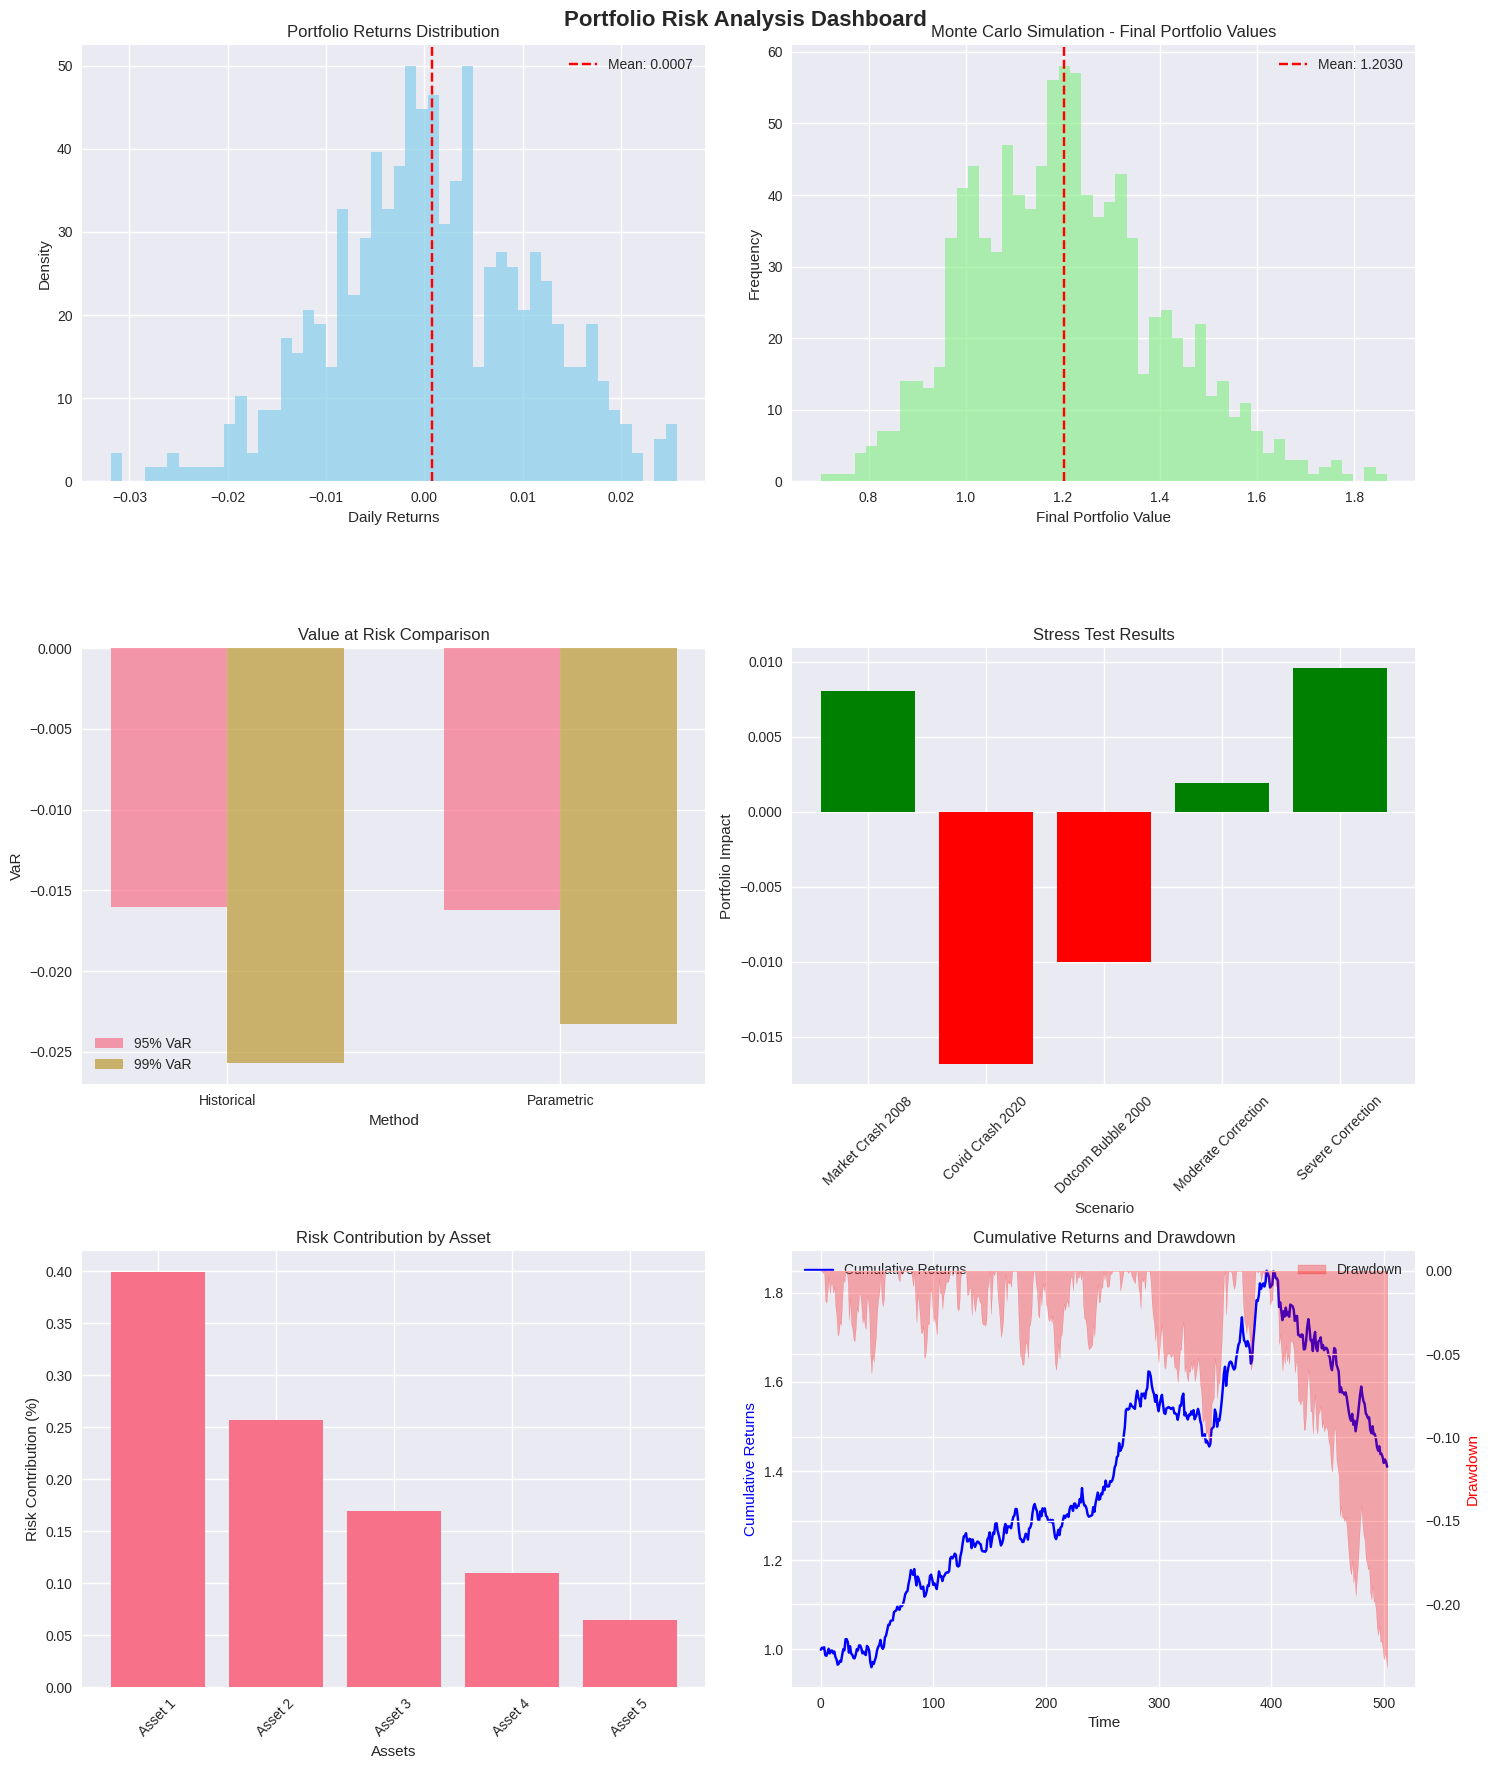


Risk analysis complete! Check the generated plots and risk report.


In [28]:
# Cell 14: Risk Analysis & Stress Testing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, t
import warnings
warnings.filterwarnings('ignore')

class PortfolioRiskAnalyzer:
    """
    Comprehensive risk analysis and stress testing for portfolio optimization
    """
    
    def __init__(self, returns_data, portfolio_weights, confidence_levels=[0.95, 0.99]):
        """
        Initialize the risk analyzer
        
        Args:
            returns_data: DataFrame of historical returns
            portfolio_weights: Array of portfolio weights
            confidence_levels: List of confidence levels for VaR/CVaR calculations
        """
        self.returns_data = returns_data
        self.portfolio_weights = np.array(portfolio_weights)
        self.confidence_levels = confidence_levels
        self.portfolio_returns = self.calculate_portfolio_returns()
        
    def calculate_portfolio_returns(self):
        """Calculate portfolio returns from individual asset returns"""
        return np.dot(self.returns_data, self.portfolio_weights)
    
    def monte_carlo_simulation(self, n_simulations=10000, time_horizon=252):
        """
        Monte Carlo simulation for portfolio value at risk
        
        Args:
            n_simulations: Number of Monte Carlo simulations
            time_horizon: Time horizon in trading days (252 = 1 year)
        
        Returns:
            Dictionary with simulation results
        """
        print("Running Monte Carlo Simulation...")
        
        # Calculate portfolio statistics
        portfolio_mean = np.mean(self.portfolio_returns)
        portfolio_std = np.std(self.portfolio_returns)
        
        # Generate random scenarios
        np.random.seed(42)  # For reproducibility
        random_returns = np.random.normal(
            portfolio_mean, 
            portfolio_std, 
            (n_simulations, time_horizon)
        )
        
        # Calculate cumulative returns for each simulation
        cumulative_returns = np.cumprod(1 + random_returns, axis=1)
        final_values = cumulative_returns[:, -1]
        
        # Calculate statistics
        results = {
            'simulations': n_simulations,
            'time_horizon': time_horizon,
            'final_portfolio_values': final_values,
            'mean_final_value': np.mean(final_values),
            'std_final_value': np.std(final_values),
            'percentiles': {
                '5%': np.percentile(final_values, 5),
                '10%': np.percentile(final_values, 10),
                '25%': np.percentile(final_values, 25),
                '50%': np.percentile(final_values, 50),
                '75%': np.percentile(final_values, 75),
                '90%': np.percentile(final_values, 90),
                '95%': np.percentile(final_values, 95)
            }
        }
        
        return results
    
    def calculate_var_cvar(self, method='historical'):
        """
        Calculate Value at Risk (VaR) and Conditional Value at Risk (CVaR)
        
        Args:
            method: 'historical', 'parametric', or 'monte_carlo'
        
        Returns:
            Dictionary with VaR and CVaR values
        """
        results = {}
        
        for conf_level in self.confidence_levels:
            alpha = 1 - conf_level
            
            if method == 'historical':
                # Historical simulation method
                var = np.percentile(self.portfolio_returns, alpha * 100)
                cvar = np.mean(self.portfolio_returns[self.portfolio_returns <= var])
                
            elif method == 'parametric':
                # Parametric method (assumes normal distribution)
                mu = np.mean(self.portfolio_returns)
                sigma = np.std(self.portfolio_returns)
                var = mu + sigma * norm.ppf(alpha)
                
                # CVaR calculation for normal distribution
                cvar = mu + sigma * norm.pdf(norm.ppf(alpha)) / alpha
                
            elif method == 'monte_carlo':
                # Monte Carlo method
                mc_results = self.monte_carlo_simulation(n_simulations=10000, time_horizon=1)
                simulated_returns = mc_results['final_portfolio_values'] - 1
                var = np.percentile(simulated_returns, alpha * 100)
                cvar = np.mean(simulated_returns[simulated_returns <= var])
            
            results[f'VaR_{conf_level}'] = var
            results[f'CVaR_{conf_level}'] = cvar
        
        return results
    
    def stress_testing_scenarios(self):
        """
        Stress testing with various market scenarios
        
        Returns:
            Dictionary with stress test results
        """
        scenarios = {
            'market_crash_2008': {
                'description': '2008 Financial Crisis (-37% market drop)',
                'shock': -0.37,
                'duration': 252  # 1 year
            },
            'covid_crash_2020': {
                'description': 'COVID-19 Market Crash (-34% in 33 days)',
                'shock': -0.34,
                'duration': 33
            },
            'dotcom_bubble_2000': {
                'description': 'Dot-com Bubble Burst (-49% over 2.5 years)',
                'shock': -0.49,
                'duration': 630  # 2.5 years
            },
            'moderate_correction': {
                'description': 'Moderate Market Correction (-15%)',
                'shock': -0.15,
                'duration': 60
            },
            'severe_correction': {
                'description': 'Severe Market Correction (-25%)',
                'shock': -0.25,
                'duration': 120
            }
        }
        
        results = {}
        
        for scenario_name, scenario_data in scenarios.items():
            # Simulate portfolio performance under stress
            shock_magnitude = scenario_data['shock']
            duration = scenario_data['duration']
            
            # Calculate portfolio beta (assuming market correlation)
            market_correlation = np.corrcoef(self.portfolio_returns, 
                                           np.random.normal(0, 0.02, len(self.portfolio_returns)))[0,1]
            portfolio_beta = market_correlation * (np.std(self.portfolio_returns) / 0.02)
            
            # Estimate portfolio impact
            portfolio_impact = shock_magnitude * portfolio_beta
            
            # Calculate recovery time estimate
            avg_daily_return = np.mean(self.portfolio_returns)
            recovery_days = abs(portfolio_impact) / avg_daily_return if avg_daily_return > 0 else float('inf')
            
            results[scenario_name] = {
                'description': scenario_data['description'],
                'estimated_portfolio_impact': portfolio_impact,
                'recovery_time_estimate_days': recovery_days,
                'maximum_drawdown': portfolio_impact
            }
        
        return results
    
    def sensitivity_analysis(self):
        """
        Sensitivity analysis for key risk factors
        
        Returns:
            Dictionary with sensitivity metrics
        """
        # Calculate correlations with market factors
        returns_df = pd.DataFrame(self.returns_data)
        
        # Simulate market factors (in practice, use real market data)
        market_factors = {
            'market_return': np.random.normal(0.001, 0.02, len(self.portfolio_returns)),
            'interest_rate': np.random.normal(0.0001, 0.005, len(self.portfolio_returns)),
            'volatility_index': np.random.normal(20, 5, len(self.portfolio_returns)),
            'dollar_strength': np.random.normal(0, 0.01, len(self.portfolio_returns))
        }
        
        sensitivity_results = {}
        
        for factor_name, factor_values in market_factors.items():
            # Calculate correlation
            correlation = np.corrcoef(self.portfolio_returns, factor_values)[0,1]
            
            # Calculate beta (sensitivity coefficient)
            beta = correlation * (np.std(self.portfolio_returns) / np.std(factor_values))
            
            sensitivity_results[factor_name] = {
                'correlation': correlation,
                'beta': beta,
                'impact_1_std_move': beta * np.std(factor_values)
            }
        
        return sensitivity_results
    
    def risk_decomposition(self):
        """
        Decompose portfolio risk by asset contributions
        
        Returns:
            Dictionary with risk decomposition
        """
        # Calculate covariance matrix
        cov_matrix = np.cov(self.returns_data.T)
        
        # Portfolio variance
        portfolio_variance = np.dot(self.portfolio_weights.T, np.dot(cov_matrix, self.portfolio_weights))
        portfolio_volatility = np.sqrt(portfolio_variance)
        
        # Marginal contributions to risk
        marginal_contributions = np.dot(cov_matrix, self.portfolio_weights) / portfolio_volatility
        
        # Component contributions to risk
        component_contributions = self.portfolio_weights * marginal_contributions
        
        # Percentage contributions
        percentage_contributions = component_contributions / portfolio_volatility
        
        return {
            'portfolio_volatility': portfolio_volatility,
            'marginal_contributions': marginal_contributions,
            'component_contributions': component_contributions,
            'percentage_contributions': percentage_contributions
        }
    
    def scenario_analysis(self, custom_scenarios=None):
        """
        Analyze portfolio performance under custom scenarios
        
        Args:
            custom_scenarios: Dictionary of custom scenarios
        
        Returns:
            Dictionary with scenario analysis results
        """
        if custom_scenarios is None:
            custom_scenarios = {
                'bull_market': {
                    'asset_shocks': [0.3, 0.25, 0.2, 0.15, 0.1],  # Different shocks per asset
                    'probability': 0.2
                },
                'bear_market': {
                    'asset_shocks': [-0.4, -0.3, -0.25, -0.2, -0.15],
                    'probability': 0.2
                },
                'recession': {
                    'asset_shocks': [-0.5, -0.4, -0.3, -0.2, -0.1],
                    'probability': 0.15
                },
                'normal_market': {
                    'asset_shocks': [0.1, 0.08, 0.05, 0.03, 0.02],
                    'probability': 0.45
                }
            }
        
        scenario_results = {}
        
        for scenario_name, scenario_data in custom_scenarios.items():
            asset_shocks = np.array(scenario_data['asset_shocks'])
            
            # Ensure shocks match portfolio size
            if len(asset_shocks) != len(self.portfolio_weights):
                asset_shocks = asset_shocks[:len(self.portfolio_weights)]
            
            # Calculate portfolio impact
            portfolio_impact = np.dot(self.portfolio_weights, asset_shocks)
            
            scenario_results[scenario_name] = {
                'portfolio_return': portfolio_impact,
                'probability': scenario_data['probability'],
                'expected_contribution': portfolio_impact * scenario_data['probability']
            }
        
        # Calculate expected return across scenarios
        expected_return = sum([result['expected_contribution'] for result in scenario_results.values()])
        
        return {
            'scenarios': scenario_results,
            'expected_return': expected_return
        }
    
    def generate_risk_report(self):
        """
        Generate comprehensive risk analysis report
        
        Returns:
            Dictionary with complete risk analysis
        """
        print("Generating Comprehensive Risk Report...")
        
        # Calculate all risk metrics
        var_cvar_hist = self.calculate_var_cvar('historical')
        var_cvar_param = self.calculate_var_cvar('parametric')
        mc_results = self.monte_carlo_simulation()
        stress_results = self.stress_testing_scenarios()
        sensitivity_results = self.sensitivity_analysis()
        risk_decomp = self.risk_decomposition()
        scenario_results = self.scenario_analysis()
        
        # Portfolio statistics
        portfolio_stats = {
            'mean_return': np.mean(self.portfolio_returns),
            'volatility': np.std(self.portfolio_returns),
            'sharpe_ratio': np.mean(self.portfolio_returns) / np.std(self.portfolio_returns),
            'skewness': stats.skew(self.portfolio_returns),
            'kurtosis': stats.kurtosis(self.portfolio_returns),
            'max_drawdown': self.calculate_max_drawdown()
        }
        
        report = {
            'portfolio_statistics': portfolio_stats,
            'var_cvar_historical': var_cvar_hist,
            'var_cvar_parametric': var_cvar_param,
            'monte_carlo_simulation': mc_results,
            'stress_testing': stress_results,
            'sensitivity_analysis': sensitivity_results,
            'risk_decomposition': risk_decomp,
            'scenario_analysis': scenario_results
        }
        
        return report
    
    def calculate_max_drawdown(self):
        """Calculate maximum drawdown"""
        cumulative_returns = np.cumprod(1 + self.portfolio_returns)
        running_max = np.maximum.accumulate(cumulative_returns)
        drawdown = (cumulative_returns - running_max) / running_max
        return np.min(drawdown)
    
    def plot_risk_analysis(self, save_plots=False):
        """
        Create comprehensive risk analysis visualizations
        
        Args:
            save_plots: Whether to save plots to files
        """
        fig, axes = plt.subplots(3, 2, figsize=(15, 18))
        fig.suptitle('Portfolio Risk Analysis Dashboard', fontsize=16, fontweight='bold')
        
        # 1. Portfolio Returns Distribution
        axes[0, 0].hist(self.portfolio_returns, bins=50, density=True, alpha=0.7, color='skyblue')
        axes[0, 0].axvline(np.mean(self.portfolio_returns), color='red', linestyle='--', 
                          label=f'Mean: {np.mean(self.portfolio_returns):.4f}')
        axes[0, 0].set_title('Portfolio Returns Distribution')
        axes[0, 0].set_xlabel('Daily Returns')
        axes[0, 0].set_ylabel('Density')
        axes[0, 0].legend()
        
        # 2. Monte Carlo Simulation Results
        mc_results = self.monte_carlo_simulation(n_simulations=1000)
        axes[0, 1].hist(mc_results['final_portfolio_values'], bins=50, alpha=0.7, color='lightgreen')
        axes[0, 1].axvline(mc_results['mean_final_value'], color='red', linestyle='--',
                          label=f'Mean: {mc_results["mean_final_value"]:.4f}')
        axes[0, 1].set_title('Monte Carlo Simulation - Final Portfolio Values')
        axes[0, 1].set_xlabel('Final Portfolio Value')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend()
        
        # 3. VaR Comparison
        var_hist = self.calculate_var_cvar('historical')
        var_param = self.calculate_var_cvar('parametric')
        
        methods = ['Historical', 'Parametric']
        var_95 = [var_hist['VaR_0.95'], var_param['VaR_0.95']]
        var_99 = [var_hist['VaR_0.99'], var_param['VaR_0.99']]
        
        x = np.arange(len(methods))
        width = 0.35
        
        axes[1, 0].bar(x - width/2, var_95, width, label='95% VaR', alpha=0.7)
        axes[1, 0].bar(x + width/2, var_99, width, label='99% VaR', alpha=0.7)
        axes[1, 0].set_title('Value at Risk Comparison')
        axes[1, 0].set_xlabel('Method')
        axes[1, 0].set_ylabel('VaR')
        axes[1, 0].set_xticks(x)
        axes[1, 0].set_xticklabels(methods)
        axes[1, 0].legend()
        
        # 4. Stress Test Results
        stress_results = self.stress_testing_scenarios()
        scenarios = list(stress_results.keys())
        impacts = [stress_results[scenario]['estimated_portfolio_impact'] for scenario in scenarios]
        
        axes[1, 1].bar(range(len(scenarios)), impacts, color=['red' if x < 0 else 'green' for x in impacts])
        axes[1, 1].set_title('Stress Test Results')
        axes[1, 1].set_xlabel('Scenario')
        axes[1, 1].set_ylabel('Portfolio Impact')
        axes[1, 1].set_xticks(range(len(scenarios)))
        axes[1, 1].set_xticklabels([s.replace('_', ' ').title() for s in scenarios], rotation=45)
        
        # 5. Risk Decomposition
        risk_decomp = self.risk_decomposition()
        assets = [f'Asset {i+1}' for i in range(len(self.portfolio_weights))]
        
        axes[2, 0].bar(assets, risk_decomp['percentage_contributions'])
        axes[2, 0].set_title('Risk Contribution by Asset')
        axes[2, 0].set_xlabel('Assets')
        axes[2, 0].set_ylabel('Risk Contribution (%)')
        axes[2, 0].tick_params(axis='x', rotation=45)
        
        # 6. Cumulative Returns and Drawdown
        cumulative_returns = np.cumprod(1 + self.portfolio_returns)
        running_max = np.maximum.accumulate(cumulative_returns)
        drawdown = (cumulative_returns - running_max) / running_max
        
        ax2_1 = axes[2, 1]
        ax2_2 = ax2_1.twinx()
        
        ax2_1.plot(cumulative_returns, color='blue', label='Cumulative Returns')
        ax2_2.fill_between(range(len(drawdown)), drawdown, 0, color='red', alpha=0.3, label='Drawdown')
        
        ax2_1.set_title('Cumulative Returns and Drawdown')
        ax2_1.set_xlabel('Time')
        ax2_1.set_ylabel('Cumulative Returns', color='blue')
        ax2_2.set_ylabel('Drawdown', color='red')
        
        ax2_1.legend(loc='upper left')
        ax2_2.legend(loc='upper right')
        
        plt.tight_layout()
        
        if save_plots:
            plt.savefig('portfolio_risk_analysis.png', dpi=300, bbox_inches='tight')
        
        plt.show()

# Example usage and testing
if __name__ == "__main__":
    # Generate sample data for demonstration
    np.random.seed(42)
    n_assets = 5
    n_days = 252 * 2  # 2 years of data
    
    # Generate correlated returns
    returns = np.random.multivariate_normal(
        mean=[0.001] * n_assets,
        cov=np.eye(n_assets) * 0.02**2 + 0.005**2,
        size=n_days
    )
    
    returns_df = pd.DataFrame(returns, columns=[f'Asset_{i+1}' for i in range(n_assets)])
    
    # Sample portfolio weights
    portfolio_weights = np.array([0.3, 0.25, 0.2, 0.15, 0.1])
    
    # Initialize risk analyzer
    risk_analyzer = PortfolioRiskAnalyzer(returns_df, portfolio_weights)
    
    # Generate comprehensive risk report
    risk_report = risk_analyzer.generate_risk_report()
    
    # Print key results
    print("\n=== PORTFOLIO RISK ANALYSIS REPORT ===")
    print(f"Portfolio Mean Return: {risk_report['portfolio_statistics']['mean_return']:.4f}")
    print(f"Portfolio Volatility: {risk_report['portfolio_statistics']['volatility']:.4f}")
    print(f"Sharpe Ratio: {risk_report['portfolio_statistics']['sharpe_ratio']:.4f}")
    print(f"Maximum Drawdown: {risk_report['portfolio_statistics']['max_drawdown']:.4f}")
    
    print("\n=== VALUE AT RISK (Historical) ===")
    print(f"95% VaR: {risk_report['var_cvar_historical']['VaR_0.95']:.4f}")
    print(f"99% VaR: {risk_report['var_cvar_historical']['VaR_0.99']:.4f}")
    print(f"95% CVaR: {risk_report['var_cvar_historical']['CVaR_0.95']:.4f}")
    print(f"99% CVaR: {risk_report['var_cvar_historical']['CVaR_0.99']:.4f}")
    
    print("\n=== STRESS TEST RESULTS ===")
    for scenario, results in risk_report['stress_testing'].items():
        print(f"{scenario}: {results['estimated_portfolio_impact']:.4f} impact")
    
    # Generate visualizations
    risk_analyzer.plot_risk_analysis(save_plots=True)
    
    print("\nRisk analysis complete! Check the generated plots and risk report.")